# Imports

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

In [21]:
print("Checking environment... Please use 'QualitativeAnalysis_Environment.yml'")
print("We need at least Seaborn (sns) version 0.11.0 for plotting")
print("Your Seaborn version:", sns.__version__)

Checking environment... Please use 'QualitativeAnalysis_Environment.yml'
We need at least Seaborn (sns) version 0.11.0 for plotting
Your Seaborn version: 0.9.0


# Utility functions

In [22]:
map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d',4,5,6,7,8,9,10,'1','2','3','4',',']

def plot_bar_graph_series(series, title=None, ylabel=None, xlabel=None):
    '''
    Plots a bar graph of the pandas series
    '''
    
    # create plot
    fig_height = max(len(series) * 0.5, 3)
    plt.figure(figsize=(12, fig_height))
    indices = np.arange(len(series))

    plt.grid(zorder=0)
    bars = plt.barh(indices, series.values, alpha=0.8, color='b', zorder=3)
    
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.title(title)
    plt.yticks(indices, series.index)
    
    for i, v in enumerate(series.values):
        plt.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.tight_layout()
    xmin, xmax = plt.xlim() 
    plt.xlim(xmax = xmax * 1.1)
    
    plt.show()
    
def calc_sole_sub_code_applied_rates(df, code_cat, map_codes = None):
    '''
    Calculates the frequency with which each sub-code in the code category (code_cat) is solely applied.
    That is, that a count of how often the sub-code occurs by itself (and not with any other sub-code in this code_cat) 
    
    Returns a dictionary of (sub_code_col_names, freq_count)
    '''
    
    if map_codes is None:
        map_codes = map_codes_to_cols
    
    sub_code_cols = map_codes[code_cat]
    map_sole_sub_code_freq = dict()
    for i in range(len(sub_code_cols)):
        query_string = ""
        for j in range(len(sub_code_cols)):
            sub_code_col = sub_code_cols[j]

            cell_value = 0
            if i == j:
                cell_value = 1

            query_string += f"({sub_code_col} == {cell_value})"

            if j + 1 is not len(sub_code_cols):
                query_string += " & "

        # print(query_string)
        # print(len(df.query(query_string)))
        map_sole_sub_code_freq[sub_code_cols[i]] = len(df.query(query_string))
    return map_sole_sub_code_freq

# Read in data

## Define input filenames and directory locations

In [30]:
# Define the paths
num_of_papers_per_year_dir = "../datasets"
num_of_papers_per_year_filename = 'Dataset1_TotalPaperCountsPerYear_ASSETSandCHI_2010-2019.csv'
num_of_papers_per_year_full_path = os.path.join(num_of_papers_per_year_dir, num_of_papers_per_year_filename)

qual_analysis_dir = "../datasets"
# qual_analysis_filename = 'FinalCodeAnalysis_Standardized_v6.5_KNM.xlsx'
qual_analysis_filename = 'Dataset1_QualitativelyCodedData_ASSETSandCHI_2010-2019.csv'
qual_analysis_full_path = os.path.join(qual_analysis_dir, qual_analysis_filename)

print("**************************************************************")
print(f"Using the: {qual_analysis_filename} file")
print("**************************************************************")

**************************************************************
Using the: Dataset1_QualitativelyCodedData_ASSETSandCHI_2010-2019.csv file
**************************************************************


## Read in the data

In [31]:
# Read in the csv that tracks the number of CHI and ASSETS papers from 2010-2019
df_total_papers_per_year = pd.read_csv(num_of_papers_per_year_full_path)
df_total_papers_per_year.set_index('Year', inplace=True)
print(f"Read in `{num_of_papers_per_year_full_path}`")
print("The total number of ASSETS papers={} and CHI papers={}".format(
    df_total_papers_per_year.sum()['ASSETS'], df_total_papers_per_year.sum()['CHI']))
display(df_total_papers_per_year)


Read in `../datasets\Dataset1_TotalPaperCountsPerYear_ASSETSandCHI_2010-2019.csv`
The total number of ASSETS papers=291 and CHI papers=4938


ASSETS  CHI
Year             
2010      28  302
2011      27  409
2012      25  370
2013      27  392
2014      28  465
2015      30  486
2016      24  545
2017      33  600
2018      28  666
2019      41  703

In [33]:
# Read in the applied codes data sheet. Check if Excel or CSV (we were using Excel during paper writing)
if qual_analysis_full_path.endswith('.xlsx'):
    target_sheet_name = 'AppliedCodes'
    df = pd.read_excel(qual_analysis_full_path, target_sheet_name)
else:
    df = pd.read_csv(qual_analysis_full_path)

# Clean column names. Pandas doesn't like hyphens because it messes with its eval parser in the .query function
# See: https://stackoverflow.com/a/50747014/388117
df.columns = [i.replace('-', '_') for i in df.columns]

print(f"Read in {df.shape[0]} rows and {df.shape[1]} cols from '{qual_analysis_full_path}'")

# Drop columns prefixed by 'ListOfParticipants_' since we don't need to analyze them
# See: https://github.com/jonfroehlich/accesslitsurvey/issues/29
code_cols_list_of_participants = [col for col in df if 'ListOfParticipants_' in col]
if len(code_cols_list_of_participants) > 0:
    print(f"Dropping {len(code_cols_list_of_participants)} columns prefixed by 'ListOfParticipants_'")
    df.drop(code_cols_list_of_participants, axis=1, inplace=True)
    
# Drop column 'ComparesOnDisability_Notes' as it's not a binary code column
if 'ComparesOnDisability_Notes' in df:
    df.drop(['ComparesOnDisability_Notes'], axis=1, inplace=True)

df.head()

Read in 515 rows and 71 cols from '../datasets\Dataset1_QualitativelyCodedData_ASSETSandCHI_2010-2019.csv'


Index                                             Author  \
0    1.0                     Giovanni Fusco, Valerie Morash   
1    2.0  Megan Hofmann and Kristin Williams and Toni Ka...   
2    3.0  Jessica Tran, Joy Kim, Jaehong Chon, Eve Riski...   
3    4.0                                    Timo Götzelmann   
4    5.0  Sooyeon Lee and Bjorn Hubert-Wallander and Mol...   

                                               Title  \
0  The Tactile Graphics Helper Providing Audio Cl...   
1  "Occupational Therapy is Making": Clinical Rap...   
2  Evaluating quality and comprehension of real-t...   
3  LucentMaps 3D Printed Audiovisual Tactile Maps...   
4  Understanding and Designing for Deaf or Hard o...   

                                             Keyword                      DOI  \
0  assistive devices, case study, finger tracking...  10.1145/2700648.2809868   
1  3d printing, adaptive design, digital fabricat...  10.1145/3290605.3300544   
2  american sign language, bitrate, deaf communit...  10.1145/2049536.2049558   
3  3d printing, accessibility, audio-tactile, bli...  10.1145/2982142.2982163   
4  accessibility, communication, deaf or hard of ...  10.1145/3290605.3300759   

    Venue    Year  CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
0  ASSETS  2015.0                   1.0                   0.0   
1     CHI  2019.0                   0.0                   0.0   
2  ASSETS  2011.0                   0.0                   1.0   
3  ASSETS  2016.0                   1.0                   0.0   
4     CHI  2019.0                   0.0                   1.0   

   CommunityOfFocus_IDD  ...  NumParticipants_Group1_Count  \
0                   0.0  ...                             2   
1                   0.0  ...                             4   
2                   0.0  ...                            39   
3                   0.0  ...                             9   
4                   0.0  ...                             5   

   NumParticipants_Group1_Population  NumParticipants_Group2_Count  \
0                        Specialists                             3   
1                        Specialists                             0   
2                        NonDisabled                            56   
3                                BVI                             0   
4                                DHH                             0   

   NumParticipants_Group2_Population  NumParticipants_Group3_Count  \
0                                BVI                             0   
1                                  0                             0   
2                      Other-Signers                             0   
3                                  0                             0   
4                                  0                             0   

   NumParticipants_Group3_Population  NumParticipants_Group4_Count  \
0                                  0                             0   
1                                  0                             0   
2                                  0                             0   
3                                  0                             0   
4                                  0                             0   

   NumParticipants_Group4_Population  NumParticipants_Group5_Count  \
0                                  0                             0   
1                                  0                             0   
2                                  0                             0   
3                                  0                             0   
4                                  0                             0   

   NumParticipants_Group5_Population  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  

[5 rows x 71 columns]

In [34]:
# Parse and print out code information
code_separator = '_'
code_cols = [col for col in df if code_separator in col]
map_codes = dict(); # maps code categories to sub-codes
map_codes_to_cols = dict()
for full_code in code_cols:
    # Some sub-codes have been sub-coded! We will ignore these for now
    # We identify a sub-code of a sub-code by looking at the number of
    # hypens. So, for example, `TargetPopulation-Other-Description` is a
    # sub-code of a sub-code (`Description` is a sub-code of `TargetPopulation-Other`)
    # 
    # We have one exception, which is the 'NumParticipants_Group' columns,
    # which look like `NumParticipants_Group1_Count` and `NumParticipants_Group1_Population`
    if full_code.count(code_separator) > 1 and not full_code.startswith('NumParticipants'):
        print(f"Ignoring {full_code} because it's a sub-code of a sub-code")
    else:
        # Split
        tokens = full_code.split(code_separator)
        code_category = tokens[0]
        sub_code = tokens[1]
        
        # NumParticipant columns are a special case
        if full_code.startswith('NumParticipants') and len(tokens) > 2:
            # This will correctly parse NumParticipants_Group1_Count and
            # NumParticipants_Group1_Population, for example
            sub_code = sub_code + code_separator + tokens[2]
        
        if code_category not in map_codes:
            map_codes[code_category] = list()
            map_codes_to_cols[code_category] = list()
            
        map_codes[code_category].append(sub_code)
        map_codes_to_cols[code_category].append(full_code)
        
# Print out details about the codes
print("\n-------------\n")
print(f"Found {len(map_codes)} code categories")

# Make into a dataframe to "pretty print" the code categories & sub-codes
df_codes = pd.DataFrame.from_dict(map_codes, orient='index') # https://stackoverflow.com/a/25217425/388117
df_codes = df_codes.transpose()
df_codes = df_codes.replace([None], ['']) # just replace None with '' to make the table cleaner
display(df_codes)

Ignoring ParticipantGroup_Other_Notes because it's a sub-code of a sub-code
Ignoring ParticipantGroup_Other_Crowdworker because it's a sub-code of a sub-code

-------------

Found 10 code categories


CommunityOfFocus                             IssueAddressed  \
0                BVI                      IncreaseDigitalAccess   
1                DHH                     IncreasePhysicalAccess   
2                IDD                       IncreaseIndependence   
3      MotorPhysical               IncreaseUnderstandingOfUsers   
4             Autism  HelpWithPersonalInformaticsBehaviorChange   
5          Cognitive                       SupportCommunication   
6         OlderAdult                                      Other   
7  GeneralDisability                                              
8              Other                                              
9                                                                 

     ContributionType           StudyMethod         ParticipantGroup  \
0           Empirical  ControlledExperiment               OlderAdult   
1            Artifact          SurveyMethod     PeopleWithDisability   
2      Methodological      UsabilityTesting  PeopleWithoutDisability   
3         Theoretical            Interviews    TherapistsSpecialists   
4             Dataset             CaseStudy               Caregivers   
5  SurveyContribution           FocusGroups                    Other   
6                                FieldStudy              NoUserStudy   
7                            WorkshopDesign                            
8                                     Other                            
9                                                                      

               StudyLocation ParticipatoryDesign ComparesOnDisability  \
0                  NearAtLab                 Yes                  Yes   
1  ParticipantsHomeOrFreqLoc                  No                   No   
2            NeutralLocation                                            
3                    Unclear                                            
4             OnlineRemotely                                            
5                      Other                                            
6                NoUserStudy                                            
7                                                                       
8                                                                       
9                                                                       

  UsesProxies    NumParticipants  
0         Yes       Group1_Count  
1          No  Group1_Population  
2                   Group2_Count  
3              Group2_Population  
4                   Group3_Count  
5              Group3_Population  
6                   Group4_Count  
7              Group4_Population  
8                   Group5_Count  
9              Group5_Population

In [35]:
print("Num papers by venue:")
df.groupby("Venue")["Venue"].count()

Num papers by venue:


Venue
ASSETS    291
CHI       215
Name: Venue, dtype: int64

# Summarizing the data

In [36]:
# Quick summaries
print(f"Total number of papers analyzed in our qualitative set: {len(df)}")
num_assets_papers = df.groupby('Venue')['Venue'].count()['ASSETS']
num_chi_papers = df.groupby('Venue')['Venue'].count()['CHI']
print(f"  Num of ASSETS papers: {num_assets_papers} of {len(df)} ({num_assets_papers/len(df)*100:.2f}%)")
print(f"  Num of CHI papers: {num_chi_papers} of {len(df)} ({num_chi_papers/len(df)*100:.2f}%)")
print()

df_no_user_study = df[df['ParticipantGroup_NoUserStudy'] == 1]
df_with_user_study = df[df['ParticipantGroup_NoUserStudy'] == 0]
num_papers_with_user_study = len(df) - len(df_no_user_study)
print(f"Num papers with a user study: {num_papers_with_user_study} of {len(df)} ({num_papers_with_user_study/len(df)*100:.2f}%)")


Total number of papers analyzed in our qualitative set: 515
  Num of ASSETS papers: 291 of 515 (56.50%)
  Num of CHI papers: 215 of 515 (41.75%)

Num papers with a user study: 486 of 515 (94.37%)


## Utility functions

In [37]:
def calc_code_coverage_across_papers(df_code_coverage):
    '''Calculates the code usage across papers for the given dataframe'''
    # Go through each category and print out table with counts, percentages, and a bar graph
    total_fraction_of_all_papers_label = f"Total Fraction of Papers (N={(len(df_code_coverage))})"
    for code_cat, sub_codes in map_codes.items():

        if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
            continue # skip these categories

        col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
        df_code_table = pd.DataFrame(index=col_names)
        df_code_table[code_cat] = sub_codes

        print(f"\n\n******************************* {code_cat} *******************************\n")
        df_code_table['Num Papers with Code'] = df_code_coverage[col_names].sum()
        df_code_table[total_fraction_of_all_papers_label] = df_code_coverage[col_names].sum() / len(df_code_coverage)
        df_code_table = df_code_table.sort_values(by=[total_fraction_of_all_papers_label], ascending=False)

        df_code_table[f'% of Papers (N={len(df_code_coverage)})'] =\
            pd.Series(["{0:.1f}%".format(val/len(df_code_coverage) * 100) for val in df_code_table['Num Papers with Code']], index = df_code_table.index)

        query = ""
        cumulative_coverage_fraction = 0
        row_index = 0
        total_papers_covered = []
        for index, row in df_code_table.iterrows(): 
            if row_index != 0:
                query += " | "
            query += f'({index} == 1)'
            query_result = df_code_coverage.query(query)
            total_papers_covered.append(len(query_result))
            row_index += 1

        df_code_table['Total Papers Covered'] = total_papers_covered
        df_code_table[f'% of Papers (N={len(df_code_coverage)}) Covered'] = \
            pd.Series(["{0:.1f}%".format(val/len(df_code_coverage) * 100) for val in df_code_table['Total Papers Covered']], index = df_code_table.index)

        df_code_table = df_code_table.drop(total_fraction_of_all_papers_label, axis=1)

        display(df_code_table)

## All Papers

### Frequency of sub-code use across all papers
Examines how often a particular sub-code was used for each code category.



******************************* CommunityOfFocus *******************************

Fraction of all papers (N=515) with sub-code:

CommunityOfFocus_BVI                  0.427184
CommunityOfFocus_MotorPhysical        0.139806
CommunityOfFocus_DHH                  0.110680
CommunityOfFocus_Other                0.089320
CommunityOfFocus_GeneralDisability    0.089320
CommunityOfFocus_Cognitive            0.089320
CommunityOfFocus_OlderAdult           0.087379
CommunityOfFocus_Autism               0.060194
CommunityOfFocus_IDD                  0.027184
Name: Total Fraction of All Papers (N=515), dtype: float64


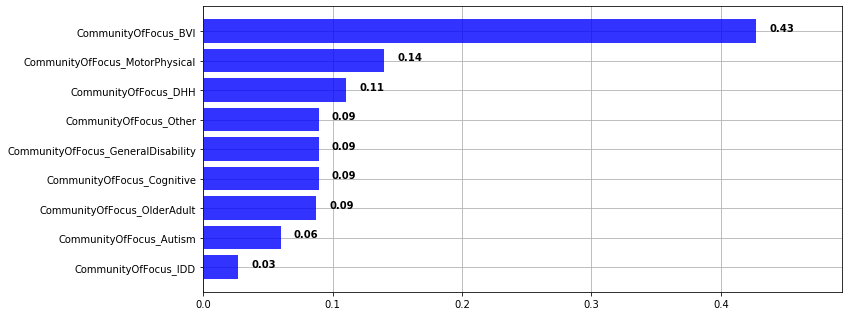

CommunityOfFocus  Num Papers with Code  \
CommunityOfFocus_BVI                              BVI                 220.0   
CommunityOfFocus_MotorPhysical          MotorPhysical                  72.0   
CommunityOfFocus_DHH                              DHH                  57.0   
CommunityOfFocus_Cognitive                  Cognitive                  46.0   
CommunityOfFocus_GeneralDisability  GeneralDisability                  46.0   
CommunityOfFocus_Other                          Other                  46.0   
CommunityOfFocus_OlderAdult                OlderAdult                  45.0   
CommunityOfFocus_Autism                        Autism                  31.0   
CommunityOfFocus_IDD                              IDD                  14.0   

                                    Total Fraction of All Papers (N=515)  \
CommunityOfFocus_BVI                                            0.427184   
CommunityOfFocus_MotorPhysical                                  0.139806   
CommunityOfFocus_DHH                                            0.110680   
CommunityOfFocus_Cognitive                                      0.089320   
CommunityOfFocus_GeneralDisability                              0.089320   
CommunityOfFocus_Other                                          0.089320   
CommunityOfFocus_OlderAdult                                     0.087379   
CommunityOfFocus_Autism                                         0.060194   
CommunityOfFocus_IDD                                            0.027184   

                                    Num Papers with this Code Only  \
CommunityOfFocus_BVI                                           208   
CommunityOfFocus_MotorPhysical                                  59   
CommunityOfFocus_DHH                                            43   
CommunityOfFocus_Cognitive                                      29   
CommunityOfFocus_GeneralDisability                              31   
CommunityOfFocus_Other                                          20   
CommunityOfFocus_OlderAdult                                     29   
CommunityOfFocus_Autism                                         21   
CommunityOfFocus_IDD                                             8   

                                    Num Papers with this Code Only (Fraction of Applied Code)  \
CommunityOfFocus_BVI                                                         0.945455           
CommunityOfFocus_MotorPhysical                                               0.819444           
CommunityOfFocus_DHH                                                         0.754386           
CommunityOfFocus_Cognitive                                                   0.630435           
CommunityOfFocus_GeneralDisability                                           0.673913           
CommunityOfFocus_Other                                                       0.434783           
CommunityOfFocus_OlderAdult                                                  0.644444           
CommunityOfFocus_Autism                                                      0.677419           
CommunityOfFocus_IDD                                                         0.571429           

                                    Num Papers with this Code Only (Fraction of Total Papers; N=515)  
CommunityOfFocus_BVI                                                         0.403883                 
CommunityOfFocus_MotorPhysical                                               0.114563                 
CommunityOfFocus_DHH                                                         0.083495                 
CommunityOfFocus_Cognitive                                                   0.056311                 
CommunityOfFocus_GeneralDisability                                           0.060194                 
CommunityOfFocus_Other                                                       0.038835                 
CommunityOfFocus_OlderAdult                                                  0.056311       

Table for paper:


CommunityOfFocus  Num Papers with Code  \
CommunityOfFocus_BVI                              BVI                 220.0   
CommunityOfFocus_MotorPhysical          MotorPhysical                  72.0   
CommunityOfFocus_DHH                              DHH                  57.0   
CommunityOfFocus_Cognitive                  Cognitive                  46.0   
CommunityOfFocus_GeneralDisability  GeneralDisability                  46.0   
CommunityOfFocus_Other                          Other                  46.0   
CommunityOfFocus_OlderAdult                OlderAdult                  45.0   
CommunityOfFocus_Autism                        Autism                  31.0   
CommunityOfFocus_IDD                              IDD                  14.0   

                                   % of Papers (N=515) with Code  \
CommunityOfFocus_BVI                                       42.7%   
CommunityOfFocus_MotorPhysical                             14.0%   
CommunityOfFocus_DHH                                       11.1%   
CommunityOfFocus_Cognitive                                  8.9%   
CommunityOfFocus_GeneralDisability                          8.9%   
CommunityOfFocus_Other                                      8.9%   
CommunityOfFocus_OlderAdult                                 8.7%   
CommunityOfFocus_Autism                                     6.0%   
CommunityOfFocus_IDD                                        2.7%   

                                    Num Papers with this Code Only  \
CommunityOfFocus_BVI                                           208   
CommunityOfFocus_MotorPhysical                                  59   
CommunityOfFocus_DHH                                            43   
CommunityOfFocus_Cognitive                                      29   
CommunityOfFocus_GeneralDisability                              31   
CommunityOfFocus_Other                                          20   
CommunityOfFocus_OlderAdult                                     29   
CommunityOfFocus_Autism                                         21   
CommunityOfFocus_IDD                                             8   

                                   % of Papers (N=515) with this Code Only  
CommunityOfFocus_BVI                                                 40.4%  
CommunityOfFocus_MotorPhysical                                       11.5%  
CommunityOfFocus_DHH                                                  8.3%  
CommunityOfFocus_Cognitive                                            5.6%  
CommunityOfFocus_GeneralDisability                                    6.0%  
CommunityOfFocus_Other                                                3.9%  
CommunityOfFocus_OlderAdult                                           5.6%  
CommunityOfFocus_Autism                                               4.1%  
CommunityOfFocus_IDD                                                  1.6%



******************************* IssueAddressed *******************************

Fraction of all papers (N=515) with sub-code:

IssueAddressed_IncreaseDigitalAccess                        0.361165
IssueAddressed_IncreaseUnderstandingOfUsers                 0.269903
IssueAddressed_IncreasePhysicalAccess                       0.203883
IssueAddressed_IncreaseIndependence                         0.180583
IssueAddressed_SupportCommunication                         0.157282
IssueAddressed_Other                                        0.114563
IssueAddressed_HelpWithPersonalInformaticsBehaviorChange    0.075728
Name: Total Fraction of All Papers (N=515), dtype: float64


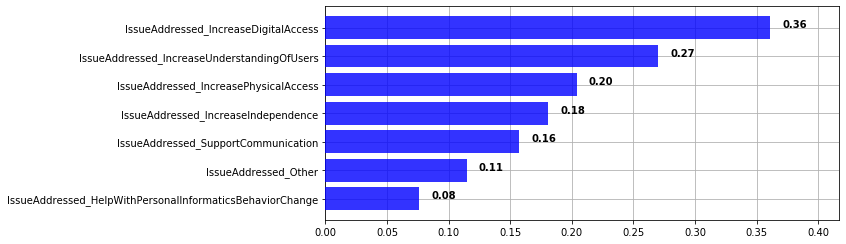

IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                               186.0   
IssueAddressed_IncreaseUnderstandingOfUsers                        139.0   
IssueAddressed_IncreasePhysicalAccess                              105.0   
IssueAddressed_IncreaseIndependence                                 93.0   
IssueAddressed_SupportCommunication                                 81.0   
IssueAddressed_Other                                                59.0   
IssueAddressed_HelpWithPersonalInformaticsBehav...                  39.0   

                                                    Total Fraction of All Papers (N=515)  \
IssueAddressed_IncreaseDigitalAccess                                            0.361165   
IssueAddressed_IncreaseUnderstandingOfUsers                                     0.269903   
IssueAddressed_IncreasePhysicalAccess                                           0.203883   
IssueAddressed_IncreaseIndependence                                             0.180583   
IssueAddressed_SupportCommunication                                             0.157282   
IssueAddressed_Other                                                            0.114563   
IssueAddressed_HelpWithPersonalInformaticsBehav...                              0.075728   

                                                    Num Papers with this Code Only  \
IssueAddressed_IncreaseDigitalAccess                                           122   
IssueAddressed_IncreaseUnderstandingOfUsers                                     89   
IssueAddressed_IncreasePhysicalAccess                                           26   
IssueAddressed_IncreaseIndependence                                             14   
IssueAddressed_SupportCommunication                                             45   
IssueAddressed_Other                                                            25   
IssueAddressed_HelpWithPersonalInformaticsBehav...                              19   

                                                    Num Papers with this Code Only (Fraction of Applied Code)  \
IssueAddressed_IncreaseDigitalAccess                                                         0.655914           
IssueAddressed_IncreaseUnderstandingOfUsers                                                  0.640288           
IssueAddressed_IncreasePhysicalAccess                                                        0.247619           
IssueAddressed_IncreaseIndependence                                                          0.150538           
IssueAddressed_SupportCommunication                                                          0.555556           
IssueAddressed_Other                                                                         0.423729           
IssueAddressed_HelpWithPersonalInformaticsBehav...                                           0.487179           

                                                    Num Papers with this Code Only (Fraction of Total Papers; N=515)  
IssueAddressed_IncreaseDigitalAccess                                                         0.236893                 
IssueAddressed_IncreaseUnderstandingOfUsers                                                  0.172816                 
Issue

Table for paper:


IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                               186.0   
IssueAddressed_IncreaseUnderstandingOfUsers                        139.0   
IssueAddressed_IncreasePhysicalAccess                              105.0   
IssueAddressed_IncreaseIndependence                                 93.0   
IssueAddressed_SupportCommunication                                 81.0   
IssueAddressed_Other                                                59.0   
IssueAddressed_HelpWithPersonalInformaticsBehav...                  39.0   

                                                   % of Papers (N=515) with Code  \
IssueAddressed_IncreaseDigitalAccess                                       36.1%   
IssueAddressed_IncreaseUnderstandingOfUsers                                27.0%   
IssueAddressed_IncreasePhysicalAccess                                      20.4%   
IssueAddressed_IncreaseIndependence                                        18.1%   
IssueAddressed_SupportCommunication                                        15.7%   
IssueAddressed_Other                                                       11.5%   
IssueAddressed_HelpWithPersonalInformaticsBehav...                          7.6%   

                                                    Num Papers with this Code Only  \
IssueAddressed_IncreaseDigitalAccess                                           122   
IssueAddressed_IncreaseUnderstandingOfUsers                                     89   
IssueAddressed_IncreasePhysicalAccess                                           26   
IssueAddressed_IncreaseIndependence                                             14   
IssueAddressed_SupportCommunication                                             45   
IssueAddressed_Other                                                            25   
IssueAddressed_HelpWithPersonalInformaticsBehav...                              19   

                                                   % of Papers (N=515) with this Code Only  
IssueAddressed_IncreaseDigitalAccess                                                 23.7%  
IssueAddressed_IncreaseUnderstandingOfUsers                                          17.3%  
IssueAddressed_IncreasePhysicalAccess                                                 5.0%  
IssueAddressed_IncreaseIndependence                                                   2.7%  
IssueAddressed_SupportCommunication                                                   8.7%  
IssueAddressed_Other                                                                  4.9%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                                    3.7%



******************************* ContributionType *******************************

Fraction of all papers (N=515) with sub-code:

ContributionType_Empirical             0.592233
ContributionType_Artifact              0.545631
ContributionType_Theoretical           0.085437
ContributionType_Methodological        0.031068
ContributionType_Dataset               0.013592
ContributionType_SurveyContribution    0.005825
Name: Total Fraction of All Papers (N=515), dtype: float64


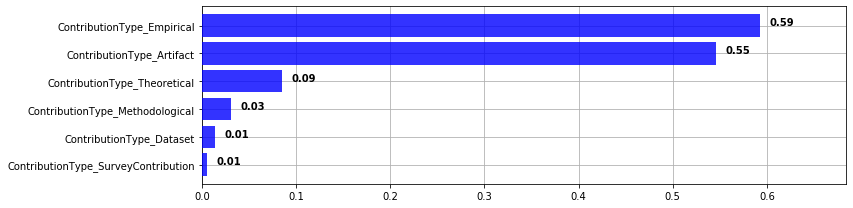

ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                 305.0   
ContributionType_Artifact                      Artifact                 281.0   
ContributionType_Theoretical                Theoretical                  44.0   
ContributionType_Methodological          Methodological                  16.0   
ContributionType_Dataset                        Dataset                   7.0   
ContributionType_SurveyContribution  SurveyContribution                   3.0   

                                     Total Fraction of All Papers (N=515)  \
ContributionType_Empirical                                       0.592233   
ContributionType_Artifact                                        0.545631   
ContributionType_Theoretical                                     0.085437   
ContributionType_Methodological                                  0.031068   
ContributionType_Dataset                                         0.013592   
ContributionType_SurveyContribution                              0.005825   

                                     Num Papers with this Code Only  \
ContributionType_Empirical                                      171   
ContributionType_Artifact                                       182   
ContributionType_Theoretical                                      6   
ContributionType_Methodological                                   2   
ContributionType_Dataset                                          2   
ContributionType_SurveyContribution                               0   

                                     Num Papers with this Code Only (Fraction of Applied Code)  \
ContributionType_Empirical                                                    0.560656           
ContributionType_Artifact                                                     0.647687           
ContributionType_Theoretical                                                  0.136364           
ContributionType_Methodological                                               0.125000           
ContributionType_Dataset                                                      0.285714           
ContributionType_SurveyContribution                                           0.000000           

                                     Num Papers with this Code Only (Fraction of Total Papers; N=515)  
ContributionType_Empirical                                                    0.332039                 
ContributionType_Artifact                                                     0.353398                 
ContributionType_Theoretical                                                  0.011650                 
ContributionType_Methodological                                               0.003883                 
ContributionType_Dataset                                                      0.003883                 
ContributionType_SurveyContribution                                           0.000000

Table for paper:


ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                 305.0   
ContributionType_Artifact                      Artifact                 281.0   
ContributionType_Theoretical                Theoretical                  44.0   
ContributionType_Methodological          Methodological                  16.0   
ContributionType_Dataset                        Dataset                   7.0   
ContributionType_SurveyContribution  SurveyContribution                   3.0   

                                    % of Papers (N=515) with Code  \
ContributionType_Empirical                                  59.2%   
ContributionType_Artifact                                   54.6%   
ContributionType_Theoretical                                 8.5%   
ContributionType_Methodological                              3.1%   
ContributionType_Dataset                                     1.4%   
ContributionType_SurveyContribution                          0.6%   

                                     Num Papers with this Code Only  \
ContributionType_Empirical                                      171   
ContributionType_Artifact                                       182   
ContributionType_Theoretical                                      6   
ContributionType_Methodological                                   2   
ContributionType_Dataset                                          2   
ContributionType_SurveyContribution                               0   

                                    % of Papers (N=515) with this Code Only  
ContributionType_Empirical                                            33.2%  
ContributionType_Artifact                                             35.3%  
ContributionType_Theoretical                                           1.2%  
ContributionType_Methodological                                        0.4%  
ContributionType_Dataset                                               0.4%  
ContributionType_SurveyContribution                                    0.0%



******************************* StudyMethod *******************************

Fraction of all papers (N=515) with sub-code:

StudyMethod_Interviews              0.390291
StudyMethod_UsabilityTesting        0.386408
StudyMethod_ControlledExperiment    0.324272
StudyMethod_SurveyMethod            0.236893
StudyMethod_Other                   0.192233
StudyMethod_WorkshopDesign          0.170874
StudyMethod_FieldStudy              0.165049
StudyMethod_FocusGroups             0.054369
StudyMethod_CaseStudy               0.048544
Name: Total Fraction of All Papers (N=515), dtype: float64


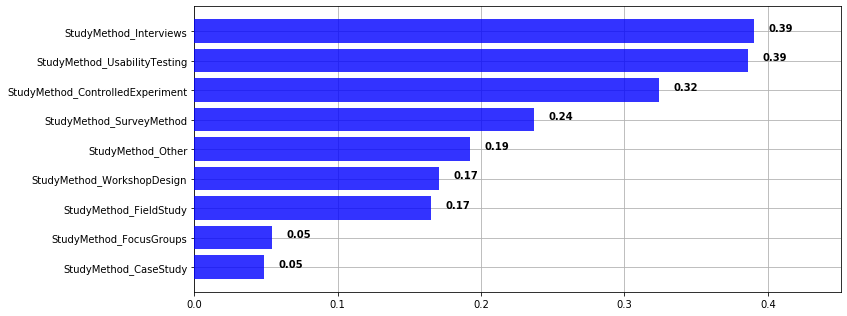

StudyMethod  Num Papers with Code  \
StudyMethod_Interviews                      Interviews                 201.0   
StudyMethod_UsabilityTesting          UsabilityTesting                 199.0   
StudyMethod_ControlledExperiment  ControlledExperiment                 167.0   
StudyMethod_SurveyMethod                  SurveyMethod                 122.0   
StudyMethod_Other                                Other                  99.0   
StudyMethod_WorkshopDesign              WorkshopDesign                  88.0   
StudyMethod_FieldStudy                      FieldStudy                  85.0   
StudyMethod_FocusGroups                    FocusGroups                  28.0   
StudyMethod_CaseStudy                        CaseStudy                  25.0   

                                  Total Fraction of All Papers (N=515)  \
StudyMethod_Interviews                                        0.390291   
StudyMethod_UsabilityTesting                                  0.386408   
StudyMethod_ControlledExperiment                              0.324272   
StudyMethod_SurveyMethod                                      0.236893   
StudyMethod_Other                                             0.192233   
StudyMethod_WorkshopDesign                                    0.170874   
StudyMethod_FieldStudy                                        0.165049   
StudyMethod_FocusGroups                                       0.054369   
StudyMethod_CaseStudy                                         0.048544   

                                  Num Papers with this Code Only  \
StudyMethod_Interviews                                        27   
StudyMethod_UsabilityTesting                                  46   
StudyMethod_ControlledExperiment                              57   
StudyMethod_SurveyMethod                                       6   
StudyMethod_Other                                             25   
StudyMethod_WorkshopDesign                                    15   
StudyMethod_FieldStudy                                        22   
StudyMethod_FocusGroups                                        4   
StudyMethod_CaseStudy                                          6   

                                  Num Papers with this Code Only (Fraction of Applied Code)  \
StudyMethod_Interviews                                                     0.134328           
StudyMethod_UsabilityTesting                                               0.231156           
StudyMethod_ControlledExperiment                                           0.341317           
StudyMethod_SurveyMethod                                                   0.049180           
StudyMethod_Other                                                          0.252525           
StudyMethod_WorkshopDesign                                                 0.170455           
StudyMethod_FieldStudy                                                     0.258824           
StudyMethod_FocusGroups                                                    0.142857           
StudyMethod_CaseStudy                                                      0.240000           

                                  Num Papers with this Code Only (Fraction of Total Papers; N=515)  
StudyMethod_Interviews                                                     0.052427                 
StudyMethod_UsabilityTesting                                               0.089320                 
StudyMethod_ControlledExperiment                                           0.110680                 
StudyMethod_SurveyMethod                                                   0.011650                 
StudyMethod_Other                                                          0.048544                 
StudyMethod_WorkshopDesign                                                 0.029126                 
StudyMethod_FieldStudy                                                     0.042718                 
StudyMethod_FocusGroups                                      

Table for paper:


StudyMethod  Num Papers with Code  \
StudyMethod_Interviews                      Interviews                 201.0   
StudyMethod_UsabilityTesting          UsabilityTesting                 199.0   
StudyMethod_ControlledExperiment  ControlledExperiment                 167.0   
StudyMethod_SurveyMethod                  SurveyMethod                 122.0   
StudyMethod_Other                                Other                  99.0   
StudyMethod_WorkshopDesign              WorkshopDesign                  88.0   
StudyMethod_FieldStudy                      FieldStudy                  85.0   
StudyMethod_FocusGroups                    FocusGroups                  28.0   
StudyMethod_CaseStudy                        CaseStudy                  25.0   

                                 % of Papers (N=515) with Code  \
StudyMethod_Interviews                                   39.0%   
StudyMethod_UsabilityTesting                             38.6%   
StudyMethod_ControlledExperiment                         32.4%   
StudyMethod_SurveyMethod                                 23.7%   
StudyMethod_Other                                        19.2%   
StudyMethod_WorkshopDesign                               17.1%   
StudyMethod_FieldStudy                                   16.5%   
StudyMethod_FocusGroups                                   5.4%   
StudyMethod_CaseStudy                                     4.9%   

                                  Num Papers with this Code Only  \
StudyMethod_Interviews                                        27   
StudyMethod_UsabilityTesting                                  46   
StudyMethod_ControlledExperiment                              57   
StudyMethod_SurveyMethod                                       6   
StudyMethod_Other                                             25   
StudyMethod_WorkshopDesign                                    15   
StudyMethod_FieldStudy                                        22   
StudyMethod_FocusGroups                                        4   
StudyMethod_CaseStudy                                          6   

                                 % of Papers (N=515) with this Code Only  
StudyMethod_Interviews                                              5.2%  
StudyMethod_UsabilityTesting                                        8.9%  
StudyMethod_ControlledExperiment                                   11.1%  
StudyMethod_SurveyMethod                                            1.2%  
StudyMethod_Other                                                   4.9%  
StudyMethod_WorkshopDesign                                          2.9%  
StudyMethod_FieldStudy                                              4.3%  
StudyMethod_FocusGroups                                             0.8%  
StudyMethod_CaseStudy                                               1.2%



******************************* ParticipantGroup *******************************

Fraction of all papers (N=515) with sub-code:

ParticipantGroup_PeopleWithDisability       0.784466
ParticipantGroup_PeopleWithoutDisability    0.213592
ParticipantGroup_TherapistsSpecialists      0.157282
ParticipantGroup_Other                      0.102913
ParticipantGroup_Caregivers                 0.087379
ParticipantGroup_OlderAdult                 0.077670
ParticipantGroup_NoUserStudy                0.056311
Name: Total Fraction of All Papers (N=515), dtype: float64


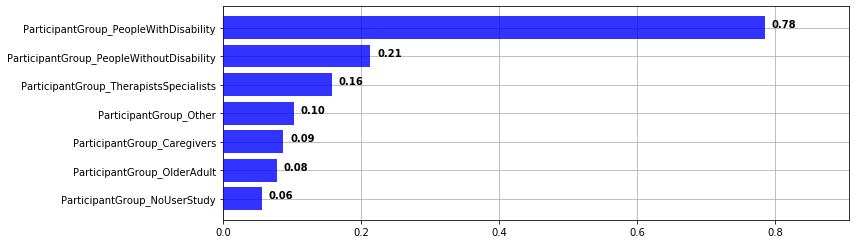

ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                    404.0   
ParticipantGroup_PeopleWithoutDisability                 110.0   
ParticipantGroup_TherapistsSpecialists                    81.0   
ParticipantGroup_Other                                    53.0   
ParticipantGroup_Caregivers                               45.0   
ParticipantGroup_OlderAdult                               40.0   
ParticipantGroup_NoUserStudy                              29.0   

                                          Total Fraction of All Papers (N=515)  \
ParticipantGroup_PeopleWithDisability                                 0.784466   
ParticipantGroup_PeopleWithoutDisability                              0.213592   
ParticipantGroup_TherapistsSpecialists                                0.157282   
ParticipantGroup_Other                                                0.102913   
ParticipantGroup_Caregivers                                           0.087379   
ParticipantGroup_OlderAdult                                           0.077670   
ParticipantGroup_NoUserStudy                                          0.056311   

                                          Num Papers with this Code Only  \
ParticipantGroup_PeopleWithDisability                                214   
ParticipantGroup_PeopleWithoutDisability                               5   
ParticipantGroup_TherapistsSpecialists                                 9   
ParticipantGroup_Other                                                23   
ParticipantGroup_Caregivers                                            4   
ParticipantGroup_OlderAdult                                           15   
ParticipantGroup_NoUserStudy                                          29   

                                          Num Papers with this Code Only (Fraction of Applied Code)  \
ParticipantGroup_PeopleWithDisability                                              0.529703           
ParticipantGroup_PeopleWithoutDisability                                           0.045455           
ParticipantGroup_TherapistsSpecialists                                             0.111111           
ParticipantGroup_Other                                                             0.433962           
ParticipantGroup_Caregivers                                                        0.088889           
ParticipantGroup_OlderAdult                                                        0.375000           
ParticipantGroup_NoUserStudy                                                       1.000000           

                                          Num Papers with this Code Only (Fraction of Total Papers; N=515)  
ParticipantGroup_PeopleWithDisability                                              0.415534                 
ParticipantGroup_PeopleWithoutDisability                                           0.009709                 
ParticipantGroup_TherapistsSpecialists                                             0.017476                 
ParticipantGroup_Other                                                             0.044660                 
ParticipantGroup_Caregivers                                                        0.007767                 
ParticipantGroup_OlderAdult                                                        0.029126                 
ParticipantGroup_NoUserStudy                                                       0.056311

Table for paper:


ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                    404.0   
ParticipantGroup_PeopleWithoutDisability                 110.0   
ParticipantGroup_TherapistsSpecialists                    81.0   
ParticipantGroup_Other                                    53.0   
ParticipantGroup_Caregivers                               45.0   
ParticipantGroup_OlderAdult                               40.0   
ParticipantGroup_NoUserStudy                              29.0   

                                         % of Papers (N=515) with Code  \
ParticipantGroup_PeopleWithDisability                            78.4%   
ParticipantGroup_PeopleWithoutDisability                         21.4%   
ParticipantGroup_TherapistsSpecialists                           15.7%   
ParticipantGroup_Other                                           10.3%   
ParticipantGroup_Caregivers                                       8.7%   
ParticipantGroup_OlderAdult                                       7.8%   
ParticipantGroup_NoUserStudy                                      5.6%   

                                          Num Papers with this Code Only  \
ParticipantGroup_PeopleWithDisability                                214   
ParticipantGroup_PeopleWithoutDisability                               5   
ParticipantGroup_TherapistsSpecialists                                 9   
ParticipantGroup_Other                                                23   
ParticipantGroup_Caregivers                                            4   
ParticipantGroup_OlderAdult                                           15   
ParticipantGroup_NoUserStudy                                          29   

                                         % of Papers (N=515) with this Code Only  
ParticipantGroup_PeopleWithDisability                                      41.6%  
ParticipantGroup_PeopleWithoutDisability                                    1.0%  
ParticipantGroup_TherapistsSpecialists                                      1.7%  
ParticipantGroup_Other                                                      4.5%  
ParticipantGroup_Caregivers                                                 0.8%  
ParticipantGroup_OlderAdult                                                 2.9%  
ParticipantGroup_NoUserStudy                                                5.6%



******************************* StudyLocation *******************************

Fraction of all papers (N=515) with sub-code:

StudyLocation_Unclear                      0.366990
StudyLocation_ParticipantsHomeOrFreqLoc    0.267961
StudyLocation_NearAtLab                    0.252427
StudyLocation_OnlineRemotely               0.190291
StudyLocation_NeutralLocation              0.062136
StudyLocation_NoUserStudy                  0.056311
StudyLocation_Other                        0.013592
Name: Total Fraction of All Papers (N=515), dtype: float64


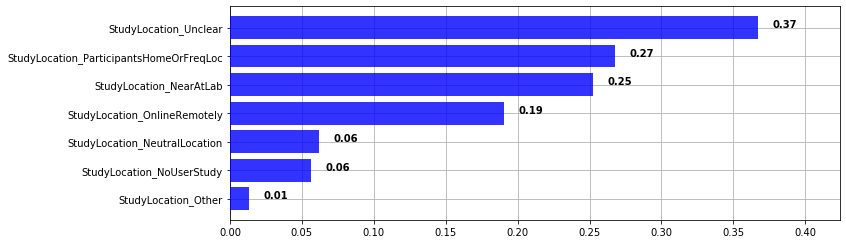

StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_NoUserStudy                              NoUserStudy   
StudyLocation_Other                                          Other   

                                         Num Papers with Code  \
StudyLocation_Unclear                                   189.0   
StudyLocation_ParticipantsHomeOrFreqLoc                 138.0   
StudyLocation_NearAtLab                                 130.0   
StudyLocation_OnlineRemotely                             98.0   
StudyLocation_NeutralLocation                            32.0   
StudyLocation_NoUserStudy                                29.0   
StudyLocation_Other                                       7.0   

                                         Total Fraction of All Papers (N=515)  \
StudyLocation_Unclear                                                0.366990   
StudyLocation_ParticipantsHomeOrFreqLoc                              0.267961   
StudyLocation_NearAtLab                                              0.252427   
StudyLocation_OnlineRemotely                                         0.190291   
StudyLocation_NeutralLocation                                        0.062136   
StudyLocation_NoUserStudy                                            0.056311   
StudyLocation_Other                                                  0.013592   

                                         Num Papers with this Code Only  \
StudyLocation_Unclear                                               133   
StudyLocation_ParticipantsHomeOrFreqLoc                              85   
StudyLocation_NearAtLab                                              93   
StudyLocation_OnlineRemotely                                         48   
StudyLocation_NeutralLocation                                        15   
StudyLocation_NoUserStudy                                            29   
StudyLocation_Other                                                   1   

                                         Num Papers with this Code Only (Fraction of Applied Code)  \
StudyLocation_Unclear                                                             0.703704           
StudyLocation_ParticipantsHomeOrFreqLoc                                           0.615942           
StudyLocation_NearAtLab                                                           0.715385           
StudyLocation_OnlineRemotely                                                      0.489796           
StudyLocation_NeutralLocation                                                     0.468750           
StudyLocation_NoUserStudy                                                         1.000000           
StudyLocation_Other                                                               0.142857           

                                         Num Papers with this Code Only (Fraction of Total Papers; N=515)  
StudyLocation_Unclear                                                             0.258252                 
StudyLocation_ParticipantsHomeOrFreqLoc                                           0.165049                 
StudyLocation_NearAtLab                                                           0.180583                 
StudyLocation_OnlineRemotely                                                      0.093204                 
StudyLocation_NeutralLocation                                                     0.029126                 
StudyLocation_NoUserStudy                                                         0.056311                 
StudyLocation_Other                                                               0.001942

Table for paper:


StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_NoUserStudy                              NoUserStudy   
StudyLocation_Other                                          Other   

                                         Num Papers with Code  \
StudyLocation_Unclear                                   189.0   
StudyLocation_ParticipantsHomeOrFreqLoc                 138.0   
StudyLocation_NearAtLab                                 130.0   
StudyLocation_OnlineRemotely                             98.0   
StudyLocation_NeutralLocation                            32.0   
StudyLocation_NoUserStudy                                29.0   
StudyLocation_Other                                       7.0   

                                        % of Papers (N=515) with Code  \
StudyLocation_Unclear                                           36.7%   
StudyLocation_ParticipantsHomeOrFreqLoc                         26.8%   
StudyLocation_NearAtLab                                         25.2%   
StudyLocation_OnlineRemotely                                    19.0%   
StudyLocation_NeutralLocation                                    6.2%   
StudyLocation_NoUserStudy                                        5.6%   
StudyLocation_Other                                              1.4%   

                                         Num Papers with this Code Only  \
StudyLocation_Unclear                                               133   
StudyLocation_ParticipantsHomeOrFreqLoc                              85   
StudyLocation_NearAtLab                                              93   
StudyLocation_OnlineRemotely                                         48   
StudyLocation_NeutralLocation                                        15   
StudyLocation_NoUserStudy                                            29   
StudyLocation_Other                                                   1   

                                        % of Papers (N=515) with this Code Only  
StudyLocation_Unclear                                                     25.8%  
StudyLocation_ParticipantsHomeOrFreqLoc                                   16.5%  
StudyLocation_NearAtLab                                                   18.1%  
StudyLocation_OnlineRemotely                                               9.3%  
StudyLocation_NeutralLocation                                              2.9%  
StudyLocation_NoUserStudy                                                  5.6%  
StudyLocation_Other                                                        0.2%



******************************* ParticipatoryDesign *******************************

Fraction of all papers (N=515) with sub-code:

ParticipatoryDesign_No     0.887379
ParticipatoryDesign_Yes    0.095146
Name: Total Fraction of All Papers (N=515), dtype: float64


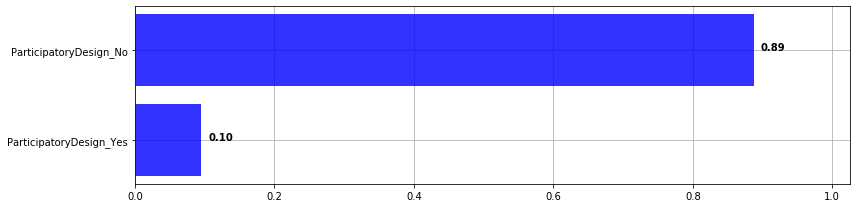

ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_No                   No                 457.0   
ParticipatoryDesign_Yes                 Yes                  49.0   

                         Total Fraction of All Papers (N=515)  \
ParticipatoryDesign_No                               0.887379   
ParticipatoryDesign_Yes                              0.095146   

                         Num Papers with this Code Only  \
ParticipatoryDesign_No                              457   
ParticipatoryDesign_Yes                              49   

                         Num Papers with this Code Only (Fraction of Applied Code)  \
ParticipatoryDesign_No                                                 1.0           
ParticipatoryDesign_Yes                                                1.0           

                         Num Papers with this Code Only (Fraction of Total Papers; N=515)  
ParticipatoryDesign_No                                            0.887379                 
ParticipatoryDesign_Yes                                           0.095146

Table for paper:


ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_No                   No                 457.0   
ParticipatoryDesign_Yes                 Yes                  49.0   

                        % of Papers (N=515) with Code  \
ParticipatoryDesign_No                          88.7%   
ParticipatoryDesign_Yes                          9.5%   

                         Num Papers with this Code Only  \
ParticipatoryDesign_No                              457   
ParticipatoryDesign_Yes                              49   

                        % of Papers (N=515) with this Code Only  
ParticipatoryDesign_No                                    88.7%  
ParticipatoryDesign_Yes                                    9.5%



******************************* ComparesOnDisability *******************************

Fraction of all papers (N=515) with sub-code:

ComparesOnDisability_No     0.856311
ComparesOnDisability_Yes    0.126214
Name: Total Fraction of All Papers (N=515), dtype: float64


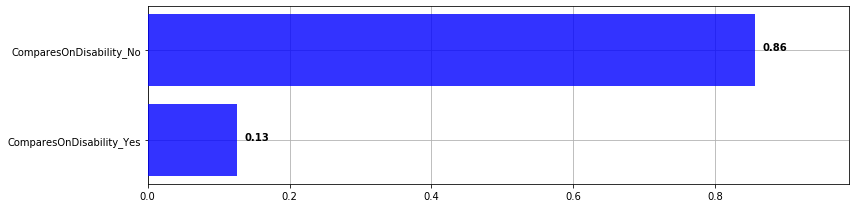

ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                 441.0   
ComparesOnDisability_Yes                  Yes                  65.0   

                          Total Fraction of All Papers (N=515)  \
ComparesOnDisability_No                               0.856311   
ComparesOnDisability_Yes                              0.126214   

                          Num Papers with this Code Only  \
ComparesOnDisability_No                              441   
ComparesOnDisability_Yes                              65   

                          Num Papers with this Code Only (Fraction of Applied Code)  \
ComparesOnDisability_No                                                 1.0           
ComparesOnDisability_Yes                                                1.0           

                          Num Papers with this Code Only (Fraction of Total Papers; N=515)  
ComparesOnDisability_No                                            0.856311                 
ComparesOnDisability_Yes                                           0.126214

Table for paper:


ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                 441.0   
ComparesOnDisability_Yes                  Yes                  65.0   

                         % of Papers (N=515) with Code  \
ComparesOnDisability_No                          85.6%   
ComparesOnDisability_Yes                         12.6%   

                          Num Papers with this Code Only  \
ComparesOnDisability_No                              441   
ComparesOnDisability_Yes                              65   

                         % of Papers (N=515) with this Code Only  
ComparesOnDisability_No                                    85.6%  
ComparesOnDisability_Yes                                   12.6%



******************************* UsesProxies *******************************

Fraction of all papers (N=515) with sub-code:

UsesProxies_No     0.908738
UsesProxies_Yes    0.073786
Name: Total Fraction of All Papers (N=515), dtype: float64


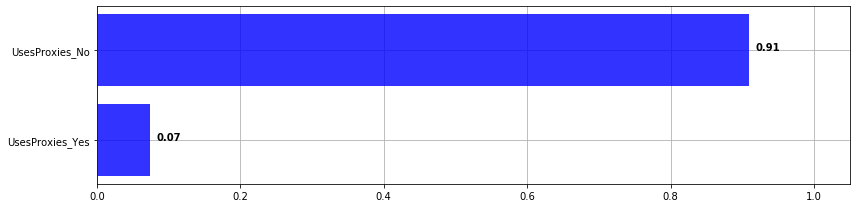

UsesProxies  Num Papers with Code  \
UsesProxies_No           No                 468.0   
UsesProxies_Yes         Yes                  38.0   

                 Total Fraction of All Papers (N=515)  \
UsesProxies_No                               0.908738   
UsesProxies_Yes                              0.073786   

                 Num Papers with this Code Only  \
UsesProxies_No                              468   
UsesProxies_Yes                              38   

                 Num Papers with this Code Only (Fraction of Applied Code)  \
UsesProxies_No                                                 1.0           
UsesProxies_Yes                                                1.0           

                 Num Papers with this Code Only (Fraction of Total Papers; N=515)  
UsesProxies_No                                            0.908738                 
UsesProxies_Yes                                           0.073786

Table for paper:


UsesProxies  Num Papers with Code  \
UsesProxies_No           No                 468.0   
UsesProxies_Yes         Yes                  38.0   

                % of Papers (N=515) with Code  Num Papers with this Code Only  \
UsesProxies_No                          90.9%                             468   
UsesProxies_Yes                          7.4%                              38   

                % of Papers (N=515) with this Code Only  
UsesProxies_No                                    90.9%  
UsesProxies_Yes                                    7.4%

In [38]:
# Go through each category and print out table with counts, percentages, and a bar graph
total_fraction_of_all_papers_label = f"Total Fraction of All Papers (N={(len(df))})"
for code_cat, sub_codes in map_codes.items():
    
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # skip these categories
    
    col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
    df_code_table = pd.DataFrame(index=col_names)
    df_code_table[code_cat] = sub_codes
    
    print(f"\n\n******************************* {code_cat} *******************************\n")
    df_code_table['Num Papers with Code'] = df[col_names].sum()
    df_code_table[total_fraction_of_all_papers_label] = df[col_names].sum() / len(df)
    print(f"Fraction of all papers (N={len(df)}) with sub-code:\n")
    print(df_code_table[total_fraction_of_all_papers_label].sort_values(ascending=False))
    plot_bar_graph_series(df_code_table[total_fraction_of_all_papers_label].sort_values(ascending=True))
    
    map_sole_sub_code_applied_rates = calc_sole_sub_code_applied_rates(df, code_cat)
    sole_sub_code_series = pd.Series(map_sole_sub_code_applied_rates)
    df_code_table['Num Papers with this Code Only'] = sole_sub_code_series
    df_code_table['Num Papers with this Code Only (Fraction of Applied Code)'] = sole_sub_code_series / df_code_table['Num Papers with Code']
    df_code_table[f'Num Papers with this Code Only (Fraction of Total Papers; N={len(df)})'] = sole_sub_code_series / len(df)
    
    display(df_code_table.sort_values(by=[total_fraction_of_all_papers_label], ascending=False))
    
    df_paper_table = pd.DataFrame(index=col_names)
    df_paper_table[code_cat] = sub_codes
    df_paper_table['Num Papers with Code'] = df[col_names].sum()
    df_paper_table[f'% of Papers (N={len(df)}) with Code'] =\
        pd.Series(["{0:.1f}%".format(val/len(df) * 100) for val in df_paper_table['Num Papers with Code']], index = df_paper_table.index)
    df_paper_table['Num Papers with this Code Only'] = sole_sub_code_series
    df_paper_table[f'% of Papers (N={len(df)}) with this Code Only'] =\
        pd.Series(["{0:.1f}%".format(val/len(df) * 100) for val in df_paper_table['Num Papers with this Code Only']], index = df_paper_table.index)
    
    print("Table for paper:")
    display(df_paper_table.sort_values(by=['Num Papers with Code'], ascending=False))

### Code coverage for user-study papers

In [28]:
calc_code_coverage_across_papers(df)



******************************* TargetPopulation *******************************



TargetPopulation  Num Papers with Code  \
TargetPopulation_BVI                              BVI                   220   
TargetPopulation_MotorPhysical          MotorPhysical                    72   
TargetPopulation_DHH                              DHH                    57   
TargetPopulation_Cognitive                  Cognitive                    46   
TargetPopulation_GeneralDisability  GeneralDisability                    46   
TargetPopulation_Other                          Other                    46   
TargetPopulation_OlderAdult                OlderAdult                    45   
TargetPopulation_Autism                        Autism                    31   
TargetPopulation_IDD                              IDD                    14   

                                   % of Papers (N=506)  Total Papers Covered  \
TargetPopulation_BVI                             43.5%                   220   
TargetPopulation_MotorPhysical                   14.2%                   290   
TargetPopulation_DHH                             11.3%                   347   
TargetPopulation_Cognitive                        9.1%                   388   
TargetPopulation_GeneralDisability                9.1%                   421   
TargetPopulation_Other                            9.1%                   445   
TargetPopulation_OlderAdult                       8.9%                   474   
TargetPopulation_Autism                           6.1%                   498   
TargetPopulation_IDD                              2.8%                   506   

                                   % of Papers (N=506) Covered  
TargetPopulation_BVI                                     43.5%  
TargetPopulation_MotorPhysical                           57.3%  
TargetPopulation_DHH                                     68.6%  
TargetPopulation_Cognitive                               76.7%  
TargetPopulation_GeneralDisability                       83.2%  
TargetPopulation_Other                                   87.9%  
TargetPopulation_OlderAdult                              93.7%  
TargetPopulation_Autism                                  98.4%  
TargetPopulation_IDD                                    100.0%



******************************* StudyMethod *******************************



StudyMethod  Num Papers with Code  \
StudyMethod_Interviews                      Interviews                   201   
StudyMethod_UsabilityTesting          UsabilityTesting                   199   
StudyMethod_ControlledExperiment  ControlledExperiment                   167   
StudyMethod_SurveyMethod                  SurveyMethod                   122   
StudyMethod_Other                                Other                    99   
StudyMethod_WorkshopDesign              WorkshopDesign                    88   
StudyMethod_FieldStudy                      FieldStudy                    85   
StudyMethod_FocusGroups                    FocusGroups                    28   
StudyMethod_CaseStudy                        CaseStudy                    25   

                                 % of Papers (N=506)  Total Papers Covered  \
StudyMethod_Interviews                         39.7%                   201   
StudyMethod_UsabilityTesting                   39.3%                   317   
StudyMethod_ControlledExperiment               33.0%                   403   
StudyMethod_SurveyMethod                       24.1%                   418   
StudyMethod_Other                              19.6%                   451   
StudyMethod_WorkshopDesign                     17.4%                   472   
StudyMethod_FieldStudy                         16.8%                   496   
StudyMethod_FocusGroups                         5.5%                   500   
StudyMethod_CaseStudy                           4.9%                   506   

                                 % of Papers (N=506) Covered  
StudyMethod_Interviews                                 39.7%  
StudyMethod_UsabilityTesting                           62.6%  
StudyMethod_ControlledExperiment                       79.6%  
StudyMethod_SurveyMethod                               82.6%  
StudyMethod_Other                                      89.1%  
StudyMethod_WorkshopDesign                             93.3%  
StudyMethod_FieldStudy                                 98.0%  
StudyMethod_FocusGroups                                98.8%  
StudyMethod_CaseStudy                                 100.0%



******************************* ParticipatoryDesign *******************************



ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_No                   No                   457   
ParticipatoryDesign_Yes                 Yes                    49   

                        % of Papers (N=506)  Total Papers Covered  \
ParticipatoryDesign_No                90.3%                   457   
ParticipatoryDesign_Yes                9.7%                   506   

                        % of Papers (N=506) Covered  
ParticipatoryDesign_No                        90.3%  
ParticipatoryDesign_Yes                      100.0%



******************************* StudyLocation *******************************



StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_NoUserStudy                              NoUserStudy   
StudyLocation_Other                                          Other   

                                         Num Papers with Code  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   138   
StudyLocation_NearAtLab                                   130   
StudyLocation_OnlineRemotely                               98   
StudyLocation_NeutralLocation                              32   
StudyLocation_NoUserStudy                                  29   
StudyLocation_Other                                         7   

                                        % of Papers (N=506)  \
StudyLocation_Unclear                                 37.4%   
StudyLocation_ParticipantsHomeOrFreqLoc               27.3%   
StudyLocation_NearAtLab                               25.7%   
StudyLocation_OnlineRemotely                          19.4%   
StudyLocation_NeutralLocation                          6.3%   
StudyLocation_NoUserStudy                              5.7%   
StudyLocation_Other                                    1.4%   

                                         Total Papers Covered  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   308   
StudyLocation_NearAtLab                                   411   
StudyLocation_OnlineRemotely                              461   
StudyLocation_NeutralLocation                             476   
StudyLocation_NoUserStudy                                 505   
StudyLocation_Other                                       506   

                                        % of Papers (N=506) Covered  
StudyLocation_Unclear                                         37.4%  
StudyLocation_ParticipantsHomeOrFreqLoc                       60.9%  
StudyLocation_NearAtLab                                       81.2%  
StudyLocation_OnlineRemotely                                  91.1%  
StudyLocation_NeutralLocation                                 94.1%  
StudyLocation_NoUserStudy                                     99.8%  
StudyLocation_Other                                          100.0%



******************************* ParticipantGroup *******************************



ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   110   
ParticipantGroup_TherapistsSpecialists                      81   
ParticipantGroup_Other                                      53   
ParticipantGroup_Caregivers                                 45   
ParticipantGroup_OlderAdult                                 40   
ParticipantGroup_NoUserStudy                                29   

                                         % of Papers (N=506)  \
ParticipantGroup_PeopleWithDisability                  79.8%   
ParticipantGroup_PeopleWithoutDisability               21.7%   
ParticipantGroup_TherapistsSpecialists                 16.0%   
ParticipantGroup_Other                                 10.5%   
ParticipantGroup_Caregivers                             8.9%   
ParticipantGroup_OlderAdult                             7.9%   
ParticipantGroup_NoUserStudy                            5.7%   

                                          Total Papers Covered  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   421   
ParticipantGroup_TherapistsSpecialists                     433   
ParticipantGroup_Other                                     457   
ParticipantGroup_Caregivers                                462   
ParticipantGroup_OlderAdult                                477   
ParticipantGroup_NoUserStudy                               506   

                                         % of Papers (N=506) Covered  
ParticipantGroup_PeopleWithDisability                          79.8%  
ParticipantGroup_PeopleWithoutDisability                       83.2%  
ParticipantGroup_TherapistsSpecialists                         85.6%  
ParticipantGroup_Other                                         90.3%  
ParticipantGroup_Caregivers                                    91.3%  
ParticipantGroup_OlderAdult                                    94.3%  
ParticipantGroup_NoUserStudy                                  100.0%



******************************* ComparesOnDisability *******************************



ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                   441   
ComparesOnDisability_Yes                  Yes                    65   

                         % of Papers (N=506)  Total Papers Covered  \
ComparesOnDisability_No                87.2%                   441   
ComparesOnDisability_Yes               12.8%                   506   

                         % of Papers (N=506) Covered  
ComparesOnDisability_No                        87.2%  
ComparesOnDisability_Yes                      100.0%



******************************* UsesProxies *******************************



UsesProxies  Num Papers with Code % of Papers (N=506)  \
UsesProxies_No           No                   468               92.5%   
UsesProxies_Yes         Yes                    38                7.5%   

                 Total Papers Covered % of Papers (N=506) Covered  
UsesProxies_No                    468                       92.5%  
UsesProxies_Yes                   506                      100.0%



******************************* TechFocus *******************************



TechFocus  \
TechFocus_Other                                            Other   
TechFocus_SmartphoneTabletSmartwatch  SmartphoneTabletSmartwatch   
TechFocus_TangibleDeviceProsthesis      TangibleDeviceProsthesis   
TechFocus_WebApp                                          WebApp   
TechFocus_DesktopApp                                  DesktopApp   
TechFocus_PhysicallyFabricated              PhysicallyFabricated   
TechFocus_VrArSolution                              VrArSolution   
TechFocus_NoTechFocus                                NoTechFocus   
TechFocus_IotEnvironmentSensing            IotEnvironmentSensing   

                                      Num Papers with Code  \
TechFocus_Other                                        184   
TechFocus_SmartphoneTabletSmartwatch                   156   
TechFocus_TangibleDeviceProsthesis                      80   
TechFocus_WebApp                                        63   
TechFocus_DesktopApp                                    54   
TechFocus_PhysicallyFabricated                          41   
TechFocus_VrArSolution                                  40   
TechFocus_NoTechFocus                                   38   
TechFocus_IotEnvironmentSensing                         25   

                                     % of Papers (N=506)  \
TechFocus_Other                                    36.4%   
TechFocus_SmartphoneTabletSmartwatch               30.8%   
TechFocus_TangibleDeviceProsthesis                 15.8%   
TechFocus_WebApp                                   12.5%   
TechFocus_DesktopApp                               10.7%   
TechFocus_PhysicallyFabricated                      8.1%   
TechFocus_VrArSolution                              7.9%   
TechFocus_NoTechFocus                               7.5%   
TechFocus_IotEnvironmentSensing                     4.9%   

                                      Total Papers Covered  \
TechFocus_Other                                        184   
TechFocus_SmartphoneTabletSmartwatch                   313   
TechFocus_TangibleDeviceProsthesis                     369   
TechFocus_WebApp                                       402   
TechFocus_DesktopApp                                   426   
TechFocus_PhysicallyFabricated                         439   
TechFocus_VrArSolution                                 460   
TechFocus_NoTechFocus                                  497   
TechFocus_IotEnvironmentSensing                        506   

                                     % of Papers (N=506) Covered  
TechFocus_Other                                            36.4%  
TechFocus_SmartphoneTabletSmartwatch                       61.9%  
TechFocus_TangibleDeviceProsthesis                         72.9%  
TechFocus_WebApp                                           79.4%  
TechFocus_DesktopApp                                       84.2%  
TechFocus_PhysicallyFabricated                             86.8%  
TechFocus_VrArSolution                                     90.9%  
TechFocus_NoTechFocus                                      98.2%  
TechFocus_IotEnvironmentSensing                           100.0%



******************************* CountTechFocus *******************************



CountTechFocus  Num Papers with Code  \
CountTechFocus_ExcludingOther  ExcludingOther                   497   

                              % of Papers (N=506)  Total Papers Covered  \
CountTechFocus_ExcludingOther               98.2%                   320   

                              % of Papers (N=506) Covered  
CountTechFocus_ExcludingOther                       63.2%



******************************* TechFocusOther *******************************



TechFocusOther  Num Papers with Code  \
TechFocusOther_TechAgnostic   TechAgnostic                    69   
TechFocusOther_Algo                   Algo                    44   
TechFocusOther_General             General                    39   

                            % of Papers (N=506)  Total Papers Covered  \
TechFocusOther_TechAgnostic               13.6%                    69   
TechFocusOther_Algo                        8.7%                   105   
TechFocusOther_General                     7.7%                   143   

                            % of Papers (N=506) Covered  
TechFocusOther_TechAgnostic                       13.6%  
TechFocusOther_Algo                               20.8%  
TechFocusOther_General                            28.3%



******************************* IssueAddressed *******************************



IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                                 186   
IssueAddressed_IncreaseUnderstandingOfUsers                          139   
IssueAddressed_IncreasePhysicalAccess                                105   
IssueAddressed_IncreaseIndependence                                   93   
IssueAddressed_SupportCommunication                                   81   
IssueAddressed_Other                                                  59   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    39   

                                                   % of Papers (N=506)  \
IssueAddressed_IncreaseDigitalAccess                             36.8%   
IssueAddressed_IncreaseUnderstandingOfUsers                      27.5%   
IssueAddressed_IncreasePhysicalAccess                            20.8%   
IssueAddressed_IncreaseIndependence                              18.4%   
IssueAddressed_SupportCommunication                              16.0%   
IssueAddressed_Other                                             11.7%   
IssueAddressed_HelpWithPersonalInformaticsBehav...                7.7%   

                                                    Total Papers Covered  \
IssueAddressed_IncreaseDigitalAccess                                 186   
IssueAddressed_IncreaseUnderstandingOfUsers                          301   
IssueAddressed_IncreasePhysicalAccess                                387   
IssueAddressed_IncreaseIndependence                                  408   
IssueAddressed_SupportCommunication                                  459   
IssueAddressed_Other                                                 487   
IssueAddressed_HelpWithPersonalInformaticsBehav...                   506   

                                                   % of Papers (N=506) Covered  
IssueAddressed_IncreaseDigitalAccess                                     36.8%  
IssueAddressed_IncreaseUnderstandingOfUsers                              59.5%  
IssueAddressed_IncreasePhysicalAccess                                    76.5%  
IssueAddressed_IncreaseIndependence                                      80.6%  
IssueAddressed_SupportCommunication                                      90.7%  
IssueAddressed_Other                                                     96.2%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                      100.0%



******************************* ContributionType *******************************



ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                   305   
ContributionType_Artifact                      Artifact                   281   
ContributionType_Theoretical                Theoretical                    44   
ContributionType_Methodological          Methodological                    16   
ContributionType_Dataset                        Dataset                     7   
ContributionType_SurveyContribution  SurveyContribution                     3   
ContributionType_Opinion                        Opinion                     0   
ContributionType_Other                            Other                     0   

                                    % of Papers (N=506)  Total Papers Covered  \
ContributionType_Empirical                        60.3%                   305   
ContributionType_Artifact                         55.5%                   493   
ContributionType_Theoretical                       8.7%                   500   
ContributionType_Methodological                    3.2%                   504   
ContributionType_Dataset                           1.4%                   506   
ContributionType_SurveyContribution                0.6%                   506   
ContributionType_Opinion                           0.0%                   506   
ContributionType_Other                             0.0%                   506   

                                    % of Papers (N=506) Covered  
ContributionType_Empirical                                60.3%  
ContributionType_Artifact                                 97.4%  
ContributionType_Theoretical                              98.8%  
ContributionType_Methodological                           99.6%  
ContributionType_Dataset                                 100.0%  
ContributionType_SurveyContribution                      100.0%  
ContributionType_Opinion                                 100.0%  
ContributionType_Other                                   100.0%

### Frequency of multiple sub-codes
For many code categories, multiple sub-codes could apply. Below, for each code category, we count the number of sub-codes applied to each paper. 

In [29]:
for code_cat, sub_code_cols in map_codes_to_cols.items():
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # skip these categories
        
    sub_code_cols = list(sub_code_cols)
    
    # ParticipantGroup and StudyLocation have 'NoUserStudy' columns, which require special handling
    # In that we do not want to treat them as normal counts as they are exclusive counts
    # See: https://github.com/jonfroehlich/accesslitsurvey/issues/55
    if code_cat == 'ParticipantGroup':
        sub_code_cols.remove('ParticipantGroup_NoUserStudy')
    elif code_cat == 'StudyLocation':
        sub_code_cols.remove('StudyLocation_NoUserStudy')
    
    sum_sub_codes_for_cat = df[sub_code_cols].sum(axis=1)
    print(f"\n\n************ {code_cat} *************")
    print(f"Num of sub-codes applied per paper for {code_cat}")
    df_sum_sub_codes_for_cat = pd.DataFrame()
    sub_code_count_series = sum_sub_codes_for_cat.value_counts()

    num_subcodes_applied_header = 'Num Sub-Codes Applied Per Paper'
    
    df_sum_sub_codes_for_cat[num_subcodes_applied_header] =  sub_code_count_series
    
    if code_cat == 'ParticipantGroup' or code_cat == 'StudyLocation':
        df_sum_sub_codes_for_cat[f'Fraction of User-Study Papers (N={num_papers_with_user_study})'] =\
            sum_sub_codes_for_cat.value_counts() / num_papers_with_user_study
    else:
        df_sum_sub_codes_for_cat[f'Fraction of All Papers (N={len(df)})'] = sum_sub_codes_for_cat.value_counts() / len(df)
        
    df_sum_sub_codes_for_cat = df_sum_sub_codes_for_cat.sort_index()
    display(df_sum_sub_codes_for_cat)
    
    print(f"Total count: {df_sum_sub_codes_for_cat[num_subcodes_applied_header].sum()}.")
    
    



************ TargetPopulation *************
Num of sub-codes applied per paper for TargetPopulation


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              448                        0.885375
2                               47                        0.092885
3                                9                        0.017787
4                                2                        0.003953

Total count: 506.


************ StudyMethod *************
Num of sub-codes applied per paper for StudyMethod


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              208                        0.411067
2                              164                        0.324111
3                               74                        0.146245
4                               46                        0.090909
5                               12                        0.023715
6                                2                        0.003953

Total count: 506.


************ ParticipatoryDesign *************
Num of sub-codes applied per paper for ParticipatoryDesign


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              506                             1.0

Total count: 506.


************ StudyLocation *************
Num of sub-codes applied per paper for StudyLocation


Num Sub-Codes Applied Per Paper  Fraction of User-Study Papers (N=477)
0                               29                               0.060797
1                              375                               0.786164
2                               88                               0.184486
3                               13                               0.027254
4                                1                               0.002096

Total count: 506.


************ ParticipantGroup *************
Num of sub-codes applied per paper for ParticipantGroup


Num Sub-Codes Applied Per Paper  Fraction of User-Study Papers (N=477)
0                               29                               0.060797
1                              270                               0.566038
2                              163                               0.341719
3                               39                               0.081761
4                                5                               0.010482

Total count: 506.


************ ComparesOnDisability *************
Num of sub-codes applied per paper for ComparesOnDisability


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              506                             1.0

Total count: 506.


************ UsesProxies *************
Num of sub-codes applied per paper for UsesProxies


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              506                             1.0

Total count: 506.


************ TechFocus *************
Num of sub-codes applied per paper for TechFocus


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              369                        0.729249
2                              105                        0.207510
3                               26                        0.051383
4                                6                        0.011858

Total count: 506.


************ CountTechFocus *************
Num of sub-codes applied per paper for CountTechFocus


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
0                              107                        0.211462
1                              320                        0.632411
2                               60                        0.118577
3                               19                        0.037549

Total count: 506.


************ TechFocusOther *************
Num of sub-codes applied per paper for TechFocusOther


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
0                              363                        0.717391
1                              134                        0.264822
2                                9                        0.017787

Total count: 506.


************ IssueAddressed *************
Num of sub-codes applied per paper for IssueAddressed


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              340                        0.671937
2                              138                        0.272727
3                               26                        0.051383
4                                2                        0.003953

Total count: 506.


************ ContributionType *************
Num of sub-codes applied per paper for ContributionType


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              363                        0.717391
2                              136                        0.268775
3                                7                        0.013834

Total count: 506.


## User-study papers only

### Frequency of sub-code use across only user-study papers



******************************* TargetPopulation *******************************

Fraction of user study papers (N=477) with sub-code:

TargetPopulation_BVI                  0.452830
TargetPopulation_MotorPhysical        0.148847
TargetPopulation_DHH                  0.111111
TargetPopulation_Cognitive            0.094340
TargetPopulation_Other                0.092243
TargetPopulation_OlderAdult           0.090147
TargetPopulation_GeneralDisability    0.064990
TargetPopulation_Autism               0.062893
TargetPopulation_IDD                  0.029350
Name: Fraction of User-Study Papers (N=477), dtype: float64


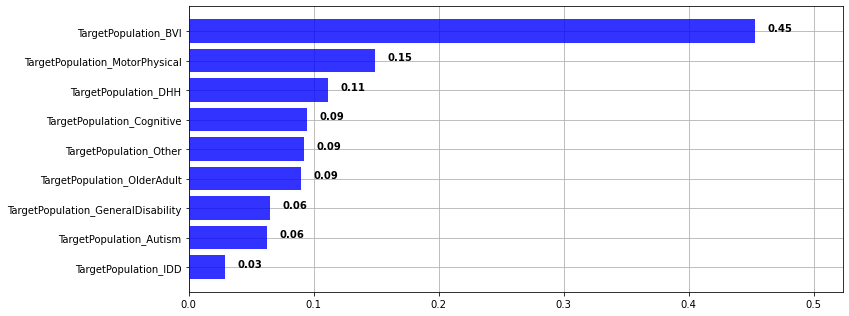

TargetPopulation  \
TargetPopulation_BVI                              BVI   
TargetPopulation_MotorPhysical          MotorPhysical   
TargetPopulation_DHH                              DHH   
TargetPopulation_Cognitive                  Cognitive   
TargetPopulation_Other                          Other   
TargetPopulation_OlderAdult                OlderAdult   
TargetPopulation_GeneralDisability  GeneralDisability   
TargetPopulation_Autism                        Autism   
TargetPopulation_IDD                              IDD   

                                    Num User-Study Papers (N=477) with Code  \
TargetPopulation_BVI                                                    216   
TargetPopulation_MotorPhysical                                           71   
TargetPopulation_DHH                                                     53   
TargetPopulation_Cognitive                                               45   
TargetPopulation_Other                                                   44   
TargetPopulation_OlderAdult                                              43   
TargetPopulation_GeneralDisability                                       31   
TargetPopulation_Autism                                                  30   
TargetPopulation_IDD                                                     14   

                                   % of User-Study Papers (N=477)  \
TargetPopulation_BVI                                        45.3%   
TargetPopulation_MotorPhysical                              14.9%   
TargetPopulation_DHH                                        11.1%   
TargetPopulation_Cognitive                                   9.4%   
TargetPopulation_Other                                       9.2%   
TargetPopulation_OlderAdult                                  9.0%   
TargetPopulation_GeneralDisability                           6.5%   
TargetPopulation_Autism                                      6.3%   
TargetPopulation_IDD                                         2.9%   

                                    Num User-Study Papers with this Code Only  \
TargetPopulation_BVI                                                      204   
TargetPopulation_MotorPhysical                                             58   
TargetPopulation_DHH                                                       39   
TargetPopulation_Cognitive                                                 28   
TargetPopulation_Other                                                     18   
TargetPopulation_OlderAdult                                                28   
TargetPopulation_GeneralDisability                                         17   
TargetPopulation_Autism                                                    20   
TargetPopulation_IDD                                                        8   

                                   % of User-Study Papers (N=477) with this Code Only  
TargetPopulation_BVI                                                            42.8%  
TargetPopulation_MotorPhysical                                                  12.2%  
TargetPopulation_DHH                                                             8.2%  
TargetPopulation_Cognitive                                                       5.9%  
TargetPopulation_Other                                                           3.8%  
TargetPopulation_OlderAdult                                                      5.9%  
TargetPopulation_GeneralDisability                                               3.6%  
TargetPopulation_Autism                                                          4.2%  
TargetPopulation_IDD                                                             1.7%



******************************* StudyMethod *******************************

Fraction of user study papers (N=477) with sub-code:

StudyMethod_Interviews              0.421384
StudyMethod_UsabilityTesting        0.417191
StudyMethod_ControlledExperiment    0.345912
StudyMethod_SurveyMethod            0.255765
StudyMethod_WorkshopDesign          0.184486
StudyMethod_FieldStudy              0.178197
StudyMethod_Other                   0.161426
StudyMethod_FocusGroups             0.058700
StudyMethod_CaseStudy               0.039832
Name: Fraction of User-Study Papers (N=477), dtype: float64


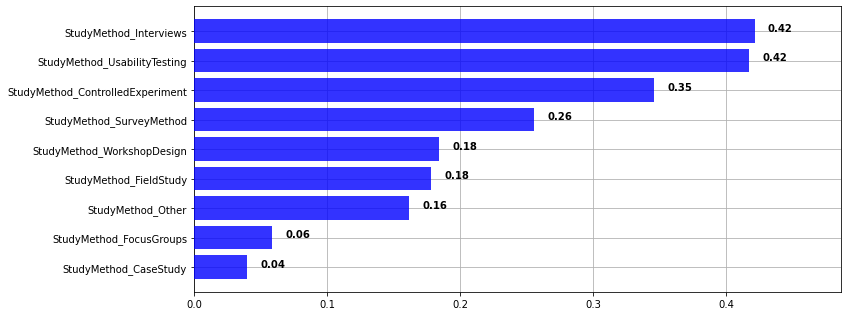

StudyMethod  \
StudyMethod_Interviews                      Interviews   
StudyMethod_UsabilityTesting          UsabilityTesting   
StudyMethod_ControlledExperiment  ControlledExperiment   
StudyMethod_SurveyMethod                  SurveyMethod   
StudyMethod_WorkshopDesign              WorkshopDesign   
StudyMethod_FieldStudy                      FieldStudy   
StudyMethod_Other                                Other   
StudyMethod_FocusGroups                    FocusGroups   
StudyMethod_CaseStudy                        CaseStudy   

                                  Num User-Study Papers (N=477) with Code  \
StudyMethod_Interviews                                                201   
StudyMethod_UsabilityTesting                                          199   
StudyMethod_ControlledExperiment                                      165   
StudyMethod_SurveyMethod                                              122   
StudyMethod_WorkshopDesign                                             88   
StudyMethod_FieldStudy                                                 85   
StudyMethod_Other                                                      77   
StudyMethod_FocusGroups                                                28   
StudyMethod_CaseStudy                                                  19   

                                 % of User-Study Papers (N=477)  \
StudyMethod_Interviews                                    42.1%   
StudyMethod_UsabilityTesting                              41.7%   
StudyMethod_ControlledExperiment                          34.6%   
StudyMethod_SurveyMethod                                  25.6%   
StudyMethod_WorkshopDesign                                18.4%   
StudyMethod_FieldStudy                                    17.8%   
StudyMethod_Other                                         16.1%   
StudyMethod_FocusGroups                                    5.9%   
StudyMethod_CaseStudy                                      4.0%   

                                  Num User-Study Papers with this Code Only  \
StudyMethod_Interviews                                                   27   
StudyMethod_UsabilityTesting                                             46   
StudyMethod_ControlledExperiment                                         55   
StudyMethod_SurveyMethod                                                  6   
StudyMethod_WorkshopDesign                                               15   
StudyMethod_FieldStudy                                                   22   
StudyMethod_Other                                                         4   
StudyMethod_FocusGroups                                                   4   
StudyMethod_CaseStudy                                                     1   

                                 % of User-Study Papers (N=477) with this Code Only  
StudyMethod_Interviews                                                         5.7%  
StudyMethod_UsabilityTesting                                                   9.6%  
StudyMethod_ControlledExperiment                                              11.5%  
StudyMethod_SurveyMethod                                                       1.3%  
StudyMethod_WorkshopDesign                                                     3.1%  
StudyMethod_FieldStudy                                                         4.6%  
StudyMethod_Other                                                              0.8%  
StudyMethod_FocusGroups                                                        0.8%  
StudyMethod_CaseStudy                                                          0.2%



******************************* ParticipatoryDesign *******************************

Fraction of user study papers (N=477) with sub-code:

ParticipatoryDesign_No     0.897275
ParticipatoryDesign_Yes    0.102725
Name: Fraction of User-Study Papers (N=477), dtype: float64


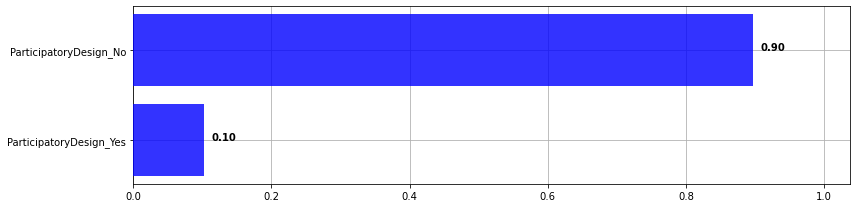

ParticipatoryDesign  \
ParticipatoryDesign_No                   No   
ParticipatoryDesign_Yes                 Yes   

                         Num User-Study Papers (N=477) with Code  \
ParticipatoryDesign_No                                       428   
ParticipatoryDesign_Yes                                       49   

                        % of User-Study Papers (N=477)  \
ParticipatoryDesign_No                           89.7%   
ParticipatoryDesign_Yes                          10.3%   

                         Num User-Study Papers with this Code Only  \
ParticipatoryDesign_No                                         428   
ParticipatoryDesign_Yes                                         49   

                        % of User-Study Papers (N=477) with this Code Only  
ParticipatoryDesign_No                                               89.7%  
ParticipatoryDesign_Yes                                              10.3%



******************************* StudyLocation *******************************

Fraction of user study papers (N=477) with sub-code:

StudyLocation_Unclear                      0.396226
StudyLocation_ParticipantsHomeOrFreqLoc    0.289308
StudyLocation_NearAtLab                    0.272537
StudyLocation_OnlineRemotely               0.205451
StudyLocation_NeutralLocation              0.067086
StudyLocation_Other                        0.014675
StudyLocation_NoUserStudy                  0.000000
Name: Fraction of User-Study Papers (N=477), dtype: float64


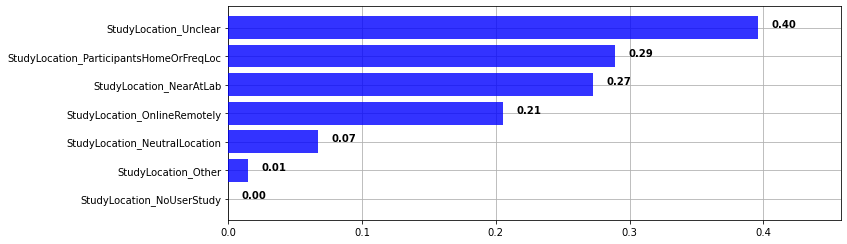

StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_Other                                          Other   
StudyLocation_NoUserStudy                              NoUserStudy   

                                         Num User-Study Papers (N=477) with Code  \
StudyLocation_Unclear                                                        189   
StudyLocation_ParticipantsHomeOrFreqLoc                                      138   
StudyLocation_NearAtLab                                                      130   
StudyLocation_OnlineRemotely                                                  98   
StudyLocation_NeutralLocation                                                 32   
StudyLocation_Other                                                            7   
StudyLocation_NoUserStudy                                                      0   

                                        % of User-Study Papers (N=477)  \
StudyLocation_Unclear                                            39.6%   
StudyLocation_ParticipantsHomeOrFreqLoc                          28.9%   
StudyLocation_NearAtLab                                          27.3%   
StudyLocation_OnlineRemotely                                     20.5%   
StudyLocation_NeutralLocation                                     6.7%   
StudyLocation_Other                                               1.5%   
StudyLocation_NoUserStudy                                         0.0%   

                                         Num User-Study Papers with this Code Only  \
StudyLocation_Unclear                                                          133   
StudyLocation_ParticipantsHomeOrFreqLoc                                         85   
StudyLocation_NearAtLab                                                         93   
StudyLocation_OnlineRemotely                                                    48   
StudyLocation_NeutralLocation                                                   15   
StudyLocation_Other                                                              1   
StudyLocation_NoUserStudy                                                        0   

                                        % of User-Study Papers (N=477) with this Code Only  
StudyLocation_Unclear                                                                27.9%  
StudyLocation_ParticipantsHomeOrFreqLoc                                              17.8%  
StudyLocation_NearAtLab                                                              19.5%  
StudyLocation_OnlineRemotely                                                         10.1%  
StudyLocation_NeutralLocation                                                         3.1%  
StudyLocation_Other                                                                   0.2%  
StudyLocation_NoUserStudy                                                             0.0%



******************************* ParticipantGroup *******************************

Fraction of user study papers (N=477) with sub-code:

ParticipantGroup_PeopleWithDisability       0.846960
ParticipantGroup_PeopleWithoutDisability    0.230608
ParticipantGroup_TherapistsSpecialists      0.169811
ParticipantGroup_Other                      0.111111
ParticipantGroup_Caregivers                 0.094340
ParticipantGroup_OlderAdult                 0.083857
ParticipantGroup_NoUserStudy                0.000000
Name: Fraction of User-Study Papers (N=477), dtype: float64


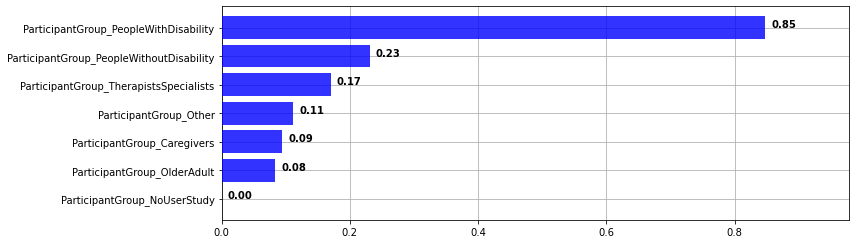

ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num User-Study Papers (N=477) with Code  \
ParticipantGroup_PeopleWithDisability                                         404   
ParticipantGroup_PeopleWithoutDisability                                      110   
ParticipantGroup_TherapistsSpecialists                                         81   
ParticipantGroup_Other                                                         53   
ParticipantGroup_Caregivers                                                    45   
ParticipantGroup_OlderAdult                                                    40   
ParticipantGroup_NoUserStudy                                                    0   

                                         % of User-Study Papers (N=477)  \
ParticipantGroup_PeopleWithDisability                             84.7%   
ParticipantGroup_PeopleWithoutDisability                          23.1%   
ParticipantGroup_TherapistsSpecialists                            17.0%   
ParticipantGroup_Other                                            11.1%   
ParticipantGroup_Caregivers                                        9.4%   
ParticipantGroup_OlderAdult                                        8.4%   
ParticipantGroup_NoUserStudy                                       0.0%   

                                          Num User-Study Papers with this Code Only  \
ParticipantGroup_PeopleWithDisability                                           214   
ParticipantGroup_PeopleWithoutDisability                                          5   
ParticipantGroup_TherapistsSpecialists                                            9   
ParticipantGroup_Other                                                           23   
ParticipantGroup_Caregivers                                                       4   
ParticipantGroup_OlderAdult                                                      15   
ParticipantGroup_NoUserStudy                                                      0   

                                         % of User-Study Papers (N=477) with this Code Only  
ParticipantGroup_PeopleWithDisability                                                 44.9%  
ParticipantGroup_PeopleWithoutDisability                                               1.0%  
ParticipantGroup_TherapistsSpecialists                                                 1.9%  
ParticipantGroup_Other                                                                 4.8%  
ParticipantGroup_Caregivers                                                            0.8%  
ParticipantGroup_OlderAdult                                                            3.1%  
ParticipantGroup_NoUserStudy                                                           0.0%



******************************* ComparesOnDisability *******************************

Fraction of user study papers (N=477) with sub-code:

ComparesOnDisability_No     0.863732
ComparesOnDisability_Yes    0.136268
Name: Fraction of User-Study Papers (N=477), dtype: float64


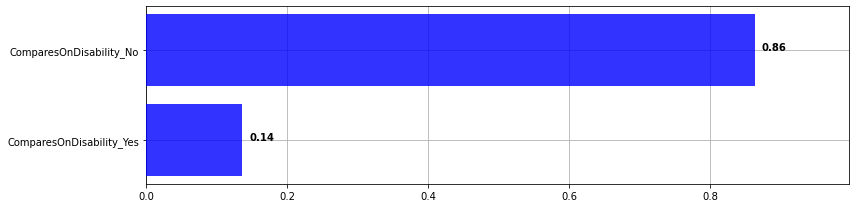

ComparesOnDisability  \
ComparesOnDisability_No                    No   
ComparesOnDisability_Yes                  Yes   

                          Num User-Study Papers (N=477) with Code  \
ComparesOnDisability_No                                       412   
ComparesOnDisability_Yes                                       65   

                         % of User-Study Papers (N=477)  \
ComparesOnDisability_No                           86.4%   
ComparesOnDisability_Yes                          13.6%   

                          Num User-Study Papers with this Code Only  \
ComparesOnDisability_No                                         412   
ComparesOnDisability_Yes                                         65   

                         % of User-Study Papers (N=477) with this Code Only  
ComparesOnDisability_No                                               86.4%  
ComparesOnDisability_Yes                                              13.6%



******************************* UsesProxies *******************************

Fraction of user study papers (N=477) with sub-code:

UsesProxies_No     0.920335
UsesProxies_Yes    0.079665
Name: Fraction of User-Study Papers (N=477), dtype: float64


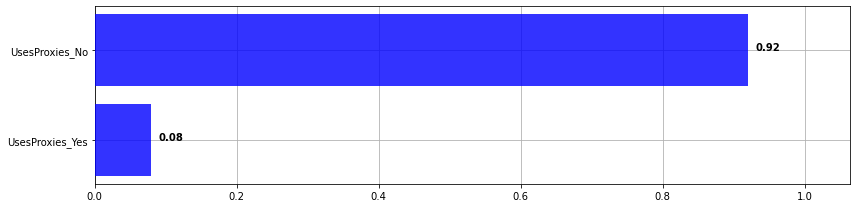

UsesProxies  Num User-Study Papers (N=477) with Code  \
UsesProxies_No           No                                      439   
UsesProxies_Yes         Yes                                       38   

                % of User-Study Papers (N=477)  \
UsesProxies_No                           92.0%   
UsesProxies_Yes                           8.0%   

                 Num User-Study Papers with this Code Only  \
UsesProxies_No                                         439   
UsesProxies_Yes                                         38   

                % of User-Study Papers (N=477) with this Code Only  
UsesProxies_No                                               92.0%  
UsesProxies_Yes                                               8.0%



******************************* TechFocus *******************************

Fraction of user study papers (N=477) with sub-code:

TechFocus_Other                         0.350105
TechFocus_SmartphoneTabletSmartwatch    0.320755
TechFocus_TangibleDeviceProsthesis      0.165618
TechFocus_WebApp                        0.119497
TechFocus_DesktopApp                    0.109015
TechFocus_PhysicallyFabricated          0.085954
TechFocus_VrArSolution                  0.083857
TechFocus_NoTechFocus                   0.069182
TechFocus_IotEnvironmentSensing         0.052411
Name: Fraction of User-Study Papers (N=477), dtype: float64


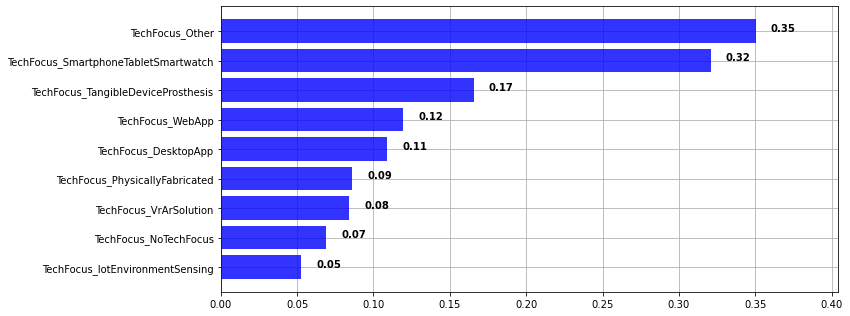

TechFocus  \
TechFocus_Other                                            Other   
TechFocus_SmartphoneTabletSmartwatch  SmartphoneTabletSmartwatch   
TechFocus_TangibleDeviceProsthesis      TangibleDeviceProsthesis   
TechFocus_WebApp                                          WebApp   
TechFocus_DesktopApp                                  DesktopApp   
TechFocus_PhysicallyFabricated              PhysicallyFabricated   
TechFocus_VrArSolution                              VrArSolution   
TechFocus_NoTechFocus                                NoTechFocus   
TechFocus_IotEnvironmentSensing            IotEnvironmentSensing   

                                      Num User-Study Papers (N=477) with Code  \
TechFocus_Other                                                           167   
TechFocus_SmartphoneTabletSmartwatch                                      153   
TechFocus_TangibleDeviceProsthesis                                         79   
TechFocus_WebApp                                                           57   
TechFocus_DesktopApp                                                       52   
TechFocus_PhysicallyFabricated                                             41   
TechFocus_VrArSolution                                                     40   
TechFocus_NoTechFocus                                                      33   
TechFocus_IotEnvironmentSensing                                            25   

                                     % of User-Study Papers (N=477)  \
TechFocus_Other                                               35.0%   
TechFocus_SmartphoneTabletSmartwatch                          32.1%   
TechFocus_TangibleDeviceProsthesis                            16.6%   
TechFocus_WebApp                                              11.9%   
TechFocus_DesktopApp                                          10.9%   
TechFocus_PhysicallyFabricated                                 8.6%   
TechFocus_VrArSolution                                         8.4%   
TechFocus_NoTechFocus                                          6.9%   
TechFocus_IotEnvironmentSensing                                5.2%   

                                      Num User-Study Papers with this Code Only  \
TechFocus_Other                                                              94   
TechFocus_SmartphoneTabletSmartwatch                                         93   
TechFocus_TangibleDeviceProsthesis                                           34   
TechFocus_WebApp                                                             28   
TechFocus_DesktopApp                                                         21   
TechFocus_PhysicallyFabricated                                               13   
TechFocus_VrArSolution                                                       20   
TechFocus_NoTechFocus                                                        32   
TechFocus_IotEnvironmentSensing                                               9   

                                     % of User-Study Papers (N=477) with this Code Only  
TechFocus_Other                                                                   19.7%  
TechFocus_SmartphoneTabletSmartwatch                                              19.5%  
TechFocus_TangibleDeviceProsthesis                                                 7.1%  
TechFocus_WebApp                                                                   5.9%  
TechFocus_DesktopApp                                                               4.4%  
TechFocus_PhysicallyFabricated                                                     2.7%  
TechFocus_VrArSolution                                                             4.2%  
TechFocus_NoTechFocus                                                              6.7%  
TechFocus_IotEnvironmentSensing                                                    1.9%



******************************* CountTechFocus *******************************

Fraction of user study papers (N=477) with sub-code:

CountTechFocus_ExcludingOther    1.006289
Name: Fraction of User-Study Papers (N=477), dtype: float64


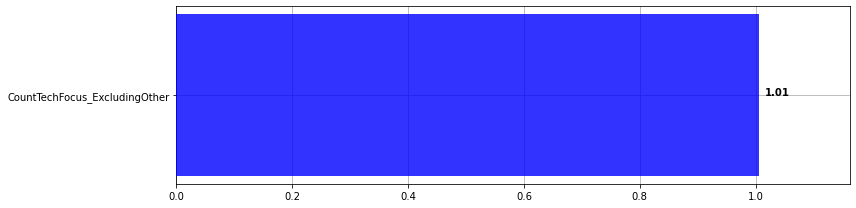

CountTechFocus  \
CountTechFocus_ExcludingOther  ExcludingOther   

                               Num User-Study Papers (N=477) with Code  \
CountTechFocus_ExcludingOther                                      480   

                              % of User-Study Papers (N=477)  \
CountTechFocus_ExcludingOther                         100.6%   

                               Num User-Study Papers with this Code Only  \
CountTechFocus_ExcludingOther                                        305   

                              % of User-Study Papers (N=477) with this Code Only  
CountTechFocus_ExcludingOther                                              63.9%



******************************* TechFocusOther *******************************

Fraction of user study papers (N=477) with sub-code:

TechFocusOther_TechAgnostic    0.132075
TechFocusOther_Algo            0.081761
TechFocusOther_General         0.071279
Name: Fraction of User-Study Papers (N=477), dtype: float64


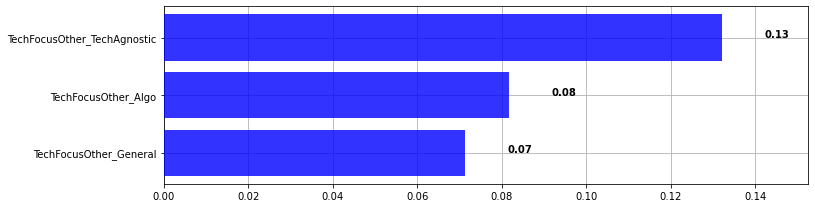

TechFocusOther  \
TechFocusOther_TechAgnostic   TechAgnostic   
TechFocusOther_Algo                   Algo   
TechFocusOther_General             General   

                             Num User-Study Papers (N=477) with Code  \
TechFocusOther_TechAgnostic                                       63   
TechFocusOther_Algo                                               39   
TechFocusOther_General                                            34   

                            % of User-Study Papers (N=477)  \
TechFocusOther_TechAgnostic                          13.2%   
TechFocusOther_Algo                                   8.2%   
TechFocusOther_General                                7.1%   

                             Num User-Study Papers with this Code Only  \
TechFocusOther_TechAgnostic                                         56   
TechFocusOther_Algo                                                 33   
TechFocusOther_General                                              33   

                            % of User-Study Papers (N=477) with this Code Only  
TechFocusOther_TechAgnostic                                              11.7%  
TechFocusOther_Algo                                                       6.9%  
TechFocusOther_General                                                    6.9%



******************************* IssueAddressed *******************************

Fraction of user study papers (N=477) with sub-code:

IssueAddressed_IncreaseDigitalAccess                        0.368973
IssueAddressed_IncreaseUnderstandingOfUsers                 0.268344
IssueAddressed_IncreasePhysicalAccess                       0.215933
IssueAddressed_IncreaseIndependence                         0.192872
IssueAddressed_SupportCommunication                         0.165618
IssueAddressed_Other                                        0.106918
IssueAddressed_HelpWithPersonalInformaticsBehaviorChange    0.081761
Name: Fraction of User-Study Papers (N=477), dtype: float64


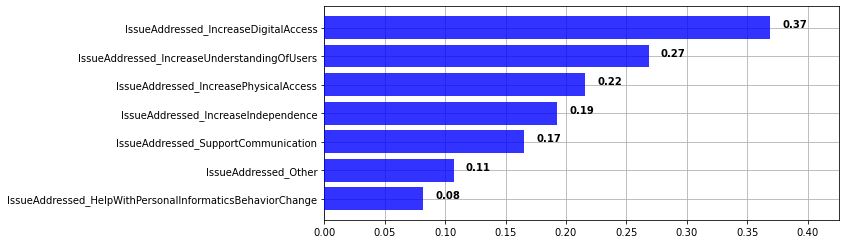

IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num User-Study Papers (N=477) with Code  \
IssueAddressed_IncreaseDigitalAccess                                                    176   
IssueAddressed_IncreaseUnderstandingOfUsers                                             128   
IssueAddressed_IncreasePhysicalAccess                                                   103   
IssueAddressed_IncreaseIndependence                                                      92   
IssueAddressed_SupportCommunication                                                      79   
IssueAddressed_Other                                                                     51   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                       39   

                                                   % of User-Study Papers (N=477)  \
IssueAddressed_IncreaseDigitalAccess                                        36.9%   
IssueAddressed_IncreaseUnderstandingOfUsers                                 26.8%   
IssueAddressed_IncreasePhysicalAccess                                       21.6%   
IssueAddressed_IncreaseIndependence                                         19.3%   
IssueAddressed_SupportCommunication                                         16.6%   
IssueAddressed_Other                                                        10.7%   
IssueAddressed_HelpWithPersonalInformaticsBehav...                           8.2%   

                                                    Num User-Study Papers with this Code Only  \
IssueAddressed_IncreaseDigitalAccess                                                      114   
IssueAddressed_IncreaseUnderstandingOfUsers                                                81   
IssueAddressed_IncreasePhysicalAccess                                                      25   
IssueAddressed_IncreaseIndependence                                                        14   
IssueAddressed_SupportCommunication                                                        43   
IssueAddressed_Other                                                                       20   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                         19   

                                                   % of User-Study Papers (N=477) with this Code Only  
IssueAddressed_IncreaseDigitalAccess                                                            23.9%  
IssueAddressed_IncreaseUnderstandingOfUsers                                                     17.0%  
IssueAddressed_IncreasePhysicalAccess                                                            5.2%  
IssueAddressed_IncreaseIndependence                                                              2.9%  
IssueAddressed_SupportCommunication                                                              9.0%  
IssueAddressed_Other                                                                             4.2%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                                               4.0%



******************************* ContributionType *******************************

Fraction of user study papers (N=477) with sub-code:

ContributionType_Empirical             0.603774
ContributionType_Artifact              0.574423
ContributionType_Theoretical           0.079665
ContributionType_Methodological        0.025157
ContributionType_Dataset               0.014675
ContributionType_SurveyContribution    0.002096
ContributionType_Other                 0.000000
ContributionType_Opinion               0.000000
Name: Fraction of User-Study Papers (N=477), dtype: float64


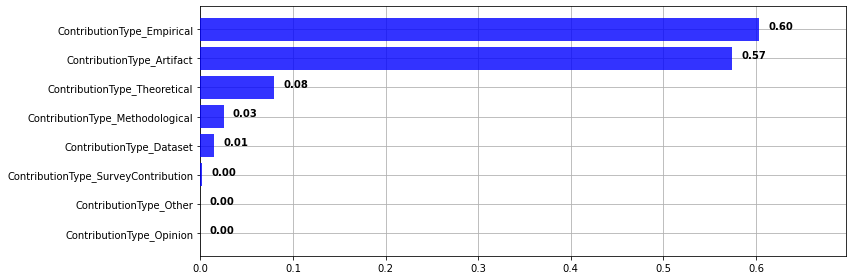

ContributionType  \
ContributionType_Empirical                    Empirical   
ContributionType_Artifact                      Artifact   
ContributionType_Theoretical                Theoretical   
ContributionType_Methodological          Methodological   
ContributionType_Dataset                        Dataset   
ContributionType_SurveyContribution  SurveyContribution   
ContributionType_Opinion                        Opinion   
ContributionType_Other                            Other   

                                     Num User-Study Papers (N=477) with Code  \
ContributionType_Empirical                                               288   
ContributionType_Artifact                                                274   
ContributionType_Theoretical                                              38   
ContributionType_Methodological                                           12   
ContributionType_Dataset                                                   7   
ContributionType_SurveyContribution                                        1   
ContributionType_Opinion                                                   0   
ContributionType_Other                                                     0   

                                    % of User-Study Papers (N=477)  \
ContributionType_Empirical                                   60.4%   
ContributionType_Artifact                                    57.4%   
ContributionType_Theoretical                                  8.0%   
ContributionType_Methodological                               2.5%   
ContributionType_Dataset                                      1.5%   
ContributionType_SurveyContribution                           0.2%   
ContributionType_Opinion                                      0.0%   
ContributionType_Other                                        0.0%   

                                     Num User-Study Papers with this Code Only  \
ContributionType_Empirical                                                 158   
ContributionType_Artifact                                                  176   
ContributionType_Theoretical                                                 3   
ContributionType_Methodological                                              2   
ContributionType_Dataset                                                     2   
ContributionType_SurveyContribution                                          0   
ContributionType_Opinion                                                     0   
ContributionType_Other                                                       0   

                                    % of User-Study Papers (N=477) with this Code Only  
ContributionType_Empirical                                                       33.1%  
ContributionType_Artifact                                                        36.9%  
ContributionType_Theoretical                                                      0.6%  
ContributionType_Methodological                                                   0.4%  
ContributionType_Dataset                                                          0.4%  
ContributionType_SurveyContribution                                               0.0%  
ContributionType_Opinion                                                          0.0%  
ContributionType_Other                                                            0.0%

In [30]:
fraction_of_user_study_papers_label = f"Fraction of User-Study Papers (N={len(df_with_user_study)})"
for code_cat, sub_codes in map_codes.items():
    
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # skip these categories
    
    col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
    df_code_table = pd.DataFrame(index=col_names)
    df_code_table[code_cat] = sub_codes
    
    map_sole_sub_code_applied_rates = calc_sole_sub_code_applied_rates(df_with_user_study, code_cat)
    sole_sub_code_series = pd.Series(map_sole_sub_code_applied_rates)
    
    print(f"\n\n******************************* {code_cat} *******************************\n")
    num_user_study_papers_lbl = f'Num User-Study Papers (N={len(df_with_user_study)}) with Code'
    df_code_table[num_user_study_papers_lbl] = df_with_user_study[col_names].sum()
    df_code_table[fraction_of_user_study_papers_label] =\
        df_with_user_study[col_names].sum() / len(df_with_user_study)
    df_code_table[f'% of User-Study Papers (N={len(df_with_user_study)})'] =\
        pd.Series(["{0:.1f}%".format(val/len(df_with_user_study) * 100) for val in df_code_table[num_user_study_papers_lbl]], 
                  index = df_code_table.index)
    
    num_user_study_papers_code_only_lbl = 'Num User-Study Papers with this Code Only'
    df_code_table[num_user_study_papers_code_only_lbl] = sole_sub_code_series
    df_code_table[f'% of User-Study Papers (N={len(df_with_user_study)}) with this Code Only'] =\
        pd.Series(["{0:.1f}%".format(val/len(df_with_user_study) * 100) for val in df_code_table[num_user_study_papers_code_only_lbl]], index = df_code_table.index)
    
    print(f"Fraction of user study papers (N={len(df_with_user_study)}) with sub-code:\n")
    print(df_code_table[fraction_of_user_study_papers_label].sort_values(ascending=False))
    plot_bar_graph_series(df_code_table[fraction_of_user_study_papers_label].sort_values(ascending=True))
    
    df_code_table = df_code_table.drop(fraction_of_user_study_papers_label, axis=1)
    display(df_code_table.sort_values(by=[num_user_study_papers_lbl], ascending=False))

### Code coverage for user-study papers

In [31]:
calc_code_coverage_across_papers(df_with_user_study)



******************************* TargetPopulation *******************************



TargetPopulation  Num Papers with Code  \
TargetPopulation_BVI                              BVI                   216   
TargetPopulation_MotorPhysical          MotorPhysical                    71   
TargetPopulation_DHH                              DHH                    53   
TargetPopulation_Cognitive                  Cognitive                    45   
TargetPopulation_Other                          Other                    44   
TargetPopulation_OlderAdult                OlderAdult                    43   
TargetPopulation_GeneralDisability  GeneralDisability                    31   
TargetPopulation_Autism                        Autism                    30   
TargetPopulation_IDD                              IDD                    14   

                                   % of Papers (N=477)  Total Papers Covered  \
TargetPopulation_BVI                             45.3%                   216   
TargetPopulation_MotorPhysical                   14.9%                   285   
TargetPopulation_DHH                             11.1%                   338   
TargetPopulation_Cognitive                        9.4%                   378   
TargetPopulation_Other                            9.2%                   400   
TargetPopulation_OlderAdult                       9.0%                   428   
TargetPopulation_GeneralDisability                6.5%                   446   
TargetPopulation_Autism                           6.3%                   469   
TargetPopulation_IDD                              2.9%                   477   

                                   % of Papers (N=477) Covered  
TargetPopulation_BVI                                     45.3%  
TargetPopulation_MotorPhysical                           59.7%  
TargetPopulation_DHH                                     70.9%  
TargetPopulation_Cognitive                               79.2%  
TargetPopulation_Other                                   83.9%  
TargetPopulation_OlderAdult                              89.7%  
TargetPopulation_GeneralDisability                       93.5%  
TargetPopulation_Autism                                  98.3%  
TargetPopulation_IDD                                    100.0%



******************************* StudyMethod *******************************



StudyMethod  Num Papers with Code  \
StudyMethod_Interviews                      Interviews                   201   
StudyMethod_UsabilityTesting          UsabilityTesting                   199   
StudyMethod_ControlledExperiment  ControlledExperiment                   165   
StudyMethod_SurveyMethod                  SurveyMethod                   122   
StudyMethod_WorkshopDesign              WorkshopDesign                    88   
StudyMethod_FieldStudy                      FieldStudy                    85   
StudyMethod_Other                                Other                    77   
StudyMethod_FocusGroups                    FocusGroups                    28   
StudyMethod_CaseStudy                        CaseStudy                    19   

                                 % of Papers (N=477)  Total Papers Covered  \
StudyMethod_Interviews                         42.1%                   201   
StudyMethod_UsabilityTesting                   41.7%                   317   
StudyMethod_ControlledExperiment               34.6%                   401   
StudyMethod_SurveyMethod                       25.6%                   416   
StudyMethod_WorkshopDesign                     18.4%                   439   
StudyMethod_FieldStudy                         17.8%                   468   
StudyMethod_Other                              16.1%                   472   
StudyMethod_FocusGroups                         5.9%                   476   
StudyMethod_CaseStudy                           4.0%                   477   

                                 % of Papers (N=477) Covered  
StudyMethod_Interviews                                 42.1%  
StudyMethod_UsabilityTesting                           66.5%  
StudyMethod_ControlledExperiment                       84.1%  
StudyMethod_SurveyMethod                               87.2%  
StudyMethod_WorkshopDesign                             92.0%  
StudyMethod_FieldStudy                                 98.1%  
StudyMethod_Other                                      99.0%  
StudyMethod_FocusGroups                                99.8%  
StudyMethod_CaseStudy                                 100.0%



******************************* ParticipatoryDesign *******************************



ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_No                   No                   428   
ParticipatoryDesign_Yes                 Yes                    49   

                        % of Papers (N=477)  Total Papers Covered  \
ParticipatoryDesign_No                89.7%                   428   
ParticipatoryDesign_Yes               10.3%                   477   

                        % of Papers (N=477) Covered  
ParticipatoryDesign_No                        89.7%  
ParticipatoryDesign_Yes                      100.0%



******************************* StudyLocation *******************************



StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_Other                                          Other   
StudyLocation_NoUserStudy                              NoUserStudy   

                                         Num Papers with Code  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   138   
StudyLocation_NearAtLab                                   130   
StudyLocation_OnlineRemotely                               98   
StudyLocation_NeutralLocation                              32   
StudyLocation_Other                                         7   
StudyLocation_NoUserStudy                                   0   

                                        % of Papers (N=477)  \
StudyLocation_Unclear                                 39.6%   
StudyLocation_ParticipantsHomeOrFreqLoc               28.9%   
StudyLocation_NearAtLab                               27.3%   
StudyLocation_OnlineRemotely                          20.5%   
StudyLocation_NeutralLocation                          6.7%   
StudyLocation_Other                                    1.5%   
StudyLocation_NoUserStudy                              0.0%   

                                         Total Papers Covered  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   308   
StudyLocation_NearAtLab                                   411   
StudyLocation_OnlineRemotely                              461   
StudyLocation_NeutralLocation                             476   
StudyLocation_Other                                       477   
StudyLocation_NoUserStudy                                 477   

                                        % of Papers (N=477) Covered  
StudyLocation_Unclear                                         39.6%  
StudyLocation_ParticipantsHomeOrFreqLoc                       64.6%  
StudyLocation_NearAtLab                                       86.2%  
StudyLocation_OnlineRemotely                                  96.6%  
StudyLocation_NeutralLocation                                 99.8%  
StudyLocation_Other                                          100.0%  
StudyLocation_NoUserStudy                                    100.0%



******************************* ParticipantGroup *******************************



ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   110   
ParticipantGroup_TherapistsSpecialists                      81   
ParticipantGroup_Other                                      53   
ParticipantGroup_Caregivers                                 45   
ParticipantGroup_OlderAdult                                 40   
ParticipantGroup_NoUserStudy                                 0   

                                         % of Papers (N=477)  \
ParticipantGroup_PeopleWithDisability                  84.7%   
ParticipantGroup_PeopleWithoutDisability               23.1%   
ParticipantGroup_TherapistsSpecialists                 17.0%   
ParticipantGroup_Other                                 11.1%   
ParticipantGroup_Caregivers                             9.4%   
ParticipantGroup_OlderAdult                             8.4%   
ParticipantGroup_NoUserStudy                            0.0%   

                                          Total Papers Covered  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   421   
ParticipantGroup_TherapistsSpecialists                     433   
ParticipantGroup_Other                                     457   
ParticipantGroup_Caregivers                                462   
ParticipantGroup_OlderAdult                                477   
ParticipantGroup_NoUserStudy                               477   

                                         % of Papers (N=477) Covered  
ParticipantGroup_PeopleWithDisability                          84.7%  
ParticipantGroup_PeopleWithoutDisability                       88.3%  
ParticipantGroup_TherapistsSpecialists                         90.8%  
ParticipantGroup_Other                                         95.8%  
ParticipantGroup_Caregivers                                    96.9%  
ParticipantGroup_OlderAdult                                   100.0%  
ParticipantGroup_NoUserStudy                                  100.0%



******************************* ComparesOnDisability *******************************



ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                   412   
ComparesOnDisability_Yes                  Yes                    65   

                         % of Papers (N=477)  Total Papers Covered  \
ComparesOnDisability_No                86.4%                   412   
ComparesOnDisability_Yes               13.6%                   477   

                         % of Papers (N=477) Covered  
ComparesOnDisability_No                        86.4%  
ComparesOnDisability_Yes                      100.0%



******************************* UsesProxies *******************************



UsesProxies  Num Papers with Code % of Papers (N=477)  \
UsesProxies_No           No                   439               92.0%   
UsesProxies_Yes         Yes                    38                8.0%   

                 Total Papers Covered % of Papers (N=477) Covered  
UsesProxies_No                    439                       92.0%  
UsesProxies_Yes                   477                      100.0%



******************************* TechFocus *******************************



TechFocus  \
TechFocus_Other                                            Other   
TechFocus_SmartphoneTabletSmartwatch  SmartphoneTabletSmartwatch   
TechFocus_TangibleDeviceProsthesis      TangibleDeviceProsthesis   
TechFocus_WebApp                                          WebApp   
TechFocus_DesktopApp                                  DesktopApp   
TechFocus_PhysicallyFabricated              PhysicallyFabricated   
TechFocus_VrArSolution                              VrArSolution   
TechFocus_NoTechFocus                                NoTechFocus   
TechFocus_IotEnvironmentSensing            IotEnvironmentSensing   

                                      Num Papers with Code  \
TechFocus_Other                                        167   
TechFocus_SmartphoneTabletSmartwatch                   153   
TechFocus_TangibleDeviceProsthesis                      79   
TechFocus_WebApp                                        57   
TechFocus_DesktopApp                                    52   
TechFocus_PhysicallyFabricated                          41   
TechFocus_VrArSolution                                  40   
TechFocus_NoTechFocus                                   33   
TechFocus_IotEnvironmentSensing                         25   

                                     % of Papers (N=477)  \
TechFocus_Other                                    35.0%   
TechFocus_SmartphoneTabletSmartwatch               32.1%   
TechFocus_TangibleDeviceProsthesis                 16.6%   
TechFocus_WebApp                                   11.9%   
TechFocus_DesktopApp                               10.9%   
TechFocus_PhysicallyFabricated                      8.6%   
TechFocus_VrArSolution                              8.4%   
TechFocus_NoTechFocus                               6.9%   
TechFocus_IotEnvironmentSensing                     5.2%   

                                      Total Papers Covered  \
TechFocus_Other                                        167   
TechFocus_SmartphoneTabletSmartwatch                   295   
TechFocus_TangibleDeviceProsthesis                     350   
TechFocus_WebApp                                       379   
TechFocus_DesktopApp                                   402   
TechFocus_PhysicallyFabricated                         415   
TechFocus_VrArSolution                                 436   
TechFocus_NoTechFocus                                  468   
TechFocus_IotEnvironmentSensing                        477   

                                     % of Papers (N=477) Covered  
TechFocus_Other                                            35.0%  
TechFocus_SmartphoneTabletSmartwatch                       61.8%  
TechFocus_TangibleDeviceProsthesis                         73.4%  
TechFocus_WebApp                                           79.5%  
TechFocus_DesktopApp                                       84.3%  
TechFocus_PhysicallyFabricated                             87.0%  
TechFocus_VrArSolution                                     91.4%  
TechFocus_NoTechFocus                                      98.1%  
TechFocus_IotEnvironmentSensing                           100.0%



******************************* CountTechFocus *******************************



CountTechFocus  Num Papers with Code  \
CountTechFocus_ExcludingOther  ExcludingOther                   480   

                              % of Papers (N=477)  Total Papers Covered  \
CountTechFocus_ExcludingOther              100.6%                   305   

                              % of Papers (N=477) Covered  
CountTechFocus_ExcludingOther                       63.9%



******************************* TechFocusOther *******************************



TechFocusOther  Num Papers with Code  \
TechFocusOther_TechAgnostic   TechAgnostic                    63   
TechFocusOther_Algo                   Algo                    39   
TechFocusOther_General             General                    34   

                            % of Papers (N=477)  Total Papers Covered  \
TechFocusOther_TechAgnostic               13.2%                    63   
TechFocusOther_Algo                        8.2%                    96   
TechFocusOther_General                     7.1%                   129   

                            % of Papers (N=477) Covered  
TechFocusOther_TechAgnostic                       13.2%  
TechFocusOther_Algo                               20.1%  
TechFocusOther_General                            27.0%



******************************* IssueAddressed *******************************



IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                                 176   
IssueAddressed_IncreaseUnderstandingOfUsers                          128   
IssueAddressed_IncreasePhysicalAccess                                103   
IssueAddressed_IncreaseIndependence                                   92   
IssueAddressed_SupportCommunication                                   79   
IssueAddressed_Other                                                  51   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    39   

                                                   % of Papers (N=477)  \
IssueAddressed_IncreaseDigitalAccess                             36.9%   
IssueAddressed_IncreaseUnderstandingOfUsers                      26.8%   
IssueAddressed_IncreasePhysicalAccess                            21.6%   
IssueAddressed_IncreaseIndependence                              19.3%   
IssueAddressed_SupportCommunication                              16.6%   
IssueAddressed_Other                                             10.7%   
IssueAddressed_HelpWithPersonalInformaticsBehav...                8.2%   

                                                    Total Papers Covered  \
IssueAddressed_IncreaseDigitalAccess                                 176   
IssueAddressed_IncreaseUnderstandingOfUsers                          281   
IssueAddressed_IncreasePhysicalAccess                                365   
IssueAddressed_IncreaseIndependence                                  386   
IssueAddressed_SupportCommunication                                  435   
IssueAddressed_Other                                                 458   
IssueAddressed_HelpWithPersonalInformaticsBehav...                   477   

                                                   % of Papers (N=477) Covered  
IssueAddressed_IncreaseDigitalAccess                                     36.9%  
IssueAddressed_IncreaseUnderstandingOfUsers                              58.9%  
IssueAddressed_IncreasePhysicalAccess                                    76.5%  
IssueAddressed_IncreaseIndependence                                      80.9%  
IssueAddressed_SupportCommunication                                      91.2%  
IssueAddressed_Other                                                     96.0%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                      100.0%



******************************* ContributionType *******************************



ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                   288   
ContributionType_Artifact                      Artifact                   274   
ContributionType_Theoretical                Theoretical                    38   
ContributionType_Methodological          Methodological                    12   
ContributionType_Dataset                        Dataset                     7   
ContributionType_SurveyContribution  SurveyContribution                     1   
ContributionType_Opinion                        Opinion                     0   
ContributionType_Other                            Other                     0   

                                    % of Papers (N=477)  Total Papers Covered  \
ContributionType_Empirical                        60.4%                   288   
ContributionType_Artifact                         57.4%                   470   
ContributionType_Theoretical                       8.0%                   473   
ContributionType_Methodological                    2.5%                   475   
ContributionType_Dataset                           1.5%                   477   
ContributionType_SurveyContribution                0.2%                   477   
ContributionType_Opinion                           0.0%                   477   
ContributionType_Other                             0.0%                   477   

                                    % of Papers (N=477) Covered  
ContributionType_Empirical                                60.4%  
ContributionType_Artifact                                 98.5%  
ContributionType_Theoretical                              99.2%  
ContributionType_Methodological                           99.6%  
ContributionType_Dataset                                 100.0%  
ContributionType_SurveyContribution                      100.0%  
ContributionType_Opinion                                 100.0%  
ContributionType_Other                                   100.0%

## Participatory-design papers only

### Code coverage for participatory-design papers

In [32]:
df_with_participatory_design = df[df['ParticipatoryDesign_Yes'] == 1]
calc_code_coverage_across_papers(df_with_participatory_design)



******************************* TargetPopulation *******************************



TargetPopulation  Num Papers with Code  \
TargetPopulation_BVI                              BVI                    16   
TargetPopulation_MotorPhysical          MotorPhysical                    11   
TargetPopulation_Cognitive                  Cognitive                    10   
TargetPopulation_Autism                        Autism                     5   
TargetPopulation_DHH                              DHH                     4   
TargetPopulation_GeneralDisability  GeneralDisability                     4   
TargetPopulation_IDD                              IDD                     3   
TargetPopulation_OlderAdult                OlderAdult                     3   
TargetPopulation_Other                          Other                     3   

                                   % of Papers (N=49)  Total Papers Covered  \
TargetPopulation_BVI                            32.7%                    16   
TargetPopulation_MotorPhysical                  22.4%                    26   
TargetPopulation_Cognitive                      20.4%                    33   
TargetPopulation_Autism                         10.2%                    37   
TargetPopulation_DHH                             8.2%                    41   
TargetPopulation_GeneralDisability               8.2%                    43   
TargetPopulation_IDD                             6.1%                    46   
TargetPopulation_OlderAdult                      6.1%                    49   
TargetPopulation_Other                           6.1%                    49   

                                   % of Papers (N=49) Covered  
TargetPopulation_BVI                                    32.7%  
TargetPopulation_MotorPhysical                          53.1%  
TargetPopulation_Cognitive                              67.3%  
TargetPopulation_Autism                                 75.5%  
TargetPopulation_DHH                                    83.7%  
TargetPopulation_GeneralDisability                      87.8%  
TargetPopulation_IDD                                    93.9%  
TargetPopulation_OlderAdult                            100.0%  
TargetPopulation_Other                                 100.0%



******************************* StudyMethod *******************************



StudyMethod  Num Papers with Code  \
StudyMethod_WorkshopDesign              WorkshopDesign                    46   
StudyMethod_Interviews                      Interviews                    23   
StudyMethod_UsabilityTesting          UsabilityTesting                    17   
StudyMethod_FieldStudy                      FieldStudy                    14   
StudyMethod_SurveyMethod                  SurveyMethod                     7   
StudyMethod_ControlledExperiment  ControlledExperiment                     6   
StudyMethod_CaseStudy                        CaseStudy                     6   
StudyMethod_Other                                Other                     6   
StudyMethod_FocusGroups                    FocusGroups                     4   

                                 % of Papers (N=49)  Total Papers Covered  \
StudyMethod_WorkshopDesign                    93.9%                    46   
StudyMethod_Interviews                        46.9%                    46   
StudyMethod_UsabilityTesting                  34.7%                    47   
StudyMethod_FieldStudy                        28.6%                    49   
StudyMethod_SurveyMethod                      14.3%                    49   
StudyMethod_ControlledExperiment              12.2%                    49   
StudyMethod_CaseStudy                         12.2%                    49   
StudyMethod_Other                             12.2%                    49   
StudyMethod_FocusGroups                        8.2%                    49   

                                 % of Papers (N=49) Covered  
StudyMethod_WorkshopDesign                            93.9%  
StudyMethod_Interviews                                93.9%  
StudyMethod_UsabilityTesting                          95.9%  
StudyMethod_FieldStudy                               100.0%  
StudyMethod_SurveyMethod                             100.0%  
StudyMethod_ControlledExperiment                     100.0%  
StudyMethod_CaseStudy                                100.0%  
StudyMethod_Other                                    100.0%  
StudyMethod_FocusGroups                              100.0%



******************************* ParticipatoryDesign *******************************



ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_Yes                 Yes                    49   
ParticipatoryDesign_No                   No                     0   

                        % of Papers (N=49)  Total Papers Covered  \
ParticipatoryDesign_Yes             100.0%                    49   
ParticipatoryDesign_No                0.0%                    49   

                        % of Papers (N=49) Covered  
ParticipatoryDesign_Yes                     100.0%  
ParticipatoryDesign_No                      100.0%



******************************* StudyLocation *******************************



StudyLocation  \
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_Unclear                                      Unclear   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_Other                                          Other   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_NoUserStudy                              NoUserStudy   

                                         Num Papers with Code  \
StudyLocation_ParticipantsHomeOrFreqLoc                    25   
StudyLocation_Unclear                                      23   
StudyLocation_NearAtLab                                    11   
StudyLocation_OnlineRemotely                                4   
StudyLocation_Other                                         4   
StudyLocation_NeutralLocation                               3   
StudyLocation_NoUserStudy                                   0   

                                        % of Papers (N=49)  \
StudyLocation_ParticipantsHomeOrFreqLoc              51.0%   
StudyLocation_Unclear                                46.9%   
StudyLocation_NearAtLab                              22.4%   
StudyLocation_OnlineRemotely                          8.2%   
StudyLocation_Other                                   8.2%   
StudyLocation_NeutralLocation                         6.1%   
StudyLocation_NoUserStudy                             0.0%   

                                         Total Papers Covered  \
StudyLocation_ParticipantsHomeOrFreqLoc                    25   
StudyLocation_Unclear                                      41   
StudyLocation_NearAtLab                                    47   
StudyLocation_OnlineRemotely                               47   
StudyLocation_Other                                        47   
StudyLocation_NeutralLocation                              49   
StudyLocation_NoUserStudy                                  49   

                                        % of Papers (N=49) Covered  
StudyLocation_ParticipantsHomeOrFreqLoc                      51.0%  
StudyLocation_Unclear                                        83.7%  
StudyLocation_NearAtLab                                      95.9%  
StudyLocation_OnlineRemotely                                 95.9%  
StudyLocation_Other                                          95.9%  
StudyLocation_NeutralLocation                               100.0%  
StudyLocation_NoUserStudy                                   100.0%



******************************* ParticipantGroup *******************************



ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_Other                                      Other   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                       44   
ParticipantGroup_TherapistsSpecialists                      20   
ParticipantGroup_Caregivers                                 10   
ParticipantGroup_PeopleWithoutDisability                     6   
ParticipantGroup_Other                                       4   
ParticipantGroup_OlderAdult                                  3   
ParticipantGroup_NoUserStudy                                 0   

                                         % of Papers (N=49)  \
ParticipantGroup_PeopleWithDisability                 89.8%   
ParticipantGroup_TherapistsSpecialists                40.8%   
ParticipantGroup_Caregivers                           20.4%   
ParticipantGroup_PeopleWithoutDisability              12.2%   
ParticipantGroup_Other                                 8.2%   
ParticipantGroup_OlderAdult                            6.1%   
ParticipantGroup_NoUserStudy                           0.0%   

                                          Total Papers Covered  \
ParticipantGroup_PeopleWithDisability                       44   
ParticipantGroup_TherapistsSpecialists                      46   
ParticipantGroup_Caregivers                                 46   
ParticipantGroup_PeopleWithoutDisability                    46   
ParticipantGroup_Other                                      46   
ParticipantGroup_OlderAdult                                 49   
ParticipantGroup_NoUserStudy                                49   

                                         % of Papers (N=49) Covered  
ParticipantGroup_PeopleWithDisability                         89.8%  
ParticipantGroup_TherapistsSpecialists                        93.9%  
ParticipantGroup_Caregivers                                   93.9%  
ParticipantGroup_PeopleWithoutDisability                      93.9%  
ParticipantGroup_Other                                        93.9%  
ParticipantGroup_OlderAdult                                  100.0%  
ParticipantGroup_NoUserStudy                                 100.0%



******************************* ComparesOnDisability *******************************



ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                    44   
ComparesOnDisability_Yes                  Yes                     5   

                         % of Papers (N=49)  Total Papers Covered  \
ComparesOnDisability_No               89.8%                    44   
ComparesOnDisability_Yes              10.2%                    49   

                         % of Papers (N=49) Covered  
ComparesOnDisability_No                       89.8%  
ComparesOnDisability_Yes                     100.0%



******************************* UsesProxies *******************************



UsesProxies  Num Papers with Code % of Papers (N=49)  \
UsesProxies_No           No                    44              89.8%   
UsesProxies_Yes         Yes                     5              10.2%   

                 Total Papers Covered % of Papers (N=49) Covered  
UsesProxies_No                     44                      89.8%  
UsesProxies_Yes                    49                     100.0%



******************************* TechFocus *******************************



TechFocus  \
TechFocus_Other                                            Other   
TechFocus_SmartphoneTabletSmartwatch  SmartphoneTabletSmartwatch   
TechFocus_TangibleDeviceProsthesis      TangibleDeviceProsthesis   
TechFocus_PhysicallyFabricated              PhysicallyFabricated   
TechFocus_VrArSolution                              VrArSolution   
TechFocus_DesktopApp                                  DesktopApp   
TechFocus_WebApp                                          WebApp   
TechFocus_NoTechFocus                                NoTechFocus   
TechFocus_IotEnvironmentSensing            IotEnvironmentSensing   

                                      Num Papers with Code % of Papers (N=49)  \
TechFocus_Other                                         17              34.7%   
TechFocus_SmartphoneTabletSmartwatch                    13              26.5%   
TechFocus_TangibleDeviceProsthesis                      10              20.4%   
TechFocus_PhysicallyFabricated                          10              20.4%   
TechFocus_VrArSolution                                   6              12.2%   
TechFocus_DesktopApp                                     4               8.2%   
TechFocus_WebApp                                         3               6.1%   
TechFocus_NoTechFocus                                    3               6.1%   
TechFocus_IotEnvironmentSensing                          2               4.1%   

                                      Total Papers Covered  \
TechFocus_Other                                         17   
TechFocus_SmartphoneTabletSmartwatch                    29   
TechFocus_TangibleDeviceProsthesis                      37   
TechFocus_PhysicallyFabricated                          41   
TechFocus_VrArSolution                                  44   
TechFocus_DesktopApp                                    45   
TechFocus_WebApp                                        46   
TechFocus_NoTechFocus                                   49   
TechFocus_IotEnvironmentSensing                         49   

                                     % of Papers (N=49) Covered  
TechFocus_Other                                           34.7%  
TechFocus_SmartphoneTabletSmartwatch                      59.2%  
TechFocus_TangibleDeviceProsthesis                        75.5%  
TechFocus_PhysicallyFabricated                            83.7%  
TechFocus_VrArSolution                                    89.8%  
TechFocus_DesktopApp                                      91.8%  
TechFocus_WebApp                                          93.9%  
TechFocus_NoTechFocus                                    100.0%  
TechFocus_IotEnvironmentSensing                          100.0%



******************************* CountTechFocus *******************************



CountTechFocus  Num Papers with Code  \
CountTechFocus_ExcludingOther  ExcludingOther                    51   

                              % of Papers (N=49)  Total Papers Covered  \
CountTechFocus_ExcludingOther             104.1%                    28   

                              % of Papers (N=49) Covered  
CountTechFocus_ExcludingOther                      57.1%



******************************* TechFocusOther *******************************



TechFocusOther  Num Papers with Code  \
TechFocusOther_General             General                     7   
TechFocusOther_TechAgnostic   TechAgnostic                     4   
TechFocusOther_Algo                   Algo                     2   

                            % of Papers (N=49)  Total Papers Covered  \
TechFocusOther_General                   14.3%                     7   
TechFocusOther_TechAgnostic               8.2%                    11   
TechFocusOther_Algo                       4.1%                    13   

                            % of Papers (N=49) Covered  
TechFocusOther_General                           14.3%  
TechFocusOther_TechAgnostic                      22.4%  
TechFocusOther_Algo                              26.5%



******************************* IssueAddressed *******************************



IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_Other                                                                    Other   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                                  14   
IssueAddressed_IncreasePhysicalAccess                                 11   
IssueAddressed_IncreaseUnderstandingOfUsers                           11   
IssueAddressed_Other                                                  11   
IssueAddressed_IncreaseIndependence                                   10   
IssueAddressed_SupportCommunication                                   10   
IssueAddressed_HelpWithPersonalInformaticsBehav...                     8   

                                                   % of Papers (N=49)  \
IssueAddressed_IncreaseDigitalAccess                            28.6%   
IssueAddressed_IncreasePhysicalAccess                           22.4%   
IssueAddressed_IncreaseUnderstandingOfUsers                     22.4%   
IssueAddressed_Other                                            22.4%   
IssueAddressed_IncreaseIndependence                             20.4%   
IssueAddressed_SupportCommunication                             20.4%   
IssueAddressed_HelpWithPersonalInformaticsBehav...              16.3%   

                                                    Total Papers Covered  \
IssueAddressed_IncreaseDigitalAccess                                  14   
IssueAddressed_IncreasePhysicalAccess                                 22   
IssueAddressed_IncreaseUnderstandingOfUsers                           32   
IssueAddressed_Other                                                  37   
IssueAddressed_IncreaseIndependence                                   42   
IssueAddressed_SupportCommunication                                   46   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    49   

                                                   % of Papers (N=49) Covered  
IssueAddressed_IncreaseDigitalAccess                                    28.6%  
IssueAddressed_IncreasePhysicalAccess                                   44.9%  
IssueAddressed_IncreaseUnderstandingOfUsers                             65.3%  
IssueAddressed_Other                                                    75.5%  
IssueAddressed_IncreaseIndependence                                     85.7%  
IssueAddressed_SupportCommunication                                     93.9%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                     100.0%



******************************* ContributionType *******************************



ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                    30   
ContributionType_Artifact                      Artifact                    30   
ContributionType_Theoretical                Theoretical                     6   
ContributionType_Methodological          Methodological                     4   
ContributionType_Dataset                        Dataset                     0   
ContributionType_SurveyContribution  SurveyContribution                     0   
ContributionType_Opinion                        Opinion                     0   
ContributionType_Other                            Other                     0   

                                    % of Papers (N=49)  Total Papers Covered  \
ContributionType_Empirical                       61.2%                    30   
ContributionType_Artifact                        61.2%                    47   
ContributionType_Theoretical                     12.2%                    48   
ContributionType_Methodological                   8.2%                    49   
ContributionType_Dataset                          0.0%                    49   
ContributionType_SurveyContribution               0.0%                    49   
ContributionType_Opinion                          0.0%                    49   
ContributionType_Other                            0.0%                    49   

                                    % of Papers (N=49) Covered  
ContributionType_Empirical                               61.2%  
ContributionType_Artifact                                95.9%  
ContributionType_Theoretical                             98.0%  
ContributionType_Methodological                         100.0%  
ContributionType_Dataset                                100.0%  
ContributionType_SurveyContribution                     100.0%  
ContributionType_Opinion                                100.0%  
ContributionType_Other                                  100.0%

# Num Participant Analysis
This analysis is only for user-study papers

## Utility functions

In [33]:
def analyze_num_participant_data(df_pdata):
    df_diff = pd.concat([df_with_user_study, df_pdata]).drop_duplicates(keep=False)
    print(f"Removed {len(df_diff)} outlier(s) ({len(df_diff)/len(df_with_user_study)*100:.1f}% of {len(df_with_user_study)})")
    display(df_diff[['Index', 'Author', 'Title', 'DOI']])

    print(f"Descriptive stats for paper dataset (N={len(df_pdata)})")
    print(df_pdata["Total num Participants"].describe())

    print()
    print(f"Box plot of participants for {len(df_pdata)} papers")
    plt.figure(figsize=(15,5))
    sns.boxplot(x=df_pdata["Total num Participants"])
    plt.show()
    
    print()
    print(f"Histogram of participants for {len(df_pdata)} papers")
    sns.displot(data=df_pdata, x="Total num Participants")
    plt.show()
    
    df_pdata_subset = df_pdata[df_pdata["Total num Participants"] <= 200]
    print()
    print(f"Histogram with num_participants <= 200 (N={len(df_pdata_subset)})")
    sns.displot(data=df_pdata_subset, x="Total num Participants", kde=True)
    plt.show()

## Overall number of participants

In [34]:
print("The 50 percentile is the same as median:")
display(df_with_user_study["Total num Participants"].describe())

quantile75 = df_with_user_study["Total num Participants"].quantile(0.75)
quantile25 = df_with_user_study["Total num Participants"].quantile(0.25)
print(f"IQR: {quantile75 - quantile25}")

The 50 percentile is the same as median:


count       477.000000
mean        830.062893
std       16140.267082
min           0.000000
25%          11.000000
50%          18.000000
75%          40.000000
max      352363.000000
Name: Total num Participants, dtype: float64

IQR: 29.0


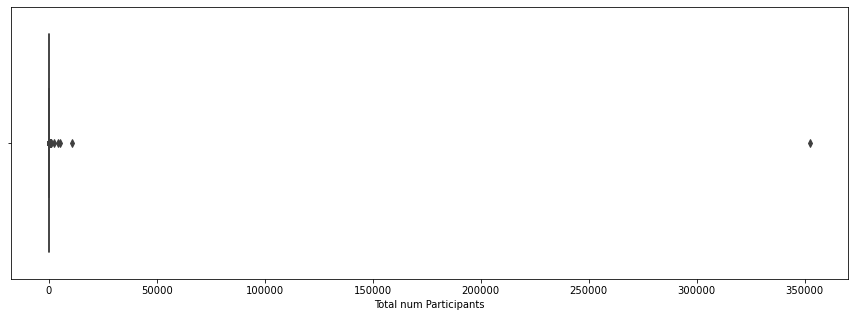

In [35]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df_with_user_study["Total num Participants"]);

Removed 1 outlier(s) (0.2% of 477)


Index                                           Author  \
132    133  Qisheng Li, Krzysztof Gajos, Katharina Reinecke   

                                                 Title  \
132  Volunteer-Based Online Studies With Older Adul...   

                         DOI  
132  10.1145/3234695.3236360

Descriptive stats for paper dataset (N=476)
count      476.000000
mean        91.548319
std        592.755130
min          0.000000
25%         11.000000
50%         18.000000
75%         39.250000
max      10721.000000
Name: Total num Participants, dtype: float64

Box plot of participants for 476 papers


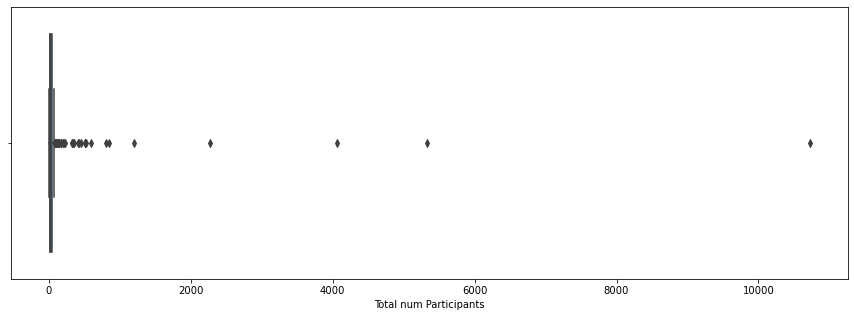


Histogram of participants for 476 papers


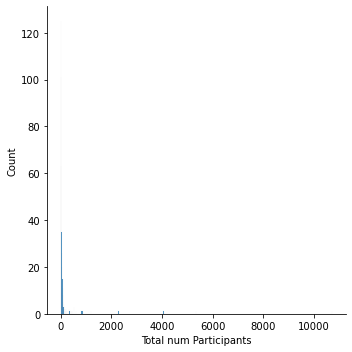


Histogram with num_participants <= 200 (N=456)


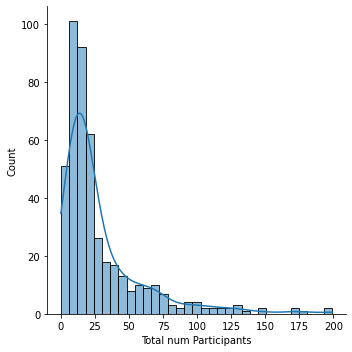

In [36]:
df_user_studies_sans_outliers = df_with_user_study[df_with_user_study["Total num Participants"] < 50000]

analyze_num_participant_data(df_user_studies_sans_outliers)

Num participant analysis without crowdworker papers:
Removed 15 outlier(s) (3.1% of 477)


Index                                             Author  \
12      13                     Walter Lasecki, Jeffrey Bigham   
45      46  Raymond Fok, Harmanpreet Kaur, Skanda Palani, ...   
61      62            Jeffrey Bigham, Irene Lin, Saiph Savage   
132    133    Qisheng Li, Krzysztof Gajos, Katharina Reinecke   
144    145  Abigale Stangl, Esha Kothari, Suyog Jain, Tom ...   
223    224                     Prathik Gadde, Davide Bolchini   
300    301  Xiaojuan Ma and Christiane Fellbaum and Perry ...   
313    314  Yu Zhong, Walter Lasecki, Erin Brady, Jeffrey ...   
348    349  Walter Lasecki, Phyo Thiha, Yu Zhong, Erin Bra...   
354    355         Kotaro Hara and Vicki Le and Jon Froehlich   
389    390  Halley Profita and Reem Albaghli and Leah Find...   
469    470                         Edward Kim, Kathleen McCoy   
478    479  Mohit Jain, Rohun Tripathi, Ishita Bhansali, P...   
491    492  Manaswi Saha and Michael Saugstad and Hanuma T...   
501    502  Kotaro Hara, Shiri Azenkot, Megan Campbell, Cy...   

                                                 Title  \
12   Online quality control for real-time crowd cap...   
45   Towards More Robust Speech Interactions for De...   
61   The Effects of "Not Knowing What You Don't Kno...   
132  Volunteer-Based Online Studies With Older Adul...   
144  BrowseWithMe An Online Clothes Shopping Assist...   
223  From screen reading to aural glancing towards ...   
300  SoundNet investigating a language composed of ...   
313  RegionSpeak Quick Comprehensive Spatial Descri...   
348  Answering visual questions with conversational...   
354  Combining crowdsourcing and google street view...   
389  The AT Effect How Disability Affects the Perce...   
469  Multimodal Deep Learning using Images and Text...   
478  Automatic Generation and Evaluation of Usable ...   
491  Project Sidewalk A Web-based Crowdsourcing Too...   
501  Improving public transit accessibility for bli...   

                         DOI  
12   10.1145/2384916.2384942  
45   10.1145/3234695.3236343  
61   10.1145/3132525.3132533  
132  10.1145/3234695.3236360  
144  10.1145/3234695.3236337  
223  10.1145/2661334.2661363  
300  10.1145/1753326.1753620  
313  10.1145/2702123.2702437  
348  10.1145/2513383.2517033  
354  10.1145/2470654.2470744  
389  10.1145/2858036.2858130  
469  10.1145/3234695.3236357  
478  10.1145/3308561.3353777  
491  10.1145/3290605.3300292  
501  10.1145/2513383.2513448

Descriptive stats for paper dataset (N=462)
count      462.00000
mean        82.04329
std        589.29712
min          0.00000
25%         11.00000
50%         18.00000
75%         36.00000
max      10721.00000
Name: Total num Participants, dtype: float64

Box plot of participants for 462 papers


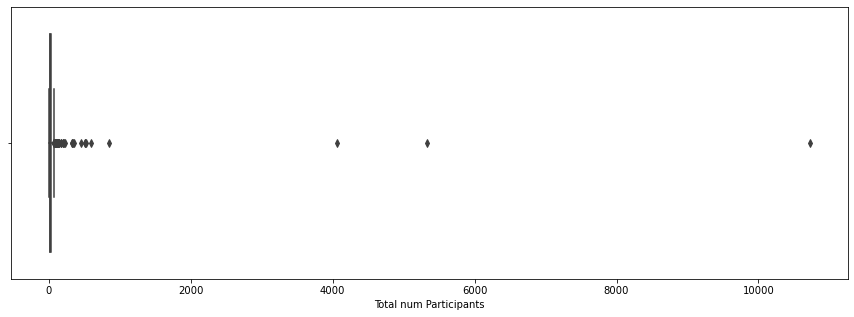


Histogram of participants for 462 papers


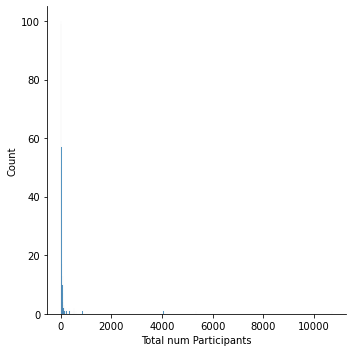


Histogram with num_participants <= 200 (N=447)


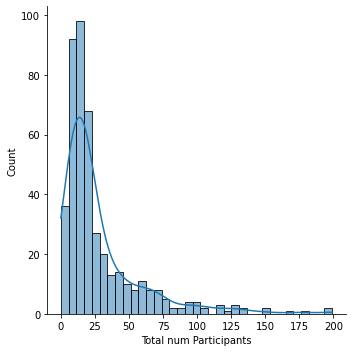

In [37]:
df_user_studies_sans_crowdworkers = df_with_user_study[df_with_user_study['ParticipantGroup_Other_Crowdworker'] != 1]
print("Num participant analysis without crowdworker papers:")
analyze_num_participant_data(df_user_studies_sans_crowdworkers)

## Analysis by participant group

In [38]:
# Determine what population group codes exist
map_population_groups = dict()
for index, row in df_with_user_study.iterrows():
    for numparticipant_group_population_col in numparticipant_group_population_cols:
        if row[numparticipant_group_population_col] != 0:
            population_code = row[numparticipant_group_population_col]
            if population_code not in map_population_groups:
                map_population_groups[population_code] = 0
            map_population_groups[population_code] = map_population_groups[population_code] + 1
            
print(f'Found {len(map_population_groups)} population groups')

df_map_population_groups = pd.DataFrame.from_dict(map_population_groups, orient='index', columns=['Num Papers'])

display(df_map_population_groups.sort_values(by='Num Papers', ascending=False))

population_groups = list(map_population_groups.keys())

Found 36 population groups


Num Papers
BVI                                                        209
NonDisabled                                                109
Motor/Physical                                              61
Specialists                                                 49
Caregivers                                                  45
DHH                                                         37
Older Adult NonDisabled                                     29
Cognitive                                                   29
Autism                                                      25
Teachers                                                    24
Other                                                       19
Crowdworkers                                                15
Therapists                                                  14
Other-Disabled                                              13
Older Adult Disabled                                        11
Other-Signers                                               10
IDD                                                         10
Other-CVD                                                    7
General DA                                                   5
Other-Mental health                                          3
Other-Developers                                             2
Other-Visual and/or motor                                    1
Other-ASL students                                           1
Other-Administrators                                         1
Other-Designers/developers                                   1
Other-Students, technology instructor                        1
Other-Students with web accessibility knowledge              1
Other-Special education students with multiple ...           1
Specialists/Teachers                                         1
Unclear                                                      1
Other-Engineers or interaction designers                     1
Other-Children                                               1
Other-Garden show employees                                  1
Older Adult                                                  1
Other-Family members                                         1
Other-Students, teachers                                     1

In [39]:
# Create a Pandas table of papers with participant groups
additional_metadata_cols = (['Index', 'Title', 'Author', 'DOI'])
set_additional_metadata_cols = set(additional_metadata_cols)
participant_cnt_cols = additional_metadata_cols + population_groups
df_participant_counts = pd.DataFrame(columns=participant_cnt_cols)

numparticipant_group_count_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Count" in col]
numparticipant_group_population_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Population" in col]
unclear_cnt = 0
for index, row in df_with_user_study.iterrows():
    map_participant_row = dict.fromkeys(participant_cnt_cols, None)
    for numparticipant_group_population_col in numparticipant_group_population_cols:
        if row[numparticipant_group_population_col] != 0:
            population_code = row[numparticipant_group_population_col]
          
            num_participant_count_col = numparticipant_group_population_col.replace('_Population', '_Count')
            
            num_participant_for_this_population = row[num_participant_count_col]
            
            if str(num_participant_for_this_population).lower() != 'unclear':   
                #print(numparticipant_group_population_col, population_code, num_participant_count_col, num_participant_for_this_population)
                map_participant_row[population_code] = (num_participant_for_this_population)
            else:
                unclear_cnt += 1
    
    map_participant_row['Index'] = row['Index']
    map_participant_row['Title'] = row['Title']
    map_participant_row['Author'] = row['Author']
    map_participant_row['DOI'] = row['DOI']
    df_participant_counts = df_participant_counts.append(map_participant_row, ignore_index=True)

# make sure all the population count columns are numeric
df_participant_counts[population_groups] = df_participant_counts[population_groups].apply(pd.to_numeric)

In [40]:
display(df_participant_counts)

Index                                              Title  \
0       1  The Tactile Graphics Helper Providing Audio Cl...   
1       2  "Occupational Therapy is Making": Clinical Rap...   
2       3  Evaluating quality and comprehension of real-t...   
3       4  LucentMaps 3D Printed Audiovisual Tactile Maps...   
4       5  Understanding and Designing for Deaf or Hard o...   
..    ...                                                ...   
472   502  Improving public transit accessibility for bli...   
473   503  "Is Someone There? Do They Have a Gun" How Vis...   
474   504  Incorporating Social Factors in Accessible Des...   
475   505  Voice Telephony for Individuals with Hearing L...   
476   506  Gesture-based Interaction for Individuals with...   

                                                Author  \
0                       Giovanni Fusco, Valerie Morash   
1    Megan Hofmann and Kristin Williams and Toni Ka...   
2    Jessica Tran, Joy Kim, Jaehong Chon, Eve Riski...   
3                                      Timo Götzelmann   
4    Sooyeon Lee and Bjorn Hubert-Wallander and Mol...   
..                                                 ...   
472  Kotaro Hara, Shiri Azenkot, Megan Campbell, Cy...   
473  Stacy Branham, Ali Abdolrahmani, William Easle...   
474     Kristen Shinohara, Jacob Wobbrock, Wanda Pratt   
475  Linda Kozma-Spytek, Paula Tucker, Christian Vo...   
476  Sumita Sharma, Saurabh Srivastava, Krishnaveni...   

                         DOI  Specialists   BVI  NonDisabled  Other-Signers  \
0    10.1145/2700648.2809868          2.0   3.0          NaN            NaN   
1    10.1145/3290605.3300544          4.0   NaN          NaN            NaN   
2    10.1145/2049536.2049558          NaN   NaN         39.0           56.0   
3    10.1145/2982142.2982163          NaN   9.0          NaN            NaN   
4    10.1145/3290605.3300759          NaN   NaN          NaN            NaN   
..                       ...          ...   ...          ...            ...   
472  10.1145/2513383.2513448          NaN  18.0          NaN            NaN   
473  10.1145/3132525.3132534          NaN  68.0          NaN            NaN   
474  10.1145/3234695.3236346          NaN   5.0          5.0            NaN   
475  10.1145/3308561.3353796          NaN   NaN         12.0            NaN   
476  10.1145/2982142.2982166          NaN   NaN          NaN            NaN   

       DHH  Other-Students with web accessibility knowledge  ...  General DA  \
0      NaN                                              NaN  ...         NaN   
1      NaN                                              NaN  ...         NaN   
2      NaN                                              NaN  ...         NaN   
3      NaN                                              NaN  ...         NaN   
4      5.0                                              NaN  ...         NaN   
..     ...                                              ...  ...         ...   
472    NaN                                              NaN  ...         NaN   
473    NaN                                              NaN  ...         NaN   
474    NaN                                              NaN  ...         NaN   
475  114.0                                              NaN  ...         NaN   
476    NaN                                              NaN  ...         NaN   

     Other-Special education students with multiple learning challenges  \
0                                                  NaN                    
1                                                  NaN                    
2                                                  NaN                    
3                                                  NaN                    
4                                                  NaN                    
..                                                 ...                    
472                                                NaN                    
473                         

In [41]:
pd.options.display.float_format = '{:.2f}'.format
display(df_participant_counts.describe())
pd.options.display.float_format = None

Specialists     BVI  NonDisabled  Other-Signers    DHH  \
count        44.00  208.00       105.00          10.00  35.00   
mean         14.93   88.79        97.77          53.90  44.46   
std          21.15  633.09       440.42          64.09  54.68   
min           1.00    1.00         2.00          11.00   1.00   
25%           3.00    8.00         9.00          18.50  10.50   
50%           5.50   13.00        16.00          23.50  28.00   
75%          12.25   20.00        35.00          48.50  52.00   
max          80.00 7398.00      3323.00         195.00 284.00   

       Other-Students with web accessibility knowledge  \
count                                             1.00   
mean                                              4.00   
std                                                nan   
min                                               4.00   
25%                                               4.00   
50%                                               4.00   
75%                                               4.00   
max                                               4.00   

       Older Adult NonDisabled  Caregivers  Cognitive  Teachers  ...  \
count                    28.00       34.00      29.00     17.00  ...   
mean                     39.64       11.00      40.34     12.41  ...   
std                      94.89       11.05      74.28     12.98  ...   
min                       4.00        1.00       3.00      1.00  ...   
25%                      12.00        4.00       6.00      2.00  ...   
50%                      20.00        7.50      16.00      7.00  ...   
75%                      35.25       12.75      39.00     20.00  ...   
max                     519.00       43.00     328.00     38.00  ...   

       General DA  \
count        4.00   
mean        24.00   
std         22.02   
min          3.00   
25%         14.25   
50%         19.00   
75%         28.75   
max         55.00   

       Other-Special education students with multiple learning challenges  \
count                                               1.00                    
mean                                                6.00                    
std                                                  nan                    
min                                                 6.00                    
25%                                                 6.00                    
50%                                                 6.00                    
75%                                                 6.00                    
max                                                 6.00                    

       Specialists/Teachers  Unclear  \
count                  1.00     1.00   
mean                   9.00    52.00   
std                     nan      nan   
min                    9.00    52.00   
25%                    9.00    52.00   
50%                    9.00    52.00   
75%                    9.00    52.00   
max                    9.00    52.00   

       Other-Engineers or interaction designers  Other-Children  \
count                                      1.00            0.00   
mean                                       7.00             nan   
std                                         nan             nan   
min                                        7.00             nan   
25%                                        7.00             nan   
50%                                        7.00             nan   
75%                                        7.00             nan   
max                                        7.00             nan   

       Other-Garden show employees  Older Adult  Other-Family members  \
count                         1.00         1.00                  1.00   
mean                          4.00        14.00                  6.00   
std                            nan          nan                   nan   
min                           4.00        14.00                  6.00   
25%                           4.00 

## Analysis by consolidated participant group

In [42]:
# create higher-level participant group groupings
set_population_groups = set(population_groups)
other_cols = [col for col in set_population_groups if "Other" in col or "Unclear" in col]
set_population_groups = (set_population_groups - set(other_cols))
older_adult_cols = [col for col in set_population_groups if "Adult" in col]
set_population_groups = (set_population_groups - set(older_adult_cols))
specialist_cols = [col for col in set_population_groups if "Teacher" in col or
                                                           "Therapist" in col or
                                                           "Specialist" in col]
set_population_groups = (set_population_groups - set(specialist_cols))

print(f"{len(other_cols)} 'Other' columns:")
print(other_cols)
print()
print(f"{len(older_adult_cols)} 'Adult' columns:")
print(older_adult_cols)
print()
print(f"{len(specialist_cols)} 'Teacher, Therapist, Specialist' columns:")
print(specialist_cols)
print()
print(f"We have {len(set_population_groups)} remaining groups:")
print(set_population_groups)

19 'Other' columns:
['Other-Developers', 'Other-Family members', 'Other-Designers/developers', 'Other-Signers', 'Other-Students with web accessibility knowledge', 'Other', 'Other-Students, technology instructor', 'Other-CVD', 'Other-Administrators', 'Other-Mental health', 'Other-Engineers or interaction designers', 'Other-Garden show employees', 'Other-Special education students with multiple learning challenges', 'Other-Visual and/or motor', 'Other-Students, teachers', 'Unclear', 'Other-Disabled', 'Other-ASL students', 'Other-Children']

3 'Adult' columns:
['Older Adult Disabled', 'Older Adult NonDisabled', 'Older Adult']

4 'Teacher, Therapist, Specialist' columns:
['Specialists', 'Specialists/Teachers', 'Teachers', 'Therapists']

We have 10 remaining groups:
{'BVI', 'Cognitive', 'Caregivers', 'NonDisabled', 'General DA', 'IDD', 'DHH', 'Autism', 'Crowdworkers', 'Motor/Physical'}


In [43]:
# Now condense the number of participant groups into the following categories
df_participant_cnts_consolidated = df_participant_counts.copy(deep=True)

df_participant_cnts_consolidated['Combined Other'] = df_participant_counts[other_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated['Combined Other'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated['Combined Adult'] = df_participant_counts[older_adult_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated['Combined Adult'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated['Combined Specialist'] = df_participant_counts[specialist_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated['Combined Specialist'].replace(0, np.nan, inplace=True)

df_participant_cnts_consolidated.drop(other_cols, axis=1, inplace=True)
df_participant_cnts_consolidated.drop(older_adult_cols, axis=1, inplace=True)
df_participant_cnts_consolidated.drop(specialist_cols, axis=1, inplace=True)

pd.options.display.float_format = '{:.1f}'.format
display(df_participant_cnts_consolidated.describe())
pd.options.display.float_format = None

BVI  NonDisabled   DHH  Caregivers  Cognitive  IDD  Crowdworkers  \
count  208.0        105.0  35.0        34.0       29.0 10.0          13.0   
mean    88.8         97.8  44.5        11.0       40.3 16.4       27500.0   
std    633.1        440.4  54.7        11.1       74.3 13.0       97490.3   
min      1.0          2.0   1.0         1.0        3.0  2.0          15.0   
25%      8.0          9.0  10.5         4.0        6.0 10.0          42.0   
50%     13.0         16.0  28.0         7.5       16.0 11.5         153.0   
75%     20.0         35.0  52.0        12.8       39.0 20.2         797.0   
max   7398.0       3323.0 284.0        43.0      328.0 48.0      351960.0   

       Motor/Physical  Autism  General DA  Combined Other  Combined Adult  \
count            61.0    23.0         4.0            61.0            38.0   
mean             15.3    12.9        24.0            47.3            32.8   
std              17.9    16.6        22.0           103.3            82.5   
min               1.0     2.0         3.0             1.0             2.0   
25%               5.0     5.5        14.2             6.0             8.5   
50%              10.0     9.0        19.0            11.0            15.0   
75%              16.0    10.5        28.8            28.0            26.8   
max             102.0    75.0        55.0           566.0           519.0   

       Combined Specialist  
count                 69.0  
mean                  14.2  
std                   18.3  
min                    1.0  
25%                    3.0  
50%                    7.0  
75%                   14.0  
max                   80.0

In [44]:
# Calculate stats for paper
for col in df_participant_cnts_consolidated.columns:
    if col not in set_additional_metadata_cols:
        s = df_participant_cnts_consolidated[col]
        quantile75 = s.quantile(0.75)
        quantile25 = s.quantile(0.25)
        print(f"{col} (N={s.count()}): Median: {s.median()} Mean: {s.mean():.1f}"
              f" Stdev: {s.std():.1f} IQR: {quantile75 - quantile25} Range: {s.min()} - {s.max()}")

BVI (N=208): Median: 13.0 Mean: 88.8 Stdev: 633.1 IQR: 12.0 Range: 1.0 - 7398.0
NonDisabled (N=105): Median: 16.0 Mean: 97.8 Stdev: 440.4 IQR: 26.0 Range: 2.0 - 3323.0
DHH (N=35): Median: 28.0 Mean: 44.5 Stdev: 54.7 IQR: 41.5 Range: 1.0 - 284.0
Caregivers (N=34): Median: 7.5 Mean: 11.0 Stdev: 11.1 IQR: 8.75 Range: 1.0 - 43.0
Cognitive (N=29): Median: 16.0 Mean: 40.3 Stdev: 74.3 IQR: 33.0 Range: 3.0 - 328.0
IDD (N=10): Median: 11.5 Mean: 16.4 Stdev: 13.0 IQR: 10.25 Range: 2.0 - 48.0
Crowdworkers (N=13): Median: 153.0 Mean: 27500.0 Stdev: 97490.3 IQR: 755.0 Range: 15.0 - 351960.0
Motor/Physical (N=61): Median: 10.0 Mean: 15.3 Stdev: 17.9 IQR: 11.0 Range: 1.0 - 102.0
Autism (N=23): Median: 9.0 Mean: 12.9 Stdev: 16.6 IQR: 5.0 Range: 2.0 - 75.0
General DA (N=4): Median: 19.0 Mean: 24.0 Stdev: 22.0 IQR: 14.5 Range: 3.0 - 55.0
Combined Other (N=61): Median: 11.0 Mean: 47.3 Stdev: 103.3 IQR: 22.0 Range: 1.0 - 566.0
Combined Adult (N=38): Median: 15.0 Mean: 32.8 Stdev: 82.5 IQR: 18.25 Range: 2.

<AxesSubplot:>

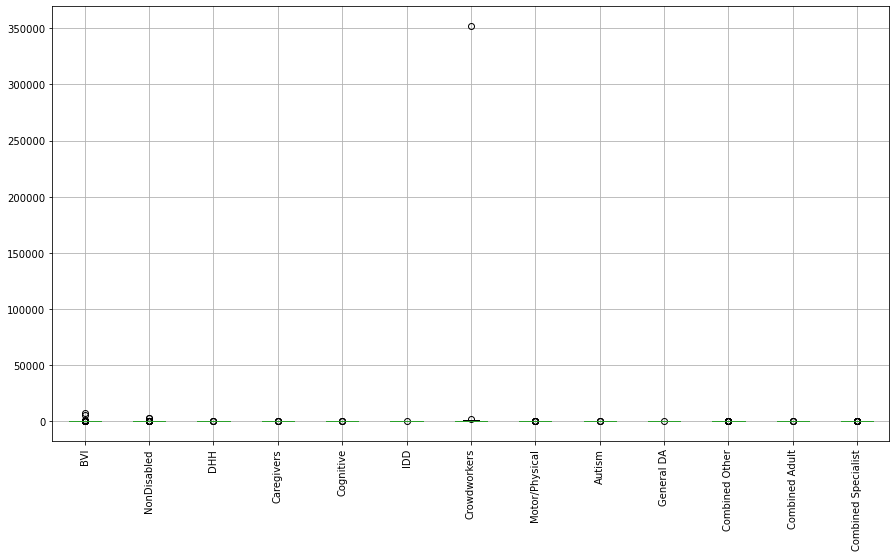

In [45]:
df_participant_cnts_consolidated.boxplot(figsize=(15,8),rot=90)

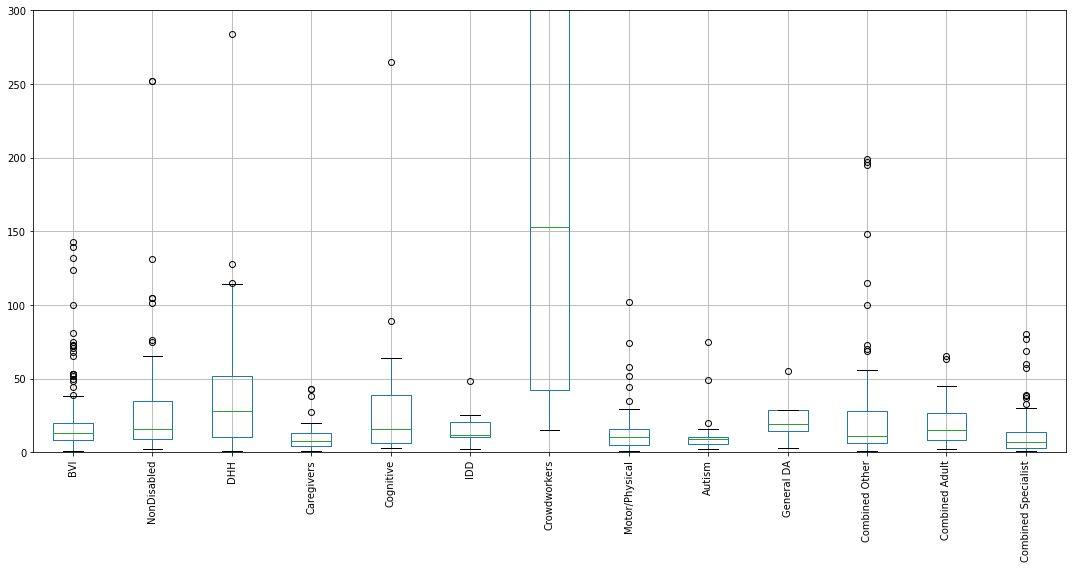

In [46]:
fig, ax = plt.subplots(1, figsize=(15,8))
df_participant_cnts_consolidated.boxplot(ax=ax, rot=90)
ax.set_ylim(0, 300) # zoom in
plt.tight_layout()

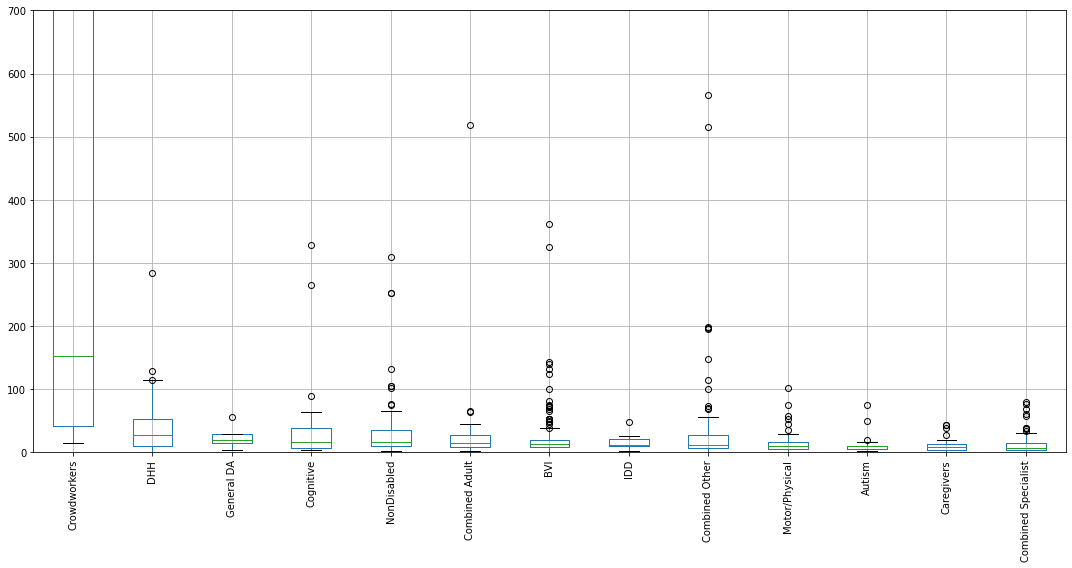

In [47]:
med = df_participant_cnts_consolidated.median()
med = med.sort_values(ascending=False)
sorted_df = df_participant_cnts_consolidated[med.index]
#display(sorted_df)

fig, ax = plt.subplots(1, figsize=(15,8))
sorted_df.boxplot(ax=ax, rot=90)
ax.set_ylim(0, 700) # zoom in
plt.tight_layout()

In [48]:
display(df_participant_cnts_consolidated)

Index                                              Title  \
0       1  The Tactile Graphics Helper Providing Audio Cl...   
1       2  "Occupational Therapy is Making": Clinical Rap...   
2       3  Evaluating quality and comprehension of real-t...   
3       4  LucentMaps 3D Printed Audiovisual Tactile Maps...   
4       5  Understanding and Designing for Deaf or Hard o...   
..    ...                                                ...   
472   502  Improving public transit accessibility for bli...   
473   503  "Is Someone There? Do They Have a Gun" How Vis...   
474   504  Incorporating Social Factors in Accessible Des...   
475   505  Voice Telephony for Individuals with Hearing L...   
476   506  Gesture-based Interaction for Individuals with...   

                                                Author  \
0                       Giovanni Fusco, Valerie Morash   
1    Megan Hofmann and Kristin Williams and Toni Ka...   
2    Jessica Tran, Joy Kim, Jaehong Chon, Eve Riski...   
3                                      Timo Götzelmann   
4    Sooyeon Lee and Bjorn Hubert-Wallander and Mol...   
..                                                 ...   
472  Kotaro Hara, Shiri Azenkot, Megan Campbell, Cy...   
473  Stacy Branham, Ali Abdolrahmani, William Easle...   
474     Kristen Shinohara, Jacob Wobbrock, Wanda Pratt   
475  Linda Kozma-Spytek, Paula Tucker, Christian Vo...   
476  Sumita Sharma, Saurabh Srivastava, Krishnaveni...   

                         DOI   BVI  NonDisabled    DHH  Caregivers  Cognitive  \
0    10.1145/2700648.2809868   3.0          NaN    NaN         NaN        NaN   
1    10.1145/3290605.3300544   NaN          NaN    NaN         NaN        NaN   
2    10.1145/2049536.2049558   NaN         39.0    NaN         NaN        NaN   
3    10.1145/2982142.2982163   9.0          NaN    NaN         NaN        NaN   
4    10.1145/3290605.3300759   NaN          NaN    5.0         NaN        NaN   
..                       ...   ...          ...    ...         ...        ...   
472  10.1145/2513383.2513448  18.0          NaN    NaN         NaN        NaN   
473  10.1145/3132525.3132534  68.0          NaN    NaN         NaN        NaN   
474  10.1145/3234695.3236346   5.0          5.0    NaN         NaN        NaN   
475  10.1145/3308561.3353796   NaN         12.0  114.0         NaN        NaN   
476  10.1145/2982142.2982166   NaN          NaN    NaN         NaN        NaN   

      IDD  Crowdworkers  Motor/Physical  Autism  General DA  Combined Other  \
0     NaN           NaN             NaN     NaN         NaN             NaN   
1     NaN           NaN             NaN     NaN         NaN             NaN   
2     NaN           NaN             NaN     NaN         NaN            56.0   
3     NaN           NaN             NaN     NaN         NaN             NaN   
4     NaN           NaN             NaN     NaN         NaN             NaN   
..    ...           ...             ...     ...         ...             ...   
472   NaN         153.0             NaN     NaN         NaN             NaN   
473   NaN           NaN             NaN     NaN         NaN             NaN   
474   NaN           NaN             NaN     NaN         NaN             5.0   
475   NaN           NaN             NaN     NaN         NaN             NaN   
476  18.0           NaN             NaN     NaN         NaN             NaN   

     Combined Adult  Combined Specialist  
0               NaN                  2.0  
1               NaN                  4.0  
2               NaN                  NaN  
3               NaN                  NaN  
4               NaN                  NaN  
..              ...                  ...  
472             NaN                  NaN  
473             NaN                  NaN  
474             NaN                  NaN  
475             NaN                  NaN  
476             NaN                  NaN  

[477 rows x 17 columns]

DHH  General DA   Cognitive  NonDisabled  Combined Adult  \
count   35.000000    4.000000   29.000000   105.000000       38.000000   
mean    44.457143   24.000000   40.344828    97.771429       32.789474   
std     54.683766   22.015146   74.283855   440.417443       82.491001   
min      1.000000    3.000000    3.000000     2.000000        2.000000   
25%     10.500000   14.250000    6.000000     9.000000        8.500000   
50%     28.000000   19.000000   16.000000    16.000000       15.000000   
75%     52.000000   28.750000   39.000000    35.000000       26.750000   
max    284.000000   55.000000  328.000000  3323.000000      519.000000   

               BVI        IDD  Combined Other  Motor/Physical     Autism  \
count   208.000000  10.000000       61.000000       61.000000  23.000000   
mean     88.788462  16.400000       47.278689       15.278689  12.913043   
std     633.085385  13.005982      103.342333       17.857894  16.558198   
min       1.000000   2.000000        1.000000        1.000000   2.000000   
25%       8.000000  10.000000        6.000000        5.000000   5.500000   
50%      13.000000  11.500000       11.000000       10.000000   9.000000   
75%      20.000000  20.250000       28.000000       16.000000  10.500000   
max    7398.000000  48.000000      566.000000      102.000000  75.000000   

       Caregivers  Combined Specialist  
count   34.000000            69.000000  
mean    11.000000            14.217391  
std     11.050847            18.304507  
min      1.000000             1.000000  
25%      4.000000             3.000000  
50%      7.500000             7.000000  
75%     12.750000            14.000000  
max     43.000000            80.000000

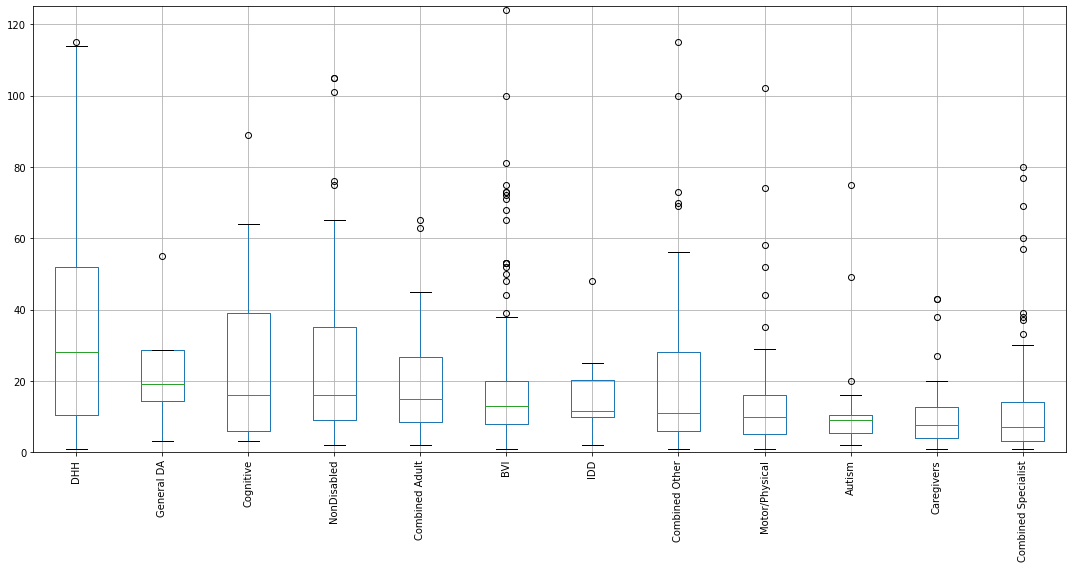

In [49]:
df_participant_cnts_tmp = df_participant_cnts_consolidated.drop('Crowdworkers', axis=1)
med = df_participant_cnts_tmp.median()
med = med.sort_values(ascending=False)
sorted_df = df_participant_cnts_tmp[med.index]
#display(sorted_df)

fig, ax = plt.subplots(1, figsize=(15,8))
sorted_df.boxplot(ax=ax, rot=90)
ax.set_ylim(0, 125) # zoom in
plt.tight_layout()

display(sorted_df.describe())

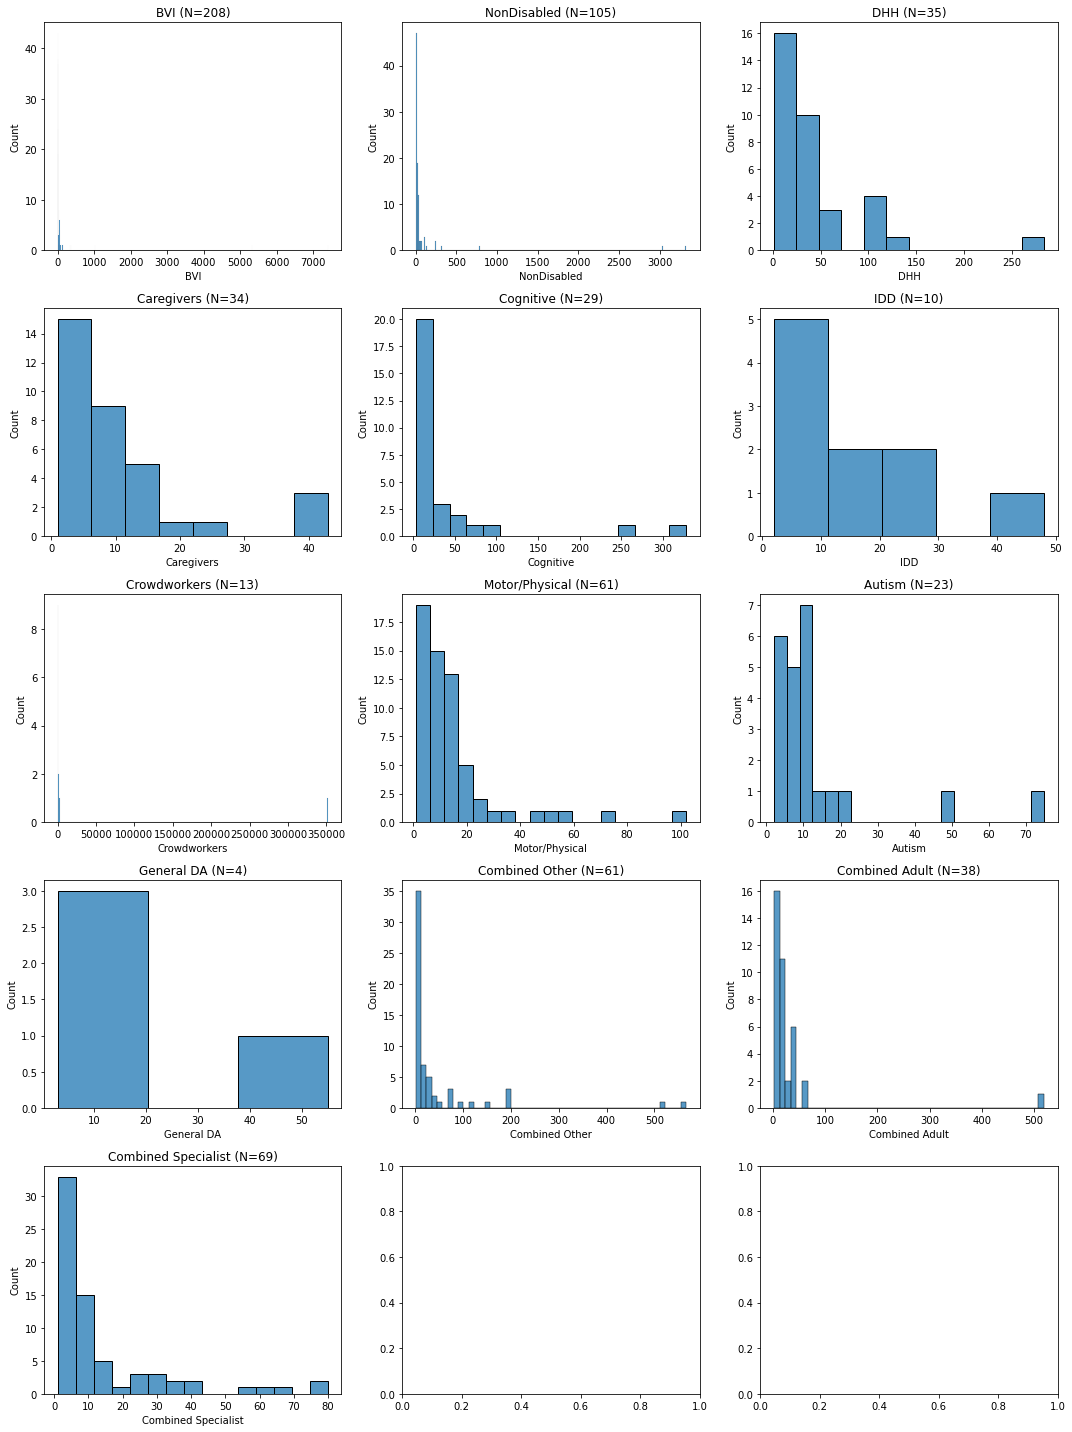

In [50]:
num_ax_rows = 5
num_ax_cols = 3
fig, axes = plt.subplots(num_ax_rows, num_ax_cols, figsize=(15, 20))
i = 0
for col in df_participant_cnts_consolidated.columns:
    if col not in set_additional_metadata_cols:
        row_idx = i // num_ax_cols
        col_idx = i % num_ax_cols
        sns.histplot(data=df_participant_cnts_consolidated, x=col, ax=axes[row_idx, col_idx])
        
        # Another way to plot this:
        # axes[row_idx, col_idx].hist(df_participant_cnts_consolidated[col], bins=20, range=(0, 200))
        axes[row_idx, col_idx].set_title(f'{col} (N={df_participant_cnts_consolidated[col].count()})')
        
        i += 1

plt.tight_layout()
plt.show()

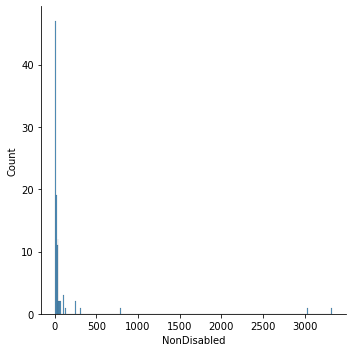

In [51]:
sns.displot(data=df_participant_counts, x="NonDisabled")

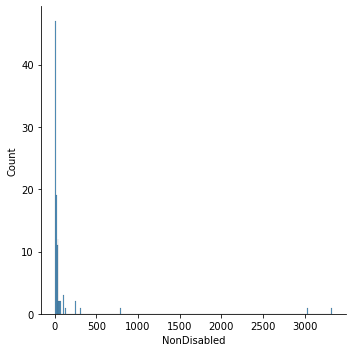

In [52]:
sns.displot(data=df_participant_counts, x="NonDisabled")

## Analysis of older adults and disabled communities
Per Kelly's request ([Issue #61](https://github.com/jonfroehlich/accesslitsurvey/issues/61)) to further consolidate groups into disabled and older adults for num participant analyses

In [53]:
# create higher-level participant group groupings
set_population_groups = set(population_groups)
other_cols = [col for col in set_population_groups if "Other" in col or "Unclear" in col]
set_population_groups = (set_population_groups - set(other_cols))
older_adult_cols = [col for col in set_population_groups if "Adult" in col]
set_population_groups = (set_population_groups - set(older_adult_cols))
specialist_cols = [col for col in set_population_groups if "Teacher" in col or
                                                           "Therapist" in col or
                                                           "Specialist" in col]
set_population_groups = (set_population_groups - set(specialist_cols))
crowdworker_cols = [col for col in set_population_groups if "Crowdworker" in col]
set_population_groups = (set_population_groups - set(crowdworker_cols))
caregiver_cols = [col for col in set_population_groups if "Caregiver" in col]
set_population_groups = (set_population_groups - set(caregiver_cols))
nondisabled_cols = [col for col in set_population_groups if "NonDisabled" in col]
set_population_groups = (set_population_groups - set(nondisabled_cols))
disabled_cols = list(set_population_groups)
set_population_groups = (set_population_groups - set(disabled_cols))

print(f"{len(other_cols)} 'Other' columns:")
print(other_cols)
print()
print(f"{len(older_adult_cols)} 'Adult' columns:")
print(older_adult_cols)
print()
print(f"{len(specialist_cols)} 'Teacher, Therapist, Specialist' columns:")
print(specialist_cols)
print()
print(f"{len(crowdworker_cols)} 'Crowdworker columns:")
print(crowdworker_cols)
print()
print(f"{len(crowdworker_cols)} 'Caregiver columns:")
print(caregiver_cols)
print()
print(f"{len(crowdworker_cols)} 'Nondisabled columns:")
print(nondisabled_cols)
print()
print(f"{len(disabled_cols)} 'Disabled columns:")
print(disabled_cols)
print()
print(f"We have {len(set_population_groups)} remaining groups:")
print(set_population_groups)

19 'Other' columns:
['Other-Developers', 'Other-Family members', 'Other-Designers/developers', 'Other-Signers', 'Other-Students with web accessibility knowledge', 'Other', 'Other-Students, technology instructor', 'Other-CVD', 'Other-Administrators', 'Other-Mental health', 'Other-Engineers or interaction designers', 'Other-Garden show employees', 'Other-Special education students with multiple learning challenges', 'Other-Visual and/or motor', 'Other-Students, teachers', 'Unclear', 'Other-Disabled', 'Other-ASL students', 'Other-Children']

3 'Adult' columns:
['Older Adult Disabled', 'Older Adult NonDisabled', 'Older Adult']

4 'Teacher, Therapist, Specialist' columns:
['Specialists', 'Specialists/Teachers', 'Teachers', 'Therapists']

1 'Crowdworker columns:
['Crowdworkers']

1 'Caregiver columns:
['Caregivers']

1 'Nondisabled columns:
['NonDisabled']

7 'Disabled columns:
['BVI', 'Cognitive', 'General DA', 'IDD', 'DHH', 'Autism', 'Motor/Physical']

We have 0 remaining groups:
set()


In [54]:
# Now condense the number of participant groups into the following categories
df_participant_cnts_consolidated2 = df_participant_counts.copy(deep=True)

df_participant_cnts_consolidated2['Combined Other'] = df_participant_counts[other_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated2['Combined Other'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated2['Combined Adult'] = df_participant_counts[older_adult_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated2['Combined Adult'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated2['Combined Specialist'] = df_participant_counts[specialist_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated2['Combined Specialist'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated2['Combined Disabled'] = df_participant_counts[disabled_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated2['Combined Disabled'].replace(0, np.nan, inplace=True)

df_participant_cnts_consolidated2.drop(other_cols, axis=1, inplace=True)
df_participant_cnts_consolidated2.drop(older_adult_cols, axis=1, inplace=True)
df_participant_cnts_consolidated2.drop(specialist_cols, axis=1, inplace=True)
df_participant_cnts_consolidated2.drop(disabled_cols, axis=1, inplace=True)

pd.options.display.float_format = '{:.1f}'.format
display(df_participant_cnts_consolidated2.describe())
pd.options.display.float_format = None

NonDisabled  Caregivers  Crowdworkers  Combined Other  Combined Adult  \
count        105.0        34.0          13.0            61.0            38.0   
mean          97.8        11.0       27500.0            47.3            32.8   
std          440.4        11.1       97490.3           103.3            82.5   
min            2.0         1.0          15.0             1.0             2.0   
25%            9.0         4.0          42.0             6.0             8.5   
50%           16.0         7.5         153.0            11.0            15.0   
75%           35.0        12.8         797.0            28.0            26.8   
max         3323.0        43.0      351960.0           566.0           519.0   

       Combined Specialist  Combined Disabled  
count                 69.0              366.0  
mean                  14.2               62.0  
std                   18.3              478.8  
min                    1.0                1.0  
25%                    3.0                8.0  
50%                    7.0               13.0  
75%                   14.0               21.0  
max                   80.0             7398.0

In [55]:
# Calculate stats for paper
for col in df_participant_cnts_consolidated2.columns:
    if col not in set_additional_metadata_cols:
        s = df_participant_cnts_consolidated2[col]
        quantile75 = s.quantile(0.75)
        quantile25 = s.quantile(0.25)
        print(f"{col} (N={s.count()}): Median: {s.median()} Mean: {s.mean():.1f}"
              f" Stdev: {s.std():.1f} IQR: {quantile75 - quantile25} Range: {s.min()} - {s.max()}")

NonDisabled (N=105): Median: 16.0 Mean: 97.8 Stdev: 440.4 IQR: 26.0 Range: 2.0 - 3323.0
Caregivers (N=34): Median: 7.5 Mean: 11.0 Stdev: 11.1 IQR: 8.75 Range: 1.0 - 43.0
Crowdworkers (N=13): Median: 153.0 Mean: 27500.0 Stdev: 97490.3 IQR: 755.0 Range: 15.0 - 351960.0
Combined Other (N=61): Median: 11.0 Mean: 47.3 Stdev: 103.3 IQR: 22.0 Range: 1.0 - 566.0
Combined Adult (N=38): Median: 15.0 Mean: 32.8 Stdev: 82.5 IQR: 18.25 Range: 2.0 - 519.0
Combined Specialist (N=69): Median: 7.0 Mean: 14.2 Stdev: 18.3 IQR: 11.0 Range: 1.0 - 80.0
Combined Disabled (N=366): Median: 13.0 Mean: 62.0 Stdev: 478.8 IQR: 13.0 Range: 1.0 - 7398.0


## Analysis of older adults and disabled communities (combined)
And an even more combined set of groups (with adults and disabled communities together)

In [56]:
# create higher-level participant group groupings
set_population_groups = set(population_groups)
other_cols = [col for col in set_population_groups if "Other" in col or "Unclear" in col]
set_population_groups = (set_population_groups - set(other_cols))
specialist_cols = [col for col in set_population_groups if "Teacher" in col or
                                                           "Therapist" in col or
                                                           "Specialist" in col]
set_population_groups = (set_population_groups - set(specialist_cols))
crowdworker_cols = [col for col in set_population_groups if "Crowdworker" in col]
set_population_groups = (set_population_groups - set(crowdworker_cols))
caregiver_cols = [col for col in set_population_groups if "Caregiver" in col]
set_population_groups = (set_population_groups - set(caregiver_cols))
nondisabled_cols = [col for col in set_population_groups if "NonDisabled" == col]
set_population_groups = (set_population_groups - set(nondisabled_cols))
disabled_and_older_adult_cols = list(set_population_groups)
set_population_groups = (set_population_groups - set(disabled_and_older_adult_cols))

print(f"{len(other_cols)} 'Other' columns:")
print(other_cols)
print()
print(f"{len(specialist_cols)} 'Teacher, Therapist, Specialist' columns:")
print(specialist_cols)
print()
print(f"{len(crowdworker_cols)} 'Crowdworker columns:")
print(crowdworker_cols)
print()
print(f"{len(crowdworker_cols)} 'Caregiver columns:")
print(caregiver_cols)
print()
print(f"{len(crowdworker_cols)} 'Nondisabled columns:")
print(nondisabled_cols)
print()
print(f"{len(disabled_and_older_adult_cols)} 'Disabled and older adult columns:")
print(disabled_and_older_adult_cols)
print()
print(f"We have {len(set_population_groups)} remaining groups:")
print(set_population_groups)

19 'Other' columns:
['Other-Developers', 'Other-Family members', 'Other-Designers/developers', 'Other-Signers', 'Other-Students with web accessibility knowledge', 'Other', 'Other-Students, technology instructor', 'Other-CVD', 'Other-Administrators', 'Other-Mental health', 'Other-Engineers or interaction designers', 'Other-Garden show employees', 'Other-Special education students with multiple learning challenges', 'Other-Visual and/or motor', 'Other-Students, teachers', 'Unclear', 'Other-Disabled', 'Other-ASL students', 'Other-Children']

4 'Teacher, Therapist, Specialist' columns:
['Teachers', 'Specialists', 'Therapists', 'Specialists/Teachers']

1 'Crowdworker columns:
['Crowdworkers']

1 'Caregiver columns:
['Caregivers']

1 'Nondisabled columns:
['NonDisabled']

10 'Disabled and older adult columns:
['BVI', 'Cognitive', 'Older Adult Disabled', 'DHH', 'General DA', 'IDD', 'Autism', 'Older Adult NonDisabled', 'Motor/Physical', 'Older Adult']

We have 0 remaining groups:
set()


In [57]:
# Now condense the number of participant groups into the following categories
df_participant_cnts_consolidated3 = df_participant_counts.copy(deep=True)

df_participant_cnts_consolidated3['Combined Other'] = df_participant_counts[other_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated3['Combined Other'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated3['Combined Specialist'] = df_participant_counts[specialist_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated3['Combined Specialist'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated3['Combined Disabled and Older Adult'] = df_participant_counts[disabled_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated3['Combined Disabled and Older Adult'].replace(0, np.nan, inplace=True)

df_participant_cnts_consolidated3.drop(other_cols, axis=1, inplace=True)
df_participant_cnts_consolidated3.drop(specialist_cols, axis=1, inplace=True)
df_participant_cnts_consolidated3.drop(disabled_and_older_adult_cols, axis=1, inplace=True)

pd.options.display.float_format = '{:.1f}'.format
display(df_participant_cnts_consolidated3.describe())
pd.options.display.float_format = None

NonDisabled  Caregivers  Crowdworkers  Combined Other  \
count        105.0        34.0          13.0            61.0   
mean          97.8        11.0       27500.0            47.3   
std          440.4        11.1       97490.3           103.3   
min            2.0         1.0          15.0             1.0   
25%            9.0         4.0          42.0             6.0   
50%           16.0         7.5         153.0            11.0   
75%           35.0        12.8         797.0            28.0   
max         3323.0        43.0      351960.0           566.0   

       Combined Specialist  Combined Disabled and Older Adult  
count                 69.0                              366.0  
mean                  14.2                               62.0  
std                   18.3                              478.8  
min                    1.0                                1.0  
25%                    3.0                                8.0  
50%                    7.0                               13.0  
75%                   14.0                               21.0  
max                   80.0                             7398.0

In [58]:
# Calculate stats for paper
for col in df_participant_cnts_consolidated3.columns:
    if col not in set_additional_metadata_cols:
        s = df_participant_cnts_consolidated3[col]
        quantile75 = s.quantile(0.75)
        quantile25 = s.quantile(0.25)
        print(f"{col} (N={s.count()}): Median: {s.median()} Mean: {s.mean():.1f}"
              f" Stdev: {s.std():.1f} IQR: {quantile75 - quantile25} Range: {s.min()} - {s.max()}")

NonDisabled (N=105): Median: 16.0 Mean: 97.8 Stdev: 440.4 IQR: 26.0 Range: 2.0 - 3323.0
Caregivers (N=34): Median: 7.5 Mean: 11.0 Stdev: 11.1 IQR: 8.75 Range: 1.0 - 43.0
Crowdworkers (N=13): Median: 153.0 Mean: 27500.0 Stdev: 97490.3 IQR: 755.0 Range: 15.0 - 351960.0
Combined Other (N=61): Median: 11.0 Mean: 47.3 Stdev: 103.3 IQR: 22.0 Range: 1.0 - 566.0
Combined Specialist (N=69): Median: 7.0 Mean: 14.2 Stdev: 18.3 IQR: 11.0 Range: 1.0 - 80.0
Combined Disabled and Older Adult (N=366): Median: 13.0 Mean: 62.0 Stdev: 478.8 IQR: 13.0 Range: 1.0 - 7398.0


# Temporal trends (2010-2019)

## Overall trends

In [59]:
df.groupby(['Year'])['Year'].count() / df_total_papers_per_year.sum(axis=1)

Year
2010    0.106061
2011    0.087156
2012    0.086076
2013    0.102625
2014    0.073022
2015    0.098837
2016    0.080844
2017    0.093207
2018    0.097983
2019    0.129032
dtype: float64

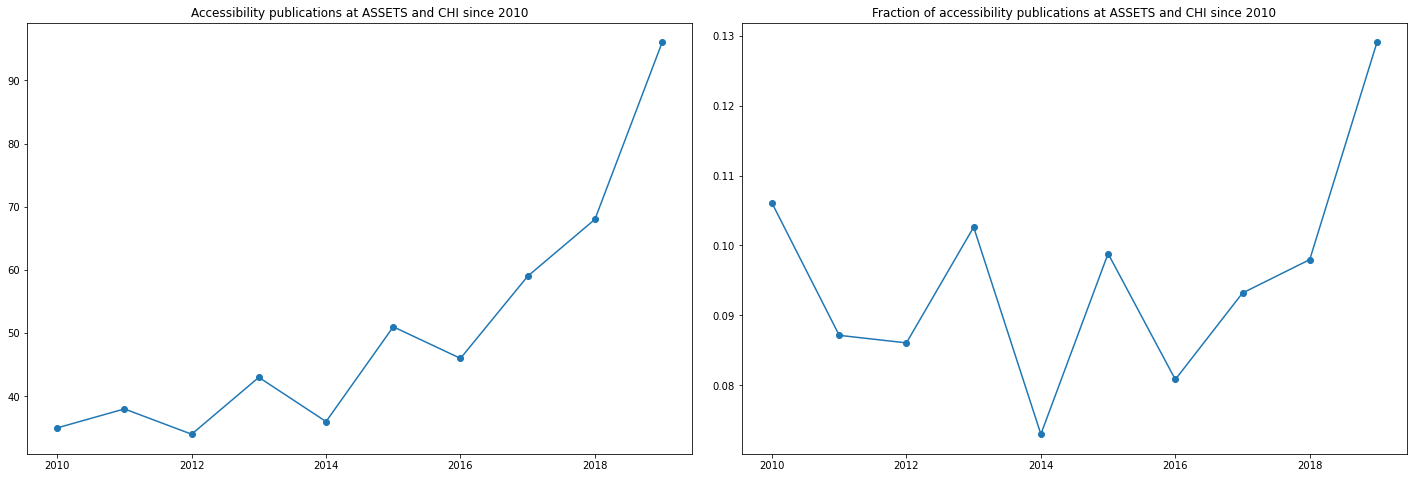

In [60]:
total_pub_cnt_by_year = df.groupby(['Year'])['Year'].count()
total_pub_frac_by_year = df.groupby(['Year'])['Year'].count() / df_total_papers_per_year.sum(axis=1)

f, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].plot(total_pub_cnt_by_year, marker='o', label="Total")
axes[0].set_title("Accessibility publications at ASSETS and CHI since 2010")

axes[1].plot(total_pub_frac_by_year, marker='o', label="Total")
axes[1].set_title("Fraction of accessibility publications at ASSETS and CHI since 2010")
plt.tight_layout(pad=2)

## By publication venue

In [61]:
total_pub_cnt_by_venue_and_year = df.groupby(['Venue', 'Year'])['Year'].count()

# Convert series to a DataFrame for pretty printing
df_pub_cnt_by_venue_and_year = pd.DataFrame(columns=['ASSETS', 'CHI'])
df_pub_cnt_by_venue_and_year['ASSETS'] = total_pub_cnt_by_venue_and_year['ASSETS']
df_pub_cnt_by_venue_and_year['CHI'] = total_pub_cnt_by_venue_and_year['CHI']
display(df_pub_cnt_by_venue_and_year)

ASSETS  CHI
Year             
2010      28    7
2011      27   11
2012      25    9
2013      27   16
2014      28    8
2015      30   21
2016      24   22
2017      33   26
2018      28   40
2019      41   55

In [62]:
# In previous xlsx data files, we found that there were **5** missing rows. This code was the code
# that helped determine this: https://github.com/jonfroehlich/accesslitsurvey/issues/38
# Note: this is now fixed/solved (we added the 5 missing papers)
print("Double checking number of qualitatively coded ASSETS papers vs. total number of ASSETS papers")
df_assets_over_time = pd.DataFrame()
df_assets_over_time['Coded Papers'] = total_pub_cnt_by_venue_and_year['ASSETS']
df_assets_over_time['Total Papers'] = df_total_papers_per_year['ASSETS']
df_assets_over_time['Difference'] = df_assets_over_time['Total Papers'] - df_assets_over_time['Coded Papers']
display(df_assets_over_time)

Double checking number of qualitatively coded ASSETS papers vs. total number of ASSETS papers


Coded Papers  Total Papers  Difference
Year                                        
2010            28            28           0
2011            27            27           0
2012            25            25           0
2013            27            27           0
2014            28            28           0
2015            30            30           0
2016            24            24           0
2017            33            33           0
2018            28            28           0
2019            41            41           0

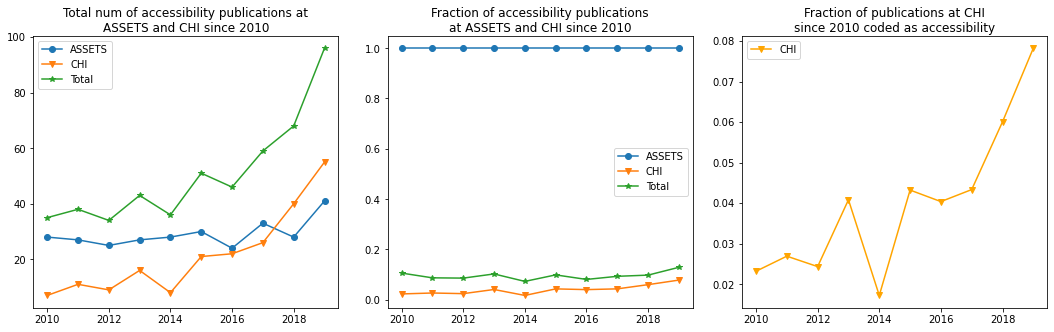

In [63]:
# Graph the results
f, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(total_pub_cnt_by_venue_and_year['ASSETS'], label='ASSETS', marker='o')
axes[0].plot(total_pub_cnt_by_venue_and_year['CHI'], label='CHI', marker='v')
axes[0].plot(total_pub_cnt_by_year, label='Total', marker='*')
axes[0].set_title("Total num of accessibility publications at\nASSETS and CHI since 2010", wrap=True)
axes[0].legend()

#axes[1].plot(total_pub_frac_by_year)
#total_pub_cnt_by_venue_and_year['ASSETS'] / df_total_papers_per_year['ASSETS']
total_pub_frac_by_venue_and_year_assets = total_pub_cnt_by_venue_and_year['ASSETS'] / df_total_papers_per_year['ASSETS']
total_pub_frac_by_venue_and_year_chi = total_pub_cnt_by_venue_and_year['CHI'] / df_total_papers_per_year['CHI']
total_pub_frac_by_venue_and_year = (total_pub_cnt_by_venue_and_year['ASSETS']  + total_pub_cnt_by_venue_and_year['CHI']) / df_total_papers_per_year.sum(axis=1)

axes[1].plot(total_pub_frac_by_venue_and_year_assets, label='ASSETS', marker='o')
axes[1].plot(total_pub_frac_by_venue_and_year_chi, label='CHI', marker='v')
axes[1].plot(total_pub_frac_by_venue_and_year, label='Total', marker='*')
axes[1].set_title("Fraction of accessibility publications\nat ASSETS and CHI since 2010", wrap=True)
axes[1].legend()

axes[2].plot(total_pub_frac_by_venue_and_year_chi, label='CHI', marker='v', color='orange')
axes[2].set_title("Fraction of publications at CHI\nsince 2010 coded as accessibility", wrap=True)
axes[2].legend()

plt.tight_layout(pad=2)

## By code category
Analyze and graph the frequency of sub-codes in each code category over time.

In [64]:
df.groupby(['Venue', 'Year'])['Year'].count()

Venue   Year
ASSETS  2010    28
        2011    27
        2012    25
        2013    27
        2014    28
        2015    30
        2016    24
        2017    33
        2018    28
        2019    41
CHI     2010     7
        2011    11
        2012     9
        2013    16
        2014     8
        2015    21
        2016    22
        2017    26
        2018    40
        2019    55
Name: Year, dtype: int64

In [65]:
# Here's an example of how the sub-code `TargetPopulation_BVI` has occurred over the past 10 years
df[df['TargetPopulation_BVI'] == 1].groupby(['Year', 'TargetPopulation_BVI'])['Year'].count()

Year  TargetPopulation_BVI
2010  1                       12
2011  1                       10
2012  1                       14
2013  1                       18
2014  1                       17
2015  1                       22
2016  1                       19
2017  1                       30
2018  1                       34
2019  1                       44
Name: Year, dtype: int64

TargetPopulation_BVI  TargetPopulation_DHH  TargetPopulation_IDD  \
Year                                                                     
2010                    12                     4                     2   
2011                    10                     5                     2   
2012                    14                     4                     0   
2013                    18                     3                     1   
2014                    17                     2                     0   
2015                    22                     6                     1   
2016                    19                     4                     2   
2017                    30                     6                     1   
2018                    34                    11                     2   
2019                    44                    12                     3   

      TargetPopulation_MotorPhysical  TargetPopulation_Autism  \
Year                                                            
2010                               3                        3   
2011                               7                        2   
2012                               3                        1   
2013                               8                        1   
2014                               9                        2   
2015                               5                        5   
2016                               9                        2   
2017                               7                        8   
2018                               6                        4   
2019                              15                        3   

      TargetPopulation_Cognitive  TargetPopulation_OlderAdult  \
Year                                                            
2010                           4                            5   
2011                           4                            6   
2012                           3                            6   
2013                           6                            5   
2014                           2                            5   
2015                           6                            4   
2016                           4                            3   
2017                           6                            2   
2018                           4                            3   
2019                           7                            6   

      TargetPopulation_GeneralDisability  TargetPopulation_Other  
Year                                                              
2010                                   4                       3  
2011                                   7                       5  
2012                                   2                       4  
2013                                   3                       6  
2014                                   3                       1  
2015                                   4                       5  
2016                                   4                       5  
2017                                   2                       4  
2018                                   7                       7  
2019                                  10                       6

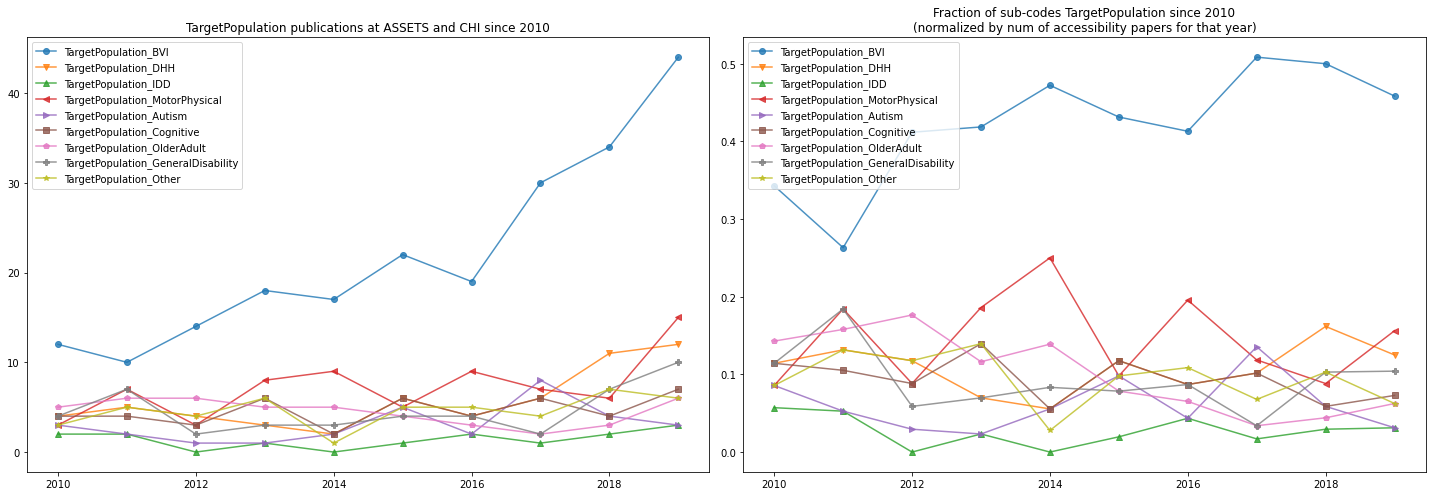

StudyMethod_ControlledExperiment  StudyMethod_SurveyMethod  \
Year                                                               
2010                                11                         9   
2011                                13                        10   
2012                                19                         6   
2013                                16                        10   
2014                                13                        12   
2015                                22                        15   
2016                                12                        13   
2017                                22                        14   
2018                                15                        15   
2019                                24                        18   

      StudyMethod_UsabilityTesting  StudyMethod_Interviews  \
Year                                                         
2010                            17                       6   
2011                            14                      14   
2012                            14                      10   
2013                            17                      14   
2014                            14                      17   
2015                            17                      18   
2016                            21                      21   
2017                            21                      22   
2018                            28                      33   
2019                            36                      46   

      StudyMethod_CaseStudy  StudyMethod_FocusGroups  StudyMethod_FieldStudy  \
Year                                                                           
2010                      1                        3                       5   
2011                      5                        2                       6   
2012                      1                        0                       3   
2013                      3                        1                       5   
2014                      1                        3                      10   
2015                      3                        2                       8   
2016                      2                        3                      10   
2017                      2                        3                       6   
2018                      4                        4                      14   
2019                      3                        7                      18   

      StudyMethod_WorkshopDesign  StudyMethod_Other  
Year                                                 
2010                           3                  6  
2011                           3                  9  
2012                           4                  8  
2013                           6                  8  
2014                           4                  8  
2015                           9                  9  
2016                          10                 11  
2017                           9                  8  
2018                          16                 11  
2019                          24                 21

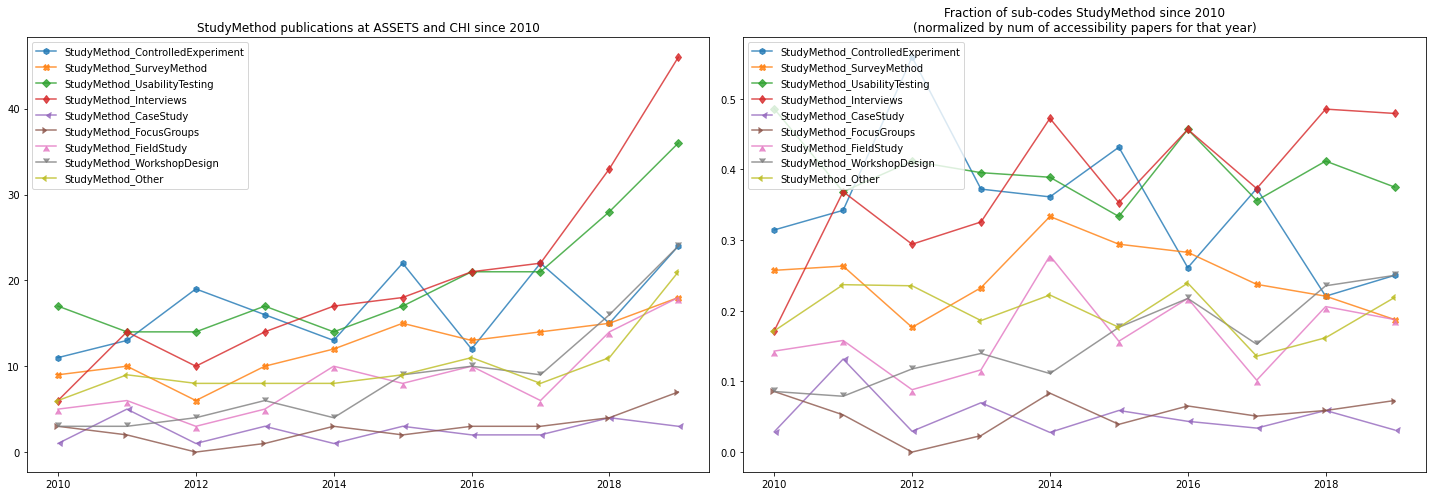

ParticipatoryDesign_Yes  ParticipatoryDesign_No
Year                                                 
2010                        2                      33
2011                        1                      37
2012                        3                      31
2013                        5                      38
2014                        4                      32
2015                        5                      46
2016                        6                      40
2017                        3                      56
2018                        6                      62
2019                       14                      82

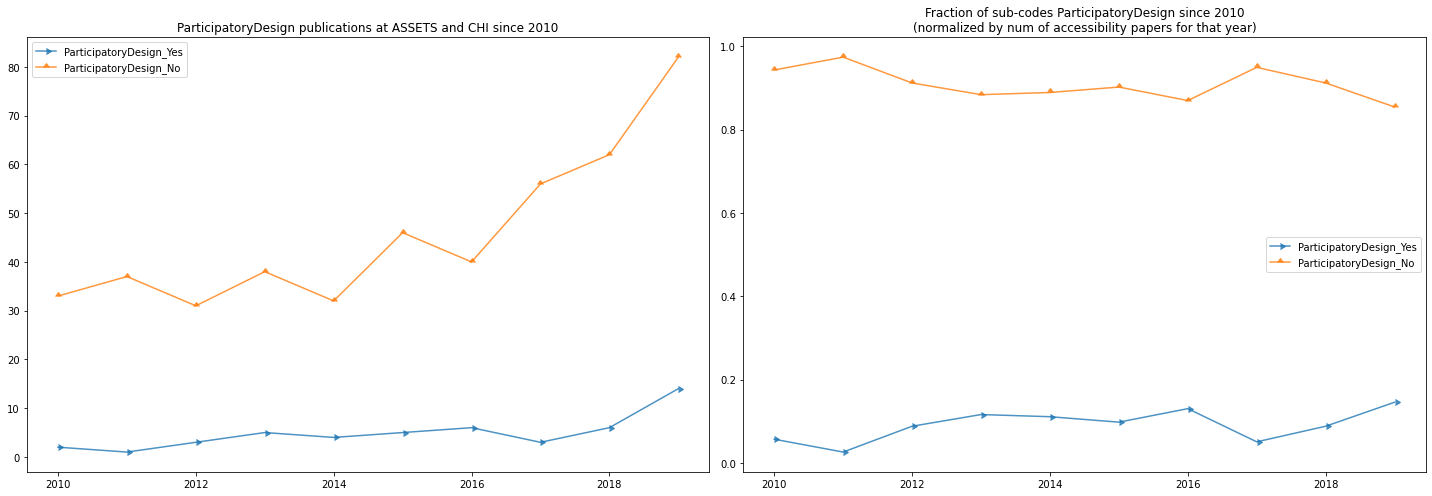

StudyLocation_NearAtLab  StudyLocation_ParticipantsHomeOrFreqLoc  \
Year                                                                     
2010                        5                                       12   
2011                        4                                        8   
2012                        9                                        5   
2013                       12                                       11   
2014                       12                                       13   
2015                       12                                       18   
2016                       15                                       15   
2017                       15                                       16   
2018                       20                                       20   
2019                       26                                       20   

      StudyLocation_NeutralLocation  StudyLocation_Unclear  \
Year                                                         
2010                              2                     11   
2011                              0                     21   
2012                              2                     16   
2013                              4                     15   
2014                              2                     10   
2015                              5                     15   
2016                              1                     21   
2017                              0                     20   
2018                              6                     22   
2019                             10                     38   

      StudyLocation_OnlineRemotely  StudyLocation_Other  \
Year                                                      
2010                             8                    0   
2011                             6                    0   
2012                             2                    0   
2013                             9                    0   
2014                             6                    1   
2015                            10                    2   
2016                            10                    0   
2017                            16                    1   
2018                            15                    2   
2019                            16                    1   

      StudyLocation_NoUserStudy  
Year                             
2010                          1  
2011                          5  
2012                          4  
2013                          3  
2014                          3  
2015                          2  
2016                          1  
2017                          3  
2018                          2  
2019                          5

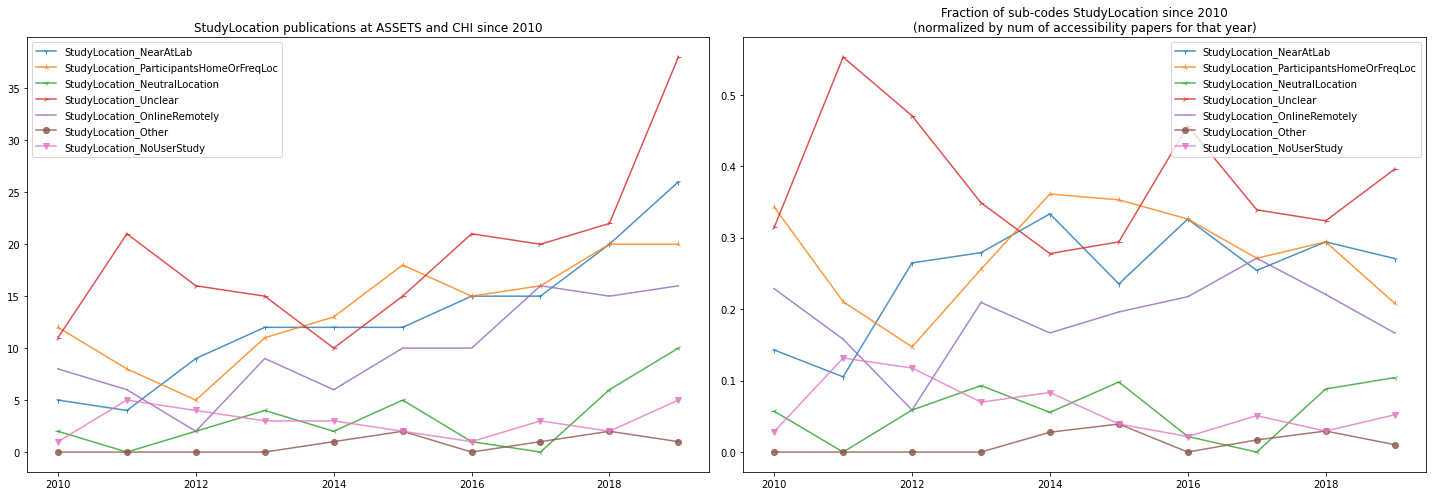

ParticipantGroup_OlderAdult  ParticipantGroup_PeopleWithDisability  \
Year                                                                       
2010                            4                                     23   
2011                            5                                     24   
2012                            5                                     21   
2013                            5                                     33   
2014                            4                                     27   
2015                            4                                     42   
2016                            2                                     40   
2017                            2                                     54   
2018                            3                                     63   
2019                            6                                     77   

      ParticipantGroup_PeopleWithoutDisability  \
Year                                             
2010                                         8   
2011                                         9   
2012                                         8   
2013                                         8   
2014                                         9   
2015                                        15   
2016                                        14   
2017                                        14   
2018                                        13   
2019                                        12   

      ParticipantGroup_TherapistsSpecialists  ParticipantGroup_Caregivers  \
Year                                                                        
2010                                       8                            3   
2011                                       7                            4   
2012                                       3                            0   
2013                                       4                            3   
2014                                       5                            2   
2015                                      10                            5   
2016                                       5                            6   
2017                                       9                            9   
2018                                      13                            4   
2019                                      17                            9   

      ParticipantGroup_Other  ParticipantGroup_NoUserStudy  
Year                                                        
2010                       4                             1  
2011                       4                             5  
2012                       4                             4  
2013                       4                             3  
2014                       4                             3  
2015                       5                             2  
2016                       3                             1  
2017                       2                             3  
2018                       6                             2  
2019                      17                             5

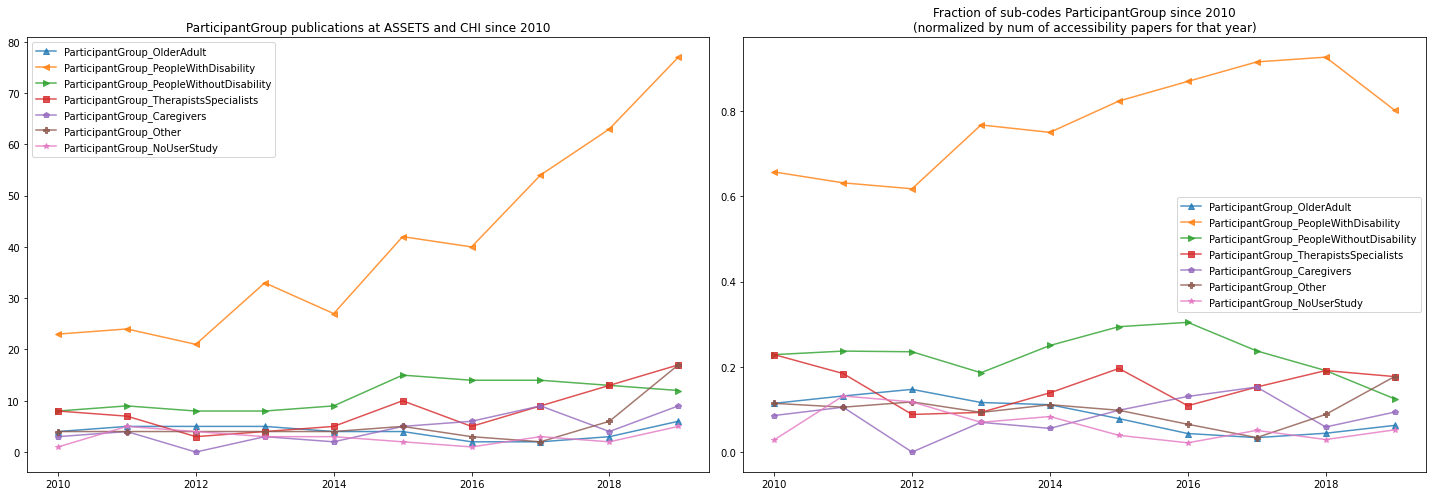

ComparesOnDisability_Yes  ComparesOnDisability_No
Year                                                   
2010                         4                       31
2011                         3                       35
2012                         6                       28
2013                         4                       39
2014                         7                       29
2015                        11                       40
2016                         6                       40
2017                        11                       48
2018                         7                       61
2019                         6                       90

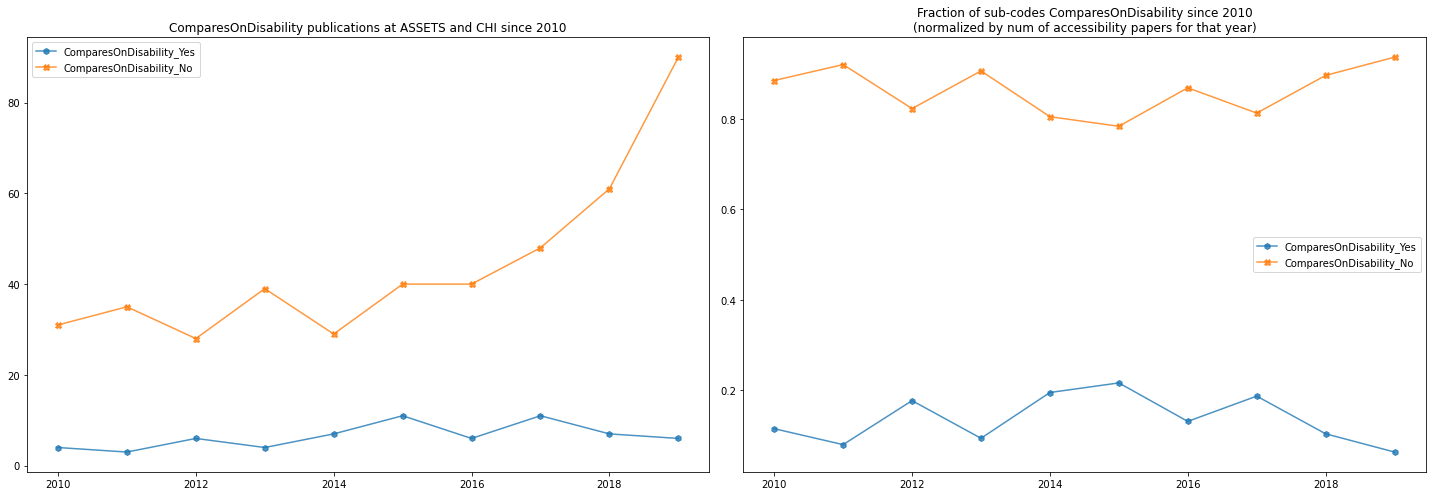

UsesProxies_Yes  UsesProxies_No
Year                                 
2010                2              33
2011                2              36
2012                3              31
2013                3              40
2014                4              32
2015                2              49
2016                5              41
2017                7              52
2018                7              61
2019                3              93

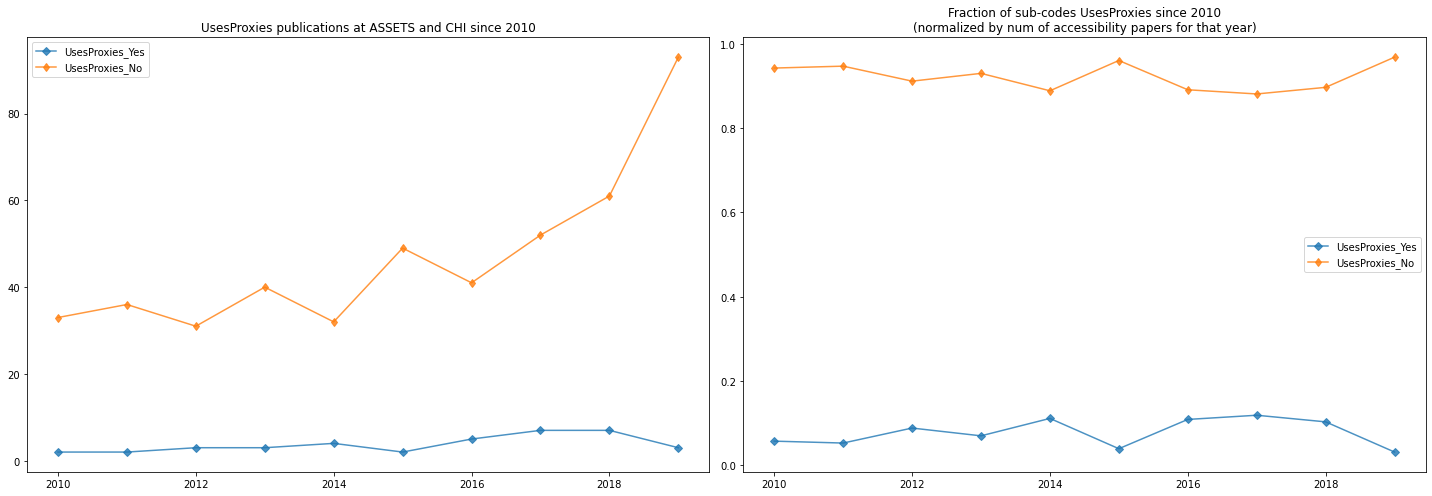

TechFocus_SmartphoneTabletSmartwatch  TechFocus_WebApp  \
Year                                                           
2010                                    10                 9   
2011                                    10                 9   
2012                                     7                 5   
2013                                    18                 6   
2014                                    13                 4   
2015                                     7                 3   
2016                                    15                 5   
2017                                    22                 7   
2018                                    22                 7   
2019                                    32                 8   

      TechFocus_DesktopApp  TechFocus_IotEnvironmentSensing  \
Year                                                          
2010                     8                                3   
2011                     6                                1   
2012                     5                                1   
2013                     3                                0   
2014                     3                                3   
2015                     9                                3   
2016                     4                                1   
2017                     7                                2   
2018                     4                                4   
2019                     5                                7   

      TechFocus_VrArSolution  TechFocus_TangibleDeviceProsthesis  \
Year                                                               
2010                       0                                   4   
2011                       1                                   3   
2012                       3                                   3   
2013                       2                                   6   
2014                       4                                   9   
2015                       6                                   8   
2016                       5                                   9   
2017                       2                                  13   
2018                       8                                  13   
2019                       9                                  12   

      TechFocus_PhysicallyFabricated  TechFocus_NoTechFocus  TechFocus_Other  
Year                                                                          
2010                               1                      2               11  
2011                               0                      0               18  
2012                               1                      2               18  
2013                               3                      3               16  
2014                               3                      4               13  
2015                               4                      7               19  
2016                              10                      4               11  
2017                               5                      3               22  
2018                               4                      6               18  
2019                              10                      7               38

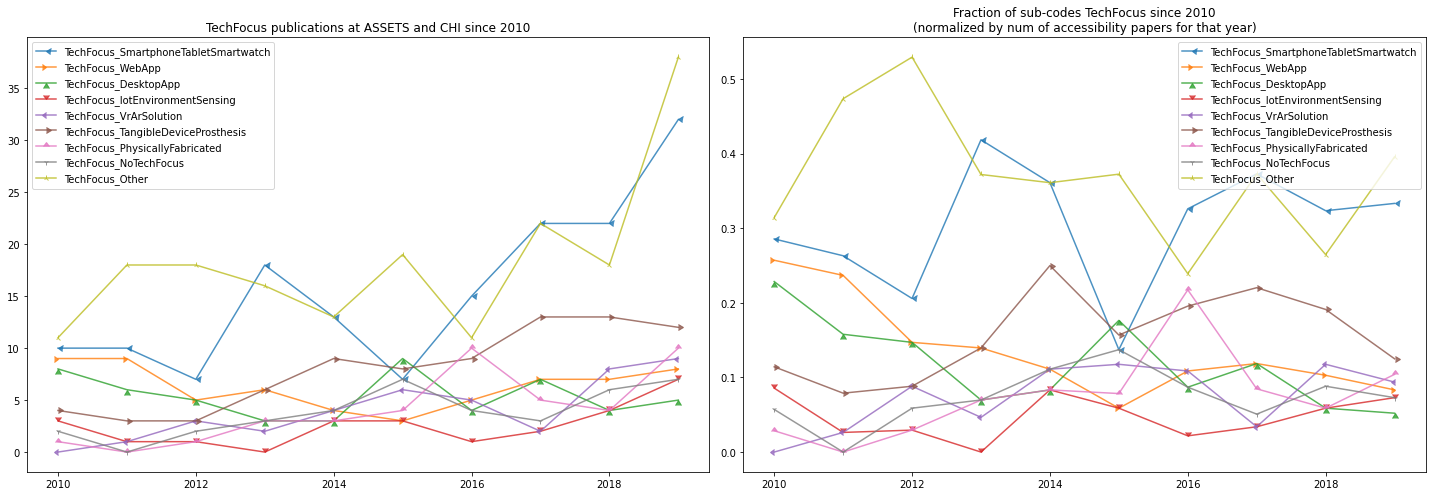

CountTechFocus_ExcludingOther
Year                               
2010                             22
2011                             20
2012                             21
2013                             29
2014                             25
2015                             30
2016                             29
2017                             34
2018                             49
2019                             61

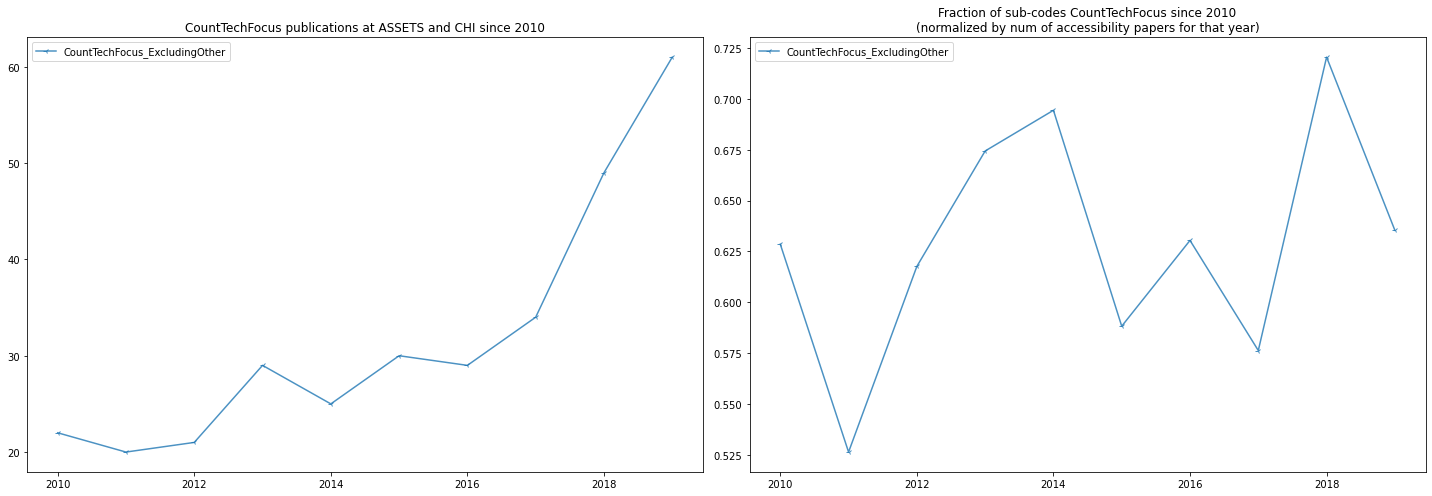

TechFocusOther_Algo  TechFocusOther_General  TechFocusOther_TechAgnostic
Year                                                                          
2010                    4                       2                            2
2011                    3                       5                            6
2012                    4                       4                            4
2013                    1                       4                           11
2014                    2                       0                            5
2015                    4                       2                           11
2016                    4                       5                            3
2017                    7                       4                            9
2018                    7                       4                            7
2019                    8                       9                           11

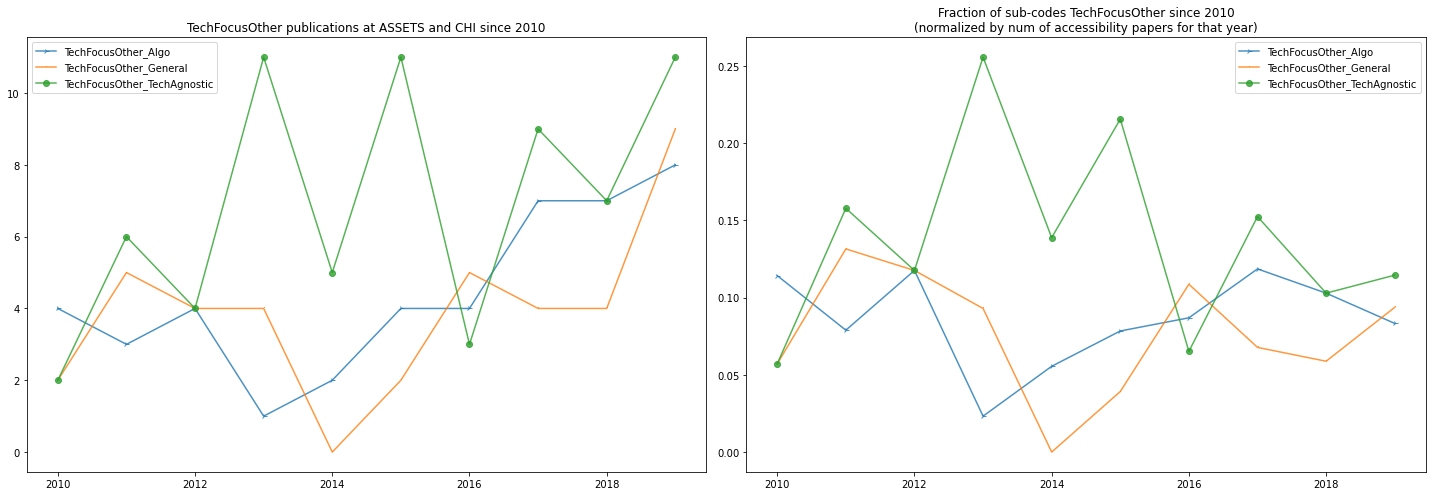

IssueAddressed_IncreaseDigitalAccess  \
Year                                         
2010                                    12   
2011                                    18   
2012                                    17   
2013                                    19   
2014                                    13   
2015                                    22   
2016                                    15   
2017                                    18   
2018                                    21   
2019                                    31   

      IssueAddressed_IncreasePhysicalAccess  \
Year                                          
2010                                      5   
2011                                      5   
2012                                      7   
2013                                      8   
2014                                      8   
2015                                     11   
2016                                     11   
2017                                     12   
2018                                     12   
2019                                     26   

      IssueAddressed_IncreaseIndependence  \
Year                                        
2010                                    3   
2011                                    5   
2012                                    5   
2013                                   10   
2014                                    8   
2015                                    9   
2016                                   12   
2017                                    8   
2018                                   14   
2019                                   19   

      IssueAddressed_IncreaseUnderstandingOfUsers  \
Year                                                
2010                                            6   
2011                                           15   
2012                                            5   
2013                                           13   
2014                                            7   
2015                                           17   
2016                                           14   
2017                                           15   
2018                                           21   
2019                                           26   

      IssueAddressed_HelpWithPersonalInformaticsBehaviorChange  \
Year                                                             
2010                                                  6          
2011                                                  2          
2012                                                  3          
2013                                                  1          
2014                                                  4          
2015                                                  2          
2016                                                  5          
2017                                                  6          
2018                                                  3          
2019                                                  7          

      IssueAddressed_SupportCommunication  IssueAddressed_Other  
Year                                                             
2010                                    7                     3  
2011                                    8                     2  
2012                                    6                     2  
2013                                    6                     4  
2014                                    3                     7  
2015                                    7                     6  
2016                                    5                     6  
2017                                   12                     4  
2018                                   16                     8  
2019                                   11                    17

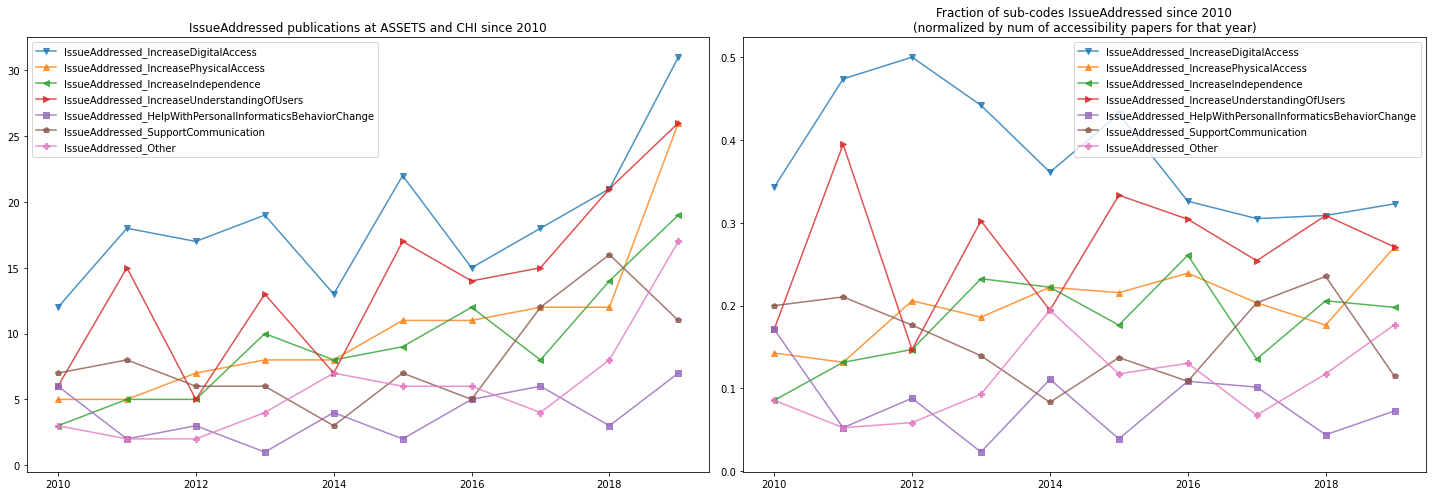

ContributionType_Empirical  ContributionType_Artifact  \
Year                                                          
2010                          16                         24   
2011                          20                         21   
2012                          16                         22   
2013                          27                         23   
2014                          22                         21   
2015                          35                         21   
2016                          26                         26   
2017                          38                         29   
2018                          44                         41   
2019                          61                         53   

      ContributionType_Methodological  ContributionType_Theoretical  \
Year                                                                  
2010                                0                             3   
2011                                2                             4   
2012                                2                             2   
2013                                1                             2   
2014                                1                             0   
2015                                5                             6   
2016                                0                             2   
2017                                1                             7   
2018                                2                             8   
2019                                2                            10   

      ContributionType_Dataset  ContributionType_SurveyContribution  \
Year                                                                  
2010                         0                                    0   
2011                         0                                    0   
2012                         0                                    0   
2013                         0                                    0   
2014                         0                                    0   
2015                         1                                    2   
2016                         1                                    0   
2017                         1                                    0   
2018                         1                                    0   
2019                         3                                    1   

      ContributionType_Opinion  ContributionType_Other  
Year                                                    
2010                         0                       0  
2011                         0                       0  
2012                         0                       0  
2013                         0                       0  
2014                         0                       0  
2015                         0                       0  
2016                         0                       0  
2017                         0                       0  
2018                         0                       0  
2019                         0                       0

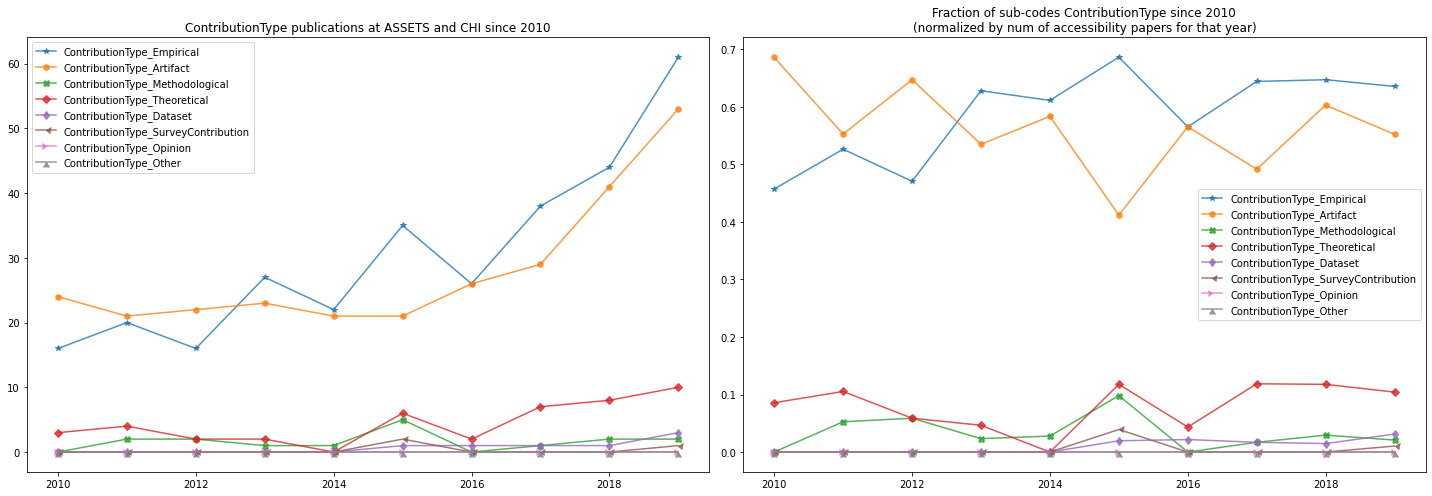

In [66]:
import itertools
marker_iter = itertools.cycle(plot_markers) 
#marker_iter = itertools.cycle(map_marker_to_desc.keys())
for code_cat, sub_codes in map_codes.items():
    
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # skip these categories
    
    col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
    df_pub_cnt_per_code_by_year = pd.DataFrame()
    
    for col_name in col_names:           
        # Previously, the code we had here was:
        #   series_pub_cnt_for_code_by_year = df[df[col_name] == 1].groupby(['Year', col_name])['Year'].count()
        # But this wouldn't work for years when that sub_code literally had zero entries with a '1' cell
        # So, based on this Stackoverflow: https://stackoverflow.com/q/37003100
        # I changed it to the following, which is more complicated to look at but works the same and includes zero counts
        df_sub_code_cnt_by_year = df.groupby(['Year', col_name])['Year'].count().unstack(fill_value=0)
        
        if len(df_sub_code_cnt_by_year.columns) == 1:
            # If we're here, then this sub-code was *NEVER* used across any year
            print(f"WARNING: the sub-code {col_name} was never used across any year")
            df_sub_code_cnt_by_year[1] = np.zeros(10, dtype=np.int64)
        
        series_pub_cnt_for_code_by_year = df_sub_code_cnt_by_year[1]
        #print(series_pub_cnt_for_code_by_year)
        df_pub_cnt_per_code_by_year[col_name] = series_pub_cnt_for_code_by_year
    
    # Because the series series_pub_cnt_for_code_by_year has a multindex both on year, subcode
    # we can drop the second index since we only want year
    #df_pub_cnt_per_code_by_year = df_pub_cnt_per_code_by_year.droplevel(1) # drop sub-code index
    df_pub_cnt_per_code_by_year = df_pub_cnt_per_code_by_year.fillna(0)
    df_pub_cnt_per_code_by_year = df_pub_cnt_per_code_by_year.astype(int)
    display(df_pub_cnt_per_code_by_year)
    
    # Graph the results
    f, axes = plt.subplots(1, 2, figsize=(20, 7))

    for col_name in df_pub_cnt_per_code_by_year.columns:
        marker = next(marker_iter)
        label = col_name
        axes[0].plot(df_pub_cnt_per_code_by_year[col_name], label=label, marker=marker, alpha=0.8)
        
        # draw normalized per category, which divides each sub_code count / total number of papers
        # in the code_cat for that year
        normalized_by_num_access_papers_per_year = df_pub_cnt_per_code_by_year[col_name] / total_pub_cnt_by_year
        axes[1].plot(normalized_by_num_access_papers_per_year, label=label, marker=marker, alpha=0.8)

    axes[0].set_title(f"{code_cat} publications at ASSETS and CHI since 2010")
    axes[0].legend()
    
    axes[1].set_title(f"Fraction of sub-codes {code_cat} since 2010\n(normalized by num of accessibility papers for that year)")
    axes[1].legend()
    plt.tight_layout()
    plt.show()

# Co-occurence matrices

## Co-occurrence matrix plotting functions

In [67]:
def plot_co_occurrence_cnt_matrix(df_co_occurrence_cnt):
    # Generate a mask for the upper triangle
    df_co_occurrence_cnt = df_co_occurrence_cnt.astype(float)
    mask = np.zeros_like(df_co_occurrence_cnt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_co_occurrence_cnt, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.show()
    
def plot_co_occurrence_fraction_matrix(df_co_occurrence_frac, df_co_occurrence_cnt=None):
    # Plot the percentages version 
    f, ax = plt.subplots(figsize=(10, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    if df_co_occurrence_cnt is not None:
        print("Read the co-occurrence matrix column-to-row. For example:")
        for i in range(3):
            col_name = random.choice(df_co_occurrence_frac.columns)#'StudyMethod_SurveyMethod'
            row_name = random.choice(df_co_occurrence_frac.columns)#'StudyMethod_ControlledExperiment'
            series_sum_occurrence = df[df_co_occurrence_frac.columns].sum()
            print("{} (column) occurs {} times in {} {} (row) instances {:.2f}%".format(
                col_name, df_co_occurrence_cnt.loc[row_name, col_name],
                series_sum_occurrence[row_name], row_name,
                (df_co_occurrence_cnt.loc[row_name, col_name] / 
                 series_sum_occurrence[row_name]) * 100))

            tmp_name = row_name
            row_name = col_name
            col_name = tmp_name
            print("{} (column) occurs {} times in {} {} (row) instances {:.2f}%".format(
                col_name, df_co_occurrence_cnt.loc[row_name, col_name],
                series_sum_occurrence[row_name], row_name,
                (df_co_occurrence_cnt.loc[row_name, col_name] / 
                 series_sum_occurrence[row_name]) * 100))
        
        print()

    # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(df_co_occurrence_study_method_frac, annot=True)
    sns.heatmap(df_co_occurrence_frac, cmap=cmap, vmax = 1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.show()

## Within-code co-occurrence matrices
The cells below explore how often sub-codes within a code category co-occur.

In [68]:
def calc_within_code_co_occurrence_matrix(code_cat, map_codes = None):
    '''
    Calculates the frequency with which each sub-code in the code category (code_cat) co-occurs with
    other sub-codes in the same code category
    '''
    
    if map_codes is None:
        map_codes = map_codes_to_cols
    
    # Create empty dataframes to store matrices:
    # df_co_occurrence_subcode_cnt is a count of co-occurrence
    # df_co_occurrence_subcode_frac is a fraction of co-occurrence
    subcode_cols = map_codes[code_cat]
    df_co_occurrence_subcode_cnt = pd.DataFrame(columns=subcode_cols, index=subcode_cols)
    df_co_occurrence_subcode_frac = pd.DataFrame(columns=subcode_cols, index=subcode_cols)
    series_sum_subcode_occurrence = df[subcode_cols].sum()
    
    for i in range(len(subcode_cols)):
        for j in range(len(subcode_cols)):
            row = subcode_cols[i]
            col = subcode_cols[j]
            
            # Run co-occurrence query
            co_occurrence_count = len(df[(df[row] == 1) & (df[col] == 1)])
            co_occurrence_fraction = co_occurrence_count / series_sum_subcode_occurrence[row]

            # Set co-occurrence data into appropriate table cells
            df_co_occurrence_subcode_cnt.loc[row, col] = co_occurrence_count
            df_co_occurrence_subcode_frac.loc[row, col] = co_occurrence_fraction

    # Need to force the fractions to floating point
    df_co_occurrence_subcode_cnt = df_co_occurrence_subcode_cnt.astype(int)
    df_co_occurrence_subcode_frac = df_co_occurrence_subcode_frac.astype(float)

#     return { 'co-occurrence-count-table' : df_co_occurrence_subcode_cnt,
#              'co-occurrence-frac-table' : df_co_occurrence_subcode_frac }
    return (df_co_occurrence_subcode_cnt, df_co_occurrence_subcode_frac)



******** TargetPopulation *******

** Raw sub-code co-occurrence count for TargetPopulation **


TargetPopulation_BVI  \
TargetPopulation_BVI                                 220   
TargetPopulation_DHH                                   0   
TargetPopulation_IDD                                   0   
TargetPopulation_MotorPhysical                         2   
TargetPopulation_Autism                                0   
TargetPopulation_Cognitive                             1   
TargetPopulation_OlderAdult                            2   
TargetPopulation_GeneralDisability                     8   
TargetPopulation_Other                                 3   

                                    TargetPopulation_DHH  \
TargetPopulation_BVI                                   0   
TargetPopulation_DHH                                  57   
TargetPopulation_IDD                                   0   
TargetPopulation_MotorPhysical                         0   
TargetPopulation_Autism                                0   
TargetPopulation_Cognitive                             0   
TargetPopulation_OlderAdult                            0   
TargetPopulation_GeneralDisability                     1   
TargetPopulation_Other                                13   

                                    TargetPopulation_IDD  \
TargetPopulation_BVI                                   0   
TargetPopulation_DHH                                   0   
TargetPopulation_IDD                                  14   
TargetPopulation_MotorPhysical                         0   
TargetPopulation_Autism                                5   
TargetPopulation_Cognitive                             1   
TargetPopulation_OlderAdult                            0   
TargetPopulation_GeneralDisability                     0   
TargetPopulation_Other                                 2   

                                    TargetPopulation_MotorPhysical  \
TargetPopulation_BVI                                             2   
TargetPopulation_DHH                                             0   
TargetPopulation_IDD                                             0   
TargetPopulation_MotorPhysical                                  72   
TargetPopulation_Autism                                          1   
TargetPopulation_Cognitive                                       5   
TargetPopulation_OlderAdult                                      5   
TargetPopulation_GeneralDisability                               4   
TargetPopulation_Other                                           1   

                                    TargetPopulation_Autism  \
TargetPopulation_BVI                                      0   
TargetPopulation_DHH                                      0   
TargetPopulation_IDD                                      5   
TargetPopulation_MotorPhysical                            1   
TargetPopulation_Autism                                  31   
TargetPopulation_Cognitive                                3   
TargetPopulation_OlderAdult                               1   
TargetPopulation_GeneralDisability                        2   
TargetPopulation_Other                                    3   

                                    TargetPopulation_Cognitive  \
TargetPopulation_BVI                                         1   
TargetPopulation_DHH                                         0   
TargetPopulation_IDD                                         1   
TargetPopulation_MotorPhysical                               5   
TargetPopulation_Autism                                      3   
TargetPopulation_Cognitive                                  46   
TargetPopulation_OlderAdult                                  9   
TargetPopulation_GeneralDisability                           2   
TargetPopulation_Other                                       5   

                                    TargetPopulation_OlderAdult  \
TargetPopulation_BVI                                          2   
TargetPopulation_DHH                                          0   
TargetPopulation_IDD                   

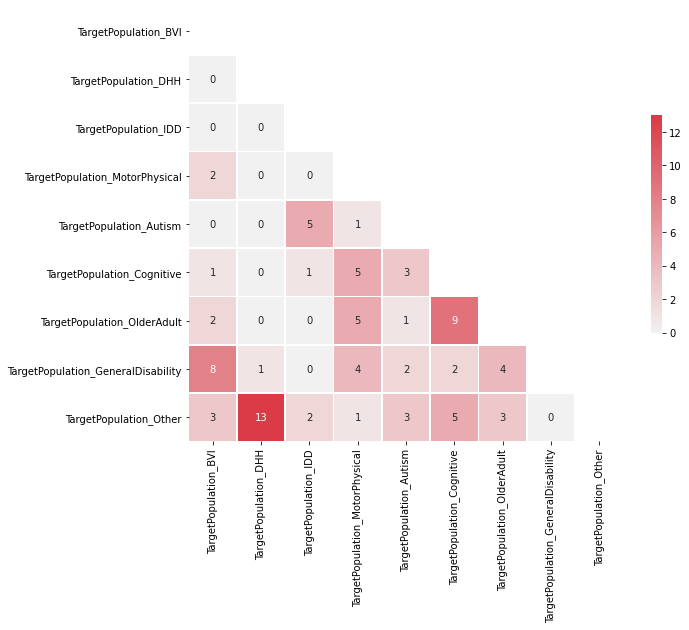

** Fraction of sub-code co-occurrences for TargetPopulation **


TargetPopulation_BVI  \
TargetPopulation_BVI                            1.000000   
TargetPopulation_DHH                            0.000000   
TargetPopulation_IDD                            0.000000   
TargetPopulation_MotorPhysical                  0.027778   
TargetPopulation_Autism                         0.000000   
TargetPopulation_Cognitive                      0.021739   
TargetPopulation_OlderAdult                     0.044444   
TargetPopulation_GeneralDisability              0.173913   
TargetPopulation_Other                          0.065217   

                                    TargetPopulation_DHH  \
TargetPopulation_BVI                            0.000000   
TargetPopulation_DHH                            1.000000   
TargetPopulation_IDD                            0.000000   
TargetPopulation_MotorPhysical                  0.000000   
TargetPopulation_Autism                         0.000000   
TargetPopulation_Cognitive                      0.000000   
TargetPopulation_OlderAdult                     0.000000   
TargetPopulation_GeneralDisability              0.021739   
TargetPopulation_Other                          0.282609   

                                    TargetPopulation_IDD  \
TargetPopulation_BVI                            0.000000   
TargetPopulation_DHH                            0.000000   
TargetPopulation_IDD                            1.000000   
TargetPopulation_MotorPhysical                  0.000000   
TargetPopulation_Autism                         0.161290   
TargetPopulation_Cognitive                      0.021739   
TargetPopulation_OlderAdult                     0.000000   
TargetPopulation_GeneralDisability              0.000000   
TargetPopulation_Other                          0.043478   

                                    TargetPopulation_MotorPhysical  \
TargetPopulation_BVI                                      0.009091   
TargetPopulation_DHH                                      0.000000   
TargetPopulation_IDD                                      0.000000   
TargetPopulation_MotorPhysical                            1.000000   
TargetPopulation_Autism                                   0.032258   
TargetPopulation_Cognitive                                0.108696   
TargetPopulation_OlderAdult                               0.111111   
TargetPopulation_GeneralDisability                        0.086957   
TargetPopulation_Other                                    0.021739   

                                    TargetPopulation_Autism  \
TargetPopulation_BVI                               0.000000   
TargetPopulation_DHH                               0.000000   
TargetPopulation_IDD                               0.357143   
TargetPopulation_MotorPhysical                     0.013889   
TargetPopulation_Autism                            1.000000   
TargetPopulation_Cognitive                         0.065217   
TargetPopulation_OlderAdult                        0.022222   
TargetPopulation_GeneralDisability                 0.043478   
TargetPopulation_Other                             0.065217   

                                    TargetPopulation_Cognitive  \
TargetPopulation_BVI                                  0.004545   
TargetPopulation_DHH                                  0.000000   
TargetPopulation_IDD                                  0.071429   
TargetPopulation_MotorPhysical                        0.069444   
TargetPopulation_Autism                               0.096774   
TargetPopulation_Cognitive                            1.000000   
TargetPopulation_OlderAdult                           0.200000   
TargetPopulation_GeneralDisability                    0.043478   
TargetPopulation_Other                                0.108696   

                                    TargetPopulation_OlderAdult  \
TargetPopulation_BVI                                   0.009091   
TargetPopulation_DHH                                   0.000000   
TargetPopulation_IDD                   

Read the co-occurrence matrix column-to-row. For example:
TargetPopulation_DHH (column) occurs 0 times in 220 TargetPopulation_BVI (row) instances 0.00%
TargetPopulation_BVI (column) occurs 0 times in 57 TargetPopulation_DHH (row) instances 0.00%
TargetPopulation_Other (column) occurs 0 times in 46 TargetPopulation_GeneralDisability (row) instances 0.00%
TargetPopulation_GeneralDisability (column) occurs 0 times in 46 TargetPopulation_Other (row) instances 0.00%
TargetPopulation_GeneralDisability (column) occurs 1 times in 57 TargetPopulation_DHH (row) instances 1.75%
TargetPopulation_DHH (column) occurs 1 times in 46 TargetPopulation_GeneralDisability (row) instances 2.17%



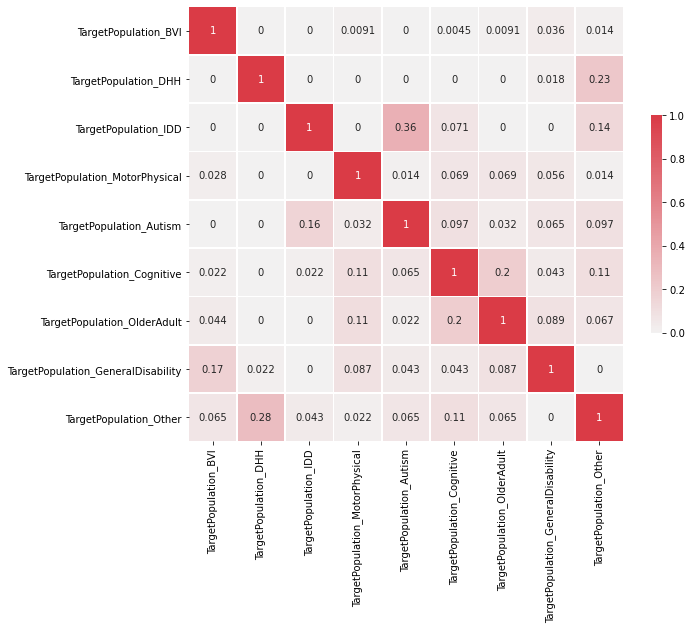



******** StudyMethod *******

** Raw sub-code co-occurrence count for StudyMethod **


StudyMethod_ControlledExperiment  \
StudyMethod_ControlledExperiment                               167   
StudyMethod_SurveyMethod                                        44   
StudyMethod_UsabilityTesting                                    62   
StudyMethod_Interviews                                          47   
StudyMethod_CaseStudy                                            4   
StudyMethod_FocusGroups                                          3   
StudyMethod_FieldStudy                                           3   
StudyMethod_WorkshopDesign                                      13   
StudyMethod_Other                                               17   

                                  StudyMethod_SurveyMethod  \
StudyMethod_ControlledExperiment                        44   
StudyMethod_SurveyMethod                               122   
StudyMethod_UsabilityTesting                            55   
StudyMethod_Interviews                                  63   
StudyMethod_CaseStudy                                    2   
StudyMethod_FocusGroups                                  6   
StudyMethod_FieldStudy                                  25   
StudyMethod_WorkshopDesign                              16   
StudyMethod_Other                                       21   

                                  StudyMethod_UsabilityTesting  \
StudyMethod_ControlledExperiment                            62   
StudyMethod_SurveyMethod                                    55   
StudyMethod_UsabilityTesting                               199   
StudyMethod_Interviews                                      83   
StudyMethod_CaseStudy                                        6   
StudyMethod_FocusGroups                                      9   
StudyMethod_FieldStudy                                      17   
StudyMethod_WorkshopDesign                                  34   
StudyMethod_Other                                           28   

                                  StudyMethod_Interviews  \
StudyMethod_ControlledExperiment                      47   
StudyMethod_SurveyMethod                              63   
StudyMethod_UsabilityTesting                          83   
StudyMethod_Interviews                               201   
StudyMethod_CaseStudy                                 13   
StudyMethod_FocusGroups                               11   
StudyMethod_FieldStudy                                48   
StudyMethod_WorkshopDesign                            49   
StudyMethod_Other                                     42   

                                  StudyMethod_CaseStudy  \
StudyMethod_ControlledExperiment                      4   
StudyMethod_SurveyMethod                              2   
StudyMethod_UsabilityTesting                          6   
StudyMethod_Interviews                               13   
StudyMethod_CaseStudy                                25   
StudyMethod_FocusGroups                               1   
StudyMethod_FieldStudy                                7   
StudyMethod_WorkshopDesign                            8   
StudyMethod_Other                                     5   

                                  StudyMethod_FocusGroups  \
StudyMethod_ControlledExperiment                        3   
StudyMethod_SurveyMethod                                6   
StudyMethod_UsabilityTesting                            9   
StudyMethod_Interviews                                 11   
StudyMethod_CaseStudy                                   1   
StudyMethod_FocusGroups                                28   
StudyMethod_FieldStudy                                  6   
StudyMethod_WorkshopDesign                              8   
StudyMethod_Other                                       4   

                                  StudyMethod_FieldStudy  \
StudyMethod_ControlledExperiment                       3   
StudyMethod_SurveyMethod                              25   
StudyMethod_UsabilityTesting                          17   
StudyMet

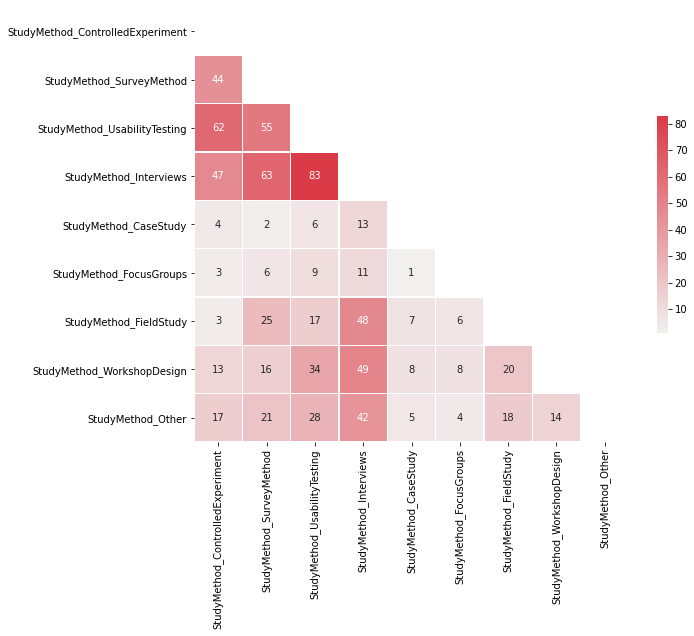

** Fraction of sub-code co-occurrences for StudyMethod **


StudyMethod_ControlledExperiment  \
StudyMethod_ControlledExperiment                          1.000000   
StudyMethod_SurveyMethod                                  0.360656   
StudyMethod_UsabilityTesting                              0.311558   
StudyMethod_Interviews                                    0.233831   
StudyMethod_CaseStudy                                     0.160000   
StudyMethod_FocusGroups                                   0.107143   
StudyMethod_FieldStudy                                    0.035294   
StudyMethod_WorkshopDesign                                0.147727   
StudyMethod_Other                                         0.171717   

                                  StudyMethod_SurveyMethod  \
StudyMethod_ControlledExperiment                  0.263473   
StudyMethod_SurveyMethod                          1.000000   
StudyMethod_UsabilityTesting                      0.276382   
StudyMethod_Interviews                            0.313433   
StudyMethod_CaseStudy                             0.080000   
StudyMethod_FocusGroups                           0.214286   
StudyMethod_FieldStudy                            0.294118   
StudyMethod_WorkshopDesign                        0.181818   
StudyMethod_Other                                 0.212121   

                                  StudyMethod_UsabilityTesting  \
StudyMethod_ControlledExperiment                      0.371257   
StudyMethod_SurveyMethod                              0.450820   
StudyMethod_UsabilityTesting                          1.000000   
StudyMethod_Interviews                                0.412935   
StudyMethod_CaseStudy                                 0.240000   
StudyMethod_FocusGroups                               0.321429   
StudyMethod_FieldStudy                                0.200000   
StudyMethod_WorkshopDesign                            0.386364   
StudyMethod_Other                                     0.282828   

                                  StudyMethod_Interviews  \
StudyMethod_ControlledExperiment                0.281437   
StudyMethod_SurveyMethod                        0.516393   
StudyMethod_UsabilityTesting                    0.417085   
StudyMethod_Interviews                          1.000000   
StudyMethod_CaseStudy                           0.520000   
StudyMethod_FocusGroups                         0.392857   
StudyMethod_FieldStudy                          0.564706   
StudyMethod_WorkshopDesign                      0.556818   
StudyMethod_Other                               0.424242   

                                  StudyMethod_CaseStudy  \
StudyMethod_ControlledExperiment               0.023952   
StudyMethod_SurveyMethod                       0.016393   
StudyMethod_UsabilityTesting                   0.030151   
StudyMethod_Interviews                         0.064677   
StudyMethod_CaseStudy                          1.000000   
StudyMethod_FocusGroups                        0.035714   
StudyMethod_FieldStudy                         0.082353   
StudyMethod_WorkshopDesign                     0.090909   
StudyMethod_Other                              0.050505   

                                  StudyMethod_FocusGroups  \
StudyMethod_ControlledExperiment                 0.017964   
StudyMethod_SurveyMethod                         0.049180   
StudyMethod_UsabilityTesting                     0.045226   
StudyMethod_Interviews                           0.054726   
StudyMethod_CaseStudy                            0.040000   
StudyMethod_FocusGroups                          1.000000   
StudyMethod_FieldStudy                           0.070588   
StudyMethod_WorkshopDesign                       0.090909   
StudyMethod_Other                                0.040404   

                                  StudyMethod_FieldStudy  \
StudyMethod_ControlledExperiment                0.017964   
StudyMethod_SurveyMethod                        0.204918   
StudyMethod_UsabilityTesting                    0.085427   
StudyMet

Read the co-occurrence matrix column-to-row. For example:
StudyMethod_FocusGroups (column) occurs 6 times in 85 StudyMethod_FieldStudy (row) instances 7.06%
StudyMethod_FieldStudy (column) occurs 6 times in 28 StudyMethod_FocusGroups (row) instances 21.43%
StudyMethod_CaseStudy (column) occurs 13 times in 201 StudyMethod_Interviews (row) instances 6.47%
StudyMethod_Interviews (column) occurs 13 times in 25 StudyMethod_CaseStudy (row) instances 52.00%
StudyMethod_SurveyMethod (column) occurs 21 times in 99 StudyMethod_Other (row) instances 21.21%
StudyMethod_Other (column) occurs 21 times in 122 StudyMethod_SurveyMethod (row) instances 17.21%



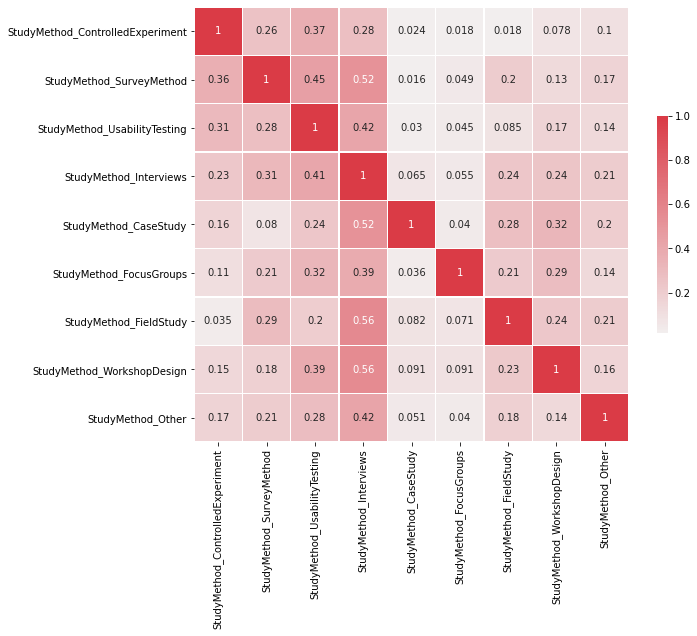



******** ParticipatoryDesign *******

** Raw sub-code co-occurrence count for ParticipatoryDesign **


ParticipatoryDesign_Yes  ParticipatoryDesign_No
ParticipatoryDesign_Yes                       49                       0
ParticipatoryDesign_No                         0                     457

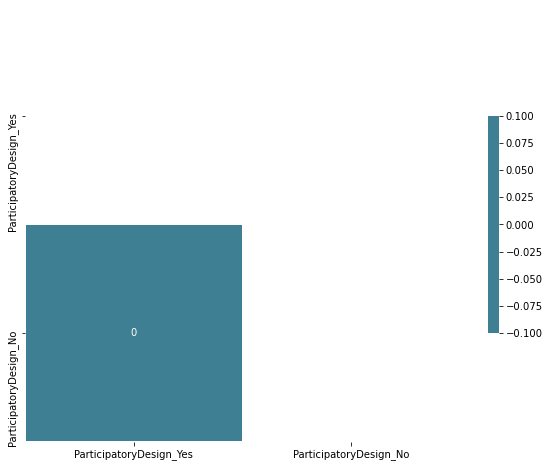

** Fraction of sub-code co-occurrences for ParticipatoryDesign **


ParticipatoryDesign_Yes  ParticipatoryDesign_No
ParticipatoryDesign_Yes                      1.0                     0.0
ParticipatoryDesign_No                       0.0                     1.0

Read the co-occurrence matrix column-to-row. For example:
ParticipatoryDesign_No (column) occurs 457 times in 457 ParticipatoryDesign_No (row) instances 100.00%
ParticipatoryDesign_No (column) occurs 457 times in 457 ParticipatoryDesign_No (row) instances 100.00%
ParticipatoryDesign_No (column) occurs 457 times in 457 ParticipatoryDesign_No (row) instances 100.00%
ParticipatoryDesign_No (column) occurs 457 times in 457 ParticipatoryDesign_No (row) instances 100.00%
ParticipatoryDesign_Yes (column) occurs 0 times in 457 ParticipatoryDesign_No (row) instances 0.00%
ParticipatoryDesign_No (column) occurs 0 times in 49 ParticipatoryDesign_Yes (row) instances 0.00%



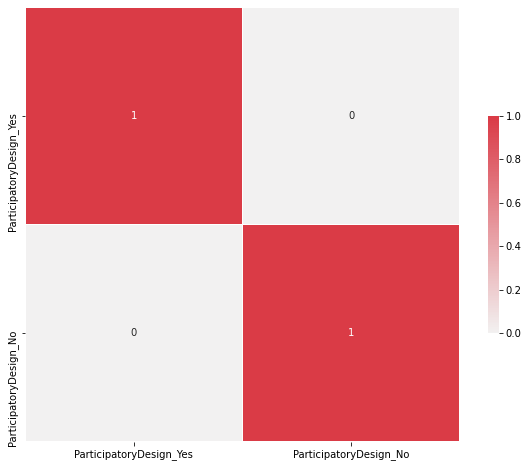



******** StudyLocation *******

** Raw sub-code co-occurrence count for StudyLocation **


StudyLocation_NearAtLab  \
StudyLocation_NearAtLab                                      130   
StudyLocation_ParticipantsHomeOrFreqLoc                       20   
StudyLocation_NeutralLocation                                  4   
StudyLocation_Unclear                                         10   
StudyLocation_OnlineRemotely                                  12   
StudyLocation_Other                                            0   
StudyLocation_NoUserStudy                                      0   

                                         StudyLocation_ParticipantsHomeOrFreqLoc  \
StudyLocation_NearAtLab                                                       20   
StudyLocation_ParticipantsHomeOrFreqLoc                                      138   
StudyLocation_NeutralLocation                                                  8   
StudyLocation_Unclear                                                         19   
StudyLocation_OnlineRemotely                                                  16   
StudyLocation_Other                                                            4   
StudyLocation_NoUserStudy                                                      0   

                                         StudyLocation_NeutralLocation  \
StudyLocation_NearAtLab                                              4   
StudyLocation_ParticipantsHomeOrFreqLoc                              8   
StudyLocation_NeutralLocation                                       32   
StudyLocation_Unclear                                                6   
StudyLocation_OnlineRemotely                                         4   
StudyLocation_Other                                                  1   
StudyLocation_NoUserStudy                                            0   

                                         StudyLocation_Unclear  \
StudyLocation_NearAtLab                                     10   
StudyLocation_ParticipantsHomeOrFreqLoc                     19   
StudyLocation_NeutralLocation                                6   
StudyLocation_Unclear                                      189   
StudyLocation_OnlineRemotely                                25   
StudyLocation_Other                                          4   
StudyLocation_NoUserStudy                                    0   

                                         StudyLocation_OnlineRemotely  \
StudyLocation_NearAtLab                                            12   
StudyLocation_ParticipantsHomeOrFreqLoc                            16   
StudyLocation_NeutralLocation                                       4   
StudyLocation_Unclear                                              25   
StudyLocation_OnlineRemotely                                       98   
StudyLocation_Other                                                 0   
StudyLocation_NoUserStudy                                           0   

                                         StudyLocation_Other  \
StudyLocation_NearAtLab                                    0   
StudyLocation_ParticipantsHomeOrFreqLoc                    4   
StudyLocation_NeutralLocation                              1   
StudyLocation_Unclear                                      4   
StudyLocation_OnlineRemotely                               0   
StudyLocation_Other                                        7   
StudyLocation_NoUserStudy                                  0   

                                         StudyLocation_NoUserStudy  
StudyLocation_NearAtLab                                          0  
StudyLocation_ParticipantsHomeOrFreqLoc                          0  
StudyLocation_NeutralLocation                                    0  
StudyLocation_Unclear                                            0  
StudyLocation_OnlineRemotely                                     0  
StudyLocation_Other                                              0  
StudyLocation_NoUserStudy                                       29

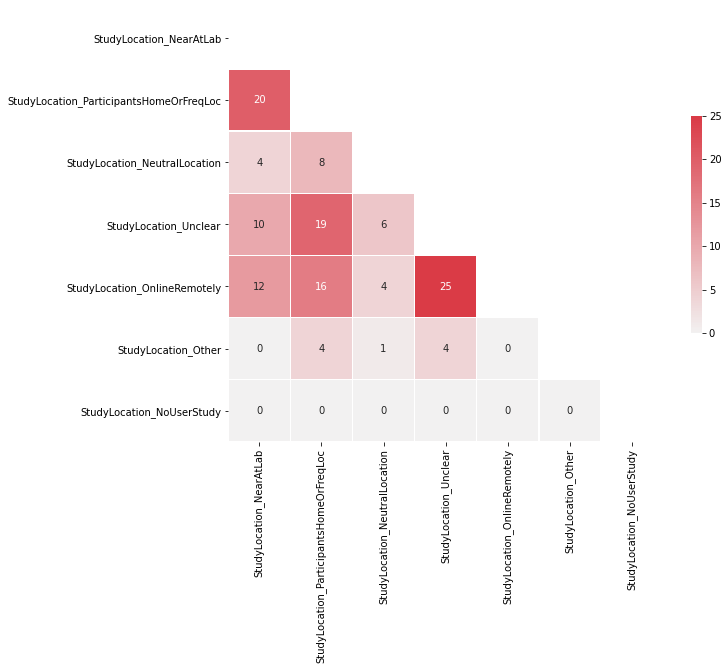

** Fraction of sub-code co-occurrences for StudyLocation **


StudyLocation_NearAtLab  \
StudyLocation_NearAtLab                                 1.000000   
StudyLocation_ParticipantsHomeOrFreqLoc                 0.144928   
StudyLocation_NeutralLocation                           0.125000   
StudyLocation_Unclear                                   0.052910   
StudyLocation_OnlineRemotely                            0.122449   
StudyLocation_Other                                     0.000000   
StudyLocation_NoUserStudy                               0.000000   

                                         StudyLocation_ParticipantsHomeOrFreqLoc  \
StudyLocation_NearAtLab                                                 0.153846   
StudyLocation_ParticipantsHomeOrFreqLoc                                 1.000000   
StudyLocation_NeutralLocation                                           0.250000   
StudyLocation_Unclear                                                   0.100529   
StudyLocation_OnlineRemotely                                            0.163265   
StudyLocation_Other                                                     0.571429   
StudyLocation_NoUserStudy                                               0.000000   

                                         StudyLocation_NeutralLocation  \
StudyLocation_NearAtLab                                       0.030769   
StudyLocation_ParticipantsHomeOrFreqLoc                       0.057971   
StudyLocation_NeutralLocation                                 1.000000   
StudyLocation_Unclear                                         0.031746   
StudyLocation_OnlineRemotely                                  0.040816   
StudyLocation_Other                                           0.142857   
StudyLocation_NoUserStudy                                     0.000000   

                                         StudyLocation_Unclear  \
StudyLocation_NearAtLab                               0.076923   
StudyLocation_ParticipantsHomeOrFreqLoc               0.137681   
StudyLocation_NeutralLocation                         0.187500   
StudyLocation_Unclear                                 1.000000   
StudyLocation_OnlineRemotely                          0.255102   
StudyLocation_Other                                   0.571429   
StudyLocation_NoUserStudy                             0.000000   

                                         StudyLocation_OnlineRemotely  \
StudyLocation_NearAtLab                                      0.092308   
StudyLocation_ParticipantsHomeOrFreqLoc                      0.115942   
StudyLocation_NeutralLocation                                0.125000   
StudyLocation_Unclear                                        0.132275   
StudyLocation_OnlineRemotely                                 1.000000   
StudyLocation_Other                                          0.000000   
StudyLocation_NoUserStudy                                    0.000000   

                                         StudyLocation_Other  \
StudyLocation_NearAtLab                             0.000000   
StudyLocation_ParticipantsHomeOrFreqLoc             0.028986   
StudyLocation_NeutralLocation                       0.031250   
StudyLocation_Unclear                               0.021164   
StudyLocation_OnlineRemotely                        0.000000   
StudyLocation_Other                                 1.000000   
StudyLocation_NoUserStudy                           0.000000   

                                         StudyLocation_NoUserStudy  
StudyLocation_NearAtLab                                        0.0  
StudyLocation_ParticipantsHomeOrFreqLoc                        0.0  
StudyLocation_NeutralLocation                                  0.0  
StudyLocation_Unclear                                          0.0  
StudyLocation_OnlineRemotely                                   0.0  
StudyLocation_Other                                            0.0  
StudyLocation_NoUserStudy                                      1.0

Read the co-occurrence matrix column-to-row. For example:
StudyLocation_NearAtLab (column) occurs 4 times in 32 StudyLocation_NeutralLocation (row) instances 12.50%
StudyLocation_NeutralLocation (column) occurs 4 times in 130 StudyLocation_NearAtLab (row) instances 3.08%
StudyLocation_OnlineRemotely (column) occurs 25 times in 189 StudyLocation_Unclear (row) instances 13.23%
StudyLocation_Unclear (column) occurs 25 times in 98 StudyLocation_OnlineRemotely (row) instances 25.51%
StudyLocation_Unclear (column) occurs 0 times in 29 StudyLocation_NoUserStudy (row) instances 0.00%
StudyLocation_NoUserStudy (column) occurs 0 times in 189 StudyLocation_Unclear (row) instances 0.00%



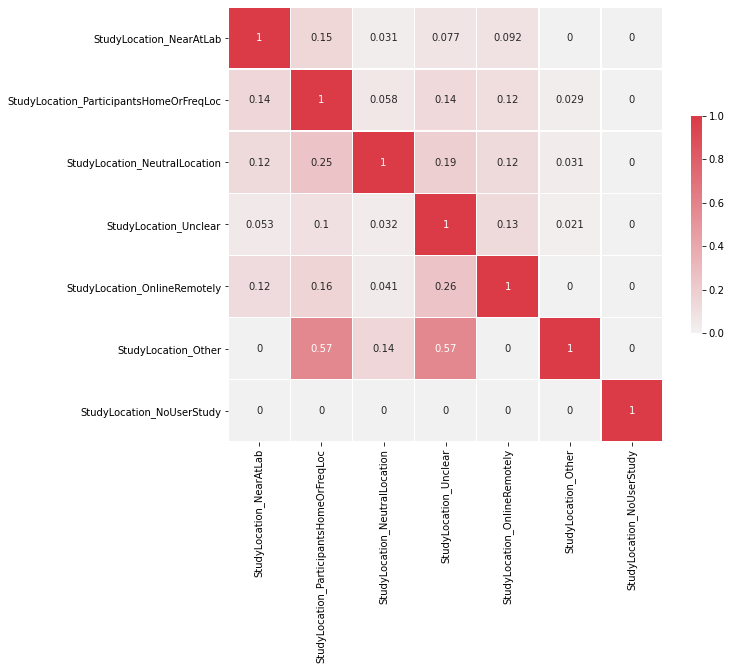



******** ParticipantGroup *******

** Raw sub-code co-occurrence count for ParticipantGroup **


ParticipantGroup_OlderAdult  \
ParticipantGroup_OlderAdult                                        40   
ParticipantGroup_PeopleWithDisability                              14   
ParticipantGroup_PeopleWithoutDisability                           11   
ParticipantGroup_TherapistsSpecialists                              2   
ParticipantGroup_Caregivers                                         5   
ParticipantGroup_Other                                              3   
ParticipantGroup_NoUserStudy                                        0   

                                          ParticipantGroup_PeopleWithDisability  \
ParticipantGroup_OlderAdult                                                  14   
ParticipantGroup_PeopleWithDisability                                       404   
ParticipantGroup_PeopleWithoutDisability                                     93   
ParticipantGroup_TherapistsSpecialists                                       67   
ParticipantGroup_Caregivers                                                  38   
ParticipantGroup_Other                                                       25   
ParticipantGroup_NoUserStudy                                                  0   

                                          ParticipantGroup_PeopleWithoutDisability  \
ParticipantGroup_OlderAdult                                                     11   
ParticipantGroup_PeopleWithDisability                                           93   
ParticipantGroup_PeopleWithoutDisability                                       110   
ParticipantGroup_TherapistsSpecialists                                          12   
ParticipantGroup_Caregivers                                                     10   
ParticipantGroup_Other                                                           5   
ParticipantGroup_NoUserStudy                                                     0   

                                          ParticipantGroup_TherapistsSpecialists  \
ParticipantGroup_OlderAdult                                                    2   
ParticipantGroup_PeopleWithDisability                                         67   
ParticipantGroup_PeopleWithoutDisability                                      12   
ParticipantGroup_TherapistsSpecialists                                        81   
ParticipantGroup_Caregivers                                                   18   
ParticipantGroup_Other                                                         4   
ParticipantGroup_NoUserStudy                                                   0   

                                          ParticipantGroup_Caregivers  \
ParticipantGroup_OlderAdult                                         5   
ParticipantGroup_PeopleWithDisability                              38   
ParticipantGroup_PeopleWithoutDisability                           10   
ParticipantGroup_TherapistsSpecialists                             18   
ParticipantGroup_Caregivers                                        45   
ParticipantGroup_Other                                              3   
ParticipantGroup_NoUserStudy                                        0   

                                          ParticipantGroup_Other  \
ParticipantGroup_OlderAdult                                    3   
ParticipantGroup_PeopleWithDisability                         25   
ParticipantGroup_PeopleWithoutDisability                       5   
ParticipantGroup_TherapistsSpecialists                         4   
ParticipantGroup_Caregivers                                    3   
ParticipantGroup_Other                                        53   
ParticipantGroup_NoUserStudy                                   0   

                                          ParticipantGroup_NoUserStudy  
ParticipantGroup_OlderAdult                                          0  
ParticipantGroup_PeopleWithDisability                                0  
ParticipantGroup_PeopleWithoutDisability                             0  
Particip

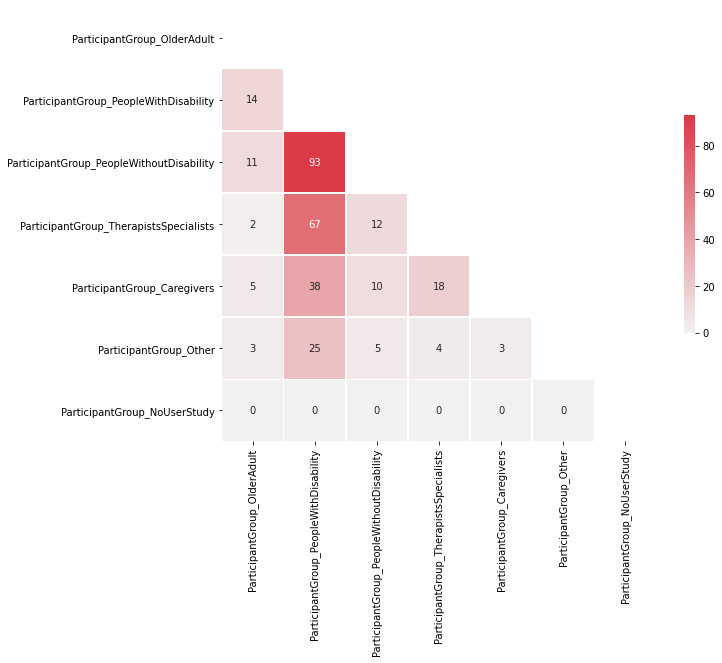

** Fraction of sub-code co-occurrences for ParticipantGroup **


ParticipantGroup_OlderAdult  \
ParticipantGroup_OlderAdult                                  1.000000   
ParticipantGroup_PeopleWithDisability                        0.034653   
ParticipantGroup_PeopleWithoutDisability                     0.100000   
ParticipantGroup_TherapistsSpecialists                       0.024691   
ParticipantGroup_Caregivers                                  0.111111   
ParticipantGroup_Other                                       0.056604   
ParticipantGroup_NoUserStudy                                 0.000000   

                                          ParticipantGroup_PeopleWithDisability  \
ParticipantGroup_OlderAdult                                            0.350000   
ParticipantGroup_PeopleWithDisability                                  1.000000   
ParticipantGroup_PeopleWithoutDisability                               0.845455   
ParticipantGroup_TherapistsSpecialists                                 0.827160   
ParticipantGroup_Caregivers                                            0.844444   
ParticipantGroup_Other                                                 0.471698   
ParticipantGroup_NoUserStudy                                           0.000000   

                                          ParticipantGroup_PeopleWithoutDisability  \
ParticipantGroup_OlderAdult                                               0.275000   
ParticipantGroup_PeopleWithDisability                                     0.230198   
ParticipantGroup_PeopleWithoutDisability                                  1.000000   
ParticipantGroup_TherapistsSpecialists                                    0.148148   
ParticipantGroup_Caregivers                                               0.222222   
ParticipantGroup_Other                                                    0.094340   
ParticipantGroup_NoUserStudy                                              0.000000   

                                          ParticipantGroup_TherapistsSpecialists  \
ParticipantGroup_OlderAdult                                             0.050000   
ParticipantGroup_PeopleWithDisability                                   0.165842   
ParticipantGroup_PeopleWithoutDisability                                0.109091   
ParticipantGroup_TherapistsSpecialists                                  1.000000   
ParticipantGroup_Caregivers                                             0.400000   
ParticipantGroup_Other                                                  0.075472   
ParticipantGroup_NoUserStudy                                            0.000000   

                                          ParticipantGroup_Caregivers  \
ParticipantGroup_OlderAdult                                  0.125000   
ParticipantGroup_PeopleWithDisability                        0.094059   
ParticipantGroup_PeopleWithoutDisability                     0.090909   
ParticipantGroup_TherapistsSpecialists                       0.222222   
ParticipantGroup_Caregivers                                  1.000000   
ParticipantGroup_Other                                       0.056604   
ParticipantGroup_NoUserStudy                                 0.000000   

                                          ParticipantGroup_Other  \
ParticipantGroup_OlderAdult                             0.075000   
ParticipantGroup_PeopleWithDisability                   0.061881   
ParticipantGroup_PeopleWithoutDisability                0.045455   
ParticipantGroup_TherapistsSpecialists                  0.049383   
ParticipantGroup_Caregivers                             0.066667   
ParticipantGroup_Other                                  1.000000   
ParticipantGroup_NoUserStudy                            0.000000   

                                          ParticipantGroup_NoUserStudy  
ParticipantGroup_OlderAdult                                        0.0  
ParticipantGroup_PeopleWithDisability                              0.0  
ParticipantGroup_PeopleWithoutDisability                           0.0  
Particip

Read the co-occurrence matrix column-to-row. For example:
ParticipantGroup_PeopleWithoutDisability (column) occurs 110 times in 110 ParticipantGroup_PeopleWithoutDisability (row) instances 100.00%
ParticipantGroup_PeopleWithoutDisability (column) occurs 110 times in 110 ParticipantGroup_PeopleWithoutDisability (row) instances 100.00%
ParticipantGroup_Caregivers (column) occurs 0 times in 29 ParticipantGroup_NoUserStudy (row) instances 0.00%
ParticipantGroup_NoUserStudy (column) occurs 0 times in 45 ParticipantGroup_Caregivers (row) instances 0.00%
ParticipantGroup_Other (column) occurs 3 times in 40 ParticipantGroup_OlderAdult (row) instances 7.50%
ParticipantGroup_OlderAdult (column) occurs 3 times in 53 ParticipantGroup_Other (row) instances 5.66%



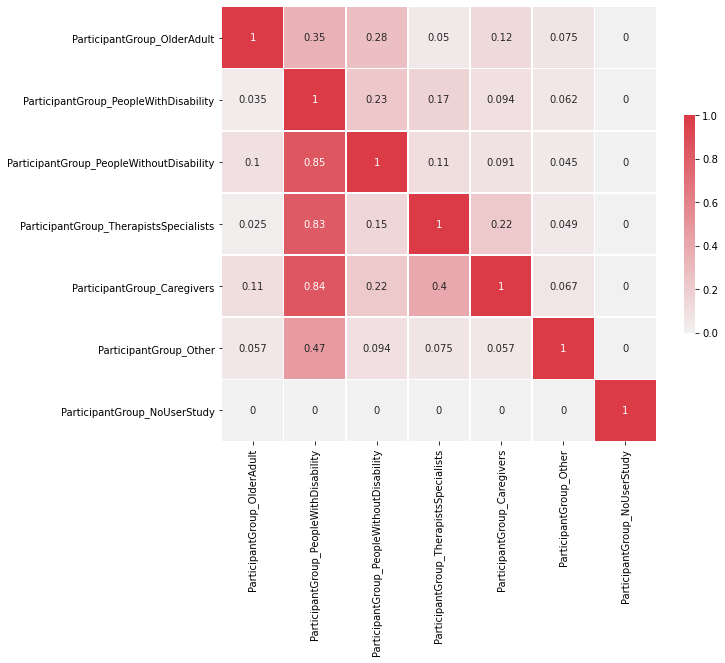



******** ComparesOnDisability *******

** Raw sub-code co-occurrence count for ComparesOnDisability **


ComparesOnDisability_Yes  ComparesOnDisability_No
ComparesOnDisability_Yes                        65                        0
ComparesOnDisability_No                          0                      441

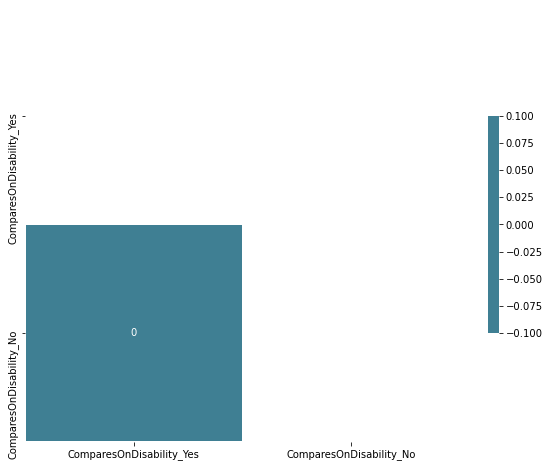

** Fraction of sub-code co-occurrences for ComparesOnDisability **


ComparesOnDisability_Yes  ComparesOnDisability_No
ComparesOnDisability_Yes                       1.0                      0.0
ComparesOnDisability_No                        0.0                      1.0

Read the co-occurrence matrix column-to-row. For example:
ComparesOnDisability_No (column) occurs 0 times in 65 ComparesOnDisability_Yes (row) instances 0.00%
ComparesOnDisability_Yes (column) occurs 0 times in 441 ComparesOnDisability_No (row) instances 0.00%
ComparesOnDisability_Yes (column) occurs 0 times in 441 ComparesOnDisability_No (row) instances 0.00%
ComparesOnDisability_No (column) occurs 0 times in 65 ComparesOnDisability_Yes (row) instances 0.00%
ComparesOnDisability_Yes (column) occurs 65 times in 65 ComparesOnDisability_Yes (row) instances 100.00%
ComparesOnDisability_Yes (column) occurs 65 times in 65 ComparesOnDisability_Yes (row) instances 100.00%



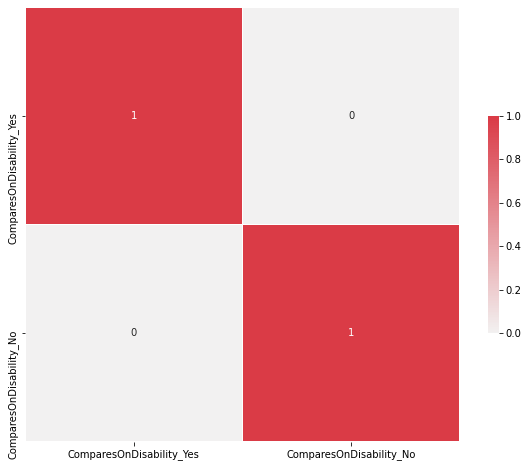



******** UsesProxies *******

** Raw sub-code co-occurrence count for UsesProxies **


UsesProxies_Yes  UsesProxies_No
UsesProxies_Yes               38               0
UsesProxies_No                 0             468

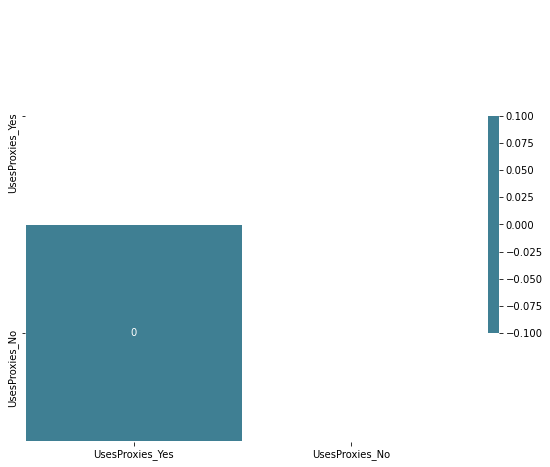

** Fraction of sub-code co-occurrences for UsesProxies **


UsesProxies_Yes  UsesProxies_No
UsesProxies_Yes              1.0             0.0
UsesProxies_No               0.0             1.0

Read the co-occurrence matrix column-to-row. For example:
UsesProxies_No (column) occurs 468 times in 468 UsesProxies_No (row) instances 100.00%
UsesProxies_No (column) occurs 468 times in 468 UsesProxies_No (row) instances 100.00%
UsesProxies_No (column) occurs 468 times in 468 UsesProxies_No (row) instances 100.00%
UsesProxies_No (column) occurs 468 times in 468 UsesProxies_No (row) instances 100.00%
UsesProxies_Yes (column) occurs 38 times in 38 UsesProxies_Yes (row) instances 100.00%
UsesProxies_Yes (column) occurs 38 times in 38 UsesProxies_Yes (row) instances 100.00%



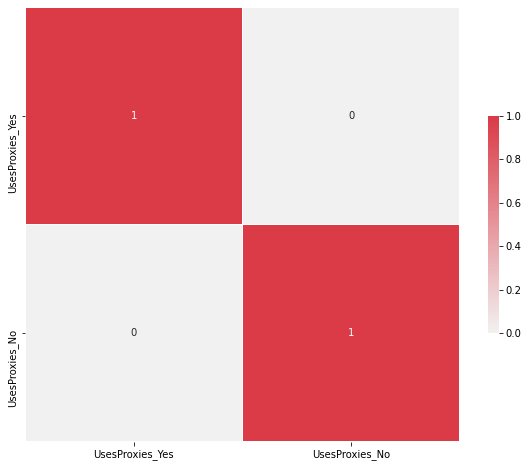



******** TechFocus *******

** Raw sub-code co-occurrence count for TechFocus **


TechFocus_SmartphoneTabletSmartwatch  \
TechFocus_SmartphoneTabletSmartwatch                                   156   
TechFocus_WebApp                                                         9   
TechFocus_DesktopApp                                                     8   
TechFocus_IotEnvironmentSensing                                          7   
TechFocus_VrArSolution                                                   3   
TechFocus_TangibleDeviceProsthesis                                      15   
TechFocus_PhysicallyFabricated                                          17   
TechFocus_NoTechFocus                                                    0   
TechFocus_Other                                                         27   

                                      TechFocus_WebApp  TechFocus_DesktopApp  \
TechFocus_SmartphoneTabletSmartwatch                 9                     8   
TechFocus_WebApp                                    63                     4   
TechFocus_DesktopApp                                 4                    54   
TechFocus_IotEnvironmentSensing                      0                     3   
TechFocus_VrArSolution                               0                     3   
TechFocus_TangibleDeviceProsthesis                   3                    10   
TechFocus_PhysicallyFabricated                       3                     5   
TechFocus_NoTechFocus                                0                     0   
TechFocus_Other                                     22                    15   

                                      TechFocus_IotEnvironmentSensing  \
TechFocus_SmartphoneTabletSmartwatch                                7   
TechFocus_WebApp                                                    0   
TechFocus_DesktopApp                                                3   
TechFocus_IotEnvironmentSensing                                    25   
TechFocus_VrArSolution                                              2   
TechFocus_TangibleDeviceProsthesis                                  5   
TechFocus_PhysicallyFabricated                                      2   
TechFocus_NoTechFocus                                               0   
TechFocus_Other                                                     4   

                                      TechFocus_VrArSolution  \
TechFocus_SmartphoneTabletSmartwatch                       3   
TechFocus_WebApp                                           0   
TechFocus_DesktopApp                                       3   
TechFocus_IotEnvironmentSensing                            2   
TechFocus_VrArSolution                                    40   
TechFocus_TangibleDeviceProsthesis                         4   
TechFocus_PhysicallyFabricated                             1   
TechFocus_NoTechFocus                                      0   
TechFocus_Other                                           12   

                                      TechFocus_TangibleDeviceProsthesis  \
TechFocus_SmartphoneTabletSmartwatch                                  15   
TechFocus_WebApp                                                       3   
TechFocus_DesktopApp                                                  10   
TechFocus_IotEnvironmentSensing                                        5   
TechFocus_VrArSolution                                                 4   
TechFocus_TangibleDeviceProsthesis                                    80   
TechFocus_PhysicallyFabricated                                        12   
TechFocus_NoTechFocus                                                  1   
TechFocus_Other                                                       12   

                                      TechFocus_PhysicallyFabricated  \
TechFocus_SmartphoneTabletSmartwatch                              17   
TechFocus_WebApp                                                   3   
TechFocus_DesktopApp                                               5   
TechFocus_IotEnvironmentSensing    

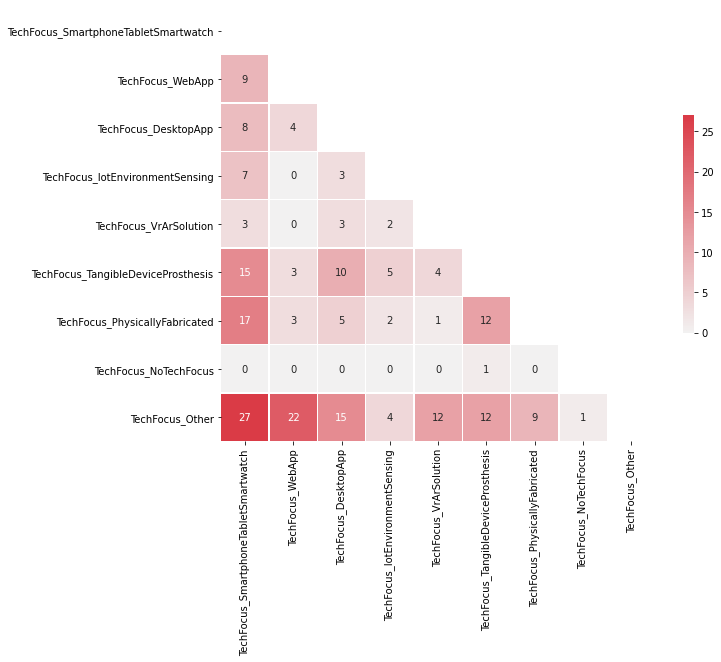

** Fraction of sub-code co-occurrences for TechFocus **


TechFocus_SmartphoneTabletSmartwatch  \
TechFocus_SmartphoneTabletSmartwatch                              1.000000   
TechFocus_WebApp                                                  0.142857   
TechFocus_DesktopApp                                              0.148148   
TechFocus_IotEnvironmentSensing                                   0.280000   
TechFocus_VrArSolution                                            0.075000   
TechFocus_TangibleDeviceProsthesis                                0.187500   
TechFocus_PhysicallyFabricated                                    0.414634   
TechFocus_NoTechFocus                                             0.000000   
TechFocus_Other                                                   0.146739   

                                      TechFocus_WebApp  TechFocus_DesktopApp  \
TechFocus_SmartphoneTabletSmartwatch          0.057692              0.051282   
TechFocus_WebApp                              1.000000              0.063492   
TechFocus_DesktopApp                          0.074074              1.000000   
TechFocus_IotEnvironmentSensing               0.000000              0.120000   
TechFocus_VrArSolution                        0.000000              0.075000   
TechFocus_TangibleDeviceProsthesis            0.037500              0.125000   
TechFocus_PhysicallyFabricated                0.073171              0.121951   
TechFocus_NoTechFocus                         0.000000              0.000000   
TechFocus_Other                               0.119565              0.081522   

                                      TechFocus_IotEnvironmentSensing  \
TechFocus_SmartphoneTabletSmartwatch                         0.044872   
TechFocus_WebApp                                             0.000000   
TechFocus_DesktopApp                                         0.055556   
TechFocus_IotEnvironmentSensing                              1.000000   
TechFocus_VrArSolution                                       0.050000   
TechFocus_TangibleDeviceProsthesis                           0.062500   
TechFocus_PhysicallyFabricated                               0.048780   
TechFocus_NoTechFocus                                        0.000000   
TechFocus_Other                                              0.021739   

                                      TechFocus_VrArSolution  \
TechFocus_SmartphoneTabletSmartwatch                0.019231   
TechFocus_WebApp                                    0.000000   
TechFocus_DesktopApp                                0.055556   
TechFocus_IotEnvironmentSensing                     0.080000   
TechFocus_VrArSolution                              1.000000   
TechFocus_TangibleDeviceProsthesis                  0.050000   
TechFocus_PhysicallyFabricated                      0.024390   
TechFocus_NoTechFocus                               0.000000   
TechFocus_Other                                     0.065217   

                                      TechFocus_TangibleDeviceProsthesis  \
TechFocus_SmartphoneTabletSmartwatch                            0.096154   
TechFocus_WebApp                                                0.047619   
TechFocus_DesktopApp                                            0.185185   
TechFocus_IotEnvironmentSensing                                 0.200000   
TechFocus_VrArSolution                                          0.100000   
TechFocus_TangibleDeviceProsthesis                              1.000000   
TechFocus_PhysicallyFabricated                                  0.292683   
TechFocus_NoTechFocus                                           0.026316   
TechFocus_Other                                                 0.065217   

                                      TechFocus_PhysicallyFabricated  \
TechFocus_SmartphoneTabletSmartwatch                        0.108974   
TechFocus_WebApp                                            0.047619   
TechFocus_DesktopApp                                        0.092593   
TechFocus_IotEnvironmentSensing    

Read the co-occurrence matrix column-to-row. For example:
TechFocus_NoTechFocus (column) occurs 0 times in 63 TechFocus_WebApp (row) instances 0.00%
TechFocus_WebApp (column) occurs 0 times in 38 TechFocus_NoTechFocus (row) instances 0.00%
TechFocus_VrArSolution (column) occurs 4 times in 80 TechFocus_TangibleDeviceProsthesis (row) instances 5.00%
TechFocus_TangibleDeviceProsthesis (column) occurs 4 times in 40 TechFocus_VrArSolution (row) instances 10.00%
TechFocus_VrArSolution (column) occurs 1 times in 41 TechFocus_PhysicallyFabricated (row) instances 2.44%
TechFocus_PhysicallyFabricated (column) occurs 1 times in 40 TechFocus_VrArSolution (row) instances 2.50%



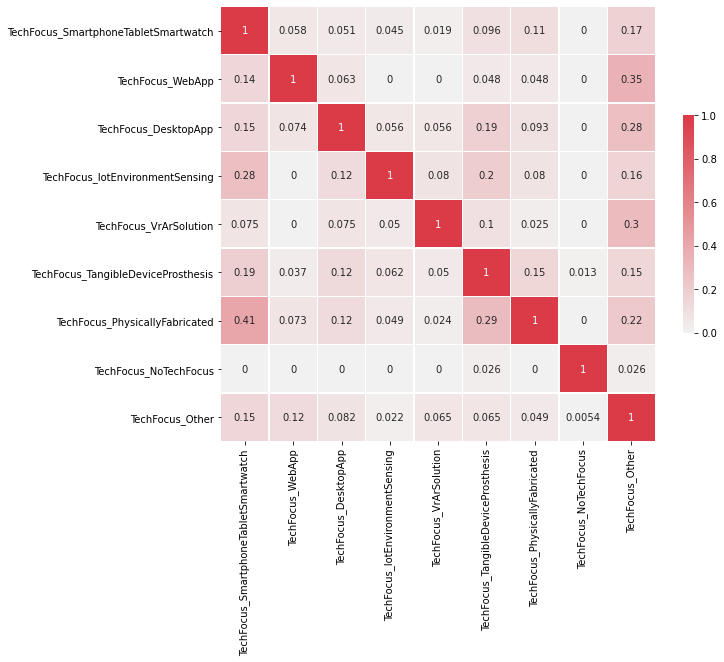



******** CountTechFocus *******

** Raw sub-code co-occurrence count for CountTechFocus **


CountTechFocus_ExcludingOther
CountTechFocus_ExcludingOther                            320

C:\Users\jonfr\Anaconda3\envs\qualitativeanalysis\lib\site-packages\seaborn\matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\jonfr\Anaconda3\envs\qualitativeanalysis\lib\site-packages\seaborn\matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


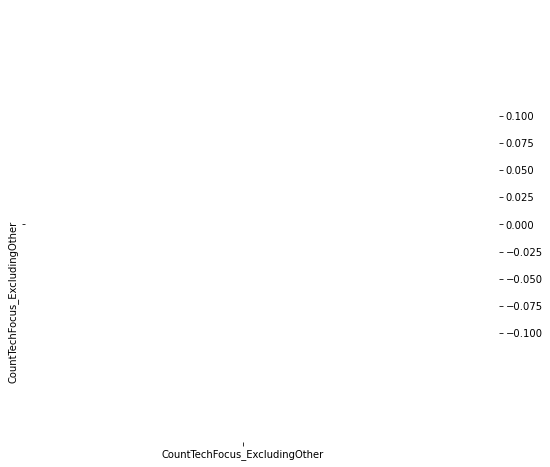

** Fraction of sub-code co-occurrences for CountTechFocus **


CountTechFocus_ExcludingOther
CountTechFocus_ExcludingOther                       0.643863

Read the co-occurrence matrix column-to-row. For example:
CountTechFocus_ExcludingOther (column) occurs 320 times in 497 CountTechFocus_ExcludingOther (row) instances 64.39%
CountTechFocus_ExcludingOther (column) occurs 320 times in 497 CountTechFocus_ExcludingOther (row) instances 64.39%
CountTechFocus_ExcludingOther (column) occurs 320 times in 497 CountTechFocus_ExcludingOther (row) instances 64.39%
CountTechFocus_ExcludingOther (column) occurs 320 times in 497 CountTechFocus_ExcludingOther (row) instances 64.39%
CountTechFocus_ExcludingOther (column) occurs 320 times in 497 CountTechFocus_ExcludingOther (row) instances 64.39%
CountTechFocus_ExcludingOther (column) occurs 320 times in 497 CountTechFocus_ExcludingOther (row) instances 64.39%



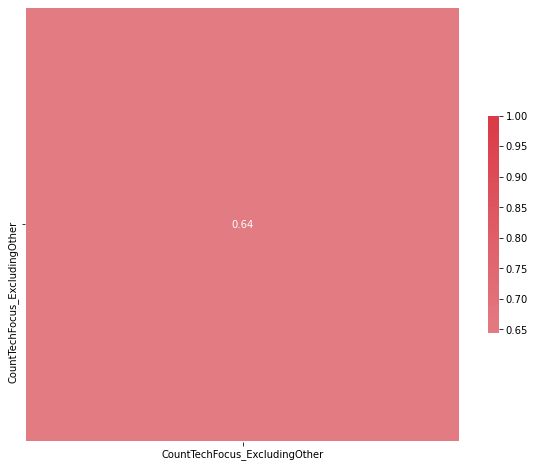



******** TechFocusOther *******

** Raw sub-code co-occurrence count for TechFocusOther **


TechFocusOther_Algo  TechFocusOther_General  \
TechFocusOther_Algo                           44                       0   
TechFocusOther_General                         0                      39   
TechFocusOther_TechAgnostic                    8                       1   

                             TechFocusOther_TechAgnostic  
TechFocusOther_Algo                                    8  
TechFocusOther_General                                 1  
TechFocusOther_TechAgnostic                           69

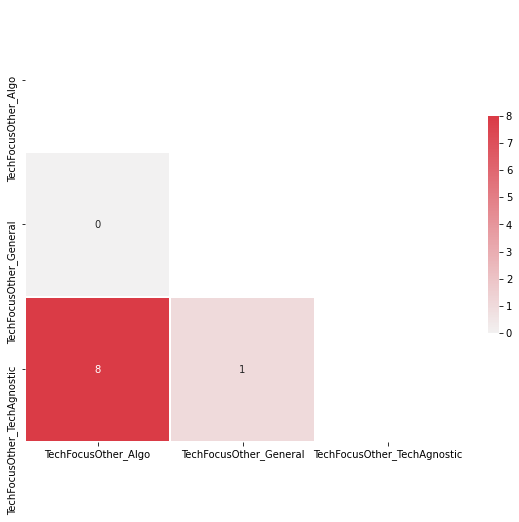

** Fraction of sub-code co-occurrences for TechFocusOther **


TechFocusOther_Algo  TechFocusOther_General  \
TechFocusOther_Algo                     1.000000                0.000000   
TechFocusOther_General                  0.000000                1.000000   
TechFocusOther_TechAgnostic             0.115942                0.014493   

                             TechFocusOther_TechAgnostic  
TechFocusOther_Algo                             0.181818  
TechFocusOther_General                          0.025641  
TechFocusOther_TechAgnostic                     1.000000

Read the co-occurrence matrix column-to-row. For example:
TechFocusOther_General (column) occurs 39 times in 39 TechFocusOther_General (row) instances 100.00%
TechFocusOther_General (column) occurs 39 times in 39 TechFocusOther_General (row) instances 100.00%
TechFocusOther_TechAgnostic (column) occurs 1 times in 39 TechFocusOther_General (row) instances 2.56%
TechFocusOther_General (column) occurs 1 times in 69 TechFocusOther_TechAgnostic (row) instances 1.45%
TechFocusOther_General (column) occurs 39 times in 39 TechFocusOther_General (row) instances 100.00%
TechFocusOther_General (column) occurs 39 times in 39 TechFocusOther_General (row) instances 100.00%



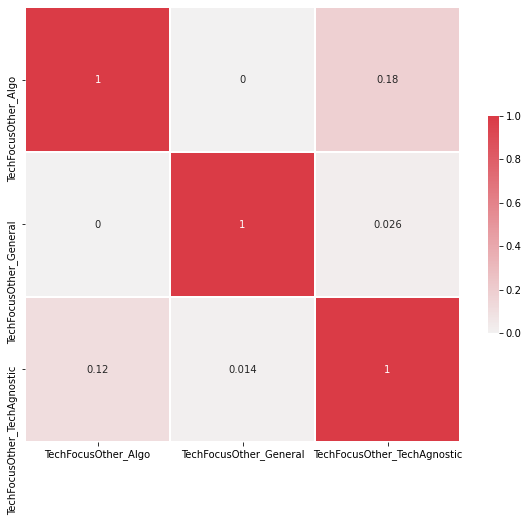



******** IssueAddressed *******

** Raw sub-code co-occurrence count for IssueAddressed **


IssueAddressed_IncreaseDigitalAccess  \
IssueAddressed_IncreaseDigitalAccess                                                 186   
IssueAddressed_IncreasePhysicalAccess                                                 13   
IssueAddressed_IncreaseIndependence                                                   14   
IssueAddressed_IncreaseUnderstandingOfUsers                                           24   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                     1   
IssueAddressed_SupportCommunication                                                   18   
IssueAddressed_Other                                                                  12   

                                                    IssueAddressed_IncreasePhysicalAccess  \
IssueAddressed_IncreaseDigitalAccess                                                   13   
IssueAddressed_IncreasePhysicalAccess                                                 105   
IssueAddressed_IncreaseIndependence                                                    62   
IssueAddressed_IncreaseUnderstandingOfUsers                                             6   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                      3   
IssueAddressed_SupportCommunication                                                     6   
IssueAddressed_Other                                                                    9   

                                                    IssueAddressed_IncreaseIndependence  \
IssueAddressed_IncreaseDigitalAccess                                                 14   
IssueAddressed_IncreasePhysicalAccess                                                62   
IssueAddressed_IncreaseIndependence                                                  93   
IssueAddressed_IncreaseUnderstandingOfUsers                                           4   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                    7   
IssueAddressed_SupportCommunication                                                   3   
IssueAddressed_Other                                                                  9   

                                                    IssueAddressed_IncreaseUnderstandingOfUsers  \
IssueAddressed_IncreaseDigitalAccess                                                         24   
IssueAddressed_IncreasePhysicalAccess                                                         6   
IssueAddressed_IncreaseIndependence                                                           4   
IssueAddressed_IncreaseUnderstandingOfUsers                                                 139   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                            2   
IssueAddressed_SupportCommunication                                                           9   
IssueAddressed_Other                                                                         14   

                                                    IssueAddressed_HelpWithPersonalInformaticsBehaviorChange  \
IssueAddressed_IncreaseDigitalAccess                                                                1          
IssueAddressed_IncreasePhysicalAccess                                                               3          
IssueAddressed_IncreaseIndependence                                                                 7          
IssueAddressed_IncreaseUnderstandingOfUsers                                                         2          
IssueAddressed_HelpWithPersonalInformaticsBehav...                                                 39          
IssueAddressed_SupportCommunication                                                                 5          
IssueAddressed_Other                                                                                4          

                                                    IssueAddressed_SupportCommunication  \
IssueAddressed_IncreaseDigitalAccess                        

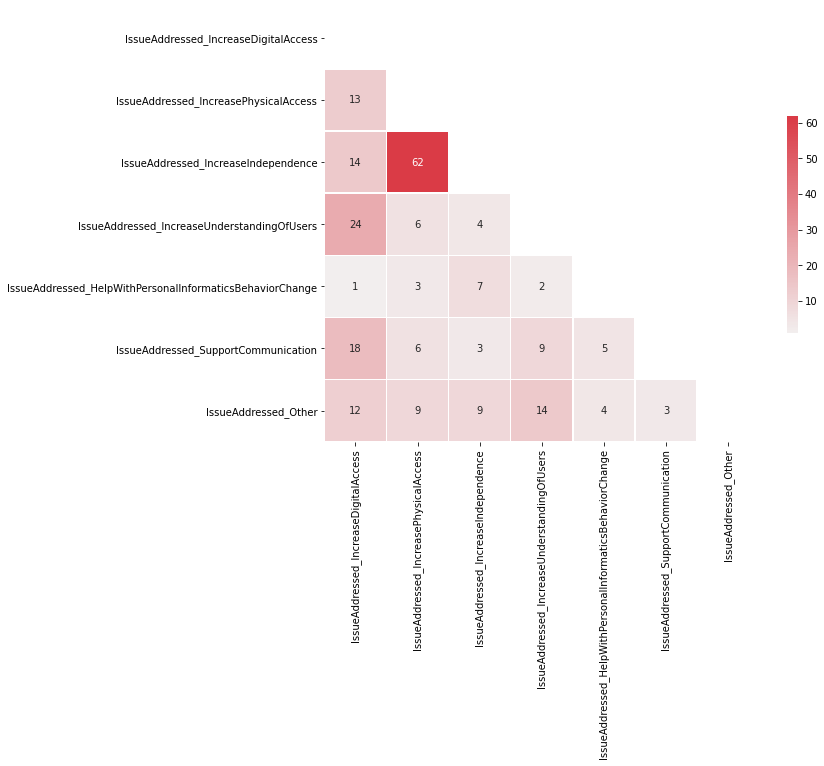

** Fraction of sub-code co-occurrences for IssueAddressed **


IssueAddressed_IncreaseDigitalAccess  \
IssueAddressed_IncreaseDigitalAccess                                            1.000000   
IssueAddressed_IncreasePhysicalAccess                                           0.123810   
IssueAddressed_IncreaseIndependence                                             0.150538   
IssueAddressed_IncreaseUnderstandingOfUsers                                     0.172662   
IssueAddressed_HelpWithPersonalInformaticsBehav...                              0.025641   
IssueAddressed_SupportCommunication                                             0.222222   
IssueAddressed_Other                                                            0.203390   

                                                    IssueAddressed_IncreasePhysicalAccess  \
IssueAddressed_IncreaseDigitalAccess                                             0.069892   
IssueAddressed_IncreasePhysicalAccess                                            1.000000   
IssueAddressed_IncreaseIndependence                                              0.666667   
IssueAddressed_IncreaseUnderstandingOfUsers                                      0.043165   
IssueAddressed_HelpWithPersonalInformaticsBehav...                               0.076923   
IssueAddressed_SupportCommunication                                              0.074074   
IssueAddressed_Other                                                             0.152542   

                                                    IssueAddressed_IncreaseIndependence  \
IssueAddressed_IncreaseDigitalAccess                                           0.075269   
IssueAddressed_IncreasePhysicalAccess                                          0.590476   
IssueAddressed_IncreaseIndependence                                            1.000000   
IssueAddressed_IncreaseUnderstandingOfUsers                                    0.028777   
IssueAddressed_HelpWithPersonalInformaticsBehav...                             0.179487   
IssueAddressed_SupportCommunication                                            0.037037   
IssueAddressed_Other                                                           0.152542   

                                                    IssueAddressed_IncreaseUnderstandingOfUsers  \
IssueAddressed_IncreaseDigitalAccess                                                   0.129032   
IssueAddressed_IncreasePhysicalAccess                                                  0.057143   
IssueAddressed_IncreaseIndependence                                                    0.043011   
IssueAddressed_IncreaseUnderstandingOfUsers                                            1.000000   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                     0.051282   
IssueAddressed_SupportCommunication                                                    0.111111   
IssueAddressed_Other                                                                   0.237288   

                                                    IssueAddressed_HelpWithPersonalInformaticsBehaviorChange  \
IssueAddressed_IncreaseDigitalAccess                                                         0.005376          
IssueAddressed_IncreasePhysicalAccess                                                        0.028571          
IssueAddressed_IncreaseIndependence                                                          0.075269          
IssueAddressed_IncreaseUnderstandingOfUsers                                                  0.014388          
IssueAddressed_HelpWithPersonalInformaticsBehav...                                           1.000000          
IssueAddressed_SupportCommunication                                                          0.061728          
IssueAddressed_Other                                                                         0.067797          

                                                    IssueAddressed_SupportCommunication  \
IssueAddressed_IncreaseDigitalAccess                        

Read the co-occurrence matrix column-to-row. For example:
IssueAddressed_IncreasePhysicalAccess (column) occurs 13 times in 186 IssueAddressed_IncreaseDigitalAccess (row) instances 6.99%
IssueAddressed_IncreaseDigitalAccess (column) occurs 13 times in 105 IssueAddressed_IncreasePhysicalAccess (row) instances 12.38%
IssueAddressed_SupportCommunication (column) occurs 81 times in 81 IssueAddressed_SupportCommunication (row) instances 100.00%
IssueAddressed_SupportCommunication (column) occurs 81 times in 81 IssueAddressed_SupportCommunication (row) instances 100.00%
IssueAddressed_IncreaseDigitalAccess (column) occurs 24 times in 139 IssueAddressed_IncreaseUnderstandingOfUsers (row) instances 17.27%
IssueAddressed_IncreaseUnderstandingOfUsers (column) occurs 24 times in 186 IssueAddressed_IncreaseDigitalAccess (row) instances 12.90%



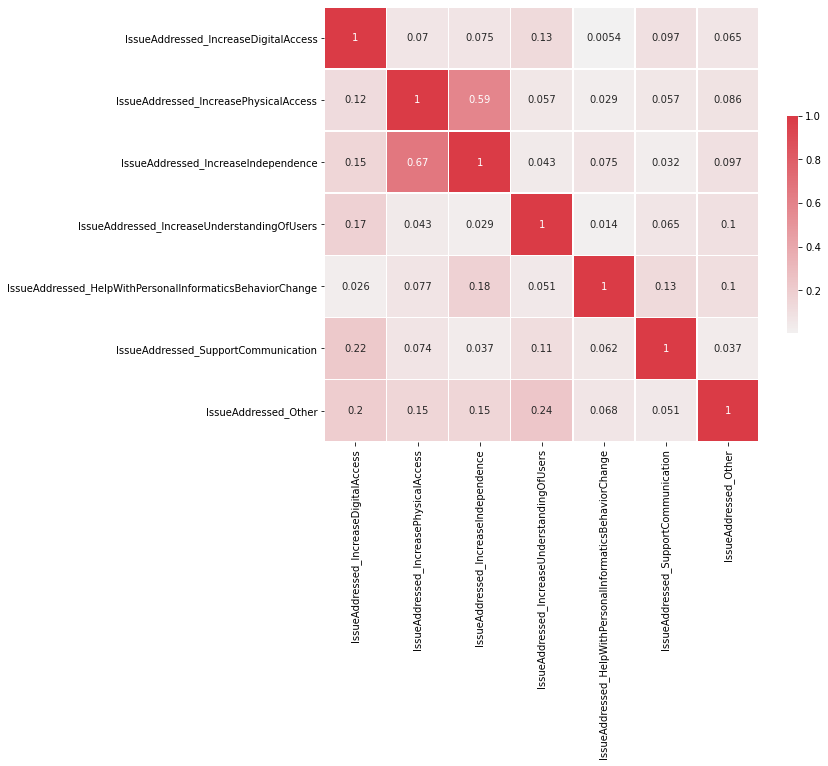



******** ContributionType *******

** Raw sub-code co-occurrence count for ContributionType **


<ipython-input-68-a5bca80c63bd>:25: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_fraction = co_occurrence_count / series_sum_subcode_occurrence[row]
<ipython-input-68-a5bca80c63bd>:25: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_fraction = co_occurrence_count / series_sum_subcode_occurrence[row]
<ipython-input-68-a5bca80c63bd>:25: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_fraction = co_occurrence_count / series_sum_subcode_occurrence[row]
<ipython-input-68-a5bca80c63bd>:25: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_fraction = co_occurrence_count / series_sum_subcode_occurrence[row]
<ipython-input-68-a5bca80c63bd>:25: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_fraction = co_occurrence_count / series_sum_subcode_occurrence[row]
<ipython-input-68-a5bca80c63bd>:25: RuntimeWarning: invalid value encountered in longlong_

ContributionType_Empirical  \
ContributionType_Empirical                                  305   
ContributionType_Artifact                                    93   
ContributionType_Methodological                              10   
ContributionType_Theoretical                                 33   
ContributionType_Dataset                                      4   
ContributionType_SurveyContribution                           1   
ContributionType_Opinion                                      0   
ContributionType_Other                                        0   

                                     ContributionType_Artifact  \
ContributionType_Empirical                                  93   
ContributionType_Artifact                                  281   
ContributionType_Methodological                              2   
ContributionType_Theoretical                                 7   
ContributionType_Dataset                                     2   
ContributionType_SurveyContribution                          0   
ContributionType_Opinion                                     0   
ContributionType_Other                                       0   

                                     ContributionType_Methodological  \
ContributionType_Empirical                                        10   
ContributionType_Artifact                                          2   
ContributionType_Methodological                                   16   
ContributionType_Theoretical                                       1   
ContributionType_Dataset                                           1   
ContributionType_SurveyContribution                                3   
ContributionType_Opinion                                           0   
ContributionType_Other                                             0   

                                     ContributionType_Theoretical  \
ContributionType_Empirical                                     33   
ContributionType_Artifact                                       7   
ContributionType_Methodological                                 1   
ContributionType_Theoretical                                   44   
ContributionType_Dataset                                        0   
ContributionType_SurveyContribution                             0   
ContributionType_Opinion                                        0   
ContributionType_Other                                          0   

                                     ContributionType_Dataset  \
ContributionType_Empirical                                  4   
ContributionType_Artifact                                   2   
ContributionType_Methodological                             1   
ContributionType_Theoretical                                0   
ContributionType_Dataset                                    7   
ContributionType_SurveyContribution                         0   
ContributionType_Opinion                                    0   
ContributionType_Other                                      0   

                                     ContributionType_SurveyContribution  \
ContributionType_Empirical                                             1   
ContributionType_Artifact                                              0   
ContributionType_Methodological                                        3   
ContributionType_Theoretical                                           0   
ContributionType_Dataset                                               0   
ContributionType_SurveyContribution                                    3   
ContributionType_Opinion                                               0   
ContributionType_Other                                                 0   

                                     ContributionType_Opinion  \
ContributionType_Empirical                                  0   
ContributionType_Artifact                                   0   
ContributionType_Methodological                             0   
ContributionType_Theoretical        

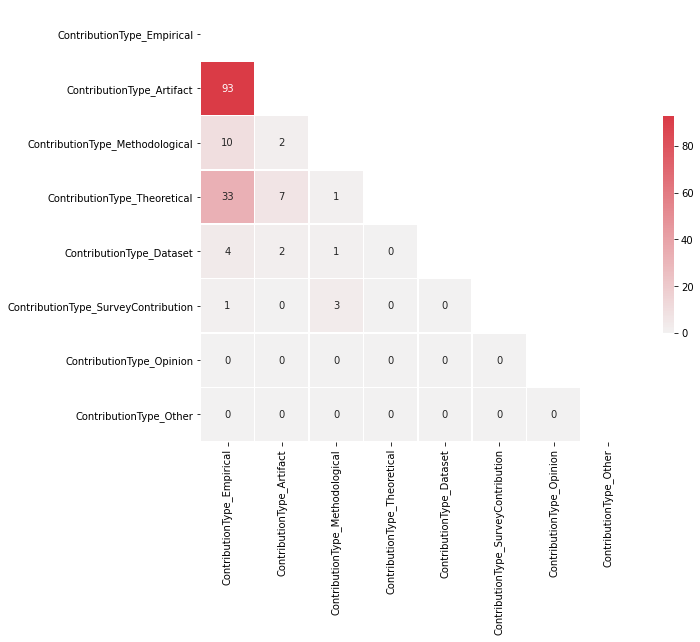

** Fraction of sub-code co-occurrences for ContributionType **


ContributionType_Empirical  \
ContributionType_Empirical                             1.000000   
ContributionType_Artifact                              0.330961   
ContributionType_Methodological                        0.625000   
ContributionType_Theoretical                           0.750000   
ContributionType_Dataset                               0.571429   
ContributionType_SurveyContribution                    0.333333   
ContributionType_Opinion                                    NaN   
ContributionType_Other                                      NaN   

                                     ContributionType_Artifact  \
ContributionType_Empirical                            0.304918   
ContributionType_Artifact                             1.000000   
ContributionType_Methodological                       0.125000   
ContributionType_Theoretical                          0.159091   
ContributionType_Dataset                              0.285714   
ContributionType_SurveyContribution                   0.000000   
ContributionType_Opinion                                   NaN   
ContributionType_Other                                     NaN   

                                     ContributionType_Methodological  \
ContributionType_Empirical                                  0.032787   
ContributionType_Artifact                                   0.007117   
ContributionType_Methodological                             1.000000   
ContributionType_Theoretical                                0.022727   
ContributionType_Dataset                                    0.142857   
ContributionType_SurveyContribution                         1.000000   
ContributionType_Opinion                                         NaN   
ContributionType_Other                                           NaN   

                                     ContributionType_Theoretical  \
ContributionType_Empirical                               0.108197   
ContributionType_Artifact                                0.024911   
ContributionType_Methodological                          0.062500   
ContributionType_Theoretical                             1.000000   
ContributionType_Dataset                                 0.000000   
ContributionType_SurveyContribution                      0.000000   
ContributionType_Opinion                                      NaN   
ContributionType_Other                                        NaN   

                                     ContributionType_Dataset  \
ContributionType_Empirical                           0.013115   
ContributionType_Artifact                            0.007117   
ContributionType_Methodological                      0.062500   
ContributionType_Theoretical                         0.000000   
ContributionType_Dataset                             1.000000   
ContributionType_SurveyContribution                  0.000000   
ContributionType_Opinion                                  NaN   
ContributionType_Other                                    NaN   

                                     ContributionType_SurveyContribution  \
ContributionType_Empirical                                      0.003279   
ContributionType_Artifact                                       0.000000   
ContributionType_Methodological                                 0.187500   
ContributionType_Theoretical                                    0.000000   
ContributionType_Dataset                                        0.000000   
ContributionType_SurveyContribution                             1.000000   
ContributionType_Opinion                                             NaN   
ContributionType_Other                                               NaN   

                                     ContributionType_Opinion  \
ContributionType_Empirical                                0.0   
ContributionType_Artifact                                 0.0   
ContributionType_Methodological                           0.0   
ContributionType_Theoretical        

Read the co-occurrence matrix column-to-row. For example:
ContributionType_Opinion (column) occurs 0 times in 0 ContributionType_Opinion (row) instances nan%
ContributionType_Opinion (column) occurs 0 times in 0 ContributionType_Opinion (row) instances nan%
ContributionType_Other (column) occurs 0 times in 305 ContributionType_Empirical (row) instances 0.00%
ContributionType_Empirical (column) occurs 0 times in 0 ContributionType_Other (row) instances nan%
ContributionType_Methodological (column) occurs 10 times in 305 ContributionType_Empirical (row) instances 3.28%
ContributionType_Empirical (column) occurs 10 times in 16 ContributionType_Methodological (row) instances 62.50%



<ipython-input-67-4688799ae4ba>:34: RuntimeWarning: invalid value encountered in true_divide
  (df_co_occurrence_cnt.loc[row_name, col_name] /
<ipython-input-67-4688799ae4ba>:43: RuntimeWarning: invalid value encountered in true_divide
  (df_co_occurrence_cnt.loc[row_name, col_name] /


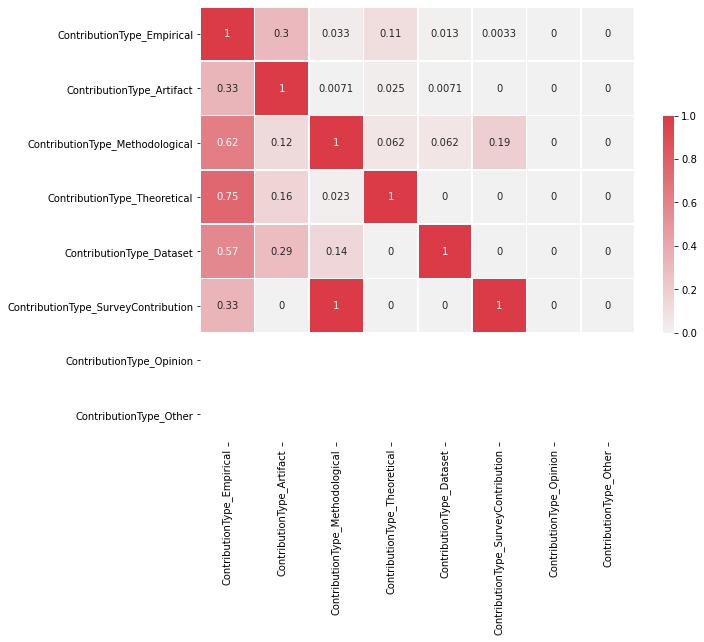

In [69]:
# Print out co-occurrence information
for code_cat, sub_codes in map_codes.items():
    
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # these categories
    
    # col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
    df_co_occurrence_subcode_cnt, df_co_occurrence_subcode_frac = calc_within_code_co_occurrence_matrix(code_cat)
    
    print(f"\n\n******** {code_cat} *******\n")
    print(f"** Raw sub-code co-occurrence count for {code_cat} **")
    display(df_co_occurrence_subcode_cnt)
    plot_co_occurrence_cnt_matrix(df_co_occurrence_subcode_cnt)
    
    print(f"** Fraction of sub-code co-occurrences for {code_cat} **")
    display(df_co_occurrence_subcode_frac)
    plot_co_occurrence_fraction_matrix(df_co_occurrence_subcode_frac, df_co_occurrence_subcode_cnt)
    

## Cross-code co-occurrence matrices

In [70]:
def calc_cross_code_co_occurrence_matrix(code_cat1, code_cat2):
    '''
    Calculates the frequency with which each sub-code in the first code category (code_cat1) co-occurs with
    each sub-code in the second code category (code_cat2)
    '''
    
    # Create empty dataframes to store matrices:
    # df_co_occurrence_subcode_cnt is a count of co-occurrence
    # df_co_occurrence_subcode_frac is a fraction of co-occurrence
    codecat1_subcode_cols = map_codes_to_cols[code_cat1]
    codecat2_subcode_cols = map_codes_to_cols[code_cat2]
    
    # Pandas refers to table columns as 'columns' as table rows as 'index'
    df_co_occurrence_subcode_cnt = pd.DataFrame(columns=codecat1_subcode_cols, index=codecat2_subcode_cols)
    df_co_occurrence_subcode_frac_of_col = pd.DataFrame(columns=codecat1_subcode_cols, index=codecat2_subcode_cols)
    df_co_occurrence_subcode_frac_of_row = pd.DataFrame(columns=codecat1_subcode_cols, index=codecat2_subcode_cols)
    series_sum_codecat1_subcode_occurrence = df[codecat1_subcode_cols].sum() # these are our cols
    series_sum_codecat2_subcode_occurrence = df[codecat2_subcode_cols].sum() # these are our rows
    
    for codecat1_subcode_col in codecat1_subcode_cols:
        for codecat2_subcode_col in codecat2_subcode_cols:   
            # Run co-occurrence query
            co_occurrence_count = len(df[(df[codecat1_subcode_col] == 1) & (df[codecat2_subcode_col] == 1)])
            
            codecat1_subcode_cnt = series_sum_codecat1_subcode_occurrence[codecat1_subcode_col]
            codecat2_subcode_cnt = series_sum_codecat2_subcode_occurrence[codecat2_subcode_col] 
            co_occurrence_frac_of_codecat1 = co_occurrence_count / codecat1_subcode_cnt
            co_occurrence_frac_of_codecat2 = co_occurrence_count / codecat2_subcode_cnt
            
            # DEBUG PRINTS
            # print(f"{codecat1_subcode_col} and {codecat2_subcode_col} co-occur {co_occurrence_count} times")
            # print(f"  {co_occurrence_count} is {co_occurrence_frac_of_codecat1 * 100}% of {codecat1_subcode_cnt} total {codecat1_subcode_col} occurrences and...")
            # print(f"  {co_occurrence_count} is {co_occurrence_frac_of_codecat2 * 100}% of {codecat2_subcode_cnt} total {codecat2_subcode_col} occurrences")
            
            # Set co-occurrence data into appropriate table cells
            df_co_occurrence_subcode_cnt.loc[codecat2_subcode_col, codecat1_subcode_col] = co_occurrence_count
            df_co_occurrence_subcode_frac_of_col.loc[codecat2_subcode_col, codecat1_subcode_col] = co_occurrence_frac_of_codecat1
            df_co_occurrence_subcode_frac_of_row.loc[codecat2_subcode_col, codecat1_subcode_col] = co_occurrence_frac_of_codecat2
            

    # Need to force the fractions to floating point
    df_co_occurrence_subcode_cnt = df_co_occurrence_subcode_cnt.astype(int)
    df_co_occurrence_subcode_frac_of_col = df_co_occurrence_subcode_frac_of_col.astype(float)
    df_co_occurrence_subcode_frac_of_row = df_co_occurrence_subcode_frac_of_row.astype(float)
    
    return df_co_occurrence_subcode_cnt, df_co_occurrence_subcode_frac_of_col, df_co_occurrence_subcode_frac_of_row



******** TargetPopulation and StudyMethod *******

** Raw sub-code co-occurrence count for TargetPopulation and StudyMethod **


TargetPopulation_BVI  TargetPopulation_DHH  \
StudyMethod_ControlledExperiment                    68                    30   
StudyMethod_SurveyMethod                            52                    20   
StudyMethod_UsabilityTesting                       122                    17   
StudyMethod_Interviews                              91                    17   
StudyMethod_CaseStudy                                3                     3   
StudyMethod_FocusGroups                             12                     2   
StudyMethod_FieldStudy                              27                     7   
StudyMethod_WorkshopDesign                          38                     6   
StudyMethod_Other                                   40                     8   

                                  TargetPopulation_IDD  \
StudyMethod_ControlledExperiment                     1   
StudyMethod_SurveyMethod                             1   
StudyMethod_UsabilityTesting                         4   
StudyMethod_Interviews                               9   
StudyMethod_CaseStudy                                1   
StudyMethod_FocusGroups                              1   
StudyMethod_FieldStudy                               5   
StudyMethod_WorkshopDesign                           5   
StudyMethod_Other                                    2   

                                  TargetPopulation_MotorPhysical  \
StudyMethod_ControlledExperiment                              24   
StudyMethod_SurveyMethod                                      21   
StudyMethod_UsabilityTesting                                  25   
StudyMethod_Interviews                                        35   
StudyMethod_CaseStudy                                          5   
StudyMethod_FocusGroups                                        3   
StudyMethod_FieldStudy                                        20   
StudyMethod_WorkshopDesign                                    15   
StudyMethod_Other                                             18   

                                  TargetPopulation_Autism  \
StudyMethod_ControlledExperiment                       11   
StudyMethod_SurveyMethod                                2   
StudyMethod_UsabilityTesting                            5   
StudyMethod_Interviews                                 15   
StudyMethod_CaseStudy                                   1   
StudyMethod_FocusGroups                                 3   
StudyMethod_FieldStudy                                 13   
StudyMethod_WorkshopDesign                              8   
StudyMethod_Other                                       6   

                                  TargetPopulation_Cognitive  \
StudyMethod_ControlledExperiment                          13   
StudyMethod_SurveyMethod                                   7   
StudyMethod_UsabilityTesting                              13   
StudyMethod_Interviews                                    16   
StudyMethod_CaseStudy                                      6   
StudyMethod_FocusGroups                                    4   
StudyMethod_FieldStudy                                    12   
StudyMethod_WorkshopDesign                                10   
StudyMethod_Other                                          5   

                                  TargetPopulation_OlderAdult  \
StudyMethod_ControlledExperiment                           19   
StudyMethod_SurveyMethod                                    9   
StudyMethod_UsabilityTesting                               15   
StudyMethod_Interviews                                     20   
StudyMethod_CaseStudy                                       3   
StudyMethod_FocusGroups                                     5   
StudyMethod_FieldStudy                                      5   
StudyMethod_WorkshopDesign                                  6   
StudyMethod_Other                                           7   

                                  TargetPopulation_GeneralDisability

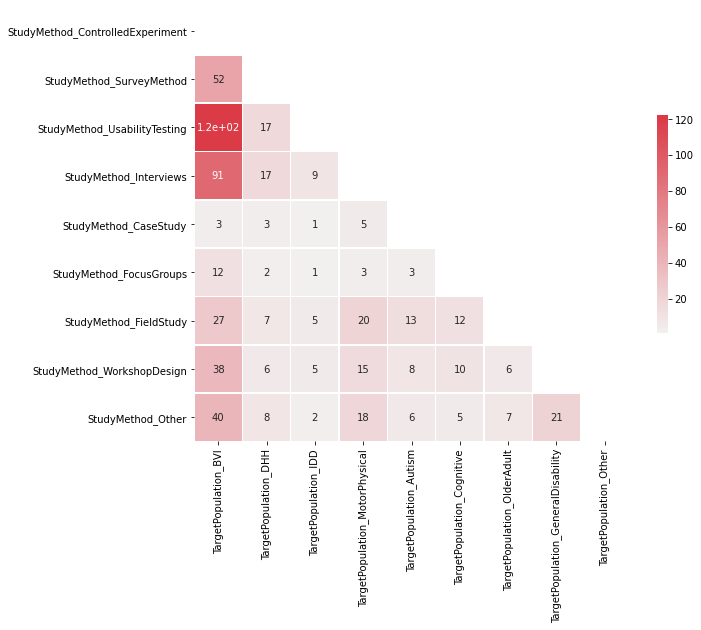

** Fraction of sub-code co-occurrences for TargetPopulation and StudyMethod (divisor is column sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
StudyMethod_ControlledExperiment              0.309091              0.526316   
StudyMethod_SurveyMethod                      0.236364              0.350877   
StudyMethod_UsabilityTesting                  0.554545              0.298246   
StudyMethod_Interviews                        0.413636              0.298246   
StudyMethod_CaseStudy                         0.013636              0.052632   
StudyMethod_FocusGroups                       0.054545              0.035088   
StudyMethod_FieldStudy                        0.122727              0.122807   
StudyMethod_WorkshopDesign                    0.172727              0.105263   
StudyMethod_Other                             0.181818              0.140351   

                                  TargetPopulation_IDD  \
StudyMethod_ControlledExperiment              0.071429   
StudyMethod_SurveyMethod                      0.071429   
StudyMethod_UsabilityTesting                  0.285714   
StudyMethod_Interviews                        0.642857   
StudyMethod_CaseStudy                         0.071429   
StudyMethod_FocusGroups                       0.071429   
StudyMethod_FieldStudy                        0.357143   
StudyMethod_WorkshopDesign                    0.357143   
StudyMethod_Other                             0.142857   

                                  TargetPopulation_MotorPhysical  \
StudyMethod_ControlledExperiment                        0.333333   
StudyMethod_SurveyMethod                                0.291667   
StudyMethod_UsabilityTesting                            0.347222   
StudyMethod_Interviews                                  0.486111   
StudyMethod_CaseStudy                                   0.069444   
StudyMethod_FocusGroups                                 0.041667   
StudyMethod_FieldStudy                                  0.277778   
StudyMethod_WorkshopDesign                              0.208333   
StudyMethod_Other                                       0.250000   

                                  TargetPopulation_Autism  \
StudyMethod_ControlledExperiment                 0.354839   
StudyMethod_SurveyMethod                         0.064516   
StudyMethod_UsabilityTesting                     0.161290   
StudyMethod_Interviews                           0.483871   
StudyMethod_CaseStudy                            0.032258   
StudyMethod_FocusGroups                          0.096774   
StudyMethod_FieldStudy                           0.419355   
StudyMethod_WorkshopDesign                       0.258065   
StudyMethod_Other                                0.193548   

                                  TargetPopulation_Cognitive  \
StudyMethod_ControlledExperiment                    0.282609   
StudyMethod_SurveyMethod                            0.152174   
StudyMethod_UsabilityTesting                        0.282609   
StudyMethod_Interviews                              0.347826   
StudyMethod_CaseStudy                               0.130435   
StudyMethod_FocusGroups                             0.086957   
StudyMethod_FieldStudy                              0.260870   
StudyMethod_WorkshopDesign                          0.217391   
StudyMethod_Other                                   0.108696   

                                  TargetPopulation_OlderAdult  \
StudyMethod_ControlledExperiment                     0.422222   
StudyMethod_SurveyMethod                             0.200000   
StudyMethod_UsabilityTesting                         0.333333   
StudyMethod_Interviews                               0.444444   
StudyMethod_CaseStudy                                0.066667   
StudyMethod_FocusGroups                              0.111111   
StudyMethod_FieldStudy                               0.111111   
StudyMethod_WorkshopDesign                           0.133333   
StudyMethod_Other                                    0.155556   

                                  TargetPopulation_GeneralDisability

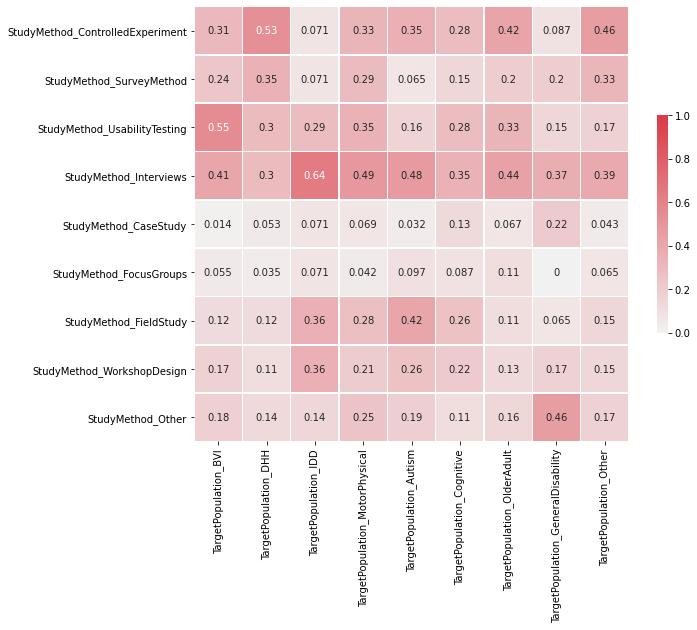

** Fraction of sub-code co-occurrences for TargetPopulation and StudyMethod (divisor is row sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
StudyMethod_ControlledExperiment              0.407186              0.179641   
StudyMethod_SurveyMethod                      0.426230              0.163934   
StudyMethod_UsabilityTesting                  0.613065              0.085427   
StudyMethod_Interviews                        0.452736              0.084577   
StudyMethod_CaseStudy                         0.120000              0.120000   
StudyMethod_FocusGroups                       0.428571              0.071429   
StudyMethod_FieldStudy                        0.317647              0.082353   
StudyMethod_WorkshopDesign                    0.431818              0.068182   
StudyMethod_Other                             0.404040              0.080808   

                                  TargetPopulation_IDD  \
StudyMethod_ControlledExperiment              0.005988   
StudyMethod_SurveyMethod                      0.008197   
StudyMethod_UsabilityTesting                  0.020101   
StudyMethod_Interviews                        0.044776   
StudyMethod_CaseStudy                         0.040000   
StudyMethod_FocusGroups                       0.035714   
StudyMethod_FieldStudy                        0.058824   
StudyMethod_WorkshopDesign                    0.056818   
StudyMethod_Other                             0.020202   

                                  TargetPopulation_MotorPhysical  \
StudyMethod_ControlledExperiment                        0.143713   
StudyMethod_SurveyMethod                                0.172131   
StudyMethod_UsabilityTesting                            0.125628   
StudyMethod_Interviews                                  0.174129   
StudyMethod_CaseStudy                                   0.200000   
StudyMethod_FocusGroups                                 0.107143   
StudyMethod_FieldStudy                                  0.235294   
StudyMethod_WorkshopDesign                              0.170455   
StudyMethod_Other                                       0.181818   

                                  TargetPopulation_Autism  \
StudyMethod_ControlledExperiment                 0.065868   
StudyMethod_SurveyMethod                         0.016393   
StudyMethod_UsabilityTesting                     0.025126   
StudyMethod_Interviews                           0.074627   
StudyMethod_CaseStudy                            0.040000   
StudyMethod_FocusGroups                          0.107143   
StudyMethod_FieldStudy                           0.152941   
StudyMethod_WorkshopDesign                       0.090909   
StudyMethod_Other                                0.060606   

                                  TargetPopulation_Cognitive  \
StudyMethod_ControlledExperiment                    0.077844   
StudyMethod_SurveyMethod                            0.057377   
StudyMethod_UsabilityTesting                        0.065327   
StudyMethod_Interviews                              0.079602   
StudyMethod_CaseStudy                               0.240000   
StudyMethod_FocusGroups                             0.142857   
StudyMethod_FieldStudy                              0.141176   
StudyMethod_WorkshopDesign                          0.113636   
StudyMethod_Other                                   0.050505   

                                  TargetPopulation_OlderAdult  \
StudyMethod_ControlledExperiment                     0.113772   
StudyMethod_SurveyMethod                             0.073770   
StudyMethod_UsabilityTesting                         0.075377   
StudyMethod_Interviews                               0.099502   
StudyMethod_CaseStudy                                0.120000   
StudyMethod_FocusGroups                              0.178571   
StudyMethod_FieldStudy                               0.058824   
StudyMethod_WorkshopDesign                           0.068182   
StudyMethod_Other                                    0.070707   

                                  TargetPopulation_GeneralDisability

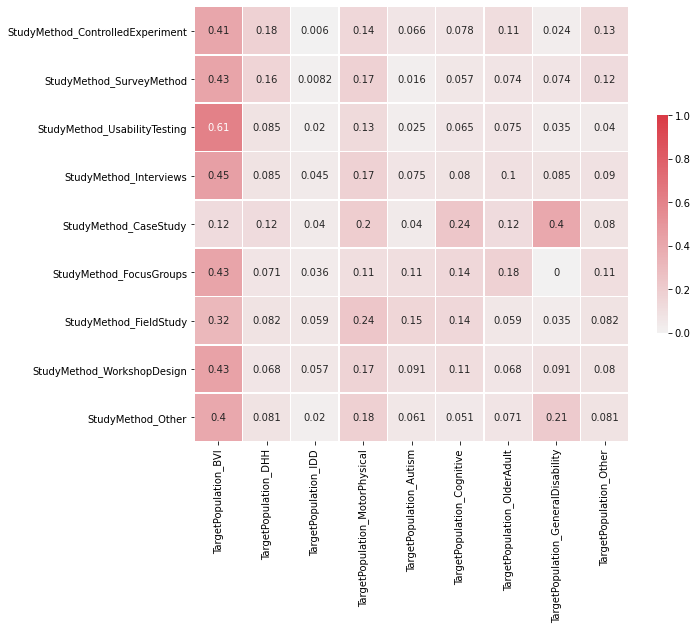



******** TargetPopulation and ParticipatoryDesign *******

** Raw sub-code co-occurrence count for TargetPopulation and ParticipatoryDesign **


TargetPopulation_BVI  TargetPopulation_DHH  \
ParticipatoryDesign_Yes                    16                     4   
ParticipatoryDesign_No                    204                    53   

                         TargetPopulation_IDD  TargetPopulation_MotorPhysical  \
ParticipatoryDesign_Yes                     3                              11   
ParticipatoryDesign_No                     11                              61   

                         TargetPopulation_Autism  TargetPopulation_Cognitive  \
ParticipatoryDesign_Yes                        5                          10   
ParticipatoryDesign_No                        26                          36   

                         TargetPopulation_OlderAdult  \
ParticipatoryDesign_Yes                            3   
ParticipatoryDesign_No                            42   

                         TargetPopulation_GeneralDisability  \
ParticipatoryDesign_Yes                                   4   
ParticipatoryDesign_No                                   42   

                         TargetPopulation_Other  
ParticipatoryDesign_Yes                       3  
ParticipatoryDesign_No                       43

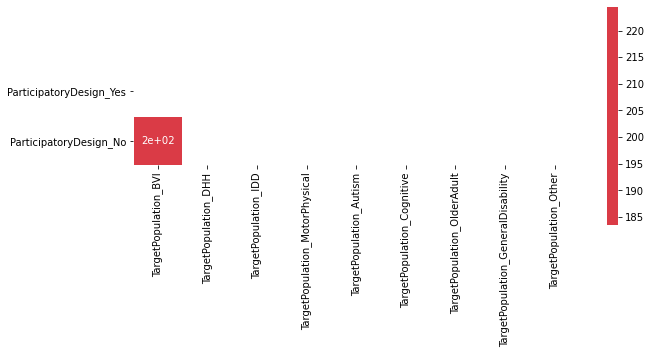

** Fraction of sub-code co-occurrences for TargetPopulation and ParticipatoryDesign (divisor is column sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
ParticipatoryDesign_Yes              0.072727              0.070175   
ParticipatoryDesign_No               0.927273              0.929825   

                         TargetPopulation_IDD  TargetPopulation_MotorPhysical  \
ParticipatoryDesign_Yes              0.214286                        0.152778   
ParticipatoryDesign_No               0.785714                        0.847222   

                         TargetPopulation_Autism  TargetPopulation_Cognitive  \
ParticipatoryDesign_Yes                  0.16129                    0.217391   
ParticipatoryDesign_No                   0.83871                    0.782609   

                         TargetPopulation_OlderAdult  \
ParticipatoryDesign_Yes                     0.066667   
ParticipatoryDesign_No                      0.933333   

                         TargetPopulation_GeneralDisability  \
ParticipatoryDesign_Yes                            0.086957   
ParticipatoryDesign_No                             0.913043   

                         TargetPopulation_Other  
ParticipatoryDesign_Yes                0.065217  
ParticipatoryDesign_No                 0.934783

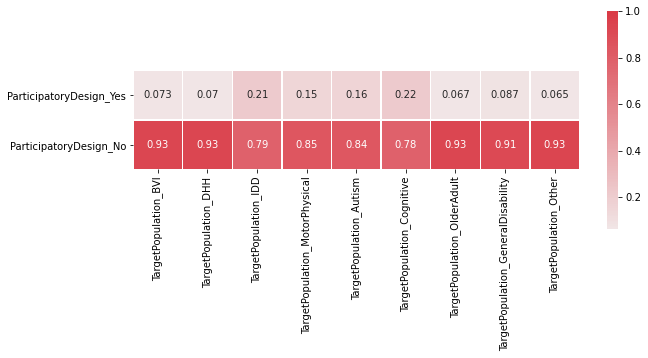

** Fraction of sub-code co-occurrences for TargetPopulation and ParticipatoryDesign (divisor is row sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
ParticipatoryDesign_Yes              0.326531              0.081633   
ParticipatoryDesign_No               0.446389              0.115974   

                         TargetPopulation_IDD  TargetPopulation_MotorPhysical  \
ParticipatoryDesign_Yes              0.061224                        0.224490   
ParticipatoryDesign_No               0.024070                        0.133479   

                         TargetPopulation_Autism  TargetPopulation_Cognitive  \
ParticipatoryDesign_Yes                 0.102041                    0.204082   
ParticipatoryDesign_No                  0.056893                    0.078775   

                         TargetPopulation_OlderAdult  \
ParticipatoryDesign_Yes                     0.061224   
ParticipatoryDesign_No                      0.091904   

                         TargetPopulation_GeneralDisability  \
ParticipatoryDesign_Yes                            0.081633   
ParticipatoryDesign_No                             0.091904   

                         TargetPopulation_Other  
ParticipatoryDesign_Yes                0.061224  
ParticipatoryDesign_No                 0.094092

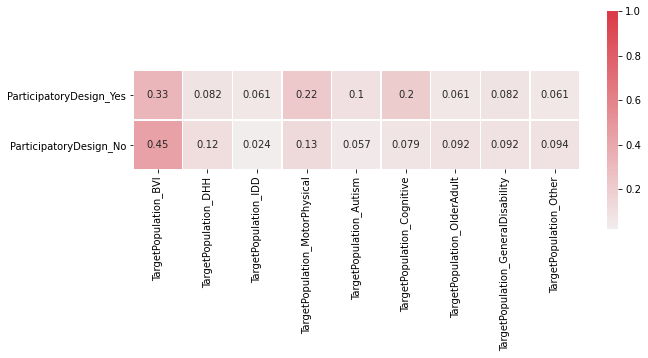



******** TargetPopulation and StudyLocation *******

** Raw sub-code co-occurrence count for TargetPopulation and StudyLocation **


TargetPopulation_BVI  \
StudyLocation_NearAtLab                                    69   
StudyLocation_ParticipantsHomeOrFreqLoc                    47   
StudyLocation_NeutralLocation                              20   
StudyLocation_Unclear                                      89   
StudyLocation_OnlineRemotely                               45   
StudyLocation_Other                                         3   
StudyLocation_NoUserStudy                                   4   

                                         TargetPopulation_DHH  \
StudyLocation_NearAtLab                                    14   
StudyLocation_ParticipantsHomeOrFreqLoc                     9   
StudyLocation_NeutralLocation                               5   
StudyLocation_Unclear                                      22   
StudyLocation_OnlineRemotely                               12   
StudyLocation_Other                                         2   
StudyLocation_NoUserStudy                                   4   

                                         TargetPopulation_IDD  \
StudyLocation_NearAtLab                                     3   
StudyLocation_ParticipantsHomeOrFreqLoc                    11   
StudyLocation_NeutralLocation                               1   
StudyLocation_Unclear                                       2   
StudyLocation_OnlineRemotely                                0   
StudyLocation_Other                                         0   
StudyLocation_NoUserStudy                                   0   

                                         TargetPopulation_MotorPhysical  \
StudyLocation_NearAtLab                                              19   
StudyLocation_ParticipantsHomeOrFreqLoc                              26   
StudyLocation_NeutralLocation                                         1   
StudyLocation_Unclear                                                31   
StudyLocation_OnlineRemotely                                         16   
StudyLocation_Other                                                   0   
StudyLocation_NoUserStudy                                             1   

                                         TargetPopulation_Autism  \
StudyLocation_NearAtLab                                        5   
StudyLocation_ParticipantsHomeOrFreqLoc                       19   
StudyLocation_NeutralLocation                                  0   
StudyLocation_Unclear                                          7   
StudyLocation_OnlineRemotely                                   5   
StudyLocation_Other                                            2   
StudyLocation_NoUserStudy                                      1   

                                         TargetPopulation_Cognitive  \
StudyLocation_NearAtLab                                           9   
StudyLocation_ParticipantsHomeOrFreqLoc                          18   
StudyLocation_NeutralLocation                                     1   
StudyLocation_Unclear                                            14   
StudyLocation_OnlineRemotely                                      9   
StudyLocation_Other                                               0   
StudyLocation_NoUserStudy                                         1   

                                         TargetPopulation_OlderAdult  \
StudyLocation_NearAtLab                                            9   
StudyLocation_ParticipantsHomeOrFreqLoc                           15   
StudyLocation_NeutralLocation                                      1   
StudyLocation_Unclear                                             20   
StudyLocation_OnlineRemotely                                       4   
StudyLocation_Other                                                0   
StudyLocation_NoUserStudy                                          2   

                                         TargetPopulation_GeneralDisability  \
StudyLocation_NearAtLab                                                   6   
StudyLocation_ParticipantsHo

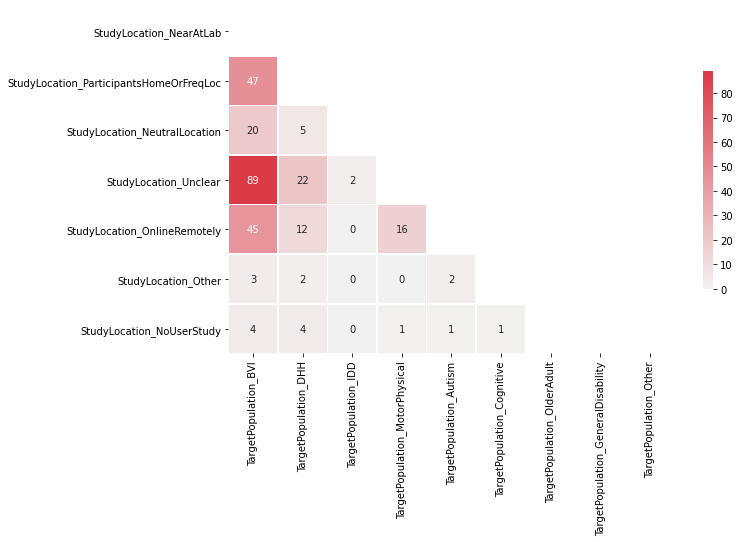

** Fraction of sub-code co-occurrences for TargetPopulation and StudyLocation (divisor is column sum) **


TargetPopulation_BVI  \
StudyLocation_NearAtLab                              0.313636   
StudyLocation_ParticipantsHomeOrFreqLoc              0.213636   
StudyLocation_NeutralLocation                        0.090909   
StudyLocation_Unclear                                0.404545   
StudyLocation_OnlineRemotely                         0.204545   
StudyLocation_Other                                  0.013636   
StudyLocation_NoUserStudy                            0.018182   

                                         TargetPopulation_DHH  \
StudyLocation_NearAtLab                              0.245614   
StudyLocation_ParticipantsHomeOrFreqLoc              0.157895   
StudyLocation_NeutralLocation                        0.087719   
StudyLocation_Unclear                                0.385965   
StudyLocation_OnlineRemotely                         0.210526   
StudyLocation_Other                                  0.035088   
StudyLocation_NoUserStudy                            0.070175   

                                         TargetPopulation_IDD  \
StudyLocation_NearAtLab                              0.214286   
StudyLocation_ParticipantsHomeOrFreqLoc              0.785714   
StudyLocation_NeutralLocation                        0.071429   
StudyLocation_Unclear                                0.142857   
StudyLocation_OnlineRemotely                         0.000000   
StudyLocation_Other                                  0.000000   
StudyLocation_NoUserStudy                            0.000000   

                                         TargetPopulation_MotorPhysical  \
StudyLocation_NearAtLab                                        0.263889   
StudyLocation_ParticipantsHomeOrFreqLoc                        0.361111   
StudyLocation_NeutralLocation                                  0.013889   
StudyLocation_Unclear                                          0.430556   
StudyLocation_OnlineRemotely                                   0.222222   
StudyLocation_Other                                            0.000000   
StudyLocation_NoUserStudy                                      0.013889   

                                         TargetPopulation_Autism  \
StudyLocation_NearAtLab                                 0.161290   
StudyLocation_ParticipantsHomeOrFreqLoc                 0.612903   
StudyLocation_NeutralLocation                           0.000000   
StudyLocation_Unclear                                   0.225806   
StudyLocation_OnlineRemotely                            0.161290   
StudyLocation_Other                                     0.064516   
StudyLocation_NoUserStudy                               0.032258   

                                         TargetPopulation_Cognitive  \
StudyLocation_NearAtLab                                    0.195652   
StudyLocation_ParticipantsHomeOrFreqLoc                    0.391304   
StudyLocation_NeutralLocation                              0.021739   
StudyLocation_Unclear                                      0.304348   
StudyLocation_OnlineRemotely                               0.195652   
StudyLocation_Other                                        0.000000   
StudyLocation_NoUserStudy                                  0.021739   

                                         TargetPopulation_OlderAdult  \
StudyLocation_NearAtLab                                     0.200000   
StudyLocation_ParticipantsHomeOrFreqLoc                     0.333333   
StudyLocation_NeutralLocation                               0.022222   
StudyLocation_Unclear                                       0.444444   
StudyLocation_OnlineRemotely                                0.088889   
StudyLocation_Other                                         0.000000   
StudyLocation_NoUserStudy                                   0.044444   

                                         TargetPopulation_GeneralDisability  \
StudyLocation_NearAtLab                                            0.130435   
StudyLocation_ParticipantsHo

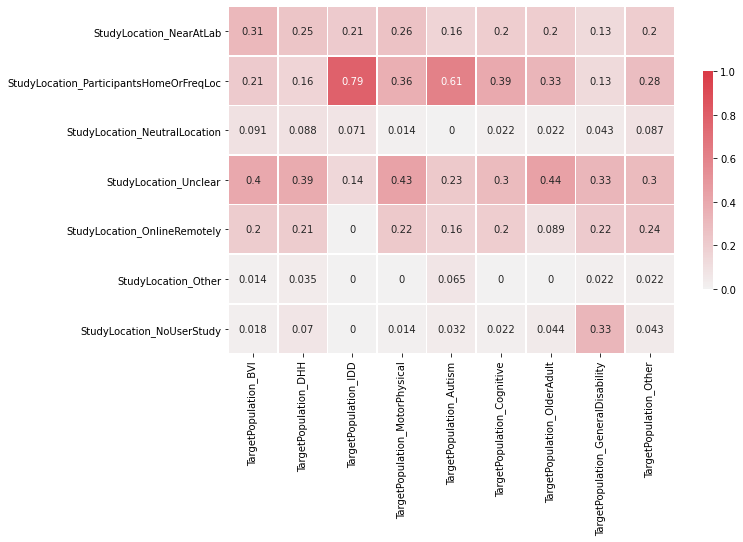

** Fraction of sub-code co-occurrences for TargetPopulation and StudyLocation (divisor is row sum) **


TargetPopulation_BVI  \
StudyLocation_NearAtLab                              0.530769   
StudyLocation_ParticipantsHomeOrFreqLoc              0.340580   
StudyLocation_NeutralLocation                        0.625000   
StudyLocation_Unclear                                0.470899   
StudyLocation_OnlineRemotely                         0.459184   
StudyLocation_Other                                  0.428571   
StudyLocation_NoUserStudy                            0.137931   

                                         TargetPopulation_DHH  \
StudyLocation_NearAtLab                              0.107692   
StudyLocation_ParticipantsHomeOrFreqLoc              0.065217   
StudyLocation_NeutralLocation                        0.156250   
StudyLocation_Unclear                                0.116402   
StudyLocation_OnlineRemotely                         0.122449   
StudyLocation_Other                                  0.285714   
StudyLocation_NoUserStudy                            0.137931   

                                         TargetPopulation_IDD  \
StudyLocation_NearAtLab                              0.023077   
StudyLocation_ParticipantsHomeOrFreqLoc              0.079710   
StudyLocation_NeutralLocation                        0.031250   
StudyLocation_Unclear                                0.010582   
StudyLocation_OnlineRemotely                         0.000000   
StudyLocation_Other                                  0.000000   
StudyLocation_NoUserStudy                            0.000000   

                                         TargetPopulation_MotorPhysical  \
StudyLocation_NearAtLab                                        0.146154   
StudyLocation_ParticipantsHomeOrFreqLoc                        0.188406   
StudyLocation_NeutralLocation                                  0.031250   
StudyLocation_Unclear                                          0.164021   
StudyLocation_OnlineRemotely                                   0.163265   
StudyLocation_Other                                            0.000000   
StudyLocation_NoUserStudy                                      0.034483   

                                         TargetPopulation_Autism  \
StudyLocation_NearAtLab                                 0.038462   
StudyLocation_ParticipantsHomeOrFreqLoc                 0.137681   
StudyLocation_NeutralLocation                           0.000000   
StudyLocation_Unclear                                   0.037037   
StudyLocation_OnlineRemotely                            0.051020   
StudyLocation_Other                                     0.285714   
StudyLocation_NoUserStudy                               0.034483   

                                         TargetPopulation_Cognitive  \
StudyLocation_NearAtLab                                    0.069231   
StudyLocation_ParticipantsHomeOrFreqLoc                    0.130435   
StudyLocation_NeutralLocation                              0.031250   
StudyLocation_Unclear                                      0.074074   
StudyLocation_OnlineRemotely                               0.091837   
StudyLocation_Other                                        0.000000   
StudyLocation_NoUserStudy                                  0.034483   

                                         TargetPopulation_OlderAdult  \
StudyLocation_NearAtLab                                     0.069231   
StudyLocation_ParticipantsHomeOrFreqLoc                     0.108696   
StudyLocation_NeutralLocation                               0.031250   
StudyLocation_Unclear                                       0.105820   
StudyLocation_OnlineRemotely                                0.040816   
StudyLocation_Other                                         0.000000   
StudyLocation_NoUserStudy                                   0.068966   

                                         TargetPopulation_GeneralDisability  \
StudyLocation_NearAtLab                                            0.046154   
StudyLocation_ParticipantsHo

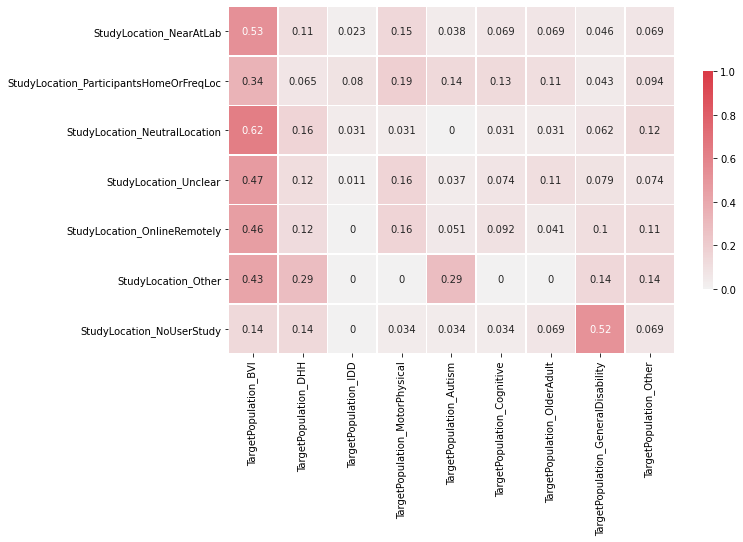



******** TargetPopulation and ParticipantGroup *******

** Raw sub-code co-occurrence count for TargetPopulation and ParticipantGroup **


TargetPopulation_BVI  \
ParticipantGroup_OlderAdult                                  2   
ParticipantGroup_PeopleWithDisability                      209   
ParticipantGroup_PeopleWithoutDisability                    47   
ParticipantGroup_TherapistsSpecialists                      24   
ParticipantGroup_Caregivers                                  6   
ParticipantGroup_Other                                      18   
ParticipantGroup_NoUserStudy                                 4   

                                          TargetPopulation_DHH  \
ParticipantGroup_OlderAdult                                  0   
ParticipantGroup_PeopleWithDisability                       37   
ParticipantGroup_PeopleWithoutDisability                    12   
ParticipantGroup_TherapistsSpecialists                       6   
ParticipantGroup_Caregivers                                  2   
ParticipantGroup_Other                                      15   
ParticipantGroup_NoUserStudy                                 4   

                                          TargetPopulation_IDD  \
ParticipantGroup_OlderAdult                                  0   
ParticipantGroup_PeopleWithDisability                       12   
ParticipantGroup_PeopleWithoutDisability                     3   
ParticipantGroup_TherapistsSpecialists                       8   
ParticipantGroup_Caregivers                                  3   
ParticipantGroup_Other                                       2   
ParticipantGroup_NoUserStudy                                 0   

                                          TargetPopulation_MotorPhysical  \
ParticipantGroup_OlderAdult                                            5   
ParticipantGroup_PeopleWithDisability                                 67   
ParticipantGroup_PeopleWithoutDisability                              14   
ParticipantGroup_TherapistsSpecialists                                16   
ParticipantGroup_Caregivers                                            9   
ParticipantGroup_Other                                                 5   
ParticipantGroup_NoUserStudy                                           1   

                                          TargetPopulation_Autism  \
ParticipantGroup_OlderAdult                                     1   
ParticipantGroup_PeopleWithDisability                          29   
ParticipantGroup_PeopleWithoutDisability                        7   
ParticipantGroup_TherapistsSpecialists                         13   
ParticipantGroup_Caregivers                                    10   
ParticipantGroup_Other                                          4   
ParticipantGroup_NoUserStudy                                    1   

                                          TargetPopulation_Cognitive  \
ParticipantGroup_OlderAdult                                        7   
ParticipantGroup_PeopleWithDisability                             40   
ParticipantGroup_PeopleWithoutDisability                           6   
ParticipantGroup_TherapistsSpecialists                            12   
ParticipantGroup_Caregivers                                       11   
ParticipantGroup_Other                                             4   
ParticipantGroup_NoUserStudy                                       1   

                                          TargetPopulation_OlderAdult  \
ParticipantGroup_OlderAdult                                        40   
ParticipantGroup_PeopleWithDisability                              14   
ParticipantGroup_PeopleWithoutDisability                           11   
ParticipantGroup_TherapistsSpecialists                              3   
ParticipantGroup_Caregivers                                         6   
ParticipantGroup_Other                                              4   
ParticipantGroup_NoUserStudy                                        2   

                                          TargetPopulation_GeneralDisability  \
ParticipantGroup_OlderAdult                        

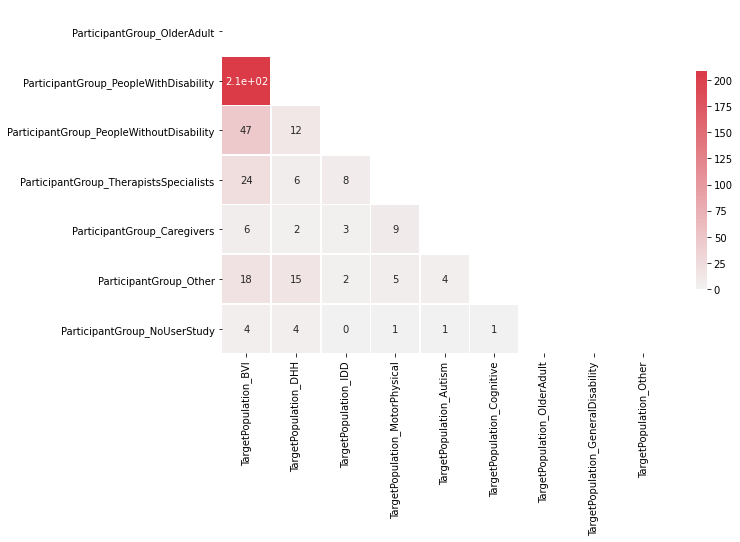

** Fraction of sub-code co-occurrences for TargetPopulation and ParticipantGroup (divisor is column sum) **


TargetPopulation_BVI  \
ParticipantGroup_OlderAdult                           0.009091   
ParticipantGroup_PeopleWithDisability                 0.950000   
ParticipantGroup_PeopleWithoutDisability              0.213636   
ParticipantGroup_TherapistsSpecialists                0.109091   
ParticipantGroup_Caregivers                           0.027273   
ParticipantGroup_Other                                0.081818   
ParticipantGroup_NoUserStudy                          0.018182   

                                          TargetPopulation_DHH  \
ParticipantGroup_OlderAdult                           0.000000   
ParticipantGroup_PeopleWithDisability                 0.649123   
ParticipantGroup_PeopleWithoutDisability              0.210526   
ParticipantGroup_TherapistsSpecialists                0.105263   
ParticipantGroup_Caregivers                           0.035088   
ParticipantGroup_Other                                0.263158   
ParticipantGroup_NoUserStudy                          0.070175   

                                          TargetPopulation_IDD  \
ParticipantGroup_OlderAdult                           0.000000   
ParticipantGroup_PeopleWithDisability                 0.857143   
ParticipantGroup_PeopleWithoutDisability              0.214286   
ParticipantGroup_TherapistsSpecialists                0.571429   
ParticipantGroup_Caregivers                           0.214286   
ParticipantGroup_Other                                0.142857   
ParticipantGroup_NoUserStudy                          0.000000   

                                          TargetPopulation_MotorPhysical  \
ParticipantGroup_OlderAdult                                     0.069444   
ParticipantGroup_PeopleWithDisability                           0.930556   
ParticipantGroup_PeopleWithoutDisability                        0.194444   
ParticipantGroup_TherapistsSpecialists                          0.222222   
ParticipantGroup_Caregivers                                     0.125000   
ParticipantGroup_Other                                          0.069444   
ParticipantGroup_NoUserStudy                                    0.013889   

                                          TargetPopulation_Autism  \
ParticipantGroup_OlderAdult                              0.032258   
ParticipantGroup_PeopleWithDisability                    0.935484   
ParticipantGroup_PeopleWithoutDisability                 0.225806   
ParticipantGroup_TherapistsSpecialists                   0.419355   
ParticipantGroup_Caregivers                              0.322581   
ParticipantGroup_Other                                   0.129032   
ParticipantGroup_NoUserStudy                             0.032258   

                                          TargetPopulation_Cognitive  \
ParticipantGroup_OlderAdult                                 0.152174   
ParticipantGroup_PeopleWithDisability                       0.869565   
ParticipantGroup_PeopleWithoutDisability                    0.130435   
ParticipantGroup_TherapistsSpecialists                      0.260870   
ParticipantGroup_Caregivers                                 0.239130   
ParticipantGroup_Other                                      0.086957   
ParticipantGroup_NoUserStudy                                0.021739   

                                          TargetPopulation_OlderAdult  \
ParticipantGroup_OlderAdult                                  0.888889   
ParticipantGroup_PeopleWithDisability                        0.311111   
ParticipantGroup_PeopleWithoutDisability                     0.244444   
ParticipantGroup_TherapistsSpecialists                       0.066667   
ParticipantGroup_Caregivers                                  0.133333   
ParticipantGroup_Other                                       0.088889   
ParticipantGroup_NoUserStudy                                 0.044444   

                                          TargetPopulation_GeneralDisability  \
ParticipantGroup_OlderAdult                        

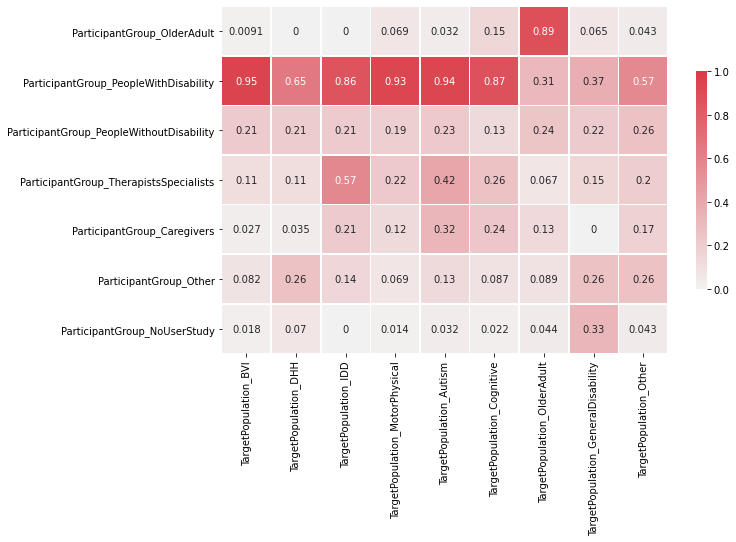

** Fraction of sub-code co-occurrences for TargetPopulation and ParticipantGroup (divisor is row sum) **


TargetPopulation_BVI  \
ParticipantGroup_OlderAdult                           0.050000   
ParticipantGroup_PeopleWithDisability                 0.517327   
ParticipantGroup_PeopleWithoutDisability              0.427273   
ParticipantGroup_TherapistsSpecialists                0.296296   
ParticipantGroup_Caregivers                           0.133333   
ParticipantGroup_Other                                0.339623   
ParticipantGroup_NoUserStudy                          0.137931   

                                          TargetPopulation_DHH  \
ParticipantGroup_OlderAdult                           0.000000   
ParticipantGroup_PeopleWithDisability                 0.091584   
ParticipantGroup_PeopleWithoutDisability              0.109091   
ParticipantGroup_TherapistsSpecialists                0.074074   
ParticipantGroup_Caregivers                           0.044444   
ParticipantGroup_Other                                0.283019   
ParticipantGroup_NoUserStudy                          0.137931   

                                          TargetPopulation_IDD  \
ParticipantGroup_OlderAdult                           0.000000   
ParticipantGroup_PeopleWithDisability                 0.029703   
ParticipantGroup_PeopleWithoutDisability              0.027273   
ParticipantGroup_TherapistsSpecialists                0.098765   
ParticipantGroup_Caregivers                           0.066667   
ParticipantGroup_Other                                0.037736   
ParticipantGroup_NoUserStudy                          0.000000   

                                          TargetPopulation_MotorPhysical  \
ParticipantGroup_OlderAdult                                     0.125000   
ParticipantGroup_PeopleWithDisability                           0.165842   
ParticipantGroup_PeopleWithoutDisability                        0.127273   
ParticipantGroup_TherapistsSpecialists                          0.197531   
ParticipantGroup_Caregivers                                     0.200000   
ParticipantGroup_Other                                          0.094340   
ParticipantGroup_NoUserStudy                                    0.034483   

                                          TargetPopulation_Autism  \
ParticipantGroup_OlderAdult                              0.025000   
ParticipantGroup_PeopleWithDisability                    0.071782   
ParticipantGroup_PeopleWithoutDisability                 0.063636   
ParticipantGroup_TherapistsSpecialists                   0.160494   
ParticipantGroup_Caregivers                              0.222222   
ParticipantGroup_Other                                   0.075472   
ParticipantGroup_NoUserStudy                             0.034483   

                                          TargetPopulation_Cognitive  \
ParticipantGroup_OlderAdult                                 0.175000   
ParticipantGroup_PeopleWithDisability                       0.099010   
ParticipantGroup_PeopleWithoutDisability                    0.054545   
ParticipantGroup_TherapistsSpecialists                      0.148148   
ParticipantGroup_Caregivers                                 0.244444   
ParticipantGroup_Other                                      0.075472   
ParticipantGroup_NoUserStudy                                0.034483   

                                          TargetPopulation_OlderAdult  \
ParticipantGroup_OlderAdult                                  1.000000   
ParticipantGroup_PeopleWithDisability                        0.034653   
ParticipantGroup_PeopleWithoutDisability                     0.100000   
ParticipantGroup_TherapistsSpecialists                       0.037037   
ParticipantGroup_Caregivers                                  0.133333   
ParticipantGroup_Other                                       0.075472   
ParticipantGroup_NoUserStudy                                 0.068966   

                                          TargetPopulation_GeneralDisability  \
ParticipantGroup_OlderAdult                        

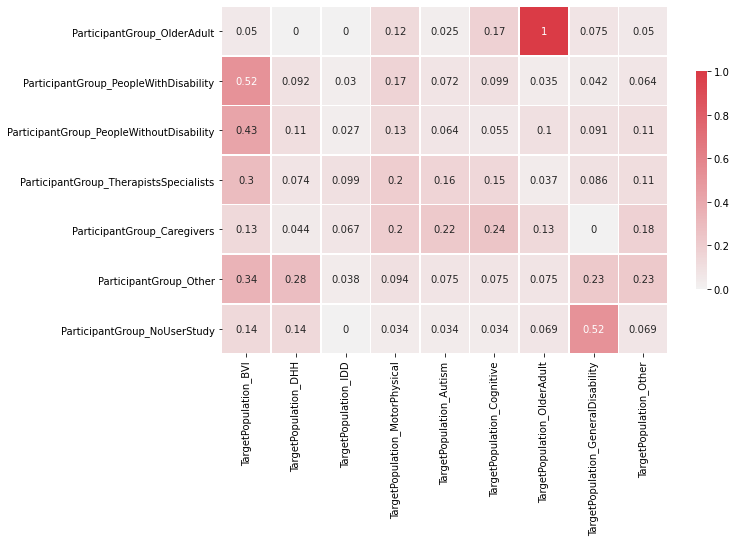



******** TargetPopulation and ComparesOnDisability *******

** Raw sub-code co-occurrence count for TargetPopulation and ComparesOnDisability **


TargetPopulation_BVI  TargetPopulation_DHH  \
ComparesOnDisability_Yes                    30                     6   
ComparesOnDisability_No                    190                    51   

                          TargetPopulation_IDD  \
ComparesOnDisability_Yes                     1   
ComparesOnDisability_No                     13   

                          TargetPopulation_MotorPhysical  \
ComparesOnDisability_Yes                               7   
ComparesOnDisability_No                               65   

                          TargetPopulation_Autism  TargetPopulation_Cognitive  \
ComparesOnDisability_Yes                        4                           6   
ComparesOnDisability_No                        27                          40   

                          TargetPopulation_OlderAdult  \
ComparesOnDisability_Yes                            9   
ComparesOnDisability_No                            36   

                          TargetPopulation_GeneralDisability  \
ComparesOnDisability_Yes                                   3   
ComparesOnDisability_No                                   43   

                          TargetPopulation_Other  
ComparesOnDisability_Yes                       9  
ComparesOnDisability_No                       37

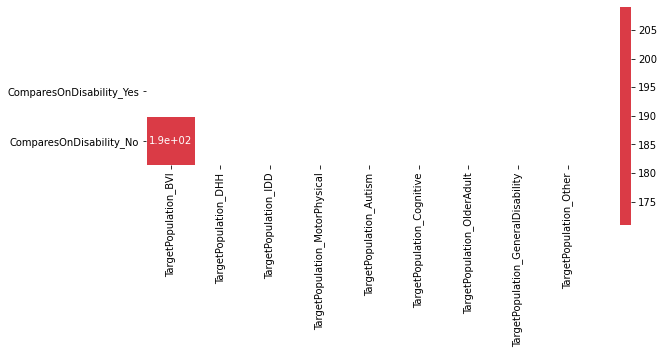

** Fraction of sub-code co-occurrences for TargetPopulation and ComparesOnDisability (divisor is column sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
ComparesOnDisability_Yes              0.136364              0.105263   
ComparesOnDisability_No               0.863636              0.894737   

                          TargetPopulation_IDD  \
ComparesOnDisability_Yes              0.071429   
ComparesOnDisability_No               0.928571   

                          TargetPopulation_MotorPhysical  \
ComparesOnDisability_Yes                        0.097222   
ComparesOnDisability_No                         0.902778   

                          TargetPopulation_Autism  TargetPopulation_Cognitive  \
ComparesOnDisability_Yes                 0.129032                    0.130435   
ComparesOnDisability_No                  0.870968                    0.869565   

                          TargetPopulation_OlderAdult  \
ComparesOnDisability_Yes                          0.2   
ComparesOnDisability_No                           0.8   

                          TargetPopulation_GeneralDisability  \
ComparesOnDisability_Yes                            0.065217   
ComparesOnDisability_No                             0.934783   

                          TargetPopulation_Other  
ComparesOnDisability_Yes                0.195652  
ComparesOnDisability_No                 0.804348

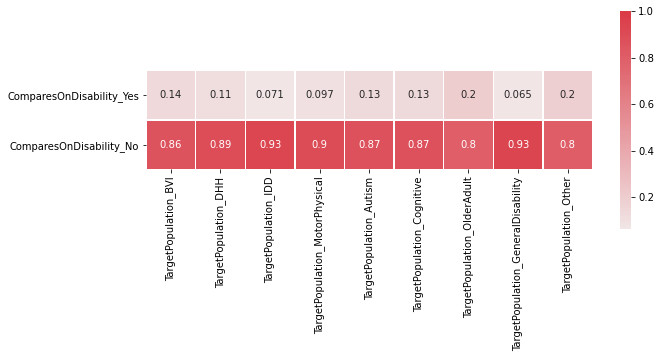

** Fraction of sub-code co-occurrences for TargetPopulation and ComparesOnDisability (divisor is row sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
ComparesOnDisability_Yes              0.461538              0.092308   
ComparesOnDisability_No               0.430839              0.115646   

                          TargetPopulation_IDD  \
ComparesOnDisability_Yes              0.015385   
ComparesOnDisability_No               0.029478   

                          TargetPopulation_MotorPhysical  \
ComparesOnDisability_Yes                        0.107692   
ComparesOnDisability_No                         0.147392   

                          TargetPopulation_Autism  TargetPopulation_Cognitive  \
ComparesOnDisability_Yes                 0.061538                    0.092308   
ComparesOnDisability_No                  0.061224                    0.090703   

                          TargetPopulation_OlderAdult  \
ComparesOnDisability_Yes                     0.138462   
ComparesOnDisability_No                      0.081633   

                          TargetPopulation_GeneralDisability  \
ComparesOnDisability_Yes                            0.046154   
ComparesOnDisability_No                             0.097506   

                          TargetPopulation_Other  
ComparesOnDisability_Yes                0.138462  
ComparesOnDisability_No                 0.083900

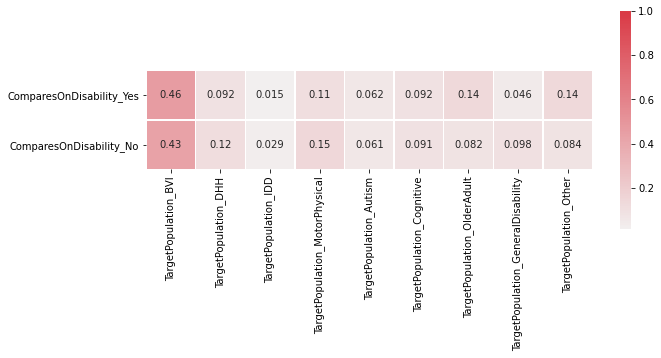



******** TargetPopulation and UsesProxies *******

** Raw sub-code co-occurrence count for TargetPopulation and UsesProxies **


TargetPopulation_BVI  TargetPopulation_DHH  \
UsesProxies_Yes                    10                     0   
UsesProxies_No                    210                    57   

                 TargetPopulation_IDD  TargetPopulation_MotorPhysical  \
UsesProxies_Yes                     3                               6   
UsesProxies_No                     11                              66   

                 TargetPopulation_Autism  TargetPopulation_Cognitive  \
UsesProxies_Yes                        7                           8   
UsesProxies_No                        24                          38   

                 TargetPopulation_OlderAdult  \
UsesProxies_Yes                            3   
UsesProxies_No                            42   

                 TargetPopulation_GeneralDisability  TargetPopulation_Other  
UsesProxies_Yes                                   2                       8  
UsesProxies_No                                   44                      38

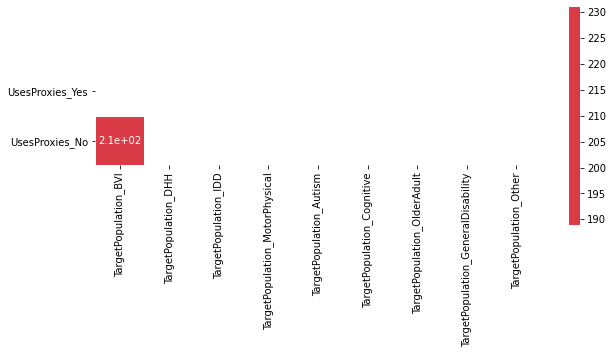

** Fraction of sub-code co-occurrences for TargetPopulation and UsesProxies (divisor is column sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
UsesProxies_Yes              0.045455                   0.0   
UsesProxies_No               0.954545                   1.0   

                 TargetPopulation_IDD  TargetPopulation_MotorPhysical  \
UsesProxies_Yes              0.214286                        0.083333   
UsesProxies_No               0.785714                        0.916667   

                 TargetPopulation_Autism  TargetPopulation_Cognitive  \
UsesProxies_Yes                 0.225806                    0.173913   
UsesProxies_No                  0.774194                    0.826087   

                 TargetPopulation_OlderAdult  \
UsesProxies_Yes                     0.066667   
UsesProxies_No                      0.933333   

                 TargetPopulation_GeneralDisability  TargetPopulation_Other  
UsesProxies_Yes                            0.043478                0.173913  
UsesProxies_No                             0.956522                0.826087

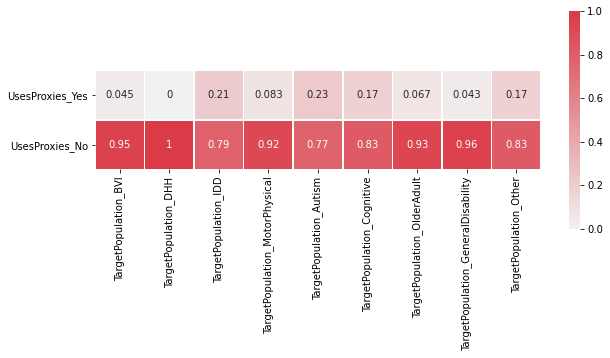

** Fraction of sub-code co-occurrences for TargetPopulation and UsesProxies (divisor is row sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
UsesProxies_Yes              0.263158              0.000000   
UsesProxies_No               0.448718              0.121795   

                 TargetPopulation_IDD  TargetPopulation_MotorPhysical  \
UsesProxies_Yes              0.078947                        0.157895   
UsesProxies_No               0.023504                        0.141026   

                 TargetPopulation_Autism  TargetPopulation_Cognitive  \
UsesProxies_Yes                 0.184211                    0.210526   
UsesProxies_No                  0.051282                    0.081197   

                 TargetPopulation_OlderAdult  \
UsesProxies_Yes                     0.078947   
UsesProxies_No                      0.089744   

                 TargetPopulation_GeneralDisability  TargetPopulation_Other  
UsesProxies_Yes                            0.052632                0.210526  
UsesProxies_No                             0.094017                0.081197

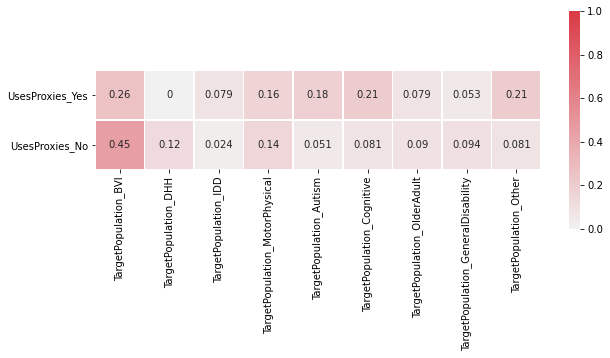



******** TargetPopulation and TechFocus *******

** Raw sub-code co-occurrence count for TargetPopulation and TechFocus **


TargetPopulation_BVI  \
TechFocus_SmartphoneTabletSmartwatch                    86   
TechFocus_WebApp                                        28   
TechFocus_DesktopApp                                    23   
TechFocus_IotEnvironmentSensing                         10   
TechFocus_VrArSolution                                  13   
TechFocus_TangibleDeviceProsthesis                      43   
TechFocus_PhysicallyFabricated                          32   
TechFocus_NoTechFocus                                   13   
TechFocus_Other                                         66   

                                      TargetPopulation_DHH  \
TechFocus_SmartphoneTabletSmartwatch                     9   
TechFocus_WebApp                                         7   
TechFocus_DesktopApp                                     5   
TechFocus_IotEnvironmentSensing                          4   
TechFocus_VrArSolution                                   6   
TechFocus_TangibleDeviceProsthesis                       4   
TechFocus_PhysicallyFabricated                           0   
TechFocus_NoTechFocus                                    4   
TechFocus_Other                                         37   

                                      TargetPopulation_IDD  \
TechFocus_SmartphoneTabletSmartwatch                     3   
TechFocus_WebApp                                         3   
TechFocus_DesktopApp                                     2   
TechFocus_IotEnvironmentSensing                          0   
TechFocus_VrArSolution                                   2   
TechFocus_TangibleDeviceProsthesis                       1   
TechFocus_PhysicallyFabricated                           1   
TechFocus_NoTechFocus                                    0   
TechFocus_Other                                          7   

                                      TargetPopulation_MotorPhysical  \
TechFocus_SmartphoneTabletSmartwatch                              25   
TechFocus_WebApp                                                   4   
TechFocus_DesktopApp                                               7   
TechFocus_IotEnvironmentSensing                                    5   
TechFocus_VrArSolution                                             5   
TechFocus_TangibleDeviceProsthesis                                22   
TechFocus_PhysicallyFabricated                                     6   
TechFocus_NoTechFocus                                              6   
TechFocus_Other                                                   22   

                                      TargetPopulation_Autism  \
TechFocus_SmartphoneTabletSmartwatch                        9   
TechFocus_WebApp                                            3   
TechFocus_DesktopApp                                        4   
TechFocus_IotEnvironmentSensing                             1   
TechFocus_VrArSolution                                      5   
TechFocus_TangibleDeviceProsthesis                          2   
TechFocus_PhysicallyFabricated                              0   
TechFocus_NoTechFocus                                       3   
TechFocus_Other                                             8   

                                      TargetPopulation_Cognitive  \
TechFocus_SmartphoneTabletSmartwatch                           7   
TechFocus_WebApp                                               8   
TechFocus_DesktopApp                                           6   
TechFocus_IotEnvironmentSensing                                3   
TechFocus_VrArSolution                                         6   
TechFocus_TangibleDeviceProsthesis                             5   
TechFocus_PhysicallyFabricated                                 2   
TechFocus_NoTechFocus                                          5   
TechFocus_Other                                               13   

                                      TargetPopulation_OlderAdult  \
TechFocus_SmartphoneTabletSmartwatch                 

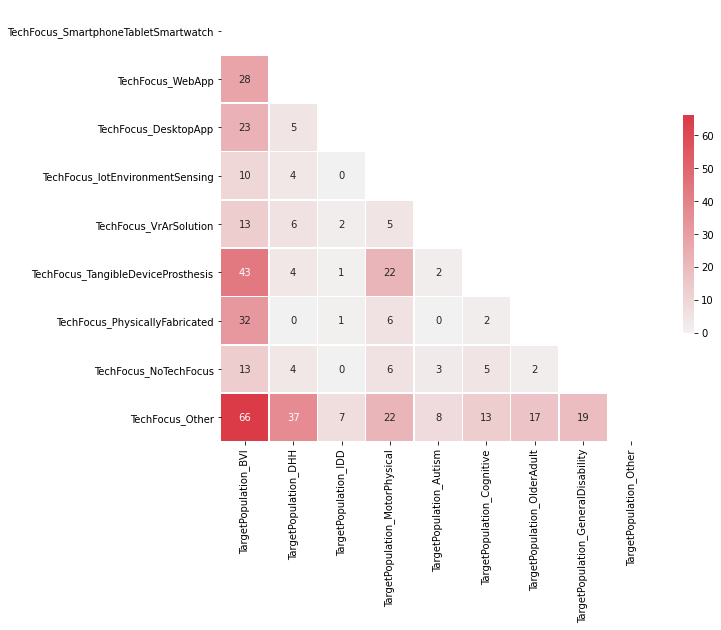

** Fraction of sub-code co-occurrences for TargetPopulation and TechFocus (divisor is column sum) **


TargetPopulation_BVI  \
TechFocus_SmartphoneTabletSmartwatch              0.390909   
TechFocus_WebApp                                  0.127273   
TechFocus_DesktopApp                              0.104545   
TechFocus_IotEnvironmentSensing                   0.045455   
TechFocus_VrArSolution                            0.059091   
TechFocus_TangibleDeviceProsthesis                0.195455   
TechFocus_PhysicallyFabricated                    0.145455   
TechFocus_NoTechFocus                             0.059091   
TechFocus_Other                                   0.300000   

                                      TargetPopulation_DHH  \
TechFocus_SmartphoneTabletSmartwatch              0.157895   
TechFocus_WebApp                                  0.122807   
TechFocus_DesktopApp                              0.087719   
TechFocus_IotEnvironmentSensing                   0.070175   
TechFocus_VrArSolution                            0.105263   
TechFocus_TangibleDeviceProsthesis                0.070175   
TechFocus_PhysicallyFabricated                    0.000000   
TechFocus_NoTechFocus                             0.070175   
TechFocus_Other                                   0.649123   

                                      TargetPopulation_IDD  \
TechFocus_SmartphoneTabletSmartwatch              0.214286   
TechFocus_WebApp                                  0.214286   
TechFocus_DesktopApp                              0.142857   
TechFocus_IotEnvironmentSensing                   0.000000   
TechFocus_VrArSolution                            0.142857   
TechFocus_TangibleDeviceProsthesis                0.071429   
TechFocus_PhysicallyFabricated                    0.071429   
TechFocus_NoTechFocus                             0.000000   
TechFocus_Other                                   0.500000   

                                      TargetPopulation_MotorPhysical  \
TechFocus_SmartphoneTabletSmartwatch                        0.347222   
TechFocus_WebApp                                            0.055556   
TechFocus_DesktopApp                                        0.097222   
TechFocus_IotEnvironmentSensing                             0.069444   
TechFocus_VrArSolution                                      0.069444   
TechFocus_TangibleDeviceProsthesis                          0.305556   
TechFocus_PhysicallyFabricated                              0.083333   
TechFocus_NoTechFocus                                       0.083333   
TechFocus_Other                                             0.305556   

                                      TargetPopulation_Autism  \
TechFocus_SmartphoneTabletSmartwatch                 0.290323   
TechFocus_WebApp                                     0.096774   
TechFocus_DesktopApp                                 0.129032   
TechFocus_IotEnvironmentSensing                      0.032258   
TechFocus_VrArSolution                               0.161290   
TechFocus_TangibleDeviceProsthesis                   0.064516   
TechFocus_PhysicallyFabricated                       0.000000   
TechFocus_NoTechFocus                                0.096774   
TechFocus_Other                                      0.258065   

                                      TargetPopulation_Cognitive  \
TechFocus_SmartphoneTabletSmartwatch                    0.152174   
TechFocus_WebApp                                        0.173913   
TechFocus_DesktopApp                                    0.130435   
TechFocus_IotEnvironmentSensing                         0.065217   
TechFocus_VrArSolution                                  0.130435   
TechFocus_TangibleDeviceProsthesis                      0.108696   
TechFocus_PhysicallyFabricated                          0.043478   
TechFocus_NoTechFocus                                   0.108696   
TechFocus_Other                                         0.282609   

                                      TargetPopulation_OlderAdult  \
TechFocus_SmartphoneTabletSmartwatch                 

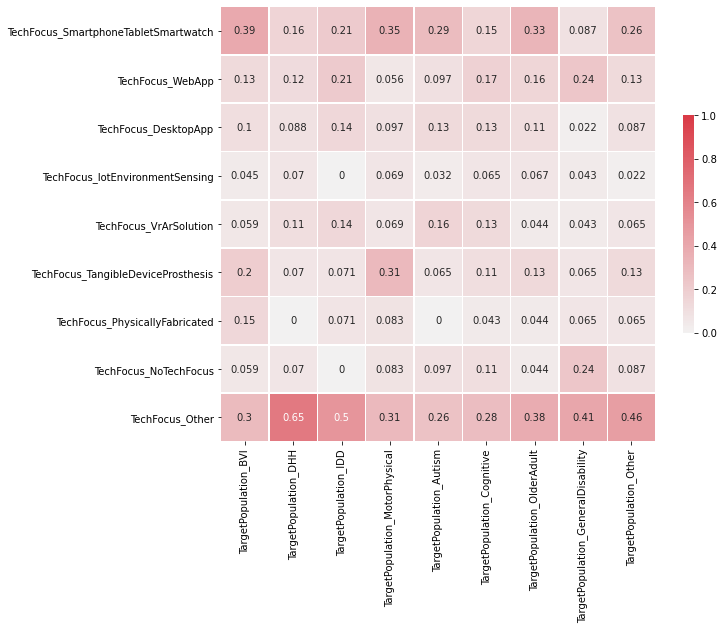

** Fraction of sub-code co-occurrences for TargetPopulation and TechFocus (divisor is row sum) **


TargetPopulation_BVI  \
TechFocus_SmartphoneTabletSmartwatch              0.551282   
TechFocus_WebApp                                  0.444444   
TechFocus_DesktopApp                              0.425926   
TechFocus_IotEnvironmentSensing                   0.400000   
TechFocus_VrArSolution                            0.325000   
TechFocus_TangibleDeviceProsthesis                0.537500   
TechFocus_PhysicallyFabricated                    0.780488   
TechFocus_NoTechFocus                             0.342105   
TechFocus_Other                                   0.358696   

                                      TargetPopulation_DHH  \
TechFocus_SmartphoneTabletSmartwatch              0.057692   
TechFocus_WebApp                                  0.111111   
TechFocus_DesktopApp                              0.092593   
TechFocus_IotEnvironmentSensing                   0.160000   
TechFocus_VrArSolution                            0.150000   
TechFocus_TangibleDeviceProsthesis                0.050000   
TechFocus_PhysicallyFabricated                    0.000000   
TechFocus_NoTechFocus                             0.105263   
TechFocus_Other                                   0.201087   

                                      TargetPopulation_IDD  \
TechFocus_SmartphoneTabletSmartwatch              0.019231   
TechFocus_WebApp                                  0.047619   
TechFocus_DesktopApp                              0.037037   
TechFocus_IotEnvironmentSensing                   0.000000   
TechFocus_VrArSolution                            0.050000   
TechFocus_TangibleDeviceProsthesis                0.012500   
TechFocus_PhysicallyFabricated                    0.024390   
TechFocus_NoTechFocus                             0.000000   
TechFocus_Other                                   0.038043   

                                      TargetPopulation_MotorPhysical  \
TechFocus_SmartphoneTabletSmartwatch                        0.160256   
TechFocus_WebApp                                            0.063492   
TechFocus_DesktopApp                                        0.129630   
TechFocus_IotEnvironmentSensing                             0.200000   
TechFocus_VrArSolution                                      0.125000   
TechFocus_TangibleDeviceProsthesis                          0.275000   
TechFocus_PhysicallyFabricated                              0.146341   
TechFocus_NoTechFocus                                       0.157895   
TechFocus_Other                                             0.119565   

                                      TargetPopulation_Autism  \
TechFocus_SmartphoneTabletSmartwatch                 0.057692   
TechFocus_WebApp                                     0.047619   
TechFocus_DesktopApp                                 0.074074   
TechFocus_IotEnvironmentSensing                      0.040000   
TechFocus_VrArSolution                               0.125000   
TechFocus_TangibleDeviceProsthesis                   0.025000   
TechFocus_PhysicallyFabricated                       0.000000   
TechFocus_NoTechFocus                                0.078947   
TechFocus_Other                                      0.043478   

                                      TargetPopulation_Cognitive  \
TechFocus_SmartphoneTabletSmartwatch                    0.044872   
TechFocus_WebApp                                        0.126984   
TechFocus_DesktopApp                                    0.111111   
TechFocus_IotEnvironmentSensing                         0.120000   
TechFocus_VrArSolution                                  0.150000   
TechFocus_TangibleDeviceProsthesis                      0.062500   
TechFocus_PhysicallyFabricated                          0.048780   
TechFocus_NoTechFocus                                   0.131579   
TechFocus_Other                                         0.070652   

                                      TargetPopulation_OlderAdult  \
TechFocus_SmartphoneTabletSmartwatch                 

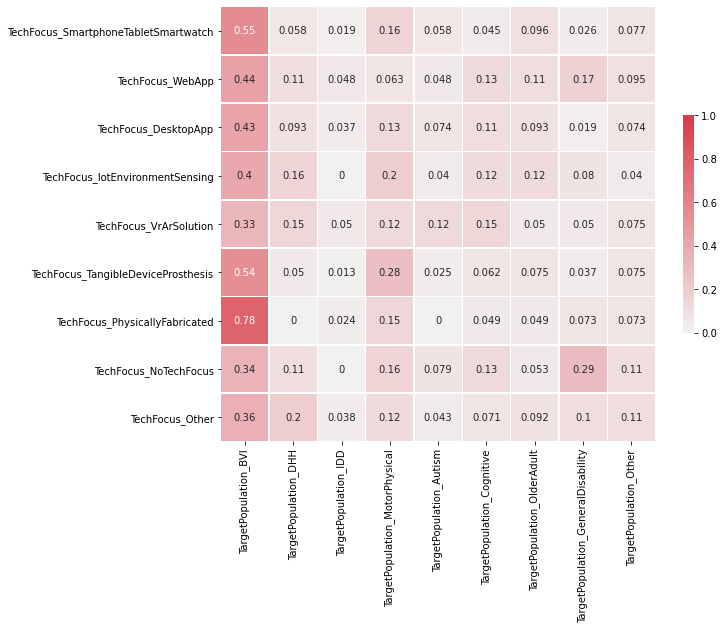



******** TargetPopulation and CountTechFocus *******

** Raw sub-code co-occurrence count for TargetPopulation and CountTechFocus **


TargetPopulation_BVI  TargetPopulation_DHH  \
CountTechFocus_ExcludingOther                   142                    28   

                               TargetPopulation_IDD  \
CountTechFocus_ExcludingOther                     7   

                               TargetPopulation_MotorPhysical  \
CountTechFocus_ExcludingOther                              53   

                               TargetPopulation_Autism  \
CountTechFocus_ExcludingOther                       21   

                               TargetPopulation_Cognitive  \
CountTechFocus_ExcludingOther                          30   

                               TargetPopulation_OlderAdult  \
CountTechFocus_ExcludingOther                           24   

                               TargetPopulation_GeneralDisability  \
CountTechFocus_ExcludingOther                                  29   

                               TargetPopulation_Other  
CountTechFocus_ExcludingOther                      23

C:\Users\jonfr\Anaconda3\envs\qualitativeanalysis\lib\site-packages\seaborn\matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\jonfr\Anaconda3\envs\qualitativeanalysis\lib\site-packages\seaborn\matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


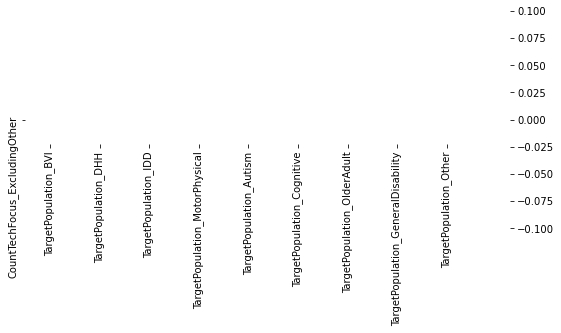

** Fraction of sub-code co-occurrences for TargetPopulation and CountTechFocus (divisor is column sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
CountTechFocus_ExcludingOther              0.645455              0.491228   

                               TargetPopulation_IDD  \
CountTechFocus_ExcludingOther                   0.5   

                               TargetPopulation_MotorPhysical  \
CountTechFocus_ExcludingOther                        0.736111   

                               TargetPopulation_Autism  \
CountTechFocus_ExcludingOther                 0.677419   

                               TargetPopulation_Cognitive  \
CountTechFocus_ExcludingOther                    0.652174   

                               TargetPopulation_OlderAdult  \
CountTechFocus_ExcludingOther                     0.533333   

                               TargetPopulation_GeneralDisability  \
CountTechFocus_ExcludingOther                            0.630435   

                               TargetPopulation_Other  
CountTechFocus_ExcludingOther                     0.5

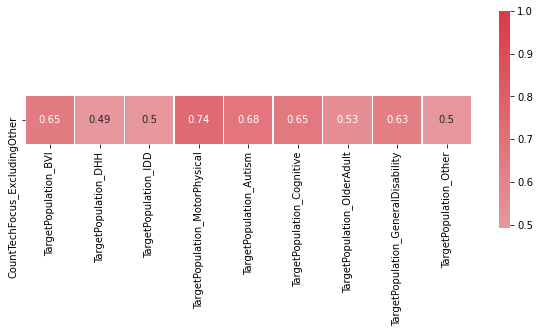

** Fraction of sub-code co-occurrences for TargetPopulation and CountTechFocus (divisor is row sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
CountTechFocus_ExcludingOther              0.285714              0.056338   

                               TargetPopulation_IDD  \
CountTechFocus_ExcludingOther              0.014085   

                               TargetPopulation_MotorPhysical  \
CountTechFocus_ExcludingOther                         0.10664   

                               TargetPopulation_Autism  \
CountTechFocus_ExcludingOther                 0.042254   

                               TargetPopulation_Cognitive  \
CountTechFocus_ExcludingOther                    0.060362   

                               TargetPopulation_OlderAdult  \
CountTechFocus_ExcludingOther                      0.04829   

                               TargetPopulation_GeneralDisability  \
CountTechFocus_ExcludingOther                             0.05835   

                               TargetPopulation_Other  
CountTechFocus_ExcludingOther                0.046278

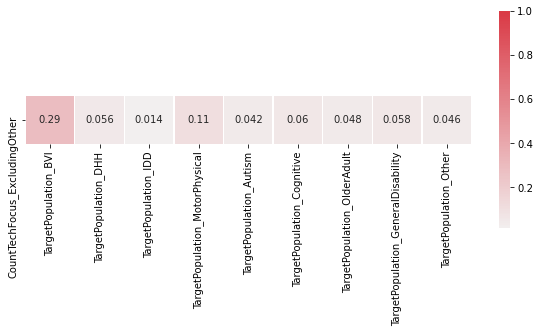



******** TargetPopulation and TechFocusOther *******

** Raw sub-code co-occurrence count for TargetPopulation and TechFocusOther **


TargetPopulation_BVI  TargetPopulation_DHH  \
TechFocusOther_Algo                            18                     7   
TechFocusOther_General                          9                     3   
TechFocusOther_TechAgnostic                    24                    24   

                             TargetPopulation_IDD  \
TechFocusOther_Algo                             1   
TechFocusOther_General                          2   
TechFocusOther_TechAgnostic                     2   

                             TargetPopulation_MotorPhysical  \
TechFocusOther_Algo                                       8   
TechFocusOther_General                                    3   
TechFocusOther_TechAgnostic                               4   

                             TargetPopulation_Autism  \
TechFocusOther_Algo                                2   
TechFocusOther_General                             3   
TechFocusOther_TechAgnostic                        3   

                             TargetPopulation_Cognitive  \
TechFocusOther_Algo                                   1   
TechFocusOther_General                                5   
TechFocusOther_TechAgnostic                           6   

                             TargetPopulation_OlderAdult  \
TechFocusOther_Algo                                    3   
TechFocusOther_General                                 6   
TechFocusOther_TechAgnostic                            5   

                             TargetPopulation_GeneralDisability  \
TechFocusOther_Algo                                           2   
TechFocusOther_General                                       12   
TechFocusOther_TechAgnostic                                   3   

                             TargetPopulation_Other  
TechFocusOther_Algo                               6  
TechFocusOther_General                            5  
TechFocusOther_TechAgnostic                       9

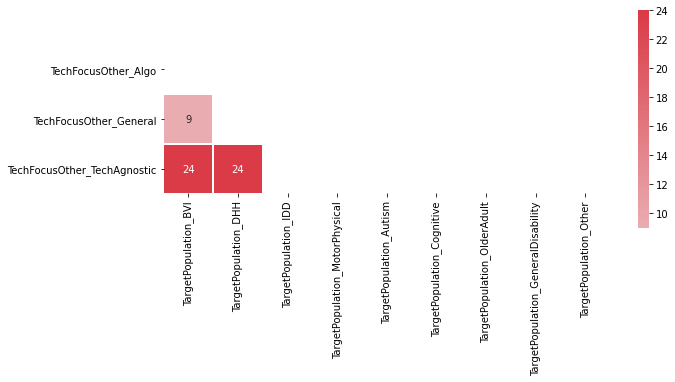

** Fraction of sub-code co-occurrences for TargetPopulation and TechFocusOther (divisor is column sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
TechFocusOther_Algo                      0.081818              0.122807   
TechFocusOther_General                   0.040909              0.052632   
TechFocusOther_TechAgnostic              0.109091              0.421053   

                             TargetPopulation_IDD  \
TechFocusOther_Algo                      0.071429   
TechFocusOther_General                   0.142857   
TechFocusOther_TechAgnostic              0.142857   

                             TargetPopulation_MotorPhysical  \
TechFocusOther_Algo                                0.111111   
TechFocusOther_General                             0.041667   
TechFocusOther_TechAgnostic                        0.055556   

                             TargetPopulation_Autism  \
TechFocusOther_Algo                         0.064516   
TechFocusOther_General                      0.096774   
TechFocusOther_TechAgnostic                 0.096774   

                             TargetPopulation_Cognitive  \
TechFocusOther_Algo                            0.021739   
TechFocusOther_General                         0.108696   
TechFocusOther_TechAgnostic                    0.130435   

                             TargetPopulation_OlderAdult  \
TechFocusOther_Algo                             0.066667   
TechFocusOther_General                          0.133333   
TechFocusOther_TechAgnostic                     0.111111   

                             TargetPopulation_GeneralDisability  \
TechFocusOther_Algo                                    0.043478   
TechFocusOther_General                                 0.260870   
TechFocusOther_TechAgnostic                            0.065217   

                             TargetPopulation_Other  
TechFocusOther_Algo                        0.130435  
TechFocusOther_General                     0.108696  
TechFocusOther_TechAgnostic                0.195652

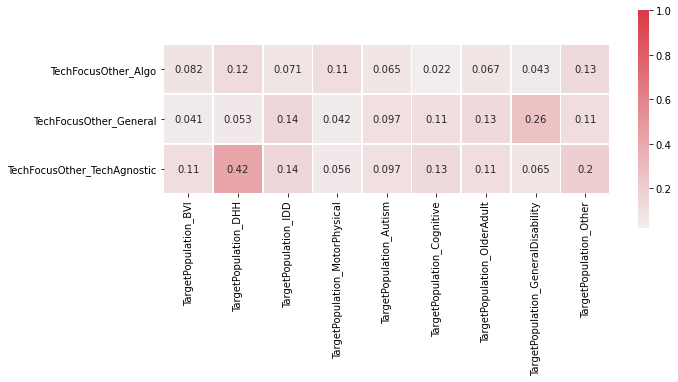

** Fraction of sub-code co-occurrences for TargetPopulation and TechFocusOther (divisor is row sum) **


TargetPopulation_BVI  TargetPopulation_DHH  \
TechFocusOther_Algo                      0.409091              0.159091   
TechFocusOther_General                   0.230769              0.076923   
TechFocusOther_TechAgnostic              0.347826              0.347826   

                             TargetPopulation_IDD  \
TechFocusOther_Algo                      0.022727   
TechFocusOther_General                   0.051282   
TechFocusOther_TechAgnostic              0.028986   

                             TargetPopulation_MotorPhysical  \
TechFocusOther_Algo                                0.181818   
TechFocusOther_General                             0.076923   
TechFocusOther_TechAgnostic                        0.057971   

                             TargetPopulation_Autism  \
TechFocusOther_Algo                         0.045455   
TechFocusOther_General                      0.076923   
TechFocusOther_TechAgnostic                 0.043478   

                             TargetPopulation_Cognitive  \
TechFocusOther_Algo                            0.022727   
TechFocusOther_General                         0.128205   
TechFocusOther_TechAgnostic                    0.086957   

                             TargetPopulation_OlderAdult  \
TechFocusOther_Algo                             0.068182   
TechFocusOther_General                          0.153846   
TechFocusOther_TechAgnostic                     0.072464   

                             TargetPopulation_GeneralDisability  \
TechFocusOther_Algo                                    0.045455   
TechFocusOther_General                                 0.307692   
TechFocusOther_TechAgnostic                            0.043478   

                             TargetPopulation_Other  
TechFocusOther_Algo                        0.136364  
TechFocusOther_General                     0.128205  
TechFocusOther_TechAgnostic                0.130435

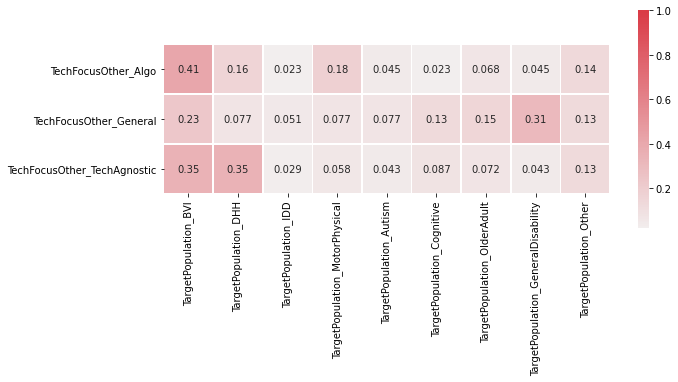



******** TargetPopulation and IssueAddressed *******

** Raw sub-code co-occurrence count for TargetPopulation and IssueAddressed **


TargetPopulation_BVI  \
IssueAddressed_IncreaseDigitalAccess                                 106   
IssueAddressed_IncreasePhysicalAccess                                 77   
IssueAddressed_IncreaseIndependence                                   63   
IssueAddressed_IncreaseUnderstandingOfUsers                           47   
IssueAddressed_HelpWithPersonalInformaticsBehav...                     5   
IssueAddressed_SupportCommunication                                   10   
IssueAddressed_Other                                                  21   

                                                    TargetPopulation_DHH  \
IssueAddressed_IncreaseDigitalAccess                                  11   
IssueAddressed_IncreasePhysicalAccess                                  6   
IssueAddressed_IncreaseIndependence                                    0   
IssueAddressed_IncreaseUnderstandingOfUsers                           15   
IssueAddressed_HelpWithPersonalInformaticsBehav...                     1   
IssueAddressed_SupportCommunication                                   37   
IssueAddressed_Other                                                   4   

                                                    TargetPopulation_IDD  \
IssueAddressed_IncreaseDigitalAccess                                   0   
IssueAddressed_IncreasePhysicalAccess                                  1   
IssueAddressed_IncreaseIndependence                                    6   
IssueAddressed_IncreaseUnderstandingOfUsers                            2   
IssueAddressed_HelpWithPersonalInformaticsBehav...                     5   
IssueAddressed_SupportCommunication                                    1   
IssueAddressed_Other                                                   3   

                                                    TargetPopulation_MotorPhysical  \
IssueAddressed_IncreaseDigitalAccess                                            29   
IssueAddressed_IncreasePhysicalAccess                                           16   
IssueAddressed_IncreaseIndependence                                              9   
IssueAddressed_IncreaseUnderstandingOfUsers                                     21   
IssueAddressed_HelpWithPersonalInformaticsBehav...                               7   
IssueAddressed_SupportCommunication                                              5   
IssueAddressed_Other                                                            10   

                                                    TargetPopulation_Autism  \
IssueAddressed_IncreaseDigitalAccess                                      4   
IssueAddressed_IncreasePhysicalAccess                                     0   
IssueAddressed_IncreaseIndependence                                       1   
IssueAddressed_IncreaseUnderstandingOfUsers                              10   
IssueAddressed_HelpWithPersonalInformaticsBehav...                       10   
IssueAddressed_SupportCommunication                                       8   
IssueAddressed_Other                                                      4   

                                                    TargetPopulation_Cognitive  \
IssueAddressed_IncreaseDigitalAccess                                         8   
IssueAddressed_IncreasePhysicalAccess                                        3   
IssueAddressed_IncreaseIndependence                                          9   
IssueAddressed_IncreaseUnderstandingOfUsers                                 17   
IssueAddressed_HelpWithPersonalInformaticsBehav...                           6   
IssueAddressed_SupportCommunication                                         12   
IssueAddressed_Other                                                         7   

                                                    TargetPopulation_OlderAdult  \
IssueAddressed_IncreaseDigitalAccess                                         16   
IssueAddressed_IncreasePhysicalAccess                                         5 

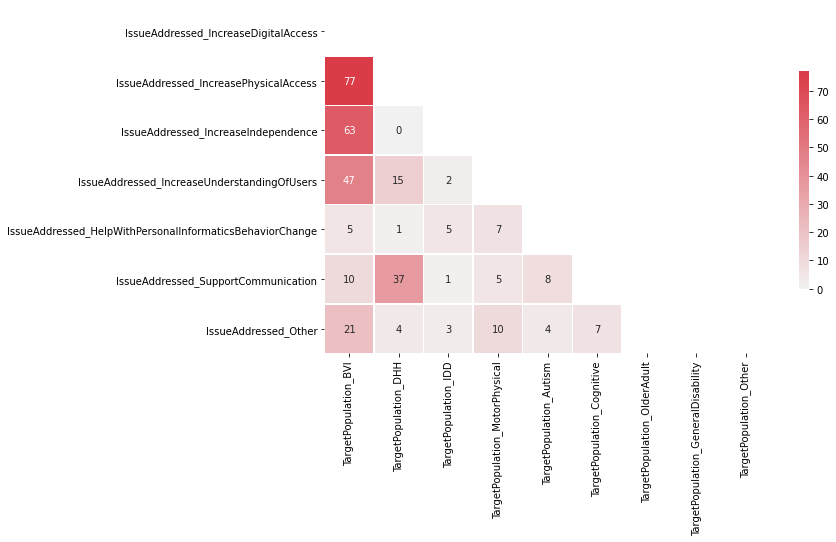

** Fraction of sub-code co-occurrences for TargetPopulation and IssueAddressed (divisor is column sum) **


TargetPopulation_BVI  \
IssueAddressed_IncreaseDigitalAccess                            0.481818   
IssueAddressed_IncreasePhysicalAccess                           0.350000   
IssueAddressed_IncreaseIndependence                             0.286364   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.213636   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.022727   
IssueAddressed_SupportCommunication                             0.045455   
IssueAddressed_Other                                            0.095455   

                                                    TargetPopulation_DHH  \
IssueAddressed_IncreaseDigitalAccess                            0.192982   
IssueAddressed_IncreasePhysicalAccess                           0.105263   
IssueAddressed_IncreaseIndependence                             0.000000   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.263158   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.017544   
IssueAddressed_SupportCommunication                             0.649123   
IssueAddressed_Other                                            0.070175   

                                                    TargetPopulation_IDD  \
IssueAddressed_IncreaseDigitalAccess                            0.000000   
IssueAddressed_IncreasePhysicalAccess                           0.071429   
IssueAddressed_IncreaseIndependence                             0.428571   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.142857   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.357143   
IssueAddressed_SupportCommunication                             0.071429   
IssueAddressed_Other                                            0.214286   

                                                    TargetPopulation_MotorPhysical  \
IssueAddressed_IncreaseDigitalAccess                                      0.402778   
IssueAddressed_IncreasePhysicalAccess                                     0.222222   
IssueAddressed_IncreaseIndependence                                       0.125000   
IssueAddressed_IncreaseUnderstandingOfUsers                               0.291667   
IssueAddressed_HelpWithPersonalInformaticsBehav...                        0.097222   
IssueAddressed_SupportCommunication                                       0.069444   
IssueAddressed_Other                                                      0.138889   

                                                    TargetPopulation_Autism  \
IssueAddressed_IncreaseDigitalAccess                               0.129032   
IssueAddressed_IncreasePhysicalAccess                              0.000000   
IssueAddressed_IncreaseIndependence                                0.032258   
IssueAddressed_IncreaseUnderstandingOfUsers                        0.322581   
IssueAddressed_HelpWithPersonalInformaticsBehav...                 0.322581   
IssueAddressed_SupportCommunication                                0.258065   
IssueAddressed_Other                                               0.129032   

                                                    TargetPopulation_Cognitive  \
IssueAddressed_IncreaseDigitalAccess                                  0.173913   
IssueAddressed_IncreasePhysicalAccess                                 0.065217   
IssueAddressed_IncreaseIndependence                                   0.195652   
IssueAddressed_IncreaseUnderstandingOfUsers                           0.369565   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    0.130435   
IssueAddressed_SupportCommunication                                   0.260870   
IssueAddressed_Other                                                  0.152174   

                                                    TargetPopulation_OlderAdult  \
IssueAddressed_IncreaseDigitalAccess                                   0.355556   
IssueAddressed_IncreasePhysicalAccess                                  0.111111 

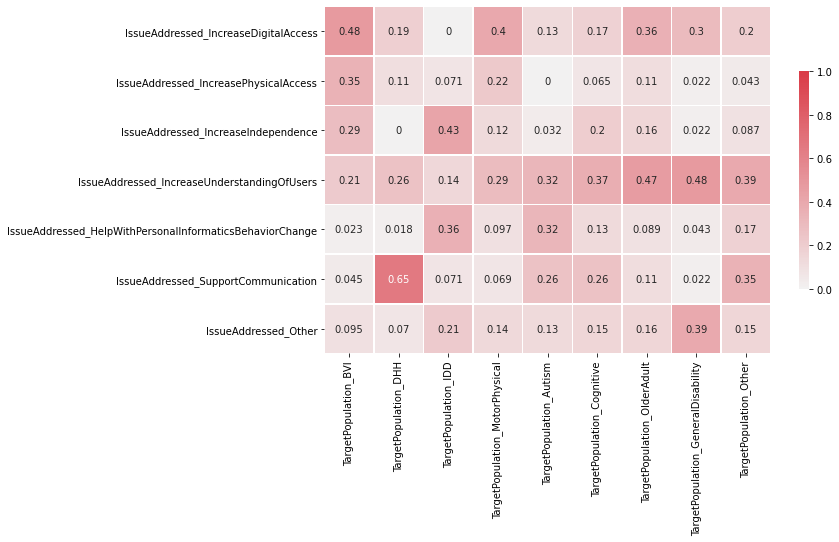

** Fraction of sub-code co-occurrences for TargetPopulation and IssueAddressed (divisor is row sum) **


TargetPopulation_BVI  \
IssueAddressed_IncreaseDigitalAccess                            0.569892   
IssueAddressed_IncreasePhysicalAccess                           0.733333   
IssueAddressed_IncreaseIndependence                             0.677419   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.338129   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.128205   
IssueAddressed_SupportCommunication                             0.123457   
IssueAddressed_Other                                            0.355932   

                                                    TargetPopulation_DHH  \
IssueAddressed_IncreaseDigitalAccess                            0.059140   
IssueAddressed_IncreasePhysicalAccess                           0.057143   
IssueAddressed_IncreaseIndependence                             0.000000   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.107914   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.025641   
IssueAddressed_SupportCommunication                             0.456790   
IssueAddressed_Other                                            0.067797   

                                                    TargetPopulation_IDD  \
IssueAddressed_IncreaseDigitalAccess                            0.000000   
IssueAddressed_IncreasePhysicalAccess                           0.009524   
IssueAddressed_IncreaseIndependence                             0.064516   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.014388   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.128205   
IssueAddressed_SupportCommunication                             0.012346   
IssueAddressed_Other                                            0.050847   

                                                    TargetPopulation_MotorPhysical  \
IssueAddressed_IncreaseDigitalAccess                                      0.155914   
IssueAddressed_IncreasePhysicalAccess                                     0.152381   
IssueAddressed_IncreaseIndependence                                       0.096774   
IssueAddressed_IncreaseUnderstandingOfUsers                               0.151079   
IssueAddressed_HelpWithPersonalInformaticsBehav...                        0.179487   
IssueAddressed_SupportCommunication                                       0.061728   
IssueAddressed_Other                                                      0.169492   

                                                    TargetPopulation_Autism  \
IssueAddressed_IncreaseDigitalAccess                               0.021505   
IssueAddressed_IncreasePhysicalAccess                              0.000000   
IssueAddressed_IncreaseIndependence                                0.010753   
IssueAddressed_IncreaseUnderstandingOfUsers                        0.071942   
IssueAddressed_HelpWithPersonalInformaticsBehav...                 0.256410   
IssueAddressed_SupportCommunication                                0.098765   
IssueAddressed_Other                                               0.067797   

                                                    TargetPopulation_Cognitive  \
IssueAddressed_IncreaseDigitalAccess                                  0.043011   
IssueAddressed_IncreasePhysicalAccess                                 0.028571   
IssueAddressed_IncreaseIndependence                                   0.096774   
IssueAddressed_IncreaseUnderstandingOfUsers                           0.122302   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    0.153846   
IssueAddressed_SupportCommunication                                   0.148148   
IssueAddressed_Other                                                  0.118644   

                                                    TargetPopulation_OlderAdult  \
IssueAddressed_IncreaseDigitalAccess                                   0.086022   
IssueAddressed_IncreasePhysicalAccess                                  0.047619 

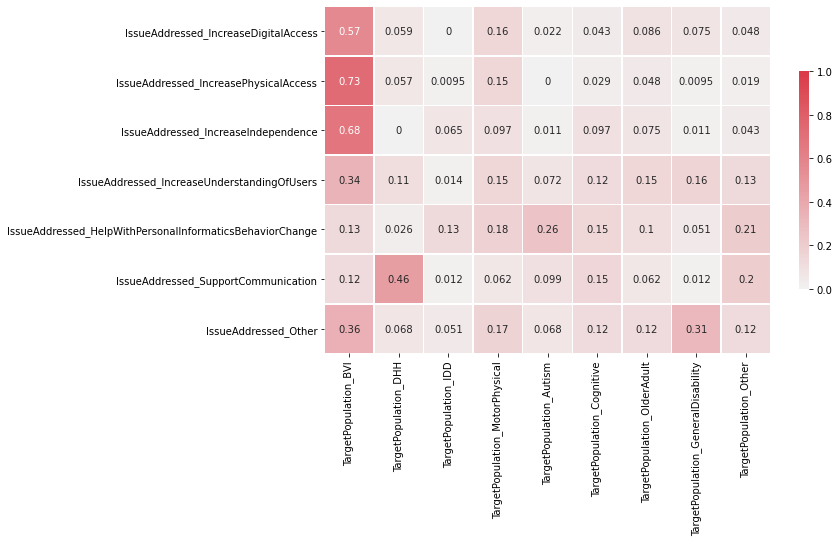



******** TargetPopulation and ContributionType *******

** Raw sub-code co-occurrence count for TargetPopulation and ContributionType **


<ipython-input-70-80f28d565353>:28: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_frac_of_codecat2 = co_occurrence_count / codecat2_subcode_cnt
<ipython-input-70-80f28d565353>:28: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_frac_of_codecat2 = co_occurrence_count / codecat2_subcode_cnt
<ipython-input-70-80f28d565353>:28: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_frac_of_codecat2 = co_occurrence_count / codecat2_subcode_cnt
<ipython-input-70-80f28d565353>:28: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_frac_of_codecat2 = co_occurrence_count / codecat2_subcode_cnt
<ipython-input-70-80f28d565353>:28: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_frac_of_codecat2 = co_occurrence_count / codecat2_subcode_cnt
<ipython-input-70-80f28d565353>:28: RuntimeWarning: invalid value encountered in longlong_scalars
  co_occurrence_frac_o

TargetPopulation_BVI  \
ContributionType_Empirical                            121   
ContributionType_Artifact                             143   
ContributionType_Methodological                         3   
ContributionType_Theoretical                           16   
ContributionType_Dataset                                2   
ContributionType_SurveyContribution                     1   
ContributionType_Opinion                                0   
ContributionType_Other                                  0   

                                     TargetPopulation_DHH  \
ContributionType_Empirical                             42   
ContributionType_Artifact                              24   
ContributionType_Methodological                         2   
ContributionType_Theoretical                            3   
ContributionType_Dataset                                1   
ContributionType_SurveyContribution                     0   
ContributionType_Opinion                                0   
ContributionType_Other                                  0   

                                     TargetPopulation_IDD  \
ContributionType_Empirical                              7   
ContributionType_Artifact                               9   
ContributionType_Methodological                         1   
ContributionType_Theoretical                            1   
ContributionType_Dataset                                0   
ContributionType_SurveyContribution                     0   
ContributionType_Opinion                                0   
ContributionType_Other                                  0   

                                     TargetPopulation_MotorPhysical  \
ContributionType_Empirical                                       45   
ContributionType_Artifact                                        39   
ContributionType_Methodological                                   2   
ContributionType_Theoretical                                      6   
ContributionType_Dataset                                          2   
ContributionType_SurveyContribution                               0   
ContributionType_Opinion                                          0   
ContributionType_Other                                            0   

                                     TargetPopulation_Autism  \
ContributionType_Empirical                                18   
ContributionType_Artifact                                 14   
ContributionType_Methodological                            4   
ContributionType_Theoretical                               4   
ContributionType_Dataset                                   0   
ContributionType_SurveyContribution                        1   
ContributionType_Opinion                                   0   
ContributionType_Other                                     0   

                                     TargetPopulation_Cognitive  \
ContributionType_Empirical                                   26   
ContributionType_Artifact                                    25   
ContributionType_Methodological                               3   
ContributionType_Theoretical                                  4   
ContributionType_Dataset                                      2   
ContributionType_SurveyContribution                           0   
ContributionType_Opinion                                      0   
ContributionType_Other                                        0   

                                     TargetPopulation_OlderAdult  \
ContributionType_Empirical                                    31   
ContributionType_Artifact                                     21   
ContributionType_Methodological                                3   
ContributionType_Theoretical                                   5   
ContributionType_Dataset                                       1   
ContributionType_SurveyContribution                            0   
ContributionType_Opinion                                       0   
ContributionType_Other

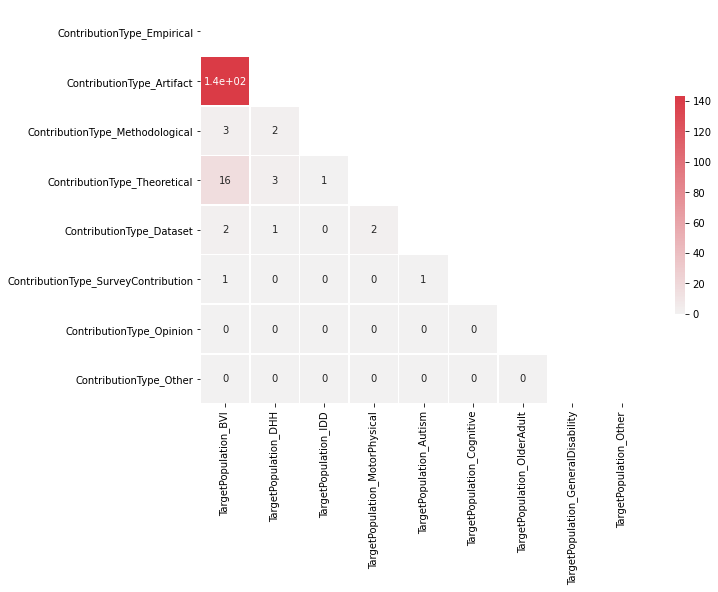

** Fraction of sub-code co-occurrences for TargetPopulation and ContributionType (divisor is column sum) **


TargetPopulation_BVI  \
ContributionType_Empirical                       0.550000   
ContributionType_Artifact                        0.650000   
ContributionType_Methodological                  0.013636   
ContributionType_Theoretical                     0.072727   
ContributionType_Dataset                         0.009091   
ContributionType_SurveyContribution              0.004545   
ContributionType_Opinion                         0.000000   
ContributionType_Other                           0.000000   

                                     TargetPopulation_DHH  \
ContributionType_Empirical                       0.736842   
ContributionType_Artifact                        0.421053   
ContributionType_Methodological                  0.035088   
ContributionType_Theoretical                     0.052632   
ContributionType_Dataset                         0.017544   
ContributionType_SurveyContribution              0.000000   
ContributionType_Opinion                         0.000000   
ContributionType_Other                           0.000000   

                                     TargetPopulation_IDD  \
ContributionType_Empirical                       0.500000   
ContributionType_Artifact                        0.642857   
ContributionType_Methodological                  0.071429   
ContributionType_Theoretical                     0.071429   
ContributionType_Dataset                         0.000000   
ContributionType_SurveyContribution              0.000000   
ContributionType_Opinion                         0.000000   
ContributionType_Other                           0.000000   

                                     TargetPopulation_MotorPhysical  \
ContributionType_Empirical                                 0.625000   
ContributionType_Artifact                                  0.541667   
ContributionType_Methodological                            0.027778   
ContributionType_Theoretical                               0.083333   
ContributionType_Dataset                                   0.027778   
ContributionType_SurveyContribution                        0.000000   
ContributionType_Opinion                                   0.000000   
ContributionType_Other                                     0.000000   

                                     TargetPopulation_Autism  \
ContributionType_Empirical                          0.580645   
ContributionType_Artifact                           0.451613   
ContributionType_Methodological                     0.129032   
ContributionType_Theoretical                        0.129032   
ContributionType_Dataset                            0.000000   
ContributionType_SurveyContribution                 0.032258   
ContributionType_Opinion                            0.000000   
ContributionType_Other                              0.000000   

                                     TargetPopulation_Cognitive  \
ContributionType_Empirical                             0.565217   
ContributionType_Artifact                              0.543478   
ContributionType_Methodological                        0.065217   
ContributionType_Theoretical                           0.086957   
ContributionType_Dataset                               0.043478   
ContributionType_SurveyContribution                    0.000000   
ContributionType_Opinion                               0.000000   
ContributionType_Other                                 0.000000   

                                     TargetPopulation_OlderAdult  \
ContributionType_Empirical                              0.688889   
ContributionType_Artifact                               0.466667   
ContributionType_Methodological                         0.066667   
ContributionType_Theoretical                            0.111111   
ContributionType_Dataset                                0.022222   
ContributionType_SurveyContribution                     0.000000   
ContributionType_Opinion                                0.000000   
ContributionType_Other

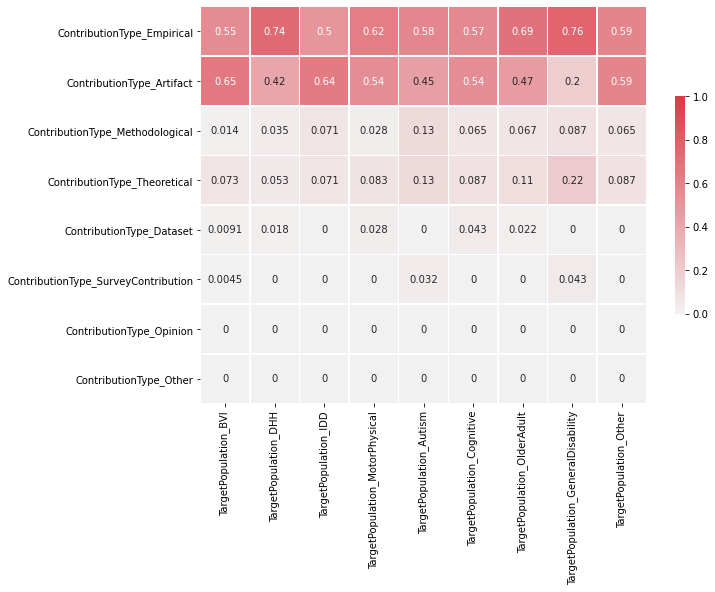

** Fraction of sub-code co-occurrences for TargetPopulation and ContributionType (divisor is row sum) **


TargetPopulation_BVI  \
ContributionType_Empirical                       0.396721   
ContributionType_Artifact                        0.508897   
ContributionType_Methodological                  0.187500   
ContributionType_Theoretical                     0.363636   
ContributionType_Dataset                         0.285714   
ContributionType_SurveyContribution              0.333333   
ContributionType_Opinion                              NaN   
ContributionType_Other                                NaN   

                                     TargetPopulation_DHH  \
ContributionType_Empirical                       0.137705   
ContributionType_Artifact                        0.085409   
ContributionType_Methodological                  0.125000   
ContributionType_Theoretical                     0.068182   
ContributionType_Dataset                         0.142857   
ContributionType_SurveyContribution              0.000000   
ContributionType_Opinion                              NaN   
ContributionType_Other                                NaN   

                                     TargetPopulation_IDD  \
ContributionType_Empirical                       0.022951   
ContributionType_Artifact                        0.032028   
ContributionType_Methodological                  0.062500   
ContributionType_Theoretical                     0.022727   
ContributionType_Dataset                         0.000000   
ContributionType_SurveyContribution              0.000000   
ContributionType_Opinion                              NaN   
ContributionType_Other                                NaN   

                                     TargetPopulation_MotorPhysical  \
ContributionType_Empirical                                 0.147541   
ContributionType_Artifact                                  0.138790   
ContributionType_Methodological                            0.125000   
ContributionType_Theoretical                               0.136364   
ContributionType_Dataset                                   0.285714   
ContributionType_SurveyContribution                        0.000000   
ContributionType_Opinion                                        NaN   
ContributionType_Other                                          NaN   

                                     TargetPopulation_Autism  \
ContributionType_Empirical                          0.059016   
ContributionType_Artifact                           0.049822   
ContributionType_Methodological                     0.250000   
ContributionType_Theoretical                        0.090909   
ContributionType_Dataset                            0.000000   
ContributionType_SurveyContribution                 0.333333   
ContributionType_Opinion                                 NaN   
ContributionType_Other                                   NaN   

                                     TargetPopulation_Cognitive  \
ContributionType_Empirical                             0.085246   
ContributionType_Artifact                              0.088968   
ContributionType_Methodological                        0.187500   
ContributionType_Theoretical                           0.090909   
ContributionType_Dataset                               0.285714   
ContributionType_SurveyContribution                    0.000000   
ContributionType_Opinion                                    NaN   
ContributionType_Other                                      NaN   

                                     TargetPopulation_OlderAdult  \
ContributionType_Empirical                              0.101639   
ContributionType_Artifact                               0.074733   
ContributionType_Methodological                         0.187500   
ContributionType_Theoretical                            0.113636   
ContributionType_Dataset                                0.142857   
ContributionType_SurveyContribution                     0.000000   
ContributionType_Opinion                                     NaN   
ContributionType_Other

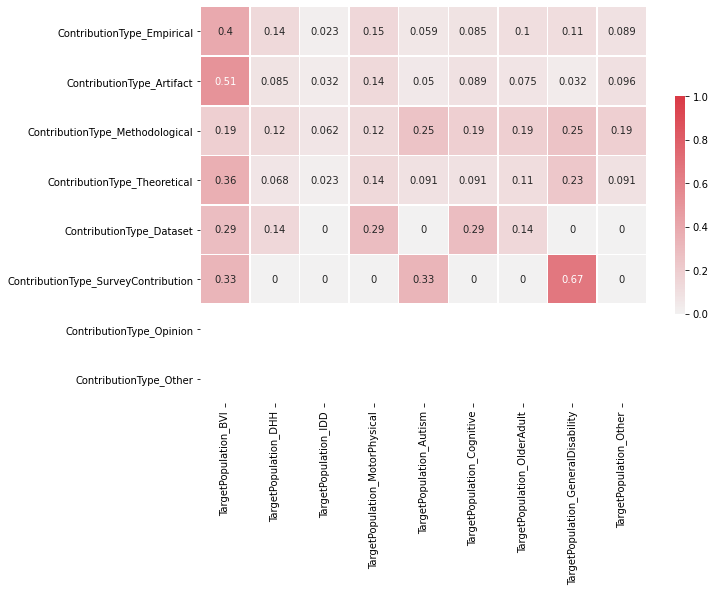

In [71]:
# Print out co-occurrence information
code_cats = list(map_codes.keys())

code_cats.remove('NumParticipants')
code_cats.remove('NumUserStudies')

for i in range(len(code_cats)):
    for j in range(len(code_cats)):    
        
        # col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
        code_cat1 = code_cats[i]
        code_cat2 = code_cats[j]
        
        if code_cat1 is not code_cat2:
        
            cross_code_co_occurence_results = calc_cross_code_co_occurrence_matrix(code_cat1, code_cat2)
            df_co_occurrence_subcode_cnt, df_co_occurrence_subcode_frac_of_col, df_co_occurrence_subcode_frac_of_row = cross_code_co_occurence_results

            print(f"\n\n******** {code_cat1} and {code_cat2} *******\n")
            print(f"** Raw sub-code co-occurrence count for {code_cat1} and {code_cat2} **")
            display(df_co_occurrence_subcode_cnt)
            plot_co_occurrence_cnt_matrix(df_co_occurrence_subcode_cnt)

            print(f"** Fraction of sub-code co-occurrences for {code_cat1} and {code_cat2} (divisor is column sum) **")
            display(df_co_occurrence_subcode_frac_of_col)
            plot_co_occurrence_fraction_matrix(df_co_occurrence_subcode_frac_of_col)

            print(f"** Fraction of sub-code co-occurrences for {code_cat1} and {code_cat2} (divisor is row sum) **")
            display(df_co_occurrence_subcode_frac_of_row)
            plot_co_occurrence_fraction_matrix(df_co_occurrence_subcode_frac_of_row)
            
    break

# Authorial Analysis
Our initial focus here is just to see how many authors we have and how divergent they are.

In [72]:
# author lists are either comma separated or separated with 'and'
class Author:
    def __init__(self, full_name):
        name_parts = full_name.split(' ')
        self.first = None
        self.middle = None
        self.last = None
        
        if len(name_parts) == 2:
            self.first = name_parts[0]
            self.middle = None
            self.last = name_parts[1]
        elif len(name_parts) == 3:
            self.first = name_parts[0]
            self.middle = name_parts[1]
            self.last = name_parts[2]
        elif len(name_parts) > 3:
            print(f"Found author {full_name} with {len(name_parts)} name parts")
            self.first = name_parts[0]
            self.middle = None
            self.last = ' '.join(name_parts[1:])
        else:
            print(f"Found author {full_name} with only one name parts")
            self.first = full_name
            self.middle = None
            self.last = ""
            
        self.papers = []
        
    def __eq__(self, other):
        if not isinstance(other, Author):
            return False
        
        return self.first.lower() == other.first.lower() and \
               self.last.lower() == other.last.lower()
    
    def __hash__(self):
        # only hash on first and last names
        return hash(f"{self.first} {self.last}")
    
    def __str__(self):
        if self.middle is not None:
            return f"{self.first} {self.middle} {self.last}"
        else:
            return f"{self.first} {self.last}"
    
    def __repr__(self):
        return self.__str__()
        
class Paper:
    def __init__(self, title, doi, venue, year):
        self.title = title.strip()
        self.doi = doi
        self.venue = venue
        self.year = year
        self.authors = []
    
    def __str__(self):
        return f"{self.title}, {self.venue} {self.year}"
    
    def __repr__(self):
        return self.__str__()
    


In [73]:
# Create and fill authorial data structures for analysis
map_authors = dict() # set of authors
papers = list()
for index, row in df.iterrows():
    author_block = row['Author']
    
    paper = Paper(row['Title'], row['DOI'], row['Venue'], row['Year'])
    papers.append(paper)
    if ',' in author_block or ' and ' in author_block:
        tokens = []
        if ',' in author_block:
            tokens = author_block.split(',')
        else:
            tokens = author_block.split(' and ')
        tokens = list(map(str.strip, tokens))
        for full_name in tokens:
            author = Author(full_name)
            if author not in map_authors:
                map_authors[author] = author
            else:
                author = map_authors[author]
                #print(f"Author {author} has {len(author.papers)} papers")
            author.papers.append(paper)
            paper.authors.append(author)
    else:
        author = Author(author_block.strip())
        if author not in map_authors:
            map_authors[author] = author
        else:
            author = map_authors[author]
        author.papers.append(paper)
        paper.authors.append(author)

authors = list(map_authors.values())


Found author Kenny Tsu Wei Choo with 4 name parts
Found author Frederico da Rocha Tomé Filho with 5 name parts
Found author Glaudiney Moreira Mendonça Junior with 4 name parts
Found author Natalia de la Torre with 4 name parts
Found author Nazneen with only one name parts
Found author Antony Rishin Mukkath Roy with 4 name parts
Found author Dafne Zuleima Morgado Ramirez with 4 name parts
Found author A. B. M. Al Islam with 5 name parts
Found author Janet van der Linden with 4 name parts


In [74]:
# sort and print authors by last name
authors = sorted(authors, key=lambda author: author.last)
for author in authors:
    print(author, len(author.papers))

Nazneen  1
Julio Abascal 1
Jacob Abbott 1
Ali Abdolrahmani 4
Vero Vanden Abeele 1
Gregory Abowd 2
Krishnaveni Achary 2
Mark S. Ackerman 1
Lada A. Adamic 1
Dustin W. Adams 2
Malek Adjouadi 1
Maneesh Agrawala 1
Faisal Ahmed 1
Taimur Ahmed 1
Alex Ahmed 1
Tousif Ahmed 1
Beena Ahmed 1
Dragan Ahmetovic 7
Amaia Aizpurua 1
Sedeeq Al-khazraji 1
Nicolò Alabastro 1
Gazihan Alankus 3
Reem Albaghli 1
Jérémy Albouys-Perrois 1
Khaled Albusays 2
Shareef Ali 1
Abdullah Ali 2
Abdinasir Aliomar 1
Maraim Alnfiai 1
Oliver Alonzo 1
Ahmad Alsaleem 1
Kyle Althoff 1
Roger Altizer 1
Tawfiq Ammari 1
A. Anam 1
Boyd Anderson 2
Richard Anderson 2
Hugh Anderson 1
Fraser Anderson 1
Alan Andrade 1
Ronny Andrade 1
Antonella De Angeli 2
Lisa Anthony 1
Ilias Apostolopoulous 1
Mike Armstrong 2
Safa Arooj 1
Rosa Arriaga 2
Sonia Arteaga 1
Beatrice Aruanno 1
Chieko Asakawa 12
Saki Asakawa 1
Daniel Ashbrook 1
Vikas Ashok 6
Michael Astrauskas 1
Awais Athar 1
Brooke E. Auxier 1
Federico Avanzini 1
Shiri Azenkot 13
A. B. M. Al I

Shobhit Jain 1
Suyog Jain 1
Mohit Jain 1
Matthew Jamieson 1
Esther Jang 1
Ebrima Jarjue 1
Chandrika Jayant 1
Carlos Jensen 1
Hanjie Ji 1
Xinlong Jiang 1
Stefan Johansson 1
Bonnie John 2
Paula Johnson 1
Tressa Johnson 1
Jazette Johnson 1
Chris Johnson 1
Aditya Johri 1
Rhianne Jones 2
Michael Jones 1
Simon Jones 1
Hyeon Joo 1
Joaquim Jorge 3
Christophe Jouffrais 3
Jin Ju 1
Hernisa Kacorri 10
Sushant Kafle 5
Yoram Kalman 1
Michael Kalyn 2
Vaishnav Kameswaran 3
Shaun Kane 21
Veronica Kang 1
Apu Kapadia 1
Toni Kaplan 1
Bill Kapralos 1
Karrie Karahalios 2
George Karalis 1
Evangelos Karapanos 1
Virendra Karappa 1
Asim Karim 1
Geo Kartheiser 1
Devva Kasnitz 1
Simon Katan 1
Harmanpreet Kaur 1
Harmeet Kaur 1
Saba Kawas 1
Seita Kayukawa 1
Claire Kearney-Volpe 1
Caitlin Kelleher 3
Ryan Kelly 1
Aaron Kelstone 1
Maureen Kerwin 1
Mallory Ketcheson 1
Denzel Ketter 1
Romina Kettner 1
Majid Khan 1
Taslim Khan 1
Yi Xuan Khoo 2
Julie Kientz 4
Jonathan Kilgour 1
Joy Kim 2
Jeeeun Kim 2
Son Kim 2
Eun Kim 1
Y

Ke Yang 1
Catherine Yao 1
Koji Yatani 1
Zi Ye 3
Hanlu Ye 1
Mohammed Yeasin 1
Michael Yeganyan 2
Tom Yeh 6
Yeliz Yesilada 1
Peter Yeung 2
Xin Yi 1
Ulcay Yildizoglu 1
Sheri Yin 1
Chris Yoon 1
Chun Yu 3
Nicola Yuill 1
Ermioni Zacharouli 1
Mary Jo Zefeldt 1
Idan Zelzer 1
Aileen Zeng 2
Limin Zeng 1
Xiaoyi Zhang 5
Zhuohao Zhang 1
Bernie Zhang 1
Joan Zhang 1
Ting Zhang 1
Chen Zhao 1
Yuhang Zhao 8
Jason Chen Zhao 1
Shengdong Zhao 1
Rebecca Zheng 1
Hui Zheng 1
Yu Zhong 5
Liqing Zhou 1
Wei Zhu 1
Shenggao Zhu 2
Yicheng Zhu 1
Suwen Zhu 1
Christoph Ziegler 1
Stefanie Zollmann 1
Annuska Zolyomi 4
Dmitry Zotkin 1
Hong Zou 1
Dafne Zuleima Morgado Ramirez 1
Shaban Zulfiqar 1
Krists Zutis 1
Frederico da Rocha Tomé Filho 1
Natalia de la Torre 1
Janet van der Linden 1


In [75]:
# sort and print authors by num of papers published
authors = sorted(authors, key=lambda author: len(author.papers), reverse=True)
for author in authors:
    print(author, len(author.papers))

Jeffrey Bigham 23
Leah Findlater 22
Jacob Wobbrock 22
Shaun Kane 21
Meredith Ringel Morris 20
Richard Ladner 18
Cynthia Bennett 16
Amy Hurst 16
Matt Huenerfauth 15
Shiri Azenkot 13
Jon Froehlich 13
Chieko Asakawa 12
Vicki Hanson 12
Edward Cutrell 11
Tiago Guerreiro 11
Hugo Nicolau 11
João Guerreiro 10
Gillian Hayes 10
Hernisa Kacorri 10
Kathrin Gerling 9
Kyle Montague 9
Erin Brady 8
Stacy Branham 8
David Flatla 8
Jennifer Mankoff 8
Kyle Rector 8
Yuhang Zhao 8
Dragan Ahmetovic 7
LouAnne Boyd 7
Patrick Carrington 7
Kris M. Kitani 7
Lauren Milne 7
André Rodrigues 7
Vikas Ashok 6
Syed Masum Billah 6
Raja Kushalnagar 6
Sergio Mascetti 6
Martez Mott 6
Uran Oh 6
Abigale Stangl 6
Tom Yeh 6
Larwan Berke 5
Stephen Brewster 5
James Fogarty 5
Rachel Franz 5
Daniel Gonçalves 5
Kotaro Hara 5
Sushant Kafle 5
Sri H. Kurniawan 5
Walter Lasecki 5
Roberto Manduchi 5
Anne Piper 5
Daisuke Sato 5
Hironobu Takagi 5
Khai Truong 5
Xiaoyi Zhang 5
Yu Zhong 5
Ali Abdolrahmani 4
Xiaojun Bi 4
Davide Bolchini 4
Dani

Geoff Foulds 1
Andrew Fowler 1
Christopher Frauenberger 1
Euan Freeman 1
André Freire 1
Brian Frey 1
Emma Frid 1
Melanie Fried-Oken 1
Natalie Friedman 1
Batya Friedman 1
Anton Fuhrmann 1
Giovanni Fusco 1
Izumi Futamata 1
Krzysztof Gajos 1
Caroline Galbraith 1
Elaine Gale 1
Julia Galliers 1
Borja Gamecho 1
Lan Gao 1
Jing Gao 1
Nestor Garay-Vitoria 1
Daniel Garcia-Rosas 1
Pierre Garrigues 1
Philip Garrison 1
Franca Garzotto 1
Eran Gazit 1
Kathleen Geraghty 1
Samuel Gerendasy 1
Darren Gergle 1
Romisa Rohani Ghahari 1
Setareh Nasihati Gilani 1
Juan Gilbert 1
Emilie Giles 1
Jamie Gilkeson 1
Audrey Girouard 1
Nicholas Giudice 1
Maxine Glancy 1
Abraham Glasser 1
Michelle Glatz 1
Cole Gleason 1
Mateo Godinez 1
Mayank Goel 1
Jennifer Golbeck 1
Ken Goldman 1
Jorge Goncalves 1
Matthew Goodwin 1
Karen Gordes 1
Taylor Gotfrid 1
Bryan Gould 1
Kristen Grauman 1
Mick Grierson 1
Mark Gross 1
Kaj Grønbæk 1
Jan Gulliksen 1
Saumya Gupta 1
Vasu Gupta 1
Danna Gurari 1
Sean G. Gustafson 1
Carlos M. Gutierrez

Ryo Suzuki 1
David Swallow 1
Saiganesh Swaminathan 1
Manohar Swaminathan 1
Ann Syrdal 1
Daniel Szafir 1
Jaime Sánchez 1
Shreya Tadas 1
Doron Tal 1
Xiang Zhi Tan 1
Vincent Tan 1
Atau Tanaka 1
Jiro Tanaka 1
Hsien-Hui Tang 1
M. Tanveer 1
Zain Tariq 1
Chao Xu Tay 1
Brandon Taylor 1
Irina Temnikova 1
Ross Teviotdale 1
Phyo Thiha 1
Cynthia Thompson 1
Feng Tian 1
Saranat Tiemkeo 1
Nava Tintarev 1
Jasmine Tobias 1
Arturo Toledo 1
Helen Tomimbang 1
Emanuele Torelli 1
Brian Trager 1
Tracy Tran 1
Stephen Trapp 1
David Traum 1
Marilyn Tremaine 1
Jutta Treviranus 1
Ha Trinh 1
Rohun Tripathi 1
Gianluca Trombetta 1
Gerhard Tröster 1
Manfred Tscheligi 1
Kenny Tsu Wei Choo 1
Katherine Tsui 1
Ovidiu-Ciprian Ungurean 1
Caitlin Unumb 1
Antonis Vafeas 1
Priyan Vaithilingam 1
Stephanie Valencia 1
Frederic Valentin 1
Bart Vanrumste 1
Asimina Vasalou 1
Tessa Verhoef 1
Keith Vertanen 1
Frank Vetere 1
Y. Vidya 1
Sagar B. Vikmani 1
Vinoba Vinayagamoorthy 1
Ruth Vinisha 1
Pooja Viswanathan 1
Anandhi Viswanathan 1

In [76]:
# Count number of papers from top N authors
print(f"We found {len(authors)} authors")
authors = sorted(authors, key=lambda author: len(author.papers), reverse=True)
top_n = 20
papers_top_n = set()

for i in range(top_n):
    author = authors[i]
    for paper in author.papers:
        if paper not in papers_top_n:
            papers_top_n.add(paper)

num_authors_one_paper = 0
for author in authors:
    if len(author.papers) == 1:
        num_authors_one_paper += 1
            
print(f"{num_authors_one_paper} authors ({num_authors_one_paper/len(authors) * 100:.2f}%) had one paper")
print(f"The top {top_n} authors contributed {len(papers_top_n)/len(df) * 100:.2f}% ({len(papers_top_n)} of {len(df)})")

We found 1260 authors
981 authors (77.86%) had one paper
The top 20 authors contributed 40.71% (206 of 506)


C:\Users\jonfr\Anaconda3\envs\qualitativeanalysis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jonfr\Anaconda3\envs\qualitativeanalysis\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


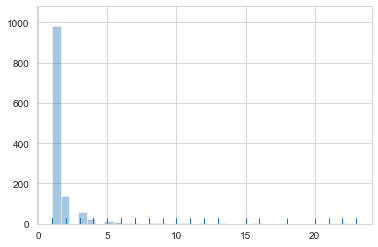

In [77]:
# create a histogram
sns.set_style("whitegrid")
num_papers = [len(author.papers) for author in authors]
sns.distplot(num_papers, kde=False, rug=True);

In [78]:
# how many papers exist in our dataset where the entire author list is from authors that have no other papers
# in our dataset
papers_with_completely_fresh_authors = list()
for paper in papers:
    num_papers_by_authors = 0
    for author in paper.authors:
        num_papers_by_authors += len(author.papers)
    
    if num_papers_by_authors == len(paper.authors):
        papers_with_completely_fresh_authors.append(paper)
        
print(f"The number of papers where entire author list is from authors that have no other papers: "
      f"{len(papers_with_completely_fresh_authors)} of {(len(df))}, which is "
      f"{len(papers_with_completely_fresh_authors) / (len(df)) * 100:.2f}%")
print()
for paper in papers_with_completely_fresh_authors:
    print(f"The paper {paper} has authors {paper.authors}")

The number of papers where entire author list is from authors that have no other papers: 100 of 506, which is 19.76%

The paper The Tactile Graphics Helper Providing Audio Clarification for Tactile Graphics Using Machine Vision, ASSETS 2015 has authors [Giovanni Fusco, Valerie Morash]
The paper LucentMaps 3D Printed Audiovisual Tactile Maps for Blind and Visually Impaired People, ASSETS 2016 has authors [Timo Götzelmann]
The paper Understanding and Designing for Deaf or Hard of Hearing Drivers on Uber, CHI 2019 has authors [Sooyeon Lee, Bjorn Hubert-Wallander, Molly Stevens, John M. Carroll]
The paper Automatically generating tailored accessible user interfaces for ubiquitous services, ASSETS 2011 has authors [Julio Abascal, Amaia Aizpurua, Idoia Cearreta, Borja Gamecho, Nestor Garay-Vitoria, Raúl Miñón]
The paper Understanding the conflicting demands of family caregivers caring for depressed family members, CHI 2013 has authors [Naomi Yamashita, Hideaki Kuzuoka, Keiji Hirata, Takashi 

# Data validity checks

## Verify NoUserStudy columns

In [13]:
# verify that all columns where NoUserStudy == 1 agree
code_cols_no_user_study = [col for col in df if 'NoUserStudy' in col]

print("In previous data, we had found disagreements between `NoUserStudy` columns. Checking now...")
print(f"Found {len(code_cols_no_user_study)} 'NoUserStudy' columns {code_cols_no_user_study}")
print("Making sure all of the 'NoUserStudy' columns agree...")

for i in range(len(code_cols_no_user_study) - 1):
    nouserstudy_col1 = code_cols_no_user_study[i]
    nouserstudy_col2 = code_cols_no_user_study[i + 1]
    df_no_userstudy_mismatch = df.query(f"{nouserstudy_col1} != {nouserstudy_col2}")
    if len(df_no_userstudy_mismatch) <= 0:
        print(f"Yay, no mismatches found between {nouserstudy_col1} and {nouserstudy_col2}!")
    else:
        print(f"Ugh, found {len(df_no_userstudy_mismatch)} 'NoUserStudy' mismatches between {nouserstudy_col1} and {nouserstudy_col2}.")
        print("This needs to be fixed!")
        display_cols = ['Index', 'Author', 'Title', 'DOI']
        display_cols.append(nouserstudy_col1)
        display_cols.append(nouserstudy_col2)
        display(df_no_userstudy_mismatch[display_cols])

In previous data, we had found disagreements between `NoUserStudy` columns. Checking now...
Found 2 'NoUserStudy' columns ['StudyLocation_NoUserStudy', 'ParticipantGroup_NoUserStudy']
Making sure all of the 'NoUserStudy' columns agree...
Yay, no mismatches found between StudyLocation_NoUserStudy and ParticipantGroup_NoUserStudy!


## Verify that a ParticipantGroup is set if ParticipantGroup-NoUserStudy == 0
If ParticipantGroup_NoUserStudy is equal to zero, then that means that the paper included a user study and thus should have a ParticipantGroup column set. This code double checks our papers to make sure this is true.

In [14]:
# verify that a participant group is set if nouserstudy == 0
query = ""
participant_group_cols = list(map_codes_to_cols['ParticipantGroup'])
participant_group_cols.remove('ParticipantGroup_NoUserStudy')
# print(participant_group_cols)
for i in range(0, len(participant_group_cols)):
    sub_code = participant_group_cols[i]
    query += f"{sub_code} == 0"
    if i + 1 < len(participant_group_cols):
        query += " and "
        
query += " and ParticipantGroup_NoUserStudy == 0"

print("Running the following query:")
print(f"df.query({query})")
print()
csv_participant_group_cols = list()
for sub_code in map_codes_to_cols['ParticipantGroup']:
    csv_participant_group_cols.append(str(sub_code))

df_query_result = df.query(query)

cols_to_print = ['Index', 'Author', 'Title']

print(f"The following {len(df_query_result)} papers have 'ParticipantGroup_NoUserStudy == 0' but no other ParticipantGroup set")
display(df_query_result.loc[:, cols_to_print])

print(f"Here's the same result data as above but with all participant group columns:")
cols_to_print.extend(csv_participant_group_cols)
display(df_query_result.loc[:, cols_to_print])

Running the following query:
df.query(ParticipantGroup_OlderAdult == 0 and ParticipantGroup_PeopleWithDisability == 0 and ParticipantGroup_PeopleWithoutDisability == 0 and ParticipantGroup_TherapistsSpecialists == 0 and ParticipantGroup_Caregivers == 0 and ParticipantGroup_Other == 0 and ParticipantGroup_NoUserStudy == 0)

The following 0 papers have 'ParticipantGroup_NoUserStudy == 0' but no other ParticipantGroup set


Empty DataFrame
Columns: [Index, Author, Title]
Index: []

Here's the same result data as above but with all participant group columns:


Empty DataFrame
Columns: [Index, Author, Title, ParticipantGroup_OlderAdult, ParticipantGroup_PeopleWithDisability, ParticipantGroup_PeopleWithoutDisability, ParticipantGroup_TherapistsSpecialists, ParticipantGroup_Caregivers, ParticipantGroup_Other, ParticipantGroup_NoUserStudy]
Index: []

## Verify NumParticipant columns
The following analysis corresponds to [Issue #48](https://github.com/jonfroehlich/accesslitsurvey/issues/48) in GitHub entitled "Check `NumParticipants-Group-Population` and make sure it matches the `ParticipantGroup` and `TargetPopulation` columns"

In [15]:
# First, verify that the 'NumParticipants-HasBeenVerified' column is all 1s

df_result = df.loc[df['NumParticipants_HasBeenVerified'] != 1]
if len(df_result) > 0:
    print(f"WARNING: There are {len(df_result)} papers where the num of participants has not been verified")
    display(df_result)
else:
    print("Yay! All papers have '1' in the 'NumParticipants_HasBeenVerified' column")

Yay! All papers have '1' in the 'NumParticipants_HasBeenVerified' column


### Verify ParticipantGroup and NumParticipants-Group-Population columns

In [16]:
# Need to create mapping between NumParticipant_Group_Population columns
# and our ParticipantGroup and TargetPopulation columns
group1_populations = df['NumParticipants_Group1_Population'].value_counts()
group2_populations = df['NumParticipants_Group2_Population'].value_counts()
group3_populations = df['NumParticipants_Group3_Population'].value_counts()
group4_populations = df['NumParticipants_Group4_Population'].value_counts()
group5_populations = df['NumParticipants_Group5_Population'].value_counts()

group_populations = [group1_populations, group2_populations, 
                     group3_populations, group4_populations,
                     group5_populations]

aggregate_populations = group_populations[0]
for i in range(1, len(group_populations)):
    aggregate_populations = aggregate_populations.add(group_populations[i], fill_value=0)

aggregate_populations = aggregate_populations.astype(int)
print("The NumParticipants_Group_Populations and their occurrence count:")
print(aggregate_populations.sort_values(ascending=False))

The NumParticipants_Group_Populations and their occurrence count:
0                                                                     1789
BVI                                                                    209
NonDisabled                                                            109
Motor/Physical                                                          61
Specialists                                                             49
Caregivers                                                              45
DHH                                                                     37
Older Adult NonDisabled                                                 29
Cognitive                                                               29
Autism                                                                  25
Teachers                                                                24
Other                                                                   19
Crowdworkers                      

In [17]:
# Deal with the huge number of other codes
group_population_codes = aggregate_populations.index.to_list()
full_other_codes = [code for code in group_population_codes if str(code).startswith('Other')]
full_other_codes = set(full_other_codes)
other_codes_without_disability = set(['Other-Signers', 'Other-ASL students',
                                'Other-Developers', 'Other-Administrators',
                                'Other-Designers/developers', 
                                'Other-Engineers or interaction designers', 
                                'Other-Family members', 
                                'Other-Garden show employees',
                                'Other-Students with web accessibility knowledge',
                                'Other-Students, teachers',
                                'Other-Students, technology instructor'])
other_codes_with_disability = set(full_other_codes)
other_codes_with_disability.difference_update(other_codes_without_disability)

print(f"We have {len(other_codes_with_disability)} 'Other' codes for people with disabilities:")
print(other_codes_with_disability)

print()
print(f"We have {len(other_codes_without_disability)} 'Other' codes for people without disabilities:")
print(other_codes_without_disability)

We have 7 'Other' codes for people with disabilities:
{'Other-Special education students with multiple learning challenges', 'Other-Visual and/or motor', 'Other-Disabled', 'Other', 'Other-CVD', 'Other-Children', 'Other-Mental health'}

We have 11 'Other' codes for people without disabilities:
{'Other-Developers', 'Other-Family members', 'Other-Garden show employees', 'Other-Designers/developers', 'Other-Signers', 'Other-Students with web accessibility knowledge', 'Other-Administrators', 'Other-Students, teachers', 'Other-Engineers or interaction designers', 'Other-ASL students', 'Other-Students, technology instructor'}


In [18]:
map_group_population_to_participant_group = dict()
map_group_population_to_participant_group['Older Adult NonDisabled'] = set(['ParticipantGroup_OlderAdult'])
map_group_population_to_participant_group['Older Adult Disabled'] = set(['ParticipantGroup_OlderAdult'])
map_group_population_to_participant_group['Older Adult'] = set(['ParticipantGroup_OlderAdult'])
map_group_population_to_participant_group['NonDisabled'] = set(['ParticipantGroup_PeopleWithoutDisability'])
map_group_population_to_participant_group['Caregivers'] = set(['ParticipantGroup_Caregivers'])
map_group_population_to_participant_group['Specialists'] = set(['ParticipantGroup_TherapistsSpecialists'])
map_group_population_to_participant_group['Therapists'] = set(['ParticipantGroup_TherapistsSpecialists'])
map_group_population_to_participant_group['Teachers'] = set(['ParticipantGroup_TherapistsSpecialists'])
map_group_population_to_participant_group['Specialists/Teachers'] = set(['ParticipantGroup_TherapistsSpecialists'])
map_group_population_to_participant_group['Other'] = set(['ParticipantGroup_Other'])
map_group_population_to_participant_group['Crowdworkers'] = set(['ParticipantGroup_Other_Crowdworker'])
map_group_population_to_participant_group['Other-Signers'] = set(['ParticipantGroup_Other'])
map_group_population_to_participant_group['Unclear'] = set(['ParticipantGroup_Other'])

# Track all of the sub-codes that are participants without disabilities
for other_code_without_disability in other_codes_without_disability:
    map_group_population_to_participant_group[other_code_without_disability] = set(['ParticipantGroup_Other'])
                     
codes_without_disability = set(['NonDisabled', 'Specialists', 'Caregivers',
                                'Older Adult NonDisabled', 'Teachers',
                                'Therapists', 'Crowdworkers', 
                                'Specialists/Teachers', 'Older Adult'])
codes_without_disability.update(other_codes_without_disability)

codes_with_disability = set(aggregate_populations.index)
codes_with_disability.remove(0)
codes_with_disability.remove('Other')
codes_with_disability.remove('Unclear')
codes_with_disability.difference_update(codes_without_disability)

for code_with_disability in codes_with_disability:
    if code_with_disability not in map_group_population_to_participant_group:
        map_group_population_to_participant_group[code_with_disability] = set()
    
    map_group_population_to_participant_group[code_with_disability].add('ParticipantGroup_PeopleWithDisability')

map_participant_group_to_group_population = dict()
for group_population_code, participant_group_list in map_group_population_to_participant_group.items():
    for participant_group in participant_group_list:
        if participant_group not in map_participant_group_to_group_population:
            map_participant_group_to_group_population[participant_group] = set()
        map_participant_group_to_group_population[participant_group].add(group_population_code)  

# Display a pretty print version of our mapping
df_participant_group_to_group_population = pd.DataFrame.from_dict(map_participant_group_to_group_population, orient='index' )
df_participant_group_to_group_population = df_participant_group_to_group_population.transpose()
display(df_participant_group_to_group_population)

# Iterate through every group population and make sure found in our mapping
not_found_in_mappings_cnt = 0
for population_code in aggregate_populations.index:
    if population_code not in map_group_population_to_participant_group and\
        population_code != 0:
        print(f"WARNING: {population_code} is not found in our mappings")
        not_found_in_mappings_cnt += 1
        
if not_found_in_mappings_cnt > 0:
    print(f"WARNING: found {not_found_in_mappings_cnt} sub-codes not mapped to 'ParticipantGroup' columns")
          
print()
print("Full mappings:")
for population_code in aggregate_populations.index:
    if population_code in map_group_population_to_participant_group:
        print(f"{population_code} is in {map_group_population_to_participant_group[population_code]}")


ParticipantGroup_OlderAdult  \
0         Older Adult Disabled   
1      Older Adult NonDisabled   
2                  Older Adult   
3                         None   
4                         None   
5                         None   
6                         None   
7                         None   
8                         None   
9                         None   
10                        None   
11                        None   
12                        None   
13                        None   

                ParticipantGroup_PeopleWithDisability  \
0                                           Other-CVD   
1                                                 BVI   
2                                           Cognitive   
3   Other-Special education students with multiple...   
4                                Older Adult Disabled   
5                           Other-Visual and/or motor   
6                                      Other-Children   
7                                                 DHH   
8                                          General DA   
9                                                 IDD   
10                                Other-Mental health   
11                                     Other-Disabled   
12                                             Autism   
13                                     Motor/Physical   

   ParticipantGroup_PeopleWithoutDisability ParticipantGroup_Caregivers  \
0                               NonDisabled                  Caregivers   
1                                      None                        None   
2                                      None                        None   
3                                      None                        None   
4                                      None                        None   
5                                      None                        None   
6                                      None                        None   
7                                      None                        None   
8                                      None                        None   
9                                      None                        None   
10                                     None                        None   
11                                     None                        None   
12                                     None                        None   
13                                     None                        None   

   ParticipantGroup_TherapistsSpecialists  \
0                             Specialists   
1                              Therapists   
2                    Specialists/Teachers   
3                                Teachers   
4                                    None   
5                                    None   
6                                    None   
7                                    None   
8                                    None   
9                                    None   
10                                   None   
11                                   None   
12                                   None   
13                                   None   

                             ParticipantGroup_Other  \
0                                  Other-Developers   
1                              Other-Family members   
2                       Other-Garden show employees   
3                        Other-Designers/developers   
4                                     Other-Signers   
5   Other-Students with web accessibility knowledge   
6                              Other-Administrators   
7                          Other-Students, teachers   
8                                           Unclear   
9          Other-Engineers or interaction designers   
10                               Other-ASL students   
11                                            Other   
12            Other-Students, technology instructor   
13                                             None   

   Parti


Full mappings:
Autism is in {'ParticipantGroup_PeopleWithDisability'}
BVI is in {'ParticipantGroup_PeopleWithDisability'}
Caregivers is in {'ParticipantGroup_Caregivers'}
Cognitive is in {'ParticipantGroup_PeopleWithDisability'}
Crowdworkers is in {'ParticipantGroup_Other_Crowdworker'}
DHH is in {'ParticipantGroup_PeopleWithDisability'}
General DA is in {'ParticipantGroup_PeopleWithDisability'}
IDD is in {'ParticipantGroup_PeopleWithDisability'}
Motor/Physical is in {'ParticipantGroup_PeopleWithDisability'}
NonDisabled is in {'ParticipantGroup_PeopleWithoutDisability'}
Older Adult is in {'ParticipantGroup_OlderAdult'}
Older Adult Disabled is in {'ParticipantGroup_OlderAdult', 'ParticipantGroup_PeopleWithDisability'}
Older Adult NonDisabled is in {'ParticipantGroup_OlderAdult'}
Other is in {'ParticipantGroup_Other'}
Other-ASL students is in {'ParticipantGroup_Other'}
Other-Administrators is in {'ParticipantGroup_Other'}
Other-CVD is in {'ParticipantGroup_PeopleWithDisability'}
Other-Ch

#### Check that codes in NumParticipants_Group_Population agree with ParticipantGroup columns

In [19]:
# First, let's check that the codes found in the NumParticipants_Group_Population columns
# agree with the ParticipantGroup columns
numparticipant_group_count_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Count" in col]
numparticipant_group_population_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Population" in col]

print(f"**Analyzing if codes in 'NumParticipants-Group-Population' match 'ParticipantGroup' cells**\n")

problem_cnt = 0
for index, row in df.iterrows():
    group_pop_codes_used_for_row = []
    for numparticipant_group_population_col in numparticipant_group_population_cols:
        if row[numparticipant_group_population_col] != 0:
            group_pop_codes_used_for_row.append(row[numparticipant_group_population_col])
            # print(numparticipant_group_population_col, row[numparticipant_group_population_col])
    
    for group_pop_code_used in group_pop_codes_used_for_row:
        participant_group_cols_for_code = map_group_population_to_participant_group[group_pop_code_used]
        for participant_group_col_for_code in participant_group_cols_for_code:
            if row[participant_group_col_for_code] != 1:
                print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" had the "
                      f"'NumParticipants-Group-Population' code of '{group_pop_code_used}' but the corresponding "
                      f"participant group column ({participant_group_col_for_code}) was not '1'")
                print()
                problem_cnt += 1
                
    # Check case were all NumParticipants_Group_Population columns are 0 but 
    # 'ParticipantGroup_NoUserStudy' is not set
    if len(group_pop_codes_used_for_row) <= 0 and row['ParticipantGroup_NoUserStudy'] != 1:
        print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" had no "
              f"'NumParticipants-Group-Population' codes set implying *NO* user study but the corresponding "
              f"participant group column ('ParticipantGroup_NoUserStudy') was not '1'")
        print()
        problem_cnt += 1
                      
print(f"Found {problem_cnt} disagreements")
    

**Analyzing if codes in 'NumParticipants-Group-Population' match 'ParticipantGroup' cells**

Found 0 disagreements


#### Check that ParticipantGroup cells agree with codes in NumParticipants_Group_Population
This code iterates through ParticipantGroup cells and ensure they agree with NumParticipants_Group_Population cells

In [20]:
print(f"**Analyzing if 'ParticipantGroup' cells agree with codes in NumParticipants_Group_Population**\n")

participant_group_cols = [col for col in df if 'ParticipantGroup' in col]
print(f"The participant group cols are {participant_group_cols}\n\n")

problem_cnt = 0
for index, row in df.iterrows():
    group_pop_codes_used_for_row = set()
    for numparticipant_group_population_col in numparticipant_group_population_cols:
        if row[numparticipant_group_population_col] != 0:
            group_pop_codes_used_for_row.add(row[numparticipant_group_population_col])
    
    #print(f"The population codes used for this row: {group_pop_codes_used_for_row}")
    
    for participant_group_col in participant_group_cols:
        if row[participant_group_col] == 1 and participant_group_col != 'ParticipantGroup_NoUserStudy':
            # now see if any of the group population columns have this code
            set_corresponding_codes = map_participant_group_to_group_population[participant_group_col]
           
            # print(f"Checking participant group column {participant_group_col} with corresponding codes {set_corresponding_codes}")
            found_code = False
            for group_pop_code_used in group_pop_codes_used_for_row:
                if group_pop_code_used in set_corresponding_codes:
                    # print(f"Found {group_pop_code_used} in {set_corresponding_codes}")
                    found_code = True
            
            if found_code is False:
                print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" "
                   f"had the \'{participant_group_col}\' cell set to '1' but none of the corresponding cells in "
                   f"`NumParticipants-Group-Population' were {set_corresponding_codes} " 
                   f". Instead, we found {group_pop_codes_used_for_row}.") 
                print()
                problem_cnt += 1
                
        elif row[participant_group_col] == 1 and participant_group_col == 'ParticipantGroup_NoUserStudy':
            # all NumParticipants_Group_Population columns should be 0
            for numparticipant_group_population_col in numparticipant_group_population_cols:
                if row[numparticipant_group_population_col] != 0:
                    print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" "
                       f"had the \'{participant_group_col}\' cell set to '1' but the {numparticipant_group_population_col} "
                       f"column was not Null or '0'")
                    print()
                    problem_cnt += 1

print(f"Found {problem_cnt} disagreements")

**Analyzing if 'ParticipantGroup' cells agree with codes in NumParticipants_Group_Population**

The participant group cols are ['ParticipantGroup_OlderAdult', 'ParticipantGroup_PeopleWithDisability', 'ParticipantGroup_PeopleWithoutDisability', 'ParticipantGroup_TherapistsSpecialists', 'ParticipantGroup_Caregivers', 'ParticipantGroup_Other', 'ParticipantGroup_Other_Notes', 'ParticipantGroup_Other_Crowdworker', 'ParticipantGroup_NoUserStudy']


The paper at Index 13 entitled "Online quality control for real-time crowd captioning" had the 'ParticipantGroup_Other' cell set to '1' but none of the corresponding cells in `NumParticipants-Group-Population' were {'Other-Developers', 'Other-Family members', 'Other-Garden show employees', 'Other-Designers/developers', 'Other-Signers', 'Other-Students with web accessibility knowledge', 'Other-Administrators', 'Other-Students, teachers', 'Unclear', 'Other-Engineers or interaction designers', 'Other-ASL students', 'Other', 'Other-Students, technolog

### Verify TargetParticipant and NumParticipants-Group-Population columns

In [21]:
target_pop_cols = [col for col in df if 'TargetPopulation' in col]
for i in reversed(range(len(target_pop_cols))):
    if target_pop_cols[i].count(code_separator) > 1 or target_pop_cols[i].count(code_separator) == 0:
        target_pop_cols.pop(i)
        
print(f"The target populations columns are {target_pop_cols}\n\n")

print("The NumParticipants_Group_Populations and their occurrence count:")
print(aggregate_populations.sort_values(ascending=False))

The target populations columns are ['TargetPopulation_BVI', 'TargetPopulation_DHH', 'TargetPopulation_IDD', 'TargetPopulation_MotorPhysical', 'TargetPopulation_Autism', 'TargetPopulation_Cognitive', 'TargetPopulation_OlderAdult', 'TargetPopulation_GeneralDisability', 'TargetPopulation_Other']


The NumParticipants_Group_Populations and their occurrence count:
0                                                                     1789
BVI                                                                    209
NonDisabled                                                            109
Motor/Physical                                                          61
Specialists                                                             49
Caregivers                                                              45
DHH                                                                     37
Older Adult NonDisabled                                                 29
Cognitive                             

In [22]:
map_group_population_to_target_pop = dict()
map_group_population_to_target_pop['Older Adult'] = set(['TargetPopulation_OlderAdult'])
map_group_population_to_target_pop['Older Adult NonDisabled'] = set(['TargetPopulation_OlderAdult'])
map_group_population_to_target_pop['Older Adult Disabled'] = set(['TargetPopulation_OlderAdult'])
map_group_population_to_target_pop['NonDisabled'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Caregivers'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Specialists'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Therapists'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Teachers'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Other'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Crowdworkers'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Other-Signers'] = set(['TargetPopulation_DHH'])
map_group_population_to_target_pop['Unclear'] = set(['TargetPopulation_Other'])

map_group_population_to_target_pop['Cognitive'] = set(['TargetPopulation_Cognitive'])
map_group_population_to_target_pop['BVI'] = set(['TargetPopulation_BVI'])
map_group_population_to_target_pop['IDD'] = set(['TargetPopulation_IDD'])
map_group_population_to_target_pop['Autism'] = set(['TargetPopulation_Autism'])
map_group_population_to_target_pop['General DA'] = set(['TargetPopulation_GeneralDisability'])
map_group_population_to_target_pop['Motor/Physical'] = set(['TargetPopulation_MotorPhysical'])
map_group_population_to_target_pop['DHH'] = set(['TargetPopulation_DHH'])
map_group_population_to_target_pop['Older Adult Disabled'] = set(['TargetPopulation_OlderAdult'])

set_ignore_population_codes = set([0, 'Unclear', 'Signers', 'Crowdworkers', 'Caregivers', 
                                   'Teachers', 'Therapists', 'Specialists', 'NonDisabled',
                                  'Specialists/Teachers'])

set_ignore_population_codes.update(other_codes_without_disability)
set_ignore_population_codes.update(other_codes_with_disability)

map_target_pop_to_group_population = dict()
for group_population_code, target_pop_list in map_group_population_to_target_pop.items():
    for target_pop in target_pop_list:
        if target_pop not in map_target_pop_to_group_population:
            map_target_pop_to_group_population[target_pop] = set()
        map_target_pop_to_group_population[target_pop].add(group_population_code)  

# Display a pretty print version of our mapping
df_target_pop_to_group_population = pd.DataFrame.from_dict(map_target_pop_to_group_population, orient='index' )
df_target_pop_to_group_population = df_target_pop_to_group_population.transpose()
display(df_target_pop_to_group_population)
        
# Iterate through every group population and make sure found in our mapping
not_found_in_mappings_cnt = 0
for population_code in aggregate_populations.index:
    if population_code not in map_group_population_to_target_pop and\
        population_code not in set_ignore_population_codes:
        print(f"WARNING: {population_code} is not found in our mappings")
        not_found_in_mappings_cnt += 1
        
if not_found_in_mappings_cnt > 0:
    print(f"WARNING: found {not_found_in_mappings_cnt} sub-codes not mapped to 'ParticipantGroup' columns")
          
print()
print("Full mappings:")
for population_code in aggregate_populations.index:
    if population_code in map_group_population_to_target_pop:
        print(f"{population_code} is in {map_group_population_to_target_pop[population_code]}")

TargetPopulation_OlderAdult TargetPopulation_Other TargetPopulation_DHH  \
0     Older Adult NonDisabled            Specialists        Other-Signers   
1        Older Adult Disabled               Teachers                  DHH   
2                 Older Adult             Caregivers                 None   
3                        None            NonDisabled                 None   
4                        None                Unclear                 None   
5                        None           Crowdworkers                 None   
6                        None                  Other                 None   
7                        None             Therapists                 None   

  TargetPopulation_Cognitive TargetPopulation_BVI TargetPopulation_IDD  \
0                  Cognitive                  BVI                  IDD   
1                       None                 None                 None   
2                       None                 None                 None   
3                       None                 None                 None   
4                       None                 None                 None   
5                       None                 None                 None   
6                       None                 None                 None   
7                       None                 None                 None   

  TargetPopulation_Autism TargetPopulation_GeneralDisability  \
0                  Autism                         General DA   
1                    None                               None   
2                    None                               None   
3                    None                               None   
4                    None                               None   
5                    None                               None   
6                    None                               None   
7                    None                               None   

  TargetPopulation_MotorPhysical  
0                 Motor/Physical  
1                           None  
2                           None  
3                           None  
4                           None  
5                           None  
6                           None  
7                           None


Full mappings:
Autism is in {'TargetPopulation_Autism'}
BVI is in {'TargetPopulation_BVI'}
Caregivers is in {'TargetPopulation_Other'}
Cognitive is in {'TargetPopulation_Cognitive'}
Crowdworkers is in {'TargetPopulation_Other'}
DHH is in {'TargetPopulation_DHH'}
General DA is in {'TargetPopulation_GeneralDisability'}
IDD is in {'TargetPopulation_IDD'}
Motor/Physical is in {'TargetPopulation_MotorPhysical'}
NonDisabled is in {'TargetPopulation_Other'}
Older Adult is in {'TargetPopulation_OlderAdult'}
Older Adult Disabled is in {'TargetPopulation_OlderAdult'}
Older Adult NonDisabled is in {'TargetPopulation_OlderAdult'}
Other is in {'TargetPopulation_Other'}
Other-Signers is in {'TargetPopulation_DHH'}
Specialists is in {'TargetPopulation_Other'}
Teachers is in {'TargetPopulation_Other'}
Therapists is in {'TargetPopulation_Other'}
Unclear is in {'TargetPopulation_Other'}


#### Check that codes in NumParticipants_Group_Population agree with TargetPopulation columns

In [23]:
numparticipant_group_count_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Count" in col]
numparticipant_group_population_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Population" in col]

print(f"**Analyzing if codes in 'NumParticipants-Group-Population' match 'TargetPopulation' cells**\n")
print(f"We are currently ignoring {len(set_ignore_population_codes)} codes in 'NumParticipants-Group-Population "
      f"because I could not determine an adequate mapping between them and the 'TargetPopulation' columns."
      " The ignored codes are:")
print()
for ignored_code in set_ignore_population_codes:
    print(ignored_code)
print()

problem_cnt = 0
ignored_cnt_due_to_validity_script_ok = 0
ignored_cnt_set_ignore_pop_codes = 0
for index, row in df.iterrows():
    if row['ValidityScriptDiscrepancyIsOkay'] == 1:
        print(f"Ignoring paper at Index {row['Index']} entitled \"{row['Title'].strip()}\""
              f"because 'ValidityScriptDiscrepancyIsOkay == 1'")
        print()
        ignored_cnt_due_to_validity_script_ok += 1
    else:
        group_pop_codes_used_for_row = []

        for numparticipant_group_population_col in numparticipant_group_population_cols:
            if row[numparticipant_group_population_col] != 0:
                group_pop_codes_used_for_row.append(row[numparticipant_group_population_col])
                # print(numparticipant_group_population_col, row[numparticipant_group_population_col])

        for group_pop_code_used in group_pop_codes_used_for_row:

            if group_pop_code_used in set_ignore_population_codes:
                #print(f"Ignoring 'NumParticipants-Group-Population' code of {group_pop_code_used} "
                #      f"for the paper at Index {row['Index']}")
                ignored_cnt_set_ignore_pop_codes += 1
            else:
                target_pop_cols_for_code = map_group_population_to_target_pop[group_pop_code_used]
                for target_pop_col_for_code in target_pop_cols_for_code:
                    if row[target_pop_col_for_code] != 1:
                        print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" had the "
                              f"'NumParticipants-Group-Population' code of '{group_pop_code_used}' but the corresponding "
                              f"target population column ({target_pop_col_for_code}) was not '1'")
                        print()
                        problem_cnt += 1
                      
print(f"Found {problem_cnt} disagreements")
print(f"Ignored {ignored_cnt_due_to_validity_script_ok} papers because 'ValidityScriptDiscrepancyIsOkay == 1'")
print(f"Ignored {ignored_cnt_set_ignore_pop_codes} total validity checks due to {len(set_ignore_population_codes)} ignored codes")

**Analyzing if codes in 'NumParticipants-Group-Population' match 'TargetPopulation' cells**

We are currently ignoring 28 codes in 'NumParticipants-Group-Population because I could not determine an adequate mapping between them and the 'TargetPopulation' columns. The ignored codes are:

0
Other-Developers
Other-Family members
Other-Garden show employees
Specialists
Other-Special education students with multiple learning challenges
Other-Designers/developers
Other-Signers
Other-Students with web accessibility knowledge
Other-Visual and/or motor
NonDisabled
Other-Students, teachers
Unclear
Other-Disabled
Other-ASL students
Other
Specialists/Teachers
Other-Students, technology instructor
Other-CVD
Teachers
Caregivers
Other-Children
Other-Administrators
Other-Mental health
Other-Engineers or interaction designers
Crowdworkers
Therapists
Signers

Ignoring paper at Index 2 entitled ""Occupational Therapy is Making": Clinical Rapid Prototyping and Digital Fabrication"because 'ValidityScriptDi

#### Check that TargetPopulation cells agree with codes in NumParticipants_Group_Population
This code iterates through TargetPopulation cells and ensure they agree with NumParticipants_Group_Population cells

In [24]:
print(f"**Analyzing if 'TargetPopulation' cells agree with codes in NumParticipants_Group_Population**\n")

print(f"The target populations columns are {target_pop_cols}\n\n")

problem_cnt = 0
ignored_cnt_due_to_validity_script_ok = 0
ignored_cnt_due_to_no_user_study = 0
for index, row in df.iterrows():
    if row['ValidityScriptDiscrepancyIsOkay'] == 1:
#         print(f"Ignoring paper at Index {row['Index']} entitled \"{row['Title'].strip()}\""
#               f"because 'ValidityScriptDiscrepancyIsOkay == 1'")
#         print()
        ignored_cnt_due_to_validity_script_ok += 1
    elif row['ParticipantGroup_NoUserStudy'] == 1:
#         print(f"Ignoring paper at Index {row['Index']} entitled \"{row['Title'].strip()}\""
#               f"because 'ParticipantGroup_NoUserStudy == 1'")
#         print()
        ignored_cnt_due_to_no_user_study += 1
    else:
        group_pop_codes_used_for_row = set()
        for numparticipant_group_population_col in numparticipant_group_population_cols:
            if row[numparticipant_group_population_col] != 0:
                group_pop_codes_used_for_row.add(row[numparticipant_group_population_col])

        #print(f"The population codes used for this row: {group_pop_codes_used_for_row}")

        for target_pop_col in target_pop_cols:
            if row[target_pop_col] == 1:
                # now see if any of the group population columns have this code
                set_corresponding_codes = map_target_pop_to_group_population[target_pop_col]

                # print(f"Checking target population column {target_pop_col} with corresponding codes {set_corresponding_codes}")
                found_code = False
                for group_pop_code_used in group_pop_codes_used_for_row:
                    if group_pop_code_used in set_corresponding_codes:
                        # print(f"Found {group_pop_code_used} in {set_corresponding_codes}")
                        found_code = True

                if found_code is False:
                    print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" "
                       f"had the \'{target_pop_col}\' cell set to '1' but none of the corresponding cells in "
                       f"`NumParticipants-Group-Population' were {set_corresponding_codes} " 
                       f". Instead, we found {group_pop_codes_used_for_row}.") 
                    print()
                    problem_cnt += 1
                
print(f"Found {problem_cnt} disagreements")
print(f"Ignored {ignored_cnt_due_to_validity_script_ok} papers because 'ValidityScriptDiscrepancyIsOkay == 1'")
print(f"Ignored {ignored_cnt_due_to_no_user_study} papers because 'ParticipantGroup_NoUserStudy == 1'")

**Analyzing if 'TargetPopulation' cells agree with codes in NumParticipants_Group_Population**

The target populations columns are ['TargetPopulation_BVI', 'TargetPopulation_DHH', 'TargetPopulation_IDD', 'TargetPopulation_MotorPhysical', 'TargetPopulation_Autism', 'TargetPopulation_Cognitive', 'TargetPopulation_OlderAdult', 'TargetPopulation_GeneralDisability', 'TargetPopulation_Other']


Found 0 disagreements
Ignored 78 papers because 'ValidityScriptDiscrepancyIsOkay == 1'
Ignored 29 papers because 'ParticipantGroup_NoUserStudy == 1'
